In [2]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [10]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)

np.random.shuffle(X_train.to_numpy()) #Randomly shuffle the training data for batching

train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

print("----------------Preprocessing the data-------------------")
X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

#Separating 15% of the training Data as Validation Dataset
X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))
print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
----------------Preprocessing the data-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [11]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()
print("--------------------Done----------------------------------")

--------Perform 1-hot encoding of class labels------------
--------------------Done----------------------------------


In [12]:
#Add the intercept term to the data samples both in training and test dataset
print("--------Adding the intercept term in the dataset as bias------------")
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))
print("-----------------------------Done----------------------------------")

--------Adding the intercept term in the dataset as bias------------
-----------------------------Done----------------------------------


In [16]:
#Mini-Batch formation

batch_size = 100 # Mini-Batch Size

print("----------------Forming mini-batches of size {}---------------------".format(batch_size))
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

----------------Forming mini-batches of size 100---------------------
The number of mini-batches formed is = 111


In [117]:
#Theta Initialization 

def theta_init(arch=[50], mode='normal'):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        if (mode=='normal'):
            theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        elif(mode=='random'):
            theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [154]:
# Sigmoid activation function
def activation(x):
    return 1/(1+np.exp(-x))

#ReLU Activation Function
def relu_act(x):
    return np.maximum(0.0, x)

#Derivative of ReLU activation Function
def deriv_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softplus(x):
    return np.log(1+np.exp(x))

def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [210]:
# Forward propagation

def forward_prop(data, theta, act_fn='sigmoid'):
    fm = []
    fm.append(data)
    if (act_fn == 'sigmoid'):
        for l in range(len(theta)):
            fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'relu'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(relu_act(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    elif(act_fn == 'softplus'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(softplus(np.dot(fm[l], theta[l])))
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [223]:
# Backward propagation
def backward_prop(fm, Y_b, theta, batch_size, act_fn='sigmoid', cost_fn='sqr_error'):
    delta = [None]*len(fm)
    for l in range(len(fm)-1, 0, -1):
        if (l == len(fm)-1):
            if (cost_fn=='entropy'):
                delta[l] = ((1/batch_size)*((Y_b/fm[l])-((1-Y_b)/(1-fm[l])))*fm[l]*(1-fm[l]))
            else:
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
        else:
            if (act_fn == 'sigmoid'):
                delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
            elif(act_fn == 'relu'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
            elif(act_fn=='softplus'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_softplus(fm[l])
    return delta

In [224]:
def cost_total(X, theta, Y, m, act_fn='sigmoid', cost_fn='sqr_error'):
    fm = forward_prop(X, theta, act_fn)
    if (cost_fn == 'sqr_error'):
        cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    else:
        cost = -(1/m)*(np.sum(((Y*np.log(fm[-1]))+((1-Y)*(np.log(1-fm[-1]))))))
    return cost

In [213]:
def calc_accuracy(data, theta, actual_class, act_fn='sigmoid'):
    pred_class = forward_prop(data, theta, act_fn)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    return (test_acc*100)

## PART AB - One Hidden Layer Neural Network

In [106]:
plt_epoch = []
plt_train_acc = []
plt_val_acc = []
plt_test_acc = []
costs= []


In [217]:
def training(mini_batch, X_valid, valid_class_enc, theta, lr, act_fn='sigmoid', lr_mode='constant', cost_fn='sqr_error'):
    lr0=lr
    epoch = 1 # Number of epochs
    early_stop=0 #Early stop count of iteration
    
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
    
    while(True):
        count_batch = 0
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))
        
        if(lr_mode == "adaptive"):
            lr = lr0/(np.power(epoch, 1/2))
            print("learning rate for this epoch = ", lr)
        
        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
        
            #Forward Propagation
            fm = forward_prop(X_b, theta, act_fn)
            
            if (count_batch % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size, act_fn, cost_fn)))
                    
            #Backward Propagation
            delta = [None]*len(fm)
            delta = backward_prop(fm, Y_b, theta, batch_size, act_fn, cost_fn)

            #Theta Update
            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count_batch+=1

        epoch+=1 #Number of epochs
        
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        #Stopping criteria for sigmoid - when Validation loss stops decreasing beyond a threshold for 10 epochs
        if (act_fn =='sigmoid'):
            if (abs(cost_final-cost_init) < 1e-06):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 10):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        #Stopping criteria for relu - when Validation loss increases continuously for 30 epochs
        elif(act_fn=='relu' or act_fn=='softplus'):
            if ((cost_final-cost_init) > 0):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 30):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        cost_init = cost_final
    return epoch, theta

In [192]:
def plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
    ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
    ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Accuracy (%)")

    plt.legend()
    #plt.savefig("plots/partd/accuracy_val_normal_adapt_sqrt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [193]:
def plot_epoch(arch_test, epochs, train_time):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Epochs")
    ax.legend()

    ax1 = fig.add_subplot(212)
    ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
    ax1.set_xlabel("number of hidden units")
    ax1.set_ylabel("train time(sec)")
    plt.legend()
    #plt.savefig("plots/partc/epochs_time_normal_adapt.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [101]:
arch_test = [1,5,10,50,100] # Specifically for part a and b
arch = [50] #means one hidden layer with 50 perceptrons (DEFAULT)
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [122]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr=0.1

for i in range(len(arch_test)):
    #Choose between normal or random. Normal gives better results
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid')
    
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2602071696618875
Error on this batch = 3.260762333028255
Error on this batch = 3.182990613883103
Cost on val dataset after 2 epochs is = 2.5175990574696963
Initial Cost on Val dataset for this epoch 2 = 2.5175990574696963
Error on this batch = 2.521408793795217
Error on this batch = 1.5689884303583188
Cost on val dataset after 3 epochs is = 1.1509999295653208
Initial Cost on Val dataset for this epoch 3 = 1.1509999295653208
Error on this batch = 1.1442253674331047
Error on this batch = 0.9199338946818452
Cost on val dataset after 4 epochs is = 0.8082163441400501
Initial Cost on Val dataset for this epoch 4 = 0.8082163441400501
Error on this batch = 0.8044542765860309
Error on this batch = 0.7252080708577142
Cost on val dataset after 5 epochs is = 0.

Error on this batch = 0.4839269497176661
Cost on val dataset after 41 epochs is = 0.4842467200543434
Initial Cost on Val dataset for this epoch 41 = 0.4842467200543434
Error on this batch = 0.48374610175580823
Error on this batch = 0.4837523457263923
Cost on val dataset after 42 epochs is = 0.48406913554015013
Initial Cost on Val dataset for this epoch 42 = 0.48406913554015013
Error on this batch = 0.48357516954705954
Error on this batch = 0.4835899260645064
Cost on val dataset after 43 epochs is = 0.48390367110003524
Initial Cost on Val dataset for this epoch 43 = 0.48390367110003524
Error on this batch = 0.48341600703739956
Error on this batch = 0.48343863479809457
Cost on val dataset after 44 epochs is = 0.48374929302505754
Initial Cost on Val dataset for this epoch 44 = 0.48374929302505754
Error on this batch = 0.4832676045534106
Error on this batch = 0.483297527127352
Cost on val dataset after 45 epochs is = 0.4836050749077452
Initial Cost on Val dataset for this epoch 45 = 0.4836

Cost on val dataset after 81 epochs is = 0.4815058606495121
Initial Cost on Val dataset for this epoch 81 = 0.4815058606495121
Error on this batch = 0.4811278528117622
Error on this batch = 0.48126623818063663
Cost on val dataset after 82 epochs is = 0.48148565602978294
Initial Cost on Val dataset for this epoch 82 = 0.48148565602978294
Error on this batch = 0.4811088334432735
Error on this batch = 0.48124846049527364
Cost on val dataset after 83 epochs is = 0.48146631379161675
Initial Cost on Val dataset for this epoch 83 = 0.48146631379161675
Error on this batch = 0.48109063378285405
Error on this batch = 0.4812314693466964
Cost on val dataset after 84 epochs is = 0.481447791067733
Initial Cost on Val dataset for this epoch 84 = 0.481447791067733
Error on this batch = 0.4810732126630707
Error on this batch = 0.4812152251983703
Cost on val dataset after 85 epochs is = 0.4814300474758613
Initial Cost on Val dataset for this epoch 85 = 0.4814300474758613
Error on this batch = 0.48105653

Error on this batch = 0.4809218829198048
Cost on val dataset after 121 epochs is = 0.4810985119717693
Initial Cost on Val dataset for this epoch 121 = 0.4810985119717693
Error on this batch = 0.48074621442772375
Error on this batch = 0.48091832776512405
Cost on val dataset after 122 epochs is = 0.4810942149068039
Initial Cost on Val dataset for this epoch 122 = 0.4810942149068039
Error on this batch = 0.48074220581423827
Error on this batch = 0.48091490662635755
Cost on val dataset after 123 epochs is = 0.4810900642412282
Initial Cost on Val dataset for this epoch 123 = 0.4810900642412282
Error on this batch = 0.48073833358717316
Error on this batch = 0.48091161416675293
Cost on val dataset after 124 epochs is = 0.4810860543535744
Initial Cost on Val dataset for this epoch 124 = 0.4810860543535744
Error on this batch = 0.48073459245666755
Error on this batch = 0.480908445282648
Cost on val dataset after 125 epochs is = 0.4810821798632389
Initial Cost on Val dataset for this epoch 125 =

Cost on val dataset after 161 epochs is = 0.4810015152641109
Initial Cost on Val dataset for this epoch 161 = 0.4810015152641109
Error on this batch = 0.48065542076848367
Error on this batch = 0.48084634490775346
Cost on val dataset after 162 epochs is = 0.48100031249890385
Initial Cost on Val dataset for this epoch 162 = 0.48100031249890385
Error on this batch = 0.4806542834702781
Error on this batch = 0.4808455807006871
Cost on val dataset after 163 epochs is = 0.4809991440781975
Initial Cost on Val dataset for this epoch 163 = 0.4809991440781975
Error on this batch = 0.4806531780121553
Error on this batch = 0.4808448445366188
Cost on val dataset after 164 epochs is = 0.48099800886056276
Initial Cost on Val dataset for this epoch 164 = 0.48099800886056276
Error on this batch = 0.4806521033456828
Error on this batch = 0.4808441354150122
Cost on val dataset after 165 epochs is = 0.4809969057455628
Initial Cost on Val dataset for this epoch 165 = 0.4809969057455628
Error on this batch =

Error on this batch = 0.48112078526270263
Cost on val dataset after 21 epochs is = 0.4799198924550682
Initial Cost on Val dataset for this epoch 21 = 0.4799198924550682
Error on this batch = 0.4800866098743596
Error on this batch = 0.48089239210120066
Cost on val dataset after 22 epochs is = 0.4798020778474316
Initial Cost on Val dataset for this epoch 22 = 0.4798020778474316
Error on this batch = 0.48000836465862134
Error on this batch = 0.48068384321429514
Cost on val dataset after 23 epochs is = 0.47969443908489623
Initial Cost on Val dataset for this epoch 23 = 0.47969443908489623
Error on this batch = 0.4799393465326071
Error on this batch = 0.480491539101305
Cost on val dataset after 24 epochs is = 0.4795949246023383
Initial Cost on Val dataset for this epoch 24 = 0.4795949246023383
Error on this batch = 0.4798777434183449
Error on this batch = 0.48031262387835577
Cost on val dataset after 25 epochs is = 0.4795019226635021
Initial Cost on Val dataset for this epoch 25 = 0.4795019

Cost on val dataset after 60 epochs is = 0.4768481616086649
Initial Cost on Val dataset for this epoch 60 = 0.4768481616086649
Error on this batch = 0.4786012765501325
Error on this batch = 0.4756416520007339
Cost on val dataset after 61 epochs is = 0.476759605378084
Initial Cost on Val dataset for this epoch 61 = 0.476759605378084
Error on this batch = 0.478558844326616
Error on this batch = 0.4754947639915655
Cost on val dataset after 62 epochs is = 0.4766696783713938
Initial Cost on Val dataset for this epoch 62 = 0.4766696783713938
Error on this batch = 0.47851522879889047
Error on this batch = 0.4753455961881001
Cost on val dataset after 63 epochs is = 0.476578352721288
Initial Cost on Val dataset for this epoch 63 = 0.476578352721288
Error on this batch = 0.4784703886217889
Error on this batch = 0.4751941368681424
Cost on val dataset after 64 epochs is = 0.47648560393946965
Initial Cost on Val dataset for this epoch 64 = 0.47648560393946965
Error on this batch = 0.478424282791166

Cost on val dataset after 100 epochs is = 0.47222460229688124
Initial Cost on Val dataset for this epoch 100 = 0.47222460229688124
Error on this batch = 0.47572252216996463
Error on this batch = 0.4672597817373578
Cost on val dataset after 101 epochs is = 0.47208160817669736
Initial Cost on Val dataset for this epoch 101 = 0.47208160817669736
Error on this batch = 0.4756287528927953
Error on this batch = 0.4669452675705675
Cost on val dataset after 102 epochs is = 0.4719373463186111
Initial Cost on Val dataset for this epoch 102 = 0.4719373463186111
Error on this batch = 0.4755342168995567
Error on this batch = 0.4666250139468197
Cost on val dataset after 103 epochs is = 0.4717918696786827
Initial Cost on Val dataset for this epoch 103 = 0.4717918696786827
Error on this batch = 0.47543883415798815
Error on this batch = 0.46629927264434934
Cost on val dataset after 104 epochs is = 0.4716452383919084
Initial Cost on Val dataset for this epoch 104 = 0.4716452383919084
Error on this batch 

Cost on val dataset after 140 epochs is = 0.4657378458180582
Initial Cost on Val dataset for this epoch 140 = 0.4657378458180582
Error on this batch = 0.4714555262206073
Error on this batch = 0.45338747509067373
Cost on val dataset after 141 epochs is = 0.4655470622620874
Initial Cost on Val dataset for this epoch 141 = 0.4655470622620874
Error on this batch = 0.4713453188891029
Error on this batch = 0.4530437035627465
Cost on val dataset after 142 epochs is = 0.4653533281985743
Initial Cost on Val dataset for this epoch 142 = 0.4653533281985743
Error on this batch = 0.47123439711678383
Error on this batch = 0.45269250662199845
Cost on val dataset after 143 epochs is = 0.46515646467846083
Initial Cost on Val dataset for this epoch 143 = 0.46515646467846083
Error on this batch = 0.471122338008697
Error on this batch = 0.45233200207653257
Cost on val dataset after 144 epochs is = 0.46495634913626444
Initial Cost on Val dataset for this epoch 144 = 0.46495634913626444
Error on this batch 

Cost on val dataset after 180 epochs is = 0.4568899933669506
Initial Cost on Val dataset for this epoch 180 = 0.4568899933669506
Error on this batch = 0.46380265696499295
Error on this batch = 0.43901204530897703
Cost on val dataset after 181 epochs is = 0.4566793980480927
Initial Cost on Val dataset for this epoch 181 = 0.4566793980480927
Error on this batch = 0.46362162840575627
Error on this batch = 0.4387234958172691
Cost on val dataset after 182 epochs is = 0.4564702255871621
Initial Cost on Val dataset for this epoch 182 = 0.4564702255871621
Error on this batch = 0.46344208563095995
Error on this batch = 0.4384376990229086
Cost on val dataset after 183 epochs is = 0.45626242005182466
Initial Cost on Val dataset for this epoch 183 = 0.45626242005182466
Error on this batch = 0.46326402330562716
Error on this batch = 0.4381546705154262
Cost on val dataset after 184 epochs is = 0.4560559273981616
Initial Cost on Val dataset for this epoch 184 = 0.4560559273981616
Error on this batch 

Error on this batch = 0.42955511114156153
Cost on val dataset after 219 epochs is = 0.4494303973468167
Initial Cost on Val dataset for this epoch 219 = 0.4494303973468167
Error on this batch = 0.4578060725343038
Error on this batch = 0.42933287449961255
Cost on val dataset after 220 epochs is = 0.44925901318358474
Initial Cost on Val dataset for this epoch 220 = 0.44925901318358474
Error on this batch = 0.4576681285300312
Error on this batch = 0.4291123860321436
Cost on val dataset after 221 epochs is = 0.44908889419208675
Initial Cost on Val dataset for this epoch 221 = 0.44908889419208675
Error on this batch = 0.4575299805211433
Error on this batch = 0.4288938451808065
Cost on val dataset after 222 epochs is = 0.4489200370054647
Initial Cost on Val dataset for this epoch 222 = 0.4489200370054647
Error on this batch = 0.45739158915028555
Error on this batch = 0.42867745448384975
Cost on val dataset after 223 epochs is = 0.44875243282076166
Initial Cost on Val dataset for this epoch 22

Error on this batch = 0.4226988368902721
Cost on val dataset after 259 epochs is = 0.44340569046128964
Initial Cost on Val dataset for this epoch 259 = 0.44340569046128964
Error on this batch = 0.4521495290671519
Error on this batch = 0.42256610869489253
Cost on val dataset after 260 epochs is = 0.44327370174958874
Initial Cost on Val dataset for this epoch 260 = 0.44327370174958874
Error on this batch = 0.452013412929096
Error on this batch = 0.42243408091921086
Cost on val dataset after 261 epochs is = 0.443142545694385
Initial Cost on Val dataset for this epoch 261 = 0.443142545694385
Error on this batch = 0.4518783159022338
Error on this batch = 0.42230270579849205
Cost on val dataset after 262 epochs is = 0.4430122190846268
Initial Cost on Val dataset for this epoch 262 = 0.4430122190846268
Error on this batch = 0.4517442992271393
Error on this batch = 0.42217193940869613
Cost on val dataset after 263 epochs is = 0.4428827185459131
Initial Cost on Val dataset for this epoch 263 = 

Error on this batch = 0.417717188863205
Cost on val dataset after 299 epochs is = 0.4387290537121619
Initial Cost on Val dataset for this epoch 299 = 0.4387290537121619
Error on this batch = 0.4478654468752929
Error on this batch = 0.4176009996649211
Cost on val dataset after 300 epochs is = 0.43862639957868893
Initial Cost on Val dataset for this epoch 300 = 0.43862639957868893
Error on this batch = 0.4477906137862216
Error on this batch = 0.4174854379673002
Cost on val dataset after 301 epochs is = 0.4385243571566327
Initial Cost on Val dataset for this epoch 301 = 0.4385243571566327
Error on this batch = 0.44771707194039534
Error on this batch = 0.41737052652174184
Cost on val dataset after 302 epochs is = 0.43842292125561744
Initial Cost on Val dataset for this epoch 302 = 0.43842292125561744
Error on this batch = 0.44764478691371645
Error on this batch = 0.4172562871884118
Cost on val dataset after 303 epochs is = 0.43832208680493984
Initial Cost on Val dataset for this epoch 303 

Error on this batch = 0.4136507063264177
Cost on val dataset after 339 epochs is = 0.43505643615294826
Initial Cost on Val dataset for this epoch 339 = 0.43505643615294826
Error on this batch = 0.4456035158840171
Error on this batch = 0.4135631117368022
Cost on val dataset after 340 epochs is = 0.4349749412314403
Initial Cost on Val dataset for this epoch 340 = 0.4349749412314403
Error on this batch = 0.44556094400551827
Error on this batch = 0.4134760084263804
Cost on val dataset after 341 epochs is = 0.4348938975934231
Initial Cost on Val dataset for this epoch 341 = 0.4348938975934231
Error on this batch = 0.44551889795821487
Error on this batch = 0.4133893789594832
Cost on val dataset after 342 epochs is = 0.43481330153380265
Initial Cost on Val dataset for this epoch 342 = 0.43481330153380265
Error on this batch = 0.44547737185564146
Error on this batch = 0.41330320603461757
Cost on val dataset after 343 epochs is = 0.43473314934787805
Initial Cost on Val dataset for this epoch 34

Error on this batch = 0.41045673426208645
Cost on val dataset after 378 epochs is = 0.4321789658013833
Initial Cost on Val dataset for this epoch 378 = 0.4321789658013833
Error on this batch = 0.4442802987381406
Error on this batch = 0.41037742843549824
Cost on val dataset after 379 epochs is = 0.43211235779401935
Initial Cost on Val dataset for this epoch 379 = 0.43211235779401935
Error on this batch = 0.44425382942008923
Error on this batch = 0.41029811042733677
Cost on val dataset after 380 epochs is = 0.432046058883917
Initial Cost on Val dataset for this epoch 380 = 0.432046058883917
Error on this batch = 0.44422763493122147
Error on this batch = 0.41021877279282387
Cost on val dataset after 381 epochs is = 0.4319800654158898
Initial Cost on Val dataset for this epoch 381 = 0.4319800654158898
Error on this batch = 0.44420170718943114
Error on this batch = 0.4101394083570956
Cost on val dataset after 382 epochs is = 0.43191437372680846
Initial Cost on Val dataset for this epoch 382

Error on this batch = 0.40722246168840387
Cost on val dataset after 418 epochs is = 0.4297191560425166
Initial Cost on Val dataset for this epoch 418 = 0.4297191560425166
Error on this batch = 0.4433586745907377
Error on this batch = 0.40713904325547307
Cost on val dataset after 419 epochs is = 0.4296620347971752
Initial Cost on Val dataset for this epoch 419 = 0.4296620347971752
Error on this batch = 0.44333756399843866
Error on this batch = 0.40705548102306977
Cost on val dataset after 420 epochs is = 0.42960507846895196
Initial Cost on Val dataset for this epoch 420 = 0.42960507846895196
Error on this batch = 0.44331651383287435
Error on this batch = 0.4069717766220221
Cost on val dataset after 421 epochs is = 0.4295482840374818
Initial Cost on Val dataset for this epoch 421 = 0.4295482840374818
Error on this batch = 0.4432955276051766
Error on this batch = 0.4068879321142464
Cost on val dataset after 422 epochs is = 0.4294916485537892
Initial Cost on Val dataset for this epoch 422 

Cost on val dataset after 457 epochs is = 0.4275971081813778
Initial Cost on Val dataset for this epoch 457 = 0.4275971081813778
Error on this batch = 0.4426382327728422
Error on this batch = 0.40383023951788644
Cost on val dataset after 458 epochs is = 0.4275455871787668
Initial Cost on Val dataset for this epoch 458 = 0.4275455871787668
Error on this batch = 0.442623883062454
Error on this batch = 0.4037462897634399
Cost on val dataset after 459 epochs is = 0.42749424519820056
Initial Cost on Val dataset for this epoch 459 = 0.42749424519820056
Error on this batch = 0.44260974366703876
Error on this batch = 0.4036624941094752
Cost on val dataset after 460 epochs is = 0.4274430864597419
Initial Cost on Val dataset for this epoch 460 = 0.4274430864597419
Error on this batch = 0.442595808801608
Error on this batch = 0.40357885622264744
Cost on val dataset after 461 epochs is = 0.42739211509801983
Initial Cost on Val dataset for this epoch 461 = 0.42739211509801983
Error on this batch = 

Cost on val dataset after 497 epochs is = 0.4256927385272224
Initial Cost on Val dataset for this epoch 497 = 0.4256927385272224
Error on this batch = 0.44218188148519233
Error on this batch = 0.4005667570125899
Cost on val dataset after 498 epochs is = 0.42564889791141397
Initial Cost on Val dataset for this epoch 498 = 0.42564889791141397
Error on this batch = 0.44217343079494004
Error on this batch = 0.40048477917605935
Cost on val dataset after 499 epochs is = 0.42560519203901676
Initial Cost on Val dataset for this epoch 499 = 0.42560519203901676
Error on this batch = 0.44216519968720674
Error on this batch = 0.40040251047127473
Cost on val dataset after 500 epochs is = 0.425561616312715
Initial Cost on Val dataset for this epoch 500 = 0.425561616312715
Error on this batch = 0.44215719947422044
Error on this batch = 0.4003199252207066
Cost on val dataset after 501 epochs is = 0.42551816610786125
Initial Cost on Val dataset for this epoch 501 = 0.42551816610786125
Error on this bat

Error on this batch = 0.39704172049177866
Cost on val dataset after 537 epochs is = 0.42398901929316113
Initial Cost on Val dataset for this epoch 537 = 0.42398901929316113
Error on this batch = 0.4421429299874386
Error on this batch = 0.39694251578431117
Cost on val dataset after 538 epochs is = 0.4239456547201504
Initial Cost on Val dataset for this epoch 538 = 0.4239456547201504
Error on this batch = 0.4421525925925872
Error on this batch = 0.3968428834197708
Cost on val dataset after 539 epochs is = 0.4239021213310137
Initial Cost on Val dataset for this epoch 539 = 0.4239021213310137
Error on this batch = 0.4421627574926346
Error on this batch = 0.39674282584544307
Cost on val dataset after 540 epochs is = 0.423858412801597
Initial Cost on Val dataset for this epoch 540 = 0.423858412801597
Error on this batch = 0.4421733975570012
Error on this batch = 0.39664234994156744
Cost on val dataset after 541 epochs is = 0.42381452411810966
Initial Cost on Val dataset for this epoch 541 = 

Error on this batch = 0.3931391491195695
Cost on val dataset after 577 epochs is = 0.42215976162278035
Initial Cost on Val dataset for this epoch 577 = 0.42215976162278035
Error on this batch = 0.44250639228016836
Error on this batch = 0.3930563716490108
Cost on val dataset after 578 epochs is = 0.4221135756029998
Initial Cost on Val dataset for this epoch 578 = 0.4221135756029998
Error on this batch = 0.44250445491048984
Error on this batch = 0.3929746647767071
Cost on val dataset after 579 epochs is = 0.4220674349106906
Initial Cost on Val dataset for this epoch 579 = 0.4220674349106906
Error on this batch = 0.4425016452539747
Error on this batch = 0.39289402258450523
Cost on val dataset after 580 epochs is = 0.4220213389340297
Initial Cost on Val dataset for this epoch 580 = 0.4220213389340297
Error on this batch = 0.4424979548339891
Error on this batch = 0.3928144377410884
Cost on val dataset after 581 epochs is = 0.42197528667999096
Initial Cost on Val dataset for this epoch 581 =

Error on this batch = 0.39055486015724084
Cost on val dataset after 617 epochs is = 0.42033028549668155
Initial Cost on Val dataset for this epoch 617 = 0.42033028549668155
Error on this batch = 0.44183759737519523
Error on this batch = 0.3905057922080652
Cost on val dataset after 618 epochs is = 0.4202847750433642
Initial Cost on Val dataset for this epoch 618 = 0.4202847750433642
Error on this batch = 0.441812914968708
Error on this batch = 0.3904572686058397
Cost on val dataset after 619 epochs is = 0.42023929197528886
Initial Cost on Val dataset for this epoch 619 = 0.42023929197528886
Error on this batch = 0.4417883732113947
Error on this batch = 0.39040927111691076
Cost on val dataset after 620 epochs is = 0.4201938394549627
Initial Cost on Val dataset for this epoch 620 = 0.4201938394549627
Error on this batch = 0.4417640005913316
Error on this batch = 0.39036178133229543
Cost on val dataset after 621 epochs is = 0.42014842069745084
Initial Cost on Val dataset for this epoch 621

Error on this batch = 0.3888483230150488
Cost on val dataset after 657 epochs is = 0.41855760025506367
Initial Cost on Val dataset for this epoch 657 = 0.41855760025506367
Error on this batch = 0.4410213816665652
Error on this batch = 0.38880881850695176
Cost on val dataset after 658 epochs is = 0.41851498498858286
Initial Cost on Val dataset for this epoch 658 = 0.41851498498858286
Error on this batch = 0.44100317993701127
Error on this batch = 0.3887693663036195
Cost on val dataset after 659 epochs is = 0.41847245994572474
Initial Cost on Val dataset for this epoch 659 = 0.41847245994572474
Error on this batch = 0.4409848954224054
Error on this batch = 0.38872996500709356
Cost on val dataset after 660 epochs is = 0.41843002472297286
Initial Cost on Val dataset for this epoch 660 = 0.41843002472297286
Error on this batch = 0.44096651698292844
Error on this batch = 0.3886906135787102
Cost on val dataset after 661 epochs is = 0.41838767885446876
Initial Cost on Val dataset for this epoc

Error on this batch = 0.38731444463743286
Cost on val dataset after 697 epochs is = 0.41691307067324535
Initial Cost on Val dataset for this epoch 697 = 0.41691307067324535
Error on this batch = 0.4401572678973521
Error on this batch = 0.38727777658536044
Cost on val dataset after 698 epochs is = 0.4168730560918287
Initial Cost on Val dataset for this epoch 698 = 0.4168730560918287
Error on this batch = 0.4401309091763923
Error on this batch = 0.3872412231904705
Cost on val dataset after 699 epochs is = 0.41683306119865177
Initial Cost on Val dataset for this epoch 699 = 0.41683306119865177
Error on this batch = 0.44010428828537285
Error on this batch = 0.3872047870833896
Cost on val dataset after 700 epochs is = 0.4167930832199213
Initial Cost on Val dataset for this epoch 700 = 0.4167930832199213
Error on this batch = 0.44007740498194514
Error on this batch = 0.3871684708675529
Cost on val dataset after 701 epochs is = 0.4167531194112257
Initial Cost on Val dataset for this epoch 701

Error on this batch = 0.38595347745927105
Cost on val dataset after 737 epochs is = 0.415307932192994
Initial Cost on Val dataset for this epoch 737 = 0.415307932192994
Error on this batch = 0.4389135412740582
Error on this batch = 0.3859222691918411
Cost on val dataset after 738 epochs is = 0.41526741446491905
Initial Cost on Val dataset for this epoch 738 = 0.41526741446491905
Error on this batch = 0.43887828409082885
Error on this batch = 0.38589117808807955
Cost on val dataset after 739 epochs is = 0.41522687762177823
Initial Cost on Val dataset for this epoch 739 = 0.41522687762177823
Error on this batch = 0.438842876286856
Error on this batch = 0.3858602016119948
Cost on val dataset after 740 epochs is = 0.4151863223489534
Initial Cost on Val dataset for this epoch 740 = 0.4151863223489534
Error on this batch = 0.43880732156613794
Error on this batch = 0.38582933719371965
Cost on val dataset after 741 epochs is = 0.4151457493757675
Initial Cost on Val dataset for this epoch 741 =

Error on this batch = 0.3847675917972719
Cost on val dataset after 777 epochs is = 0.4136870762997859
Initial Cost on Val dataset for this epoch 777 = 0.4136870762997859
Error on this batch = 0.43741615550565427
Error on this batch = 0.38473861285675176
Cost on val dataset after 778 epochs is = 0.41364731956655415
Initial Cost on Val dataset for this epoch 778 = 0.41364731956655415
Error on this batch = 0.43737714834846314
Error on this batch = 0.3847096063120548
Cost on val dataset after 779 epochs is = 0.4136076614906659
Initial Cost on Val dataset for this epoch 779 = 0.4136076614906659
Error on this batch = 0.43733810101802906
Error on this batch = 0.3846805675365247
Cost on val dataset after 780 epochs is = 0.41356810754464984
Initial Cost on Val dataset for this epoch 780 = 0.41356810754464984
Error on this batch = 0.4372990167716735
Error on this batch = 0.38465149199375076
Cost on val dataset after 781 epochs is = 0.41352866315255066
Initial Cost on Val dataset for this epoch 7

Error on this batch = 0.3835596296778745
Cost on val dataset after 817 epochs is = 0.4122121279912963
Initial Cost on Val dataset for this epoch 817 = 0.4122121279912963
Error on this batch = 0.4358622219357001
Error on this batch = 0.38352803991174655
Cost on val dataset after 818 epochs is = 0.4121787548522502
Initial Cost on Val dataset for this epoch 818 = 0.4121787548522502
Error on this batch = 0.4358245516873268
Error on this batch = 0.3834964058258384
Cost on val dataset after 819 epochs is = 0.41214554792490743
Initial Cost on Val dataset for this epoch 819 = 0.41214554792490743
Error on this batch = 0.4357869804637391
Error on this batch = 0.38346473020345273
Cost on val dataset after 820 epochs is = 0.4121125055045033
Initial Cost on Val dataset for this epoch 820 = 0.4121125055045033
Error on this batch = 0.4357495102437954
Error on this batch = 0.38343301581610134
Cost on val dataset after 821 epochs is = 0.4120796258400989
Initial Cost on Val dataset for this epoch 821 = 

Error on this batch = 0.38228466599627375
Cost on val dataset after 857 epochs is = 0.4109888518387282
Initial Cost on Val dataset for this epoch 857 = 0.4109888518387282
Error on this batch = 0.4344488444910154
Error on this batch = 0.38225296571234013
Cost on val dataset after 858 epochs is = 0.4109607381008538
Initial Cost on Val dataset for this epoch 858 = 0.4109607381008538
Error on this batch = 0.4344163531602976
Error on this batch = 0.3822212885428029
Cost on val dataset after 859 epochs is = 0.4109327250513028
Initial Cost on Val dataset for this epoch 859 = 0.4109327250513028
Error on this batch = 0.43438401643671515
Error on this batch = 0.38218963486908436
Cost on val dataset after 860 epochs is = 0.4109048116979152
Initial Cost on Val dataset for this epoch 860 = 0.4109048116979152
Error on this batch = 0.43435183495839796
Error on this batch = 0.38215800502115665
Cost on val dataset after 861 epochs is = 0.41087699708743947
Initial Cost on Val dataset for this epoch 861 

Error on this batch = 0.3810347073767567
Cost on val dataset after 897 epochs is = 0.40993571227600917
Initial Cost on Val dataset for this epoch 897 = 0.40993571227600917
Error on this batch = 0.433269669630305
Error on this batch = 0.38100385249893165
Cost on val dataset after 898 epochs is = 0.40991111545857983
Initial Cost on Val dataset for this epoch 898 = 0.40991111545857983
Error on this batch = 0.4332431829201038
Error on this batch = 0.38097300990627875
Cost on val dataset after 899 epochs is = 0.40988659727242316
Initial Cost on Val dataset for this epoch 899 = 0.40988659727242316
Error on this batch = 0.4332168258959648
Error on this batch = 0.38094217900943905
Cost on val dataset after 900 epochs is = 0.4098621573516671
Initial Cost on Val dataset for this epoch 900 = 0.4098621573516671
Error on this batch = 0.4331905970214974
Error on this batch = 0.38091135922117647
Cost on val dataset after 901 epochs is = 0.40983779533112336
Initial Cost on Val dataset for this epoch 9

Error on this batch = 0.3798050288352907
Cost on val dataset after 937 epochs is = 0.4090095296990869
Initial Cost on Val dataset for this epoch 937 = 0.4090095296990869
Error on this batch = 0.43229580455566663
Error on this batch = 0.3797743000066845
Cost on val dataset after 938 epochs is = 0.40898778870523167
Initial Cost on Val dataset for this epoch 938 = 0.40898778870523167
Error on this batch = 0.43227329032553513
Error on this batch = 0.37974356871279724
Cost on val dataset after 939 epochs is = 0.4089661113283037
Initial Cost on Val dataset for this epoch 939 = 0.4089661113283037
Error on this batch = 0.43225084564812477
Error on this batch = 0.379712834919347
Cost on val dataset after 940 epochs is = 0.40894449718809184
Initial Cost on Val dataset for this epoch 940 = 0.40894449718809184
Error on this batch = 0.43222846925619374
Error on this batch = 0.37968209860937463
Cost on val dataset after 941 epochs is = 0.40892294590559564
Initial Cost on Val dataset for this epoch 9

Cost on val dataset after 976 epochs is = 0.40820548576304755
Initial Cost on Val dataset for this epoch 976 = 0.40820548576304755
Error on this batch = 0.43145878521346087
Error on this batch = 0.37857504913874357
Cost on val dataset after 977 epochs is = 0.4081859676831227
Initial Cost on Val dataset for this epoch 977 = 0.4081859676831227
Error on this batch = 0.43143816080403474
Error on this batch = 0.3785443444386538
Cost on val dataset after 978 epochs is = 0.40816650061422677
Initial Cost on Val dataset for this epoch 978 = 0.40816650061422677
Error on this batch = 0.4314175655087597
Error on this batch = 0.37851364690803835
Cost on val dataset after 979 epochs is = 0.4081470843192543
Initial Cost on Val dataset for this epoch 979 = 0.4081470843192543
Error on this batch = 0.431396998493436
Error on this batch = 0.3784829569890971
Cost on val dataset after 980 epochs is = 0.40812771856579355
Initial Cost on Val dataset for this epoch 980 = 0.40812771856579355
Error on this batc

Cost on val dataset after 1015 epochs is = 0.4074802373479218
Initial Cost on Val dataset for this epoch 1015 = 0.4074802373479218
Error on this batch = 0.43066917997615123
Error on this batch = 0.3773870987776404
Cost on val dataset after 1016 epochs is = 0.4074625664224383
Initial Cost on Val dataset for this epoch 1016 = 0.4074625664224383
Error on this batch = 0.43064916306840273
Error on this batch = 0.37735701498122537
Cost on val dataset after 1017 epochs is = 0.40744493958695177
Initial Cost on Val dataset for this epoch 1017 = 0.40744493958695177
Error on this batch = 0.430629150279662
Error on this batch = 0.3773269558884821
Cost on val dataset after 1018 epochs is = 0.40742735668324404
Initial Cost on Val dataset for this epoch 1018 = 0.40742735668324404
Error on this batch = 0.4306091411951924
Error on this batch = 0.37729692187655217
Cost on val dataset after 1019 epochs is = 0.4074098175516128
Initial Cost on Val dataset for this epoch 1019 = 0.4074098175516128
Error on t

Cost on val dataset after 1055 epochs is = 0.40680602267422056
Initial Cost on Val dataset for this epoch 1055 = 0.40680602267422056
Error on this batch = 0.4298686964468534
Error on this batch = 0.3762060317016668
Cost on val dataset after 1056 epochs is = 0.40678996888745994
Initial Cost on Val dataset for this epoch 1056 = 0.40678996888745994
Error on this batch = 0.4298486355541705
Error on this batch = 0.37617715252310285
Cost on val dataset after 1057 epochs is = 0.40677395099768043
Initial Cost on Val dataset for this epoch 1057 = 0.40677395099768043
Error on this batch = 0.42982857097636035
Error on this batch = 0.37614830695424334
Cost on val dataset after 1058 epochs is = 0.4067579687583384
Initial Cost on Val dataset for this epoch 1058 = 0.4067579687583384
Error on this batch = 0.4298085027148807
Error on this batch = 0.3761194950619067
Cost on val dataset after 1059 epochs is = 0.4067420219226275
Initial Cost on Val dataset for this epoch 1059 = 0.4067420219226275
Error on

Cost on val dataset after 1095 epochs is = 0.4061895450002288
Initial Cost on Val dataset for this epoch 1095 = 0.4061895450002288
Error on this batch = 0.4290639180434556
Error on this batch = 0.3750773393471443
Cost on val dataset after 1096 epochs is = 0.40617475039296264
Initial Cost on Val dataset for this epoch 1096 = 0.40617475039296264
Error on this batch = 0.42904376268361033
Error on this batch = 0.37504981786285646
Cost on val dataset after 1097 epochs is = 0.40615998349903076
Initial Cost on Val dataset for this epoch 1097 = 0.40615998349903076
Error on this batch = 0.42902360725591343
Error on this batch = 0.375022330188936
Cost on val dataset after 1098 epochs is = 0.40614524419627285
Initial Cost on Val dataset for this epoch 1098 = 0.40614524419627285
Error on this batch = 0.4290034518921504
Error on this batch = 0.37499487632442047
Cost on val dataset after 1099 epochs is = 0.4061305323674887
Initial Cost on Val dataset for this epoch 1099 = 0.4061305323674887
Error on

Cost on val dataset after 1135 epochs is = 0.4056186002484996
Initial Cost on Val dataset for this epoch 1135 = 0.4056186002484996
Error on this batch = 0.4282588387906157
Error on this batch = 0.3740031223525242
Cost on val dataset after 1136 epochs is = 0.4056048643022539
Initial Cost on Val dataset for this epoch 1136 = 0.4056048643022539
Error on this batch = 0.4282387689093969
Error on this batch = 0.3739769839289916
Cost on val dataset after 1137 epochs is = 0.40559115461140666
Initial Cost on Val dataset for this epoch 1137 = 0.40559115461140666
Error on this batch = 0.4282187028014232
Error on this batch = 0.3739508818552369
Cost on val dataset after 1138 epochs is = 0.40557747121175314
Initial Cost on Val dataset for this epoch 1138 = 0.40557747121175314
Error on this batch = 0.42819864050059986
Error on this batch = 0.37392481626486884
Cost on val dataset after 1139 epochs is = 0.4055638141415146
Initial Cost on Val dataset for this epoch 1139 = 0.4055638141415146
Error on th

Cost on val dataset after 1175 epochs is = 0.40509014243309077
Initial Cost on Val dataset for this epoch 1175 = 0.40509014243309077
Error on this batch = 0.42745903513837563
Error on this batch = 0.37298741621643416
Cost on val dataset after 1176 epochs is = 0.40507749760278383
Initial Cost on Val dataset for this epoch 1176 = 0.40507749760278383
Error on this batch = 0.42743911451287786
Error on this batch = 0.3729628505308548
Cost on val dataset after 1177 epochs is = 0.4050648810492934
Initial Cost on Val dataset for this epoch 1177 = 0.4050648810492934
Error on this batch = 0.42741919725876143
Error on this batch = 0.3729383273611606
Cost on val dataset after 1178 epochs is = 0.4050522927856065
Initial Cost on Val dataset for this epoch 1178 = 0.4050522927856065
Error on this batch = 0.42739928338075395
Error on this batch = 0.3729138468518295
Cost on val dataset after 1179 epochs is = 0.40503973281902744
Initial Cost on Val dataset for this epoch 1179 = 0.40503973281902744
Error 

Cost on val dataset after 1215 epochs is = 0.4046058105338189
Initial Cost on Val dataset for this epoch 1215 = 0.4046058105338189
Error on this batch = 0.4266656823218473
Error on this batch = 0.37203920453754036
Cost on val dataset after 1216 epochs is = 0.4045942250618304
Initial Cost on Val dataset for this epoch 1216 = 0.4045942250618304
Error on this batch = 0.4266459930742178
Error on this batch = 0.3720164331641574
Cost on val dataset after 1217 epochs is = 0.4045826616940348
Initial Cost on Val dataset for this epoch 1217 = 0.4045826616940348
Error on this batch = 0.4266263153687288
Error on this batch = 0.37199370857657366
Cost on val dataset after 1218 epochs is = 0.4045711201220557
Initial Cost on Val dataset for this epoch 1218 = 0.4045711201220557
Error on this batch = 0.4266066496395432
Error on this batch = 0.37197103084331135
Cost on val dataset after 1219 epochs is = 0.40455960003728647
Initial Cost on Val dataset for this epoch 1219 = 0.40455960003728647
Error on thi

Cost on val dataset after 1255 epochs is = 0.40415704004111447
Initial Cost on Val dataset for this epoch 1255 = 0.40415704004111447
Error on this batch = 0.4258912751643085
Error on this batch = 0.37116538166843904
Cost on val dataset after 1256 epochs is = 0.40414615593294784
Initial Cost on Val dataset for this epoch 1256 = 0.40414615593294784
Error on this batch = 0.42587235989363337
Error on this batch = 0.3711445204015923
Cost on val dataset after 1257 epochs is = 0.4041352869038713
Initial Cost on Val dataset for this epoch 1257 = 0.4041352869038713
Error on this batch = 0.4258534703273692
Error on this batch = 0.3711237075065185
Cost on val dataset after 1258 epochs is = 0.40412443294084033
Initial Cost on Val dataset for this epoch 1258 = 0.40412443294084033
Error on this batch = 0.42583460669488093
Error on this batch = 0.3711029429928936
Cost on val dataset after 1259 epochs is = 0.40411359403467084
Initial Cost on Val dataset for this epoch 1259 = 0.40411359403467084
Error 

Cost on val dataset after 1295 epochs is = 0.40373345519282394
Initial Cost on Val dataset for this epoch 1295 = 0.40373345519282394
Error on this batch = 0.42515711366889447
Error on this batch = 0.37036860851902403
Cost on val dataset after 1296 epochs is = 0.40372317563539956
Initial Cost on Val dataset for this epoch 1296 = 0.40372317563539956
Error on this batch = 0.42513941989888737
Error on this batch = 0.3703496734245559
Cost on val dataset after 1297 epochs is = 0.40371291108957474
Initial Cost on Val dataset for this epoch 1297 = 0.40371291108957474
Error on this batch = 0.4251217618751499
Error on this batch = 0.3703307857790445
Cost on val dataset after 1298 epochs is = 0.4037026615328763
Initial Cost on Val dataset for this epoch 1298 = 0.4037026615328763
Error on this batch = 0.42510413981172646
Error on this batch = 0.37031194552308705
Cost on val dataset after 1299 epochs is = 0.4036924269415449
Initial Cost on Val dataset for this epoch 1299 = 0.4036924269415449
Error 

Cost on val dataset after 1335 epochs is = 0.403333662017412
Initial Cost on Val dataset for this epoch 1335 = 0.403333662017412
Error on this batch = 0.4244785752523642
Error on this batch = 0.3696474842336724
Cost on val dataset after 1336 epochs is = 0.403323955335734
Initial Cost on Val dataset for this epoch 1336 = 0.403323955335734
Error on this batch = 0.424462392403385
Error on this batch = 0.3696303857274413
Cost on val dataset after 1337 epochs is = 0.40331426203584786
Initial Cost on Val dataset for this epoch 1337 = 0.40331426203584786
Error on this batch = 0.42444624707881856
Error on this batch = 0.3696133311774446
Cost on val dataset after 1338 epochs is = 0.4033045820635103
Initial Cost on Val dataset for this epoch 1338 = 0.4033045820635103
Error on this batch = 0.42443013916265687
Error on this batch = 0.3695963204746836
Cost on val dataset after 1339 epochs is = 0.40329491536403966
Initial Cost on Val dataset for this epoch 1339 = 0.40329491536403966
Error on this ba

Cost on val dataset after 1375 epochs is = 0.4029552675781264
Initial Cost on Val dataset for this epoch 1375 = 0.4029552675781264
Error on this batch = 0.4238590416180007
Error on this batch = 0.3689967177759684
Cost on val dataset after 1376 epochs is = 0.4029460511097259
Initial Cost on Val dataset for this epoch 1376 = 0.4029460511097259
Error on this batch = 0.4238442357038409
Error on this batch = 0.36898128934723934
Cost on val dataset after 1377 epochs is = 0.4029368456909957
Initial Cost on Val dataset for this epoch 1377 = 0.4029368456909957
Error on this batch = 0.42382946043968966
Error on this batch = 0.36896590034937454
Cost on val dataset after 1378 epochs is = 0.4029276512654262
Initial Cost on Val dataset for this epoch 1378 = 0.4029276512654262
Error on this batch = 0.4238147156310738
Error on this batch = 0.36895055067309473
Cost on val dataset after 1379 epochs is = 0.4029184677769602
Initial Cost on Val dataset for this epoch 1379 = 0.4029184677769602
Error on this

Cost on val dataset after 1415 epochs is = 0.40259473080926006
Initial Cost on Val dataset for this epoch 1415 = 0.40259473080926006
Error on this batch = 0.42328879919551826
Error on this batch = 0.3684093171397392
Cost on val dataset after 1416 epochs is = 0.4025859195445968
Initial Cost on Val dataset for this epoch 1416 = 0.4025859195445968
Error on this batch = 0.42327506862428627
Error on this batch = 0.3683953873963317
Cost on val dataset after 1417 epochs is = 0.40257711772994864
Initial Cost on Val dataset for this epoch 1417 = 0.40257711772994864
Error on this batch = 0.4232613610123572
Error on this batch = 0.36838149325822095
Cost on val dataset after 1418 epochs is = 0.40256832535137316
Initial Cost on Val dataset for this epoch 1418 = 0.40256832535137316
Error on this batch = 0.4232476761696914
Error on this batch = 0.3683676346447327
Cost on val dataset after 1419 epochs is = 0.402559542396623
Initial Cost on Val dataset for this epoch 1419 = 0.402559542396623
Error on t

Cost on val dataset after 1455 epochs is = 0.40224967951490925
Initial Cost on Val dataset for this epoch 1455 = 0.40224967951490925
Error on this batch = 0.42275561997151884
Error on this batch = 0.3678791412216044
Cost on val dataset after 1456 epochs is = 0.402241253439365
Initial Cost on Val dataset for this epoch 1456 = 0.402241253439365
Error on this batch = 0.4227426613293321
Error on this batch = 0.3678665763566195
Cost on val dataset after 1457 epochs is = 0.40223283768000884
Initial Cost on Val dataset for this epoch 1457 = 0.40223283768000884
Error on this batch = 0.42272971824763284
Error on this batch = 0.36785404407339023
Cost on val dataset after 1458 epochs is = 0.4022244322927707
Initial Cost on Val dataset for this epoch 1458 = 0.4022244322927707
Error on this batch = 0.42271679055466654
Error on this batch = 0.3678415442934962
Cost on val dataset after 1459 epochs is = 0.4022160373346884
Initial Cost on Val dataset for this epoch 1459 = 0.4022160373346884
Error on th

Error on this batch = 0.36741249950354365
Cost on val dataset after 1495 epochs is = 0.4019212798471323
Initial Cost on Val dataset for this epoch 1495 = 0.4019212798471323
Error on this batch = 0.4222478533011236
Error on this batch = 0.36740114331579377
Cost on val dataset after 1496 epochs is = 0.4019133129177382
Initial Cost on Val dataset for this epoch 1496 = 0.4019133129177382
Error on this batch = 0.42223539874232663
Error on this batch = 0.3673898164013163
Cost on val dataset after 1497 epochs is = 0.4019053585199585
Initial Cost on Val dataset for this epoch 1497 = 0.4019053585199585
Error on this batch = 0.4222229541737562
Error on this batch = 0.3673785186779561
Cost on val dataset after 1498 epochs is = 0.40189741668419743
Initial Cost on Val dataset for this epoch 1498 = 0.40189741668419743
Error on this batch = 0.42221051949421146
Error on this batch = 0.3673672500644332
Cost on val dataset after 1499 epochs is = 0.4018894874386808
Initial Cost on Val dataset for this ep

Error on this batch = 0.3669803823517315
Cost on val dataset after 1535 epochs is = 0.40161248065702954
Initial Cost on Val dataset for this epoch 1535 = 0.40161248065702954
Error on this batch = 0.4217565922841797
Error on this batch = 0.366970145252758
Cost on val dataset after 1536 epochs is = 0.4016050180052843
Initial Cost on Val dataset for this epoch 1536 = 0.4016050180052843
Error on this batch = 0.421744471696895
Error on this batch = 0.3669599351391037
Cost on val dataset after 1537 epochs is = 0.4015975675706901
Initial Cost on Val dataset for this epoch 1537 = 0.4015975675706901
Error on this batch = 0.42173235803555387
Error on this batch = 0.3669497519785385
Cost on val dataset after 1538 epochs is = 0.40159012931873334
Initial Cost on Val dataset for this epoch 1538 = 0.40159012931873334
Error on this batch = 0.4217202512456239
Error on this batch = 0.3669395957394443
Cost on val dataset after 1539 epochs is = 0.4015827032145096
Initial Cost on Val dataset for this epoch

Cost on val dataset after 1575 epochs is = 0.4013231550609788
Initial Cost on Val dataset for this epoch 1575 = 0.4013231550609788
Error on this batch = 0.4212767878508533
Error on this batch = 0.36658245478699897
Cost on val dataset after 1576 epochs is = 0.40131615381065394
Initial Cost on Val dataset for this epoch 1576 = 0.40131615381065394
Error on this batch = 0.4212649196084534
Error on this batch = 0.3665732972894722
Cost on val dataset after 1577 epochs is = 0.4013091634124868
Initial Cost on Val dataset for this epoch 1577 = 0.4013091634124868
Error on this batch = 0.4212530576394549
Error on this batch = 0.3665641652802616
Cost on val dataset after 1578 epochs is = 0.40130218383445965
Initial Cost on Val dataset for this epoch 1578 = 0.40130218383445965
Error on this batch = 0.4212412019772334
Error on this batch = 0.36655505870745536
Cost on val dataset after 1579 epochs is = 0.40129521504445104
Initial Cost on Val dataset for this epoch 1579 = 0.40129521504445104
Error on 

Cost on val dataset after 1615 epochs is = 0.4010512285777762
Initial Cost on Val dataset for this epoch 1615 = 0.4010512285777762
Error on this batch = 0.42080747549397496
Error on this batch = 0.3662354789900818
Cost on val dataset after 1616 epochs is = 0.4010446333874235
Initial Cost on Val dataset for this epoch 1616 = 0.4010446333874235
Error on this batch = 0.42079590406809003
Error on this batch = 0.36622729669205933
Cost on val dataset after 1617 epochs is = 0.40103804748655614
Initial Cost on Val dataset for this epoch 1617 = 0.40103804748655614
Error on this batch = 0.42078434166116635
Error on this batch = 0.36621913762024555
Cost on val dataset after 1618 epochs is = 0.40103147082571994
Initial Cost on Val dataset for this epoch 1618 = 0.40103147082571994
Error on this batch = 0.4207727883628794
Error on this batch = 0.3662110017247227
Cost on val dataset after 1619 epochs is = 0.40102490335495666
Initial Cost on Val dataset for this epoch 1619 = 0.40102490335495666
Error 

Cost on val dataset after 1655 epochs is = 0.4007941412724357
Initial Cost on Val dataset for this epoch 1655 = 0.4007941412724357
Error on this batch = 0.4203525490759809
Error on this batch = 0.36592589074529214
Cost on val dataset after 1656 epochs is = 0.40078787543661487
Initial Cost on Val dataset for this epoch 1656 = 0.40078787543661487
Error on this batch = 0.4203414091394073
Error on this batch = 0.3659186073699334
Cost on val dataset after 1657 epochs is = 0.40078161667036527
Initial Cost on Val dataset for this epoch 1657 = 0.40078161667036527
Error on this batch = 0.42033028184644466
Error on this batch = 0.3659113459286624
Cost on val dataset after 1658 epochs is = 0.40077536491686494
Initial Cost on Val dataset for this epoch 1658 = 0.40077536491686494
Error on this batch = 0.4203191672879886
Error on this batch = 0.3659041064077994
Cost on val dataset after 1659 epochs is = 0.4007691201195087
Initial Cost on Val dataset for this epoch 1659 = 0.4007691201195087
Error on 

Cost on val dataset after 1695 epochs is = 0.4005484943105054
Initial Cost on Val dataset for this epoch 1695 = 0.4005484943105054
Error on this batch = 0.419917744057006
Error on this batch = 0.36565159963918903
Cost on val dataset after 1696 epochs is = 0.40054247100197066
Initial Cost on Val dataset for this epoch 1696 = 0.40054247100197066
Error on this batch = 0.4199071847994996
Error on this batch = 0.3656451904052696
Cost on val dataset after 1697 epochs is = 0.40053645286856215
Initial Cost on Val dataset for this epoch 1697 = 0.40053645286856215
Error on this batch = 0.41989664221025436
Error on this batch = 0.36563880312416286
Cost on val dataset after 1698 epochs is = 0.40053043987885645
Initial Cost on Val dataset for this epoch 1698 = 0.40053043987885645
Error on this batch = 0.41988611640703893
Error on this batch = 0.36563243780900206
Cost on val dataset after 1699 epochs is = 0.4005244320025273
Initial Cost on Val dataset for this epoch 1699 = 0.4005244320025273
Error o

Cost on val dataset after 1735 epochs is = 0.4003114025719527
Initial Cost on Val dataset for this epoch 1735 = 0.4003114025719527
Error on this batch = 0.419509625804573
Error on this batch = 0.3654125230491486
Cost on val dataset after 1736 epochs is = 0.4003055744467027
Initial Cost on Val dataset for this epoch 1736 = 0.4003055744467027
Error on this batch = 0.4194998332487283
Error on this batch = 0.3654070061760713
Cost on val dataset after 1737 epochs is = 0.40029975126713474
Initial Cost on Val dataset for this epoch 1737 = 0.40029975126713474
Error on this batch = 0.4194900624595394
Error on this batch = 0.3654015120488313
Cost on val dataset after 1738 epochs is = 0.40029393305367195
Initial Cost on Val dataset for this epoch 1738 = 0.40029393305367195
Error on this batch = 0.4194803135336682
Error on this batch = 0.36539604068753956
Cost on val dataset after 1739 epochs is = 0.40028811982728635
Initial Cost on Val dataset for this epoch 1739 = 0.40028811982728635
Error on th

Cost on val dataset after 1775 epochs is = 0.40008223252179853
Initial Cost on Val dataset for this epoch 1775 = 0.40008223252179853
Error on this batch = 0.4191348492582904
Error on this batch = 0.3652096670243594
Cost on val dataset after 1776 epochs is = 0.4000766012559251
Initial Cost on Val dataset for this epoch 1776 = 0.4000766012559251
Error on this batch = 0.41912588189527433
Error on this batch = 0.3652050607684076
Cost on val dataset after 1777 epochs is = 0.4000709737632025
Initial Cost on Val dataset for this epoch 1777 = 0.4000709737632025
Error on this batch = 0.41911692956596897
Error on this batch = 0.3652004767175302
Cost on val dataset after 1778 epochs is = 0.40006534992436293
Initial Cost on Val dataset for this epoch 1778 = 0.40006534992436293
Error on this batch = 0.41910799183467795
Error on this batch = 0.3651959148206012
Cost on val dataset after 1779 epochs is = 0.40005972962046926
Initial Cost on Val dataset for this epoch 1779 = 0.40005972962046926
Error on

Cost on val dataset after 1815 epochs is = 0.3998593499321432
Initial Cost on Val dataset for this epoch 1815 = 0.3998593499321432
Error on this batch = 0.4187858027162662
Error on this batch = 0.36504251179067737
Cost on val dataset after 1816 epochs is = 0.3998538483808723
Initial Cost on Val dataset for this epoch 1816 = 0.3998538483808723
Error on this batch = 0.418777348753035
Error on this batch = 0.3650387869974129
Cost on val dataset after 1817 epochs is = 0.3998483516887515
Initial Cost on Val dataset for this epoch 1817 = 0.3998483516887515
Error on this batch = 0.41876891187912746
Error on this batch = 0.36503508513011823
Cost on val dataset after 1818 epochs is = 0.3998428599741159
Initial Cost on Val dataset for this epoch 1818 = 0.3998428599741159
Error on this batch = 0.4187604924008851
Error on this batch = 0.3650314062668191
Cost on val dataset after 1819 epochs is = 0.39983737335116587
Initial Cost on Val dataset for this epoch 1819 = 0.39983737335116587
Error on this

Cost on val dataset after 1855 epochs is = 0.39964372828030537
Initial Cost on Val dataset for this epoch 1855 = 0.39964372828030537
Error on this batch = 0.41846260143307656
Error on this batch = 0.36491214286815776
Cost on val dataset after 1856 epochs is = 0.39963845422723837
Initial Cost on Val dataset for this epoch 1856 = 0.39963845422723837
Error on this batch = 0.41845492044110394
Error on this batch = 0.3649093923466812
Cost on val dataset after 1857 epochs is = 0.39963318467413833
Initial Cost on Val dataset for this epoch 1857 = 0.39963318467413833
Error on this batch = 0.41844725740871924
Error on this batch = 0.36490666758550533
Cost on val dataset after 1858 epochs is = 0.399627919428024
Initial Cost on Val dataset for this epoch 1858 = 0.399627919428024
Error on this batch = 0.4184396121188762
Error on this batch = 0.36490396865323677
Cost on val dataset after 1859 epochs is = 0.39962265828321913
Initial Cost on Val dataset for this epoch 1859 = 0.39962265828321913
Error

Cost on val dataset after 1895 epochs is = 0.39943319708650143
Initial Cost on Val dataset for this epoch 1895 = 0.39943319708650143
Error on this batch = 0.41816683498912965
Error on this batch = 0.3648229848463089
Cost on val dataset after 1896 epochs is = 0.39942783352850897
Initial Cost on Val dataset for this epoch 1896 = 0.39942783352850897
Error on this batch = 0.41815967630172524
Error on this batch = 0.36482132931988065
Cost on val dataset after 1897 epochs is = 0.3994224588807792
Initial Cost on Val dataset for this epoch 1897 = 0.3994224588807792
Error on this batch = 0.41815252703825634
Error on this batch = 0.3648197033113681
Cost on val dataset after 1898 epochs is = 0.3994170727654669
Initial Cost on Val dataset for this epoch 1898 = 0.3994170727654669
Error on this batch = 0.4181453872341861
Error on this batch = 0.3648181069532717
Cost on val dataset after 1899 epochs is = 0.399411674820147
Initial Cost on Val dataset for this epoch 1899 = 0.399411674820147
Error on th

Cost on val dataset after 1935 epochs is = 0.39920757917023086
Initial Cost on Val dataset for this epoch 1935 = 0.39920757917023086
Error on this batch = 0.41788966323064686
Error on this batch = 0.36478118014584565
Cost on val dataset after 1936 epochs is = 0.39920160611509037
Initial Cost on Val dataset for this epoch 1936 = 0.39920160611509037
Error on this batch = 0.4178830507510658
Error on this batch = 0.3647808126252757
Cost on val dataset after 1937 epochs is = 0.39919561514458596
Initial Cost on Val dataset for this epoch 1937 = 0.39919561514458596
Error on this batch = 0.41787645819911307
Error on this batch = 0.36478047941593644
Cost on val dataset after 1938 epochs is = 0.39918960610203774
Initial Cost on Val dataset for this epoch 1938 = 0.39918960610203774
Error on this batch = 0.41786988592344315
Error on this batch = 0.36478018051485495
Cost on val dataset after 1939 epochs is = 0.3991835788230476
Initial Cost on Val dataset for this epoch 1939 = 0.3991835788230476
Err

Cost on val dataset after 1975 epochs is = 0.39895253183553747
Initial Cost on Val dataset for this epoch 1975 = 0.39895253183553747
Error on this batch = 0.41764542125730814
Error on this batch = 0.36479123800239066
Cost on val dataset after 1976 epochs is = 0.39894566317877445
Initial Cost on Val dataset for this epoch 1976 = 0.39894566317877445
Error on this batch = 0.4176400320188022
Error on this batch = 0.36479201183167503
Cost on val dataset after 1977 epochs is = 0.3989387672023986
Initial Cost on Val dataset for this epoch 1977 = 0.3989387672023986
Error on this batch = 0.4176346905660421
Error on this batch = 0.36479280007193704
Cost on val dataset after 1978 epochs is = 0.39893184375277363
Initial Cost on Val dataset for this epoch 1978 = 0.39893184375277363
Error on this batch = 0.4176293980461373
Error on this batch = 0.36479360157632473
Cost on val dataset after 1979 epochs is = 0.3989248926897541
Initial Cost on Val dataset for this epoch 1979 = 0.3989248926897541
Error 

Cost on val dataset after 2015 epochs is = 0.3986563382056057
Initial Cost on Val dataset for this epoch 2015 = 0.3986563382056057
Error on this batch = 0.41747850688025806
Error on this batch = 0.36481893173812446
Cost on val dataset after 2016 epochs is = 0.3986484081439791
Initial Cost on Val dataset for this epoch 2016 = 0.3986484081439791
Error on this batch = 0.41747588904909366
Error on this batch = 0.364819045954515
Cost on val dataset after 2017 epochs is = 0.3986404568014588
Initial Cost on Val dataset for this epoch 2017 = 0.3986404568014588
Error on this batch = 0.4174733562644504
Error on this batch = 0.3648191029378049
Cost on val dataset after 2018 epochs is = 0.39863248467803764
Initial Cost on Val dataset for this epoch 2018 = 0.39863248467803764
Error on this batch = 0.4174709085036061
Error on this batch = 0.364819100582155
Cost on val dataset after 2019 epochs is = 0.3986244922931063
Initial Cost on Val dataset for this epoch 2019 = 0.3986244922931063
Error on this 

Error on this batch = 0.3647707468182374
Cost on val dataset after 2055 epochs is = 0.3983290108451689
Initial Cost on Val dataset for this epoch 2055 = 0.3983290108451689
Error on this batch = 0.41742935588587776
Error on this batch = 0.36476817729849104
Cost on val dataset after 2056 epochs is = 0.398320765838198
Initial Cost on Val dataset for this epoch 2056 = 0.398320765838198
Error on this batch = 0.41742903915567325
Error on this batch = 0.36476556659150666
Cost on val dataset after 2057 epochs is = 0.3983125278948256
Initial Cost on Val dataset for this epoch 2057 = 0.3983125278948256
Error on this batch = 0.4174287335585404
Error on this batch = 0.36476291759064877
Cost on val dataset after 2058 epochs is = 0.39830429754427116
Initial Cost on Val dataset for this epoch 2058 = 0.39830429754427116
Error on this batch = 0.41742843711803646
Error on this batch = 0.3647602331864293
Cost on val dataset after 2059 epochs is = 0.3982960752836327
Initial Cost on Val dataset for this ep

Error on this batch = 0.36465947059308107
Cost on val dataset after 2095 epochs is = 0.39800681905091223
Initial Cost on Val dataset for this epoch 2095 = 0.39800681905091223
Error on this batch = 0.4174134123169638
Error on this batch = 0.3646569110249624
Cost on val dataset after 2096 epochs is = 0.3979989375302547
Initial Cost on Val dataset for this epoch 2096 = 0.3979989375302547
Error on this batch = 0.41741276199820176
Error on this batch = 0.3646543734379492
Cost on val dataset after 2097 epochs is = 0.39799105941686364
Initial Cost on Val dataset for this epoch 2097 = 0.39799105941686364
Error on this batch = 0.4174120966815615
Error on this batch = 0.36465185782887916
Cost on val dataset after 2098 epochs is = 0.39798318416514933
Initial Cost on Val dataset for this epoch 2098 = 0.39798318416514933
Error on this batch = 0.4174114164081209
Error on this batch = 0.3646493641281202
Cost on val dataset after 2099 epochs is = 0.39797531122106056
Initial Cost on Val dataset for thi

Error on this batch = 0.3645675922995743
Cost on val dataset after 2135 epochs is = 0.3976884592309213
Initial Cost on Val dataset for this epoch 2135 = 0.3976884592309213
Error on this batch = 0.41737638554469786
Error on this batch = 0.3645651593005041
Cost on val dataset after 2136 epochs is = 0.39768025820433267
Initial Cost on Val dataset for this epoch 2136 = 0.39768025820433267
Error on this batch = 0.4173751865376785
Error on this batch = 0.36456268316271095
Cost on val dataset after 2137 epochs is = 0.397672037468555
Initial Cost on Val dataset for this epoch 2137 = 0.397672037468555
Error on this batch = 0.4173739745291598
Error on this batch = 0.3645601598089235
Cost on val dataset after 2138 epochs is = 0.39766379650646305
Initial Cost on Val dataset for this epoch 2138 = 0.39766379650646305
Error on this batch = 0.4173727495062045
Error on this batch = 0.3645575849902724
Cost on val dataset after 2139 epochs is = 0.3976555348069869
Initial Cost on Val dataset for this epoc

Error on this batch = 0.3643803649019208
Cost on val dataset after 2175 epochs is = 0.39734042250370033
Initial Cost on Val dataset for this epoch 2175 = 0.39734042250370033
Error on this batch = 0.4173195129125423
Error on this batch = 0.36437139679600977
Cost on val dataset after 2176 epochs is = 0.3973310750969144
Initial Cost on Val dataset for this epoch 2176 = 0.3973310750969144
Error on this batch = 0.41731799351017146
Error on this batch = 0.36436211455422923
Cost on val dataset after 2177 epochs is = 0.39732168967163217
Initial Cost on Val dataset for this epoch 2177 = 0.39732168967163217
Error on this batch = 0.41731648643361086
Error on this batch = 0.364352511821069
Cost on val dataset after 2178 epochs is = 0.3973122656937569
Initial Cost on Val dataset for this epoch 2178 = 0.3973122656937569
Error on this batch = 0.41731499398746413
Error on this batch = 0.3643425825222957
Cost on val dataset after 2179 epochs is = 0.3973028026223882
Initial Cost on Val dataset for this 

Cost on val dataset after 2214 epochs is = 0.39694319191394806
Initial Cost on Val dataset for this epoch 2214 = 0.39694319191394806
Error on this batch = 0.417291494584832
Error on this batch = 0.3637399245744804
Cost on val dataset after 2215 epochs is = 0.39693203415345707
Initial Cost on Val dataset for this epoch 2215 = 0.39693203415345707
Error on this batch = 0.4172919969779829
Error on this batch = 0.36371614369839556
Cost on val dataset after 2216 epochs is = 0.3969208262287255
Initial Cost on Val dataset for this epoch 2216 = 0.3969208262287255
Error on this batch = 0.4172925520929931
Error on this batch = 0.3636919950300289
Cost on val dataset after 2217 epochs is = 0.3969095683384051
Initial Cost on Val dataset for this epoch 2217 = 0.3969095683384051
Error on this batch = 0.4172931563940995
Error on this batch = 0.3636674818909904
Cost on val dataset after 2218 epochs is = 0.3968982607200982
Initial Cost on Val dataset for this epoch 2218 = 0.3968982607200982
Error on this

Cost on val dataset after 2254 epochs is = 0.3964643515490383
Initial Cost on Val dataset for this epoch 2254 = 0.3964643515490383
Error on this batch = 0.41728840885016816
Error on this batch = 0.36258086491328245
Cost on val dataset after 2255 epochs is = 0.3964518516238591
Initial Cost on Val dataset for this epoch 2255 = 0.3964518516238591
Error on this batch = 0.41728518484324334
Error on this batch = 0.3625501364555831
Cost on val dataset after 2256 epochs is = 0.3964393484495382
Initial Cost on Val dataset for this epoch 2256 = 0.3964393484495382
Error on this batch = 0.4172816503474575
Error on this batch = 0.36251957782588223
Cost on val dataset after 2257 epochs is = 0.3964268437189452
Initial Cost on Val dataset for this epoch 2257 = 0.3964268437189452
Error on this batch = 0.41727779382748337
Error on this batch = 0.3624892081150942
Cost on val dataset after 2258 epochs is = 0.39641433908376894
Initial Cost on Val dataset for this epoch 2258 = 0.39641433908376894
Error on t

Cost on val dataset after 2294 epochs is = 0.39597303939537637
Initial Cost on Val dataset for this epoch 2294 = 0.39597303939537637
Error on this batch = 0.4168244402244185
Error on this batch = 0.3615989955766048
Cost on val dataset after 2295 epochs is = 0.39596113230603497
Initial Cost on Val dataset for this epoch 2295 = 0.39596113230603497
Error on this batch = 0.41680220037183674
Error on this batch = 0.36158194510611835
Cost on val dataset after 2296 epochs is = 0.39594924444193225
Initial Cost on Val dataset for this epoch 2296 = 0.39594924444193225
Error on this batch = 0.4167793919260608
Error on this batch = 0.36156522309370515
Cost on val dataset after 2297 epochs is = 0.3959373756363683
Initial Cost on Val dataset for this epoch 2297 = 0.3959373756363683
Error on this batch = 0.4167560151688833
Error on this batch = 0.36154882357977486
Cost on val dataset after 2298 epochs is = 0.39592552572980233
Initial Cost on Val dataset for this epoch 2298 = 0.39592552572980233
Error

Error on this batch = 0.36112602941403976
Cost on val dataset after 2334 epochs is = 0.3955123596453768
Initial Cost on Val dataset for this epoch 2334 = 0.3955123596453768
Error on this batch = 0.4155341663232471
Error on this batch = 0.3611177097436719
Cost on val dataset after 2335 epochs is = 0.39550136903330807
Initial Cost on Val dataset for this epoch 2335 = 0.39550136903330807
Error on this batch = 0.41549363925695787
Error on this batch = 0.36110950760096217
Cost on val dataset after 2336 epochs is = 0.395490415891925
Initial Cost on Val dataset for this epoch 2336 = 0.395490415891925
Error on this batch = 0.4154528667843174
Error on this batch = 0.36110141714343746
Cost on val dataset after 2337 epochs is = 0.3954795013636482
Initial Cost on Val dataset for this epoch 2337 = 0.3954795013636482
Error on this batch = 0.41541186137158376
Error on this batch = 0.3610934324783067
Cost on val dataset after 2338 epochs is = 0.39546862658169024
Initial Cost on Val dataset for this ep

Error on this batch = 0.360833349716109
Cost on val dataset after 2374 epochs is = 0.39510788871523933
Initial Cost on Val dataset for this epoch 2374 = 0.39510788871523933
Error on this batch = 0.4138295521250024
Error on this batch = 0.3608261627026609
Cost on val dataset after 2375 epochs is = 0.3950986211981337
Initial Cost on Val dataset for this epoch 2375 = 0.3950986211981337
Error on this batch = 0.41378726759346235
Error on this batch = 0.36081897263687024
Cost on val dataset after 2376 epochs is = 0.39508937757378804
Initial Cost on Val dataset for this epoch 2376 = 0.39508937757378804
Error on this batch = 0.41374510458975067
Error on this batch = 0.36081178162728533
Cost on val dataset after 2377 epochs is = 0.39508015603030877
Initial Cost on Val dataset for this epoch 2377 = 0.39508015603030877
Error on this batch = 0.4137030686702076
Error on this batch = 0.3608045919458459
Cost on val dataset after 2378 epochs is = 0.3950709547713907
Initial Cost on Val dataset for this

Error on this batch = 0.3605693144519589
Cost on val dataset after 2414 epochs is = 0.39474254928333563
Initial Cost on Val dataset for this epoch 2414 = 0.39474254928333563
Error on this batch = 0.4122679895756492
Error on this batch = 0.3605639602324118
Cost on val dataset after 2415 epochs is = 0.3947333590757755
Initial Cost on Val dataset for this epoch 2415 = 0.3947333590757755
Error on this batch = 0.4122328218882315
Error on this batch = 0.360558686871602
Cost on val dataset after 2416 epochs is = 0.3947241642397993
Initial Cost on Val dataset for this epoch 2416 = 0.3947241642397993
Error on this batch = 0.4121978450681448
Error on this batch = 0.36055349468080883
Cost on val dataset after 2417 epochs is = 0.3947149650624263
Initial Cost on Val dataset for this epoch 2417 = 0.3947149650624263
Error on this batch = 0.41216305815471727
Error on this batch = 0.36054838387799476
Cost on val dataset after 2418 epochs is = 0.3947057618471845
Initial Cost on Val dataset for this epoc

Error on this batch = 0.36041485911225724
Cost on val dataset after 2454 epochs is = 0.3943747074546432
Initial Cost on Val dataset for this epoch 2454 = 0.3943747074546432
Error on this batch = 0.4109971862423302
Error on this batch = 0.36041234494821284
Cost on val dataset after 2455 epochs is = 0.394365595453252
Initial Cost on Val dataset for this epoch 2455 = 0.394365595453252
Error on this batch = 0.4109685710352077
Error on this batch = 0.3604098809376005
Cost on val dataset after 2456 epochs is = 0.3943564914131044
Initial Cost on Val dataset for this epoch 2456 = 0.3943564914131044
Error on this batch = 0.41094008706860763
Error on this batch = 0.36040746582819405
Cost on val dataset after 2457 epochs is = 0.3943473955364711
Initial Cost on Val dataset for this epoch 2457 = 0.3943473955364711
Error on this batch = 0.4109117327348753
Error on this batch = 0.3604050983673139
Cost on val dataset after 2458 epochs is = 0.39433830801910597
Initial Cost on Val dataset for this epoch

Cost on val dataset after 2493 epochs is = 0.3940266741823317
Initial Cost on Val dataset for this epoch 2493 = 0.3940266741823317
Error on this batch = 0.40996480731499757
Error on this batch = 0.3603415025025411
Cost on val dataset after 2494 epochs is = 0.39401798080473127
Initial Cost on Val dataset for this epoch 2494 = 0.39401798080473127
Error on this batch = 0.4099402433575844
Error on this batch = 0.36034007853417954
Cost on val dataset after 2495 epochs is = 0.39400930044296806
Initial Cost on Val dataset for this epoch 2495 = 0.39400930044296806
Error on this batch = 0.40991575870637065
Error on this batch = 0.36033866060584574
Cost on val dataset after 2496 epochs is = 0.39400063320480444
Initial Cost on Val dataset for this epoch 2496 = 0.39400063320480444
Error on this batch = 0.4098913523630732
Error on this batch = 0.360337247857424
Cost on val dataset after 2497 epochs is = 0.3939919791990751
Initial Cost on Val dataset for this epoch 2497 = 0.3939919791990751
Error on

Error on this batch = 0.3602835217642209
Cost on val dataset after 2533 epochs is = 0.39369027345358637
Initial Cost on Val dataset for this epoch 2533 = 0.39369027345358637
Error on this batch = 0.40903544668583436
Error on this batch = 0.36028179781304503
Cost on val dataset after 2534 epochs is = 0.39368219728837006
Initial Cost on Val dataset for this epoch 2534 = 0.39368219728837006
Error on this batch = 0.4090134004059248
Error on this batch = 0.36028005430011883
Cost on val dataset after 2535 epochs is = 0.39367413938522233
Initial Cost on Val dataset for this epoch 2535 = 0.39367413938522233
Error on this batch = 0.4089914025749434
Error on this batch = 0.3602782907560617
Cost on val dataset after 2536 epochs is = 0.3936660998906397
Initial Cost on Val dataset for this epoch 2536 = 0.3936660998906397
Error on this batch = 0.40896945259429424
Error on this batch = 0.36027650672016054
Cost on val dataset after 2537 epochs is = 0.3936580789510931
Initial Cost on Val dataset for th

Error on this batch = 0.36019546132270636
Cost on val dataset after 2573 epochs is = 0.3933828848402713
Initial Cost on Val dataset for this epoch 2573 = 0.3933828848402713
Error on this batch = 0.4081860292571783
Error on this batch = 0.36019267443340186
Cost on val dataset after 2574 epochs is = 0.3933756489584331
Initial Cost on Val dataset for this epoch 2574 = 0.3933756489584331
Error on this batch = 0.40816551440342536
Error on this batch = 0.36018985593841735
Cost on val dataset after 2575 epochs is = 0.39336843674653554
Initial Cost on Val dataset for this epoch 2575 = 0.39336843674653554
Error on this batch = 0.4081450288545138
Error on this batch = 0.3601870057076573
Cost on val dataset after 2576 epochs is = 0.3933612483186356
Initial Cost on Val dataset for this epoch 2576 = 0.3933612483186356
Error on this batch = 0.40812457226419696
Error on this batch = 0.3601841236187056
Cost on val dataset after 2577 epochs is = 0.39335408378735753
Initial Cost on Val dataset for this 

Error on this batch = 0.3600587042884781
Cost on val dataset after 2613 epochs is = 0.39311288512333487
Initial Cost on Val dataset for this epoch 2613 = 0.39311288512333487
Error on this batch = 0.40738553133780075
Error on this batch = 0.3600546213023141
Cost on val dataset after 2614 epochs is = 0.3931066675403708
Initial Cost on Val dataset for this epoch 2614 = 0.3931066675403708
Error on this batch = 0.4073659901620406
Error on this batch = 0.3600505068289077
Cost on val dataset after 2615 epochs is = 0.39310047669524123
Initial Cost on Val dataset for this epoch 2615 = 0.39310047669524123
Error on this batch = 0.4073464701015738
Error on this batch = 0.36004636099398313
Cost on val dataset after 2616 epochs is = 0.3930943126125744
Initial Cost on Val dataset for this epoch 2616 = 0.3930943126125744
Error on this batch = 0.4073269710973706
Error on this batch = 0.36004218392842385
Cost on val dataset after 2617 epochs is = 0.3930881753137198
Initial Cost on Val dataset for this e

Error on this batch = 0.35987249198214194
Cost on val dataset after 2653 epochs is = 0.3928849527584015
Initial Cost on Val dataset for this epoch 2653 = 0.3928849527584015
Error on this batch = 0.4066202781733101
Error on this batch = 0.3598672919016403
Cost on val dataset after 2654 epochs is = 0.3928797878686976
Initial Cost on Val dataset for this epoch 2654 = 0.3928797878686976
Error on this batch = 0.40660158782114175
Error on this batch = 0.359862068638157
Cost on val dataset after 2655 epochs is = 0.3928746478026818
Initial Cost on Val dataset for this epoch 2655 = 0.3928746478026818
Error on this batch = 0.4065829200043304
Error on this batch = 0.35985682246067596
Cost on val dataset after 2656 epochs is = 0.392869532434418
Initial Cost on Val dataset for this epoch 2656 = 0.392869532434418
Error on this batch = 0.40656427482229035
Error on this batch = 0.3598515536397215
Cost on val dataset after 2657 epochs is = 0.39286444163458395
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3596491307974266
Cost on val dataset after 2693 epochs is = 0.3926962288484729
Initial Cost on Val dataset for this epoch 2693 = 0.3926962288484729
Error on this batch = 0.40589129481395847
Error on this batch = 0.359643218306773
Cost on val dataset after 2694 epochs is = 0.392691934310647
Initial Cost on Val dataset for this epoch 2694 = 0.392691934310647
Error on this batch = 0.4058735896650368
Error on this batch = 0.35963729352114143
Cost on val dataset after 2695 epochs is = 0.3926876579500348
Initial Cost on Val dataset for this epoch 2695 = 0.3926876579500348
Error on this batch = 0.40585591135011984
Error on this batch = 0.35963135668998647
Cost on val dataset after 2696 epochs is = 0.3926833995917556
Initial Cost on Val dataset for this epoch 2696 = 0.3926833995917556
Error on this batch = 0.4058382599698153
Error on this batch = 0.3596254080606232
Cost on val dataset after 2697 epochs is = 0.39267915906224804
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3594052936384421
Cost on val dataset after 2733 epochs is = 0.3925370734152844
Initial Cost on Val dataset for this epoch 2733 = 0.3925370734152844
Error on this batch = 0.4052049139253967
Error on this batch = 0.35939906083505685
Cost on val dataset after 2734 epochs is = 0.3925333897300886
Initial Cost on Val dataset for this epoch 2734 = 0.3925333897300886
Error on this batch = 0.40518834935771497
Error on this batch = 0.35939282388814975
Cost on val dataset after 2735 epochs is = 0.392529718943892
Initial Cost on Val dataset for this epoch 2735 = 0.392529718943892
Error on this batch = 0.4051718146979022
Error on this batch = 0.3593865829554303
Cost on val dataset after 2736 epochs is = 0.3925260609781057
Initial Cost on Val dataset for this epoch 2736 = 0.3925260609781057
Error on this batch = 0.4051553099921244
Error on this batch = 0.3593803381926894
Cost on val dataset after 2737 epochs is = 0.3925224157566426
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.3591541514045899
Cost on val dataset after 2773 epochs is = 0.39239920901088143
Initial Cost on Val dataset for this epoch 2773 = 0.39239920901088143
Error on this batch = 0.4045659600898647
Error on this batch = 0.3591478594721718
Cost on val dataset after 2774 epochs is = 0.3923960003761418
Initial Cost on Val dataset for this epoch 2774 = 0.3923960003761418
Error on this batch = 0.40455061109491947
Error on this batch = 0.359141568468668
Cost on val dataset after 2775 epochs is = 0.3923928029664411
Initial Cost on Val dataset for this epoch 2775 = 0.3923928029664411
Error on this batch = 0.404535292540781
Error on this batch = 0.35913527849336274
Cost on val dataset after 2776 epochs is = 0.39238961676396017
Initial Cost on Val dataset for this epoch 2776 = 0.39238961676396017
Error on this batch = 0.4045200044074194
Error on this batch = 0.3591289896443096
Cost on val dataset after 2777 epochs is = 0.392386441751316
Initial Cost on Val dataset for this epoch

Error on this batch = 0.35890406315681417
Cost on val dataset after 2813 epochs is = 0.3922794560872743
Initial Cost on Val dataset for this epoch 2813 = 0.3922794560872743
Error on this batch = 0.40397540667836834
Error on this batch = 0.3588978730714403
Cost on val dataset after 2814 epochs is = 0.39227668327644877
Initial Cost on Val dataset for this epoch 2814 = 0.39227668327644877
Error on this batch = 0.4039612446878347
Error on this batch = 0.3588916868576321
Cost on val dataset after 2815 epochs is = 0.3922739209540992
Initial Cost on Val dataset for this epoch 2815 = 0.3922739209540992
Error on this batch = 0.40394711116488213
Error on this batch = 0.3588855045597667
Cost on val dataset after 2816 epochs is = 0.3922711690943221
Initial Cost on Val dataset for this epoch 2816 = 0.3922711690943221
Error on this batch = 0.4039330060310378
Error on this batch = 0.35887932622073165
Cost on val dataset after 2817 epochs is = 0.3922684276706729
Initial Cost on Val dataset for this ep

Error on this batch = 0.3586597872478158
Cost on val dataset after 2853 epochs is = 0.3921764214387701
Initial Cost on Val dataset for this epoch 2853 = 0.3921764214387701
Error on this batch = 0.4034302516548074
Error on this batch = 0.3586537727851198
Cost on val dataset after 2854 epochs is = 0.39217404296335245
Initial Cost on Val dataset for this epoch 2854 = 0.39217404296335245
Error on this batch = 0.40341715619164376
Error on this batch = 0.3586477629186352
Cost on val dataset after 2855 epochs is = 0.39217167356151733
Initial Cost on Val dataset for this epoch 2855 = 0.39217167356151733
Error on this batch = 0.4034040852369337
Error on this batch = 0.358641757644171
Cost on val dataset after 2856 epochs is = 0.39216931318952436
Initial Cost on Val dataset for this epoch 2856 = 0.39216931318952436
Error on this batch = 0.4033910386742903
Error on this batch = 0.3586357569568092
Cost on val dataset after 2857 epochs is = 0.3921669618032725
Initial Cost on Val dataset for this ep

Cost on val dataset after 2892 epochs is = 0.3920899509581911
Initial Cost on Val dataset for this epoch 2892 = 0.3920899509581911
Error on this batch = 0.40293655926236555
Error on this batch = 0.35842270565235995
Cost on val dataset after 2893 epochs is = 0.3920878899813545
Initial Cost on Val dataset for this epoch 2893 = 0.3920878899813545
Error on this batch = 0.40292432570197845
Error on this batch = 0.35841686731429834
Cost on val dataset after 2894 epochs is = 0.3920858360181022
Initial Cost on Val dataset for this epoch 2894 = 0.3920858360181022
Error on this batch = 0.40291211144233474
Error on this batch = 0.35841103313041084
Cost on val dataset after 2895 epochs is = 0.3920837890020028
Initial Cost on Val dataset for this epoch 2895 = 0.3920837890020028
Error on this batch = 0.4028999163266187
Error on this batch = 0.35840520309012774
Cost on val dataset after 2896 epochs is = 0.39208174886568387
Initial Cost on Val dataset for this epoch 2896 = 0.39208174886568387
Error on

Cost on val dataset after 2932 epochs is = 0.3920122332707851
Initial Cost on Val dataset for this epoch 2932 = 0.3920122332707851
Error on this batch = 0.4024605993533082
Error on this batch = 0.35819235344810324
Cost on val dataset after 2933 epochs is = 0.3920103909939553
Initial Cost on Val dataset for this epoch 2933 = 0.3920103909939553
Error on this batch = 0.4024490030160971
Error on this batch = 0.3581866781759094
Cost on val dataset after 2934 epochs is = 0.3920085523004508
Initial Cost on Val dataset for this epoch 2934 = 0.3920085523004508
Error on this batch = 0.40243741885848666
Error on this batch = 0.35818100706338796
Cost on val dataset after 2935 epochs is = 0.3920067170889321
Initial Cost on Val dataset for this epoch 2935 = 0.3920067170889321
Error on this batch = 0.4024258466997133
Error on this batch = 0.35817534012303553
Cost on val dataset after 2936 epochs is = 0.3920048852579206
Initial Cost on Val dataset for this epoch 2936 = 0.3920048852579206
Error on this

Error on this batch = 0.35797975098944906
Cost on val dataset after 2971 epochs is = 0.39194214794179794
Initial Cost on Val dataset for this epoch 2971 = 0.39194214794179794
Error on this batch = 0.4020159233477926
Error on this batch = 0.3579742454759574
Cost on val dataset after 2972 epochs is = 0.3919403755988436
Initial Cost on Val dataset for this epoch 2972 = 0.3919403755988436
Error on this batch = 0.4020046933882315
Error on this batch = 0.357968744796064
Cost on val dataset after 2973 epochs is = 0.391938603504307
Initial Cost on Val dataset for this epoch 2973 = 0.391938603504307
Error on this batch = 0.4019934708682598
Error on this batch = 0.3579632489686606
Cost on val dataset after 2974 epochs is = 0.3919368316074373
Initial Cost on Val dataset for this epoch 2974 = 0.3919368316074373
Error on this batch = 0.4019822557484508
Error on this batch = 0.35795775801251867
Cost on val dataset after 2975 epochs is = 0.3919350598598334
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.35776347286760884
Cost on val dataset after 3011 epochs is = 0.39187115269054074
Initial Cost on Val dataset for this epoch 3011 = 0.39187115269054074
Error on this batch = 0.40157244387495
Error on this batch = 0.3577581738073573
Cost on val dataset after 3012 epochs is = 0.39186937236617914
Initial Cost on Val dataset for this epoch 3012 = 0.39186937236617914
Error on this batch = 0.4015615113382706
Error on this batch = 0.3577528802010571
Cost on val dataset after 3013 epochs is = 0.39186759187489045
Initial Cost on Val dataset for this epoch 3013 = 0.39186759187489045
Error on this batch = 0.4015505867560394
Error on this batch = 0.35774759206015744
Cost on val dataset after 3014 epochs is = 0.39186581123712794
Initial Cost on Val dataset for this epoch 3014 = 0.39186581123712794
Error on this batch = 0.4015396701636969
Error on this batch = 0.3577423093959035
Cost on val dataset after 3015 epochs is = 0.3918640304741225
Initial Cost on Val dataset for this 

Error on this batch = 0.35755585939814055
Cost on val dataset after 3051 epochs is = 0.3918000539611638
Initial Cost on Val dataset for this epoch 3051 = 0.3918000539611638
Error on this batch = 0.40114163680692166
Error on this batch = 0.3575507854692722
Cost on val dataset after 3052 epochs is = 0.39179828676074363
Initial Cost on Val dataset for this epoch 3052 = 0.39179828676074363
Error on this batch = 0.401131042986219
Error on this batch = 0.35754571730021295
Cost on val dataset after 3053 epochs is = 0.39179652042780894
Initial Cost on Val dataset for this epoch 3053 = 0.39179652042780894
Error on this batch = 0.4011204579168272
Error on this batch = 0.3575406548948719
Cost on val dataset after 3054 epochs is = 0.3917947549862752
Initial Cost on Val dataset for this epoch 3054 = 0.3917947549862752
Error on this batch = 0.4011098815987494
Error on this batch = 0.3575355982569888
Cost on val dataset after 3055 epochs is = 0.39179299045972976
Initial Cost on Val dataset for this e

Error on this batch = 0.3573574183954619
Cost on val dataset after 3091 epochs is = 0.39173024659596145
Initial Cost on Val dataset for this epoch 3091 = 0.39173024659596145
Error on this batch = 0.4007246416304419
Error on this batch = 0.3573525762783428
Cost on val dataset after 3092 epochs is = 0.3917285292473055
Initial Cost on Val dataset for this epoch 3092 = 0.3917285292473055
Error on this batch = 0.4007143909017497
Error on this batch = 0.35734773994913993
Cost on val dataset after 3093 epochs is = 0.39172681344724214
Initial Cost on Val dataset for this epoch 3093 = 0.39172681344724214
Error on this batch = 0.4007041484319311
Error on this batch = 0.3573429094051933
Cost on val dataset after 3094 epochs is = 0.3917250992059998
Initial Cost on Val dataset for this epoch 3094 = 0.3917250992059998
Error on this batch = 0.40069391420155986
Error on this batch = 0.3573380846436761
Cost on val dataset after 3095 epochs is = 0.3917233865335318
Initial Cost on Val dataset for this ep

Error on this batch = 0.3571682066467108
Cost on val dataset after 3131 epochs is = 0.3916628399968212
Initial Cost on Val dataset for this epoch 3131 = 0.3916628399968212
Error on this batch = 0.4003208670552679
Error on this batch = 0.35716359231010203
Cost on val dataset after 3132 epochs is = 0.39166119034037633
Initial Cost on Val dataset for this epoch 3132 = 0.39166119034037633
Error on this batch = 0.40031093230065995
Error on this batch = 0.35715898352389924
Cost on val dataset after 3133 epochs is = 0.3916595424793818
Initial Cost on Val dataset for this epoch 3133 = 0.3916595424793818
Error on this batch = 0.40030100512248157
Error on this batch = 0.3571543802787533
Cost on val dataset after 3134 epochs is = 0.3916578964170972
Initial Cost on Val dataset for this epoch 3134 = 0.3916578964170972
Error on this batch = 0.4002910855092047
Error on this batch = 0.35714978256515423
Cost on val dataset after 3135 epochs is = 0.39165625215670047
Initial Cost on Val dataset for this 

Error on this batch = 0.3569878559466481
Cost on val dataset after 3171 epochs is = 0.39159828092701693
Initial Cost on Val dataset for this epoch 3171 = 0.39159828092701693
Error on this batch = 0.39992930835161816
Error on this batch = 0.35698345481850413
Cost on val dataset after 3172 epochs is = 0.39159670509017125
Initial Cost on Val dataset for this epoch 3172 = 0.39159670509017125
Error on this batch = 0.39991967154051766
Error on this batch = 0.35697905874959723
Cost on val dataset after 3173 epochs is = 0.3915951311424437
Initial Cost on Val dataset for this epoch 3173 = 0.3915951311424437
Error on this batch = 0.3999100421507135
Error on this batch = 0.3569746677248299
Cost on val dataset after 3174 epochs is = 0.39159355908573096
Initial Cost on Val dataset for this epoch 3174 = 0.39159355908573096
Error on this batch = 0.3999004201860977
Error on this batch = 0.3569702817289815
Cost on val dataset after 3175 epochs is = 0.3915919889219233
Initial Cost on Val dataset for thi

Error on this batch = 0.3568155973764766
Cost on val dataset after 3211 epochs is = 0.391536739089602
Initial Cost on Val dataset for this epoch 3211 = 0.391536739089602
Error on this batch = 0.39954969026588344
Error on this batch = 0.3568113857319426
Cost on val dataset after 3212 epochs is = 0.39153524022258795
Initial Cost on Val dataset for this epoch 3212 = 0.39153524022258795
Error on this batch = 0.3995403561762686
Error on this batch = 0.3568071784583233
Cost on val dataset after 3213 epochs is = 0.3915337433132929
Initial Cost on Val dataset for this epoch 3213 = 0.3915337433132929
Error on this batch = 0.3995310298715147
Error on this batch = 0.3568029755365312
Cost on val dataset after 3214 epochs is = 0.3915322483630441
Initial Cost on Val dataset for this epoch 3214 = 0.3915322483630441
Error on this batch = 0.3995217113644874
Error on this batch = 0.35679877694740614
Cost on val dataset after 3215 epochs is = 0.3915307553731337
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3566503467894397
Cost on val dataset after 3251 epochs is = 0.3914783203026054
Initial Cost on Val dataset for this epoch 3251 = 0.3914783203026054
Error on this batch = 0.3991825298540968
Error on this batch = 0.35664629453139796
Cost on val dataset after 3252 epochs is = 0.3914769002881717
Initial Cost on Val dataset for this epoch 3252 = 0.3914769002881717
Error on this batch = 0.39917351747514646
Error on this batch = 0.35664224584137566
Cost on val dataset after 3253 epochs is = 0.39147548224140843
Initial Cost on Val dataset for this epoch 3253 = 0.39147548224140843
Error on this batch = 0.39916451339998715
Error on this batch = 0.3566382006987973
Cost on val dataset after 3254 epochs is = 0.3914740661609909
Initial Cost on Val dataset for this epoch 3254 = 0.3914740661609909
Error on this batch = 0.3991555176399047
Error on this batch = 0.3566341590830933
Cost on val dataset after 3255 epochs is = 0.3914726520454973
Initial Cost on Val dataset for this ep

Error on this batch = 0.3564908382706991
Cost on val dataset after 3291 epochs is = 0.39142303188981437
Initial Cost on Val dataset for this epoch 3291 = 0.39142303188981437
Error on this batch = 0.39882860437751705
Error on this batch = 0.35648691295113005
Cost on val dataset after 3292 epochs is = 0.3914216885062663
Initial Cost on Val dataset for this epoch 3292 = 0.3914216885062663
Error on this batch = 0.39881993083313144
Error on this batch = 0.35648299040369485
Cost on val dataset after 3293 epochs is = 0.3914203469539096
Initial Cost on Val dataset for this epoch 3293 = 0.3914203469539096
Error on this batch = 0.398811265865637
Error on this batch = 0.35647907060982065
Cost on val dataset after 3294 epochs is = 0.3914190072270897
Initial Cost on Val dataset for this epoch 3294 = 0.3914190072270897
Error on this batch = 0.3988026094761882
Error on this batch = 0.35647515355102777
Cost on val dataset after 3295 epochs is = 0.3914176693200497
Initial Cost on Val dataset for this e

Error on this batch = 0.3563358138413059
Cost on val dataset after 3331 epochs is = 0.39137066071765814
Initial Cost on Val dataset for this epoch 3331 = 0.39137066071765814
Error on this batch = 0.39848833578774867
Error on this batch = 0.3563319859842724
Cost on val dataset after 3332 epochs is = 0.39136938531485266
Initial Cost on Val dataset for this epoch 3332 = 0.39136938531485266
Error on this batch = 0.3984800031897615
Error on this batch = 0.35632816024376707
Cost on val dataset after 3333 epochs is = 0.39136811145509903
Initial Cost on Val dataset for this epoch 3333 = 0.39136811145509903
Error on this batch = 0.3984716789790499
Error on this batch = 0.35632433660598817
Cost on val dataset after 3334 epochs is = 0.3913668391301954
Initial Cost on Val dataset for this epoch 3334 = 0.3913668391301954
Error on this batch = 0.39846336314516595
Error on this batch = 0.35632051505726964
Cost on val dataset after 3335 epochs is = 0.39136556833192837
Initial Cost on Val dataset for t

Cost on val dataset after 3369 epochs is = 0.3913232115463206
Initial Cost on Val dataset for this epoch 3369 = 0.3913232115463206
Error on this batch = 0.3981774897476428
Error on this batch = 0.3561879808274338
Cost on val dataset after 3370 epochs is = 0.3913219891212637
Initial Cost on Val dataset for this epoch 3370 = 0.3913219891212637
Error on this batch = 0.39816946682780624
Error on this batch = 0.3561842265300893
Cost on val dataset after 3371 epochs is = 0.3913207679424173
Initial Cost on Val dataset for this epoch 3371 = 0.3913207679424173
Error on this batch = 0.39816145176691053
Error on this batch = 0.3561804739112789
Cost on val dataset after 3372 epochs is = 0.39131954800297686
Initial Cost on Val dataset for this epoch 3372 = 0.39131954800297686
Error on this batch = 0.39815344454846713
Error on this batch = 0.35617672296240516
Cost on val dataset after 3373 epochs is = 0.3913183292962163
Initial Cost on Val dataset for this epoch 3373 = 0.3913183292962163
Error on th

Cost on val dataset after 3409 epochs is = 0.39127522722332075
Initial Cost on Val dataset for this epoch 3409 = 0.39127522722332075
Error on this batch = 0.3978625351784251
Error on this batch = 0.3560390441640868
Cost on val dataset after 3410 epochs is = 0.39127405020425843
Initial Cost on Val dataset for this epoch 3410 = 0.39127405020425843
Error on this batch = 0.3978548132922679
Error on this batch = 0.3560353514662284
Cost on val dataset after 3411 epochs is = 0.391272874229081
Initial Cost on Val dataset for this epoch 3411 = 0.391272874229081
Error on this batch = 0.3978470985764457
Error on this batch = 0.3560316601927609
Cost on val dataset after 3412 epochs is = 0.39127169929466526
Initial Cost on Val dataset for this epoch 3412 = 0.39127169929466526
Error on this batch = 0.39783939101366883
Error on this batch = 0.3560279703394639
Cost on val dataset after 3413 epochs is = 0.3912705253979803
Initial Cost on Val dataset for this epoch 3413 = 0.3912705253979803
Error on thi

Cost on val dataset after 3449 epochs is = 0.39122893777267953
Initial Cost on Val dataset for this epoch 3449 = 0.39122893777267953
Error on this batch = 0.39755908437542303
Error on this batch = 0.35589241343136424
Cost on val dataset after 3450 epochs is = 0.39122780091321996
Initial Cost on Val dataset for this epoch 3450 = 0.39122780091321996
Error on this batch = 0.39755163611011485
Error on this batch = 0.3558887752493022
Cost on val dataset after 3451 epochs is = 0.3912266650365751
Initial Cost on Val dataset for this epoch 3451 = 0.3912266650365751
Error on this batch = 0.3975441943480022
Error on this batch = 0.355885138386288
Cost on val dataset after 3452 epochs is = 0.3912255301426266
Initial Cost on Val dataset for this epoch 3452 = 0.3912255301426266
Error on this batch = 0.3975367590731416
Error on this batch = 0.3558815028411324
Cost on val dataset after 3453 epochs is = 0.3912243962313102
Initial Cost on Val dataset for this epoch 3453 = 0.3912243962313102
Error on th

Cost on val dataset after 3489 epochs is = 0.39118423301958233
Initial Cost on Val dataset for this epoch 3489 = 0.39118423301958233
Error on this batch = 0.39726607188241486
Error on this batch = 0.35574790822665103
Cost on val dataset after 3490 epochs is = 0.39118313581359626
Initial Cost on Val dataset for this epoch 3490 = 0.39118313581359626
Error on this batch = 0.39725887164364104
Error on this batch = 0.3557443224021109
Cost on val dataset after 3491 epochs is = 0.3911820396172339
Initial Cost on Val dataset for this epoch 3491 = 0.3911820396172339
Error on this batch = 0.39725167729596367
Error on this batch = 0.35574073788853533
Cost on val dataset after 3492 epochs is = 0.39118094443173407
Initial Cost on Val dataset for this epoch 3492 = 0.39118094443173407
Error on this batch = 0.397244488824673
Error on this batch = 0.35573715468657824
Cost on val dataset after 3493 epochs is = 0.3911798502583512
Initial Cost on Val dataset for this epoch 3493 = 0.3911798502583512
Error 

Cost on val dataset after 3529 epochs is = 0.3911411455548394
Initial Cost on Val dataset for this epoch 3529 = 0.3911411455548394
Error on this batch = 0.39698251417908464
Error on this batch = 0.355605506914094
Cost on val dataset after 3530 epochs is = 0.39114008979965087
Initial Cost on Val dataset for this epoch 3530 = 0.39114008979965087
Error on this batch = 0.39697553833678884
Error on this batch = 0.35560197431454776
Cost on val dataset after 3531 epochs is = 0.3911390351100467
Initial Cost on Val dataset for this epoch 3531 = 0.3911390351100467
Error on this batch = 0.39696856781465145
Error on this batch = 0.35559844307255295
Cost on val dataset after 3532 epochs is = 0.3911379814874573
Initial Cost on Val dataset for this epoch 3532 = 0.3911379814874573
Error on this batch = 0.3969616025988237
Error on this batch = 0.35559491318967373
Cost on val dataset after 3533 epochs is = 0.39113692893330876
Initial Cost on Val dataset for this epoch 3533 = 0.39113692893330876
Error on

Cost on val dataset after 3569 epochs is = 0.39109976009312636
Initial Cost on Val dataset for this epoch 3569 = 0.39109976009312636
Error on this batch = 0.396707495242827
Error on this batch = 0.3554652782011345
Cost on val dataset after 3570 epochs is = 0.3910987480140046
Initial Cost on Val dataset for this epoch 3570 = 0.3910987480140046
Error on this batch = 0.39670072160736797
Error on this batch = 0.35546180121618043
Cost on val dataset after 3571 epochs is = 0.39109773705217427
Initial Cost on Val dataset for this epoch 3571 = 0.39109773705217427
Error on this batch = 0.39669395275436453
Error on this batch = 0.35545832565768665
Cost on val dataset after 3572 epochs is = 0.39109672720873523
Initial Cost on Val dataset for this epoch 3572 = 0.39109672720873523
Error on this batch = 0.39668718867083275
Error on this batch = 0.35545485152744816
Cost on val dataset after 3573 epochs is = 0.3910957184847761
Initial Cost on Val dataset for this epoch 3573 = 0.3910957184847761
Error 

Error on this batch = 0.48194354169244225
Cost on val dataset after 16 epochs is = 0.4823444469498717
Initial Cost on Val dataset for this epoch 16 = 0.4823444469498717
Error on this batch = 0.48215878414270635
Error on this batch = 0.4817731936557491
Cost on val dataset after 17 epochs is = 0.482167019789333
Initial Cost on Val dataset for this epoch 17 = 0.482167019789333
Error on this batch = 0.48201881648280637
Error on this batch = 0.481617823561535
Cost on val dataset after 18 epochs is = 0.4820065665766292
Initial Cost on Val dataset for this epoch 18 = 0.4820065665766292
Error on this batch = 0.4818932892432197
Error on this batch = 0.481473477388302
Cost on val dataset after 19 epochs is = 0.48185906597814443
Initial Cost on Val dataset for this epoch 19 = 0.48185906597814443
Error on this batch = 0.48177854937411924
Error on this batch = 0.4813373124730819
Cost on val dataset after 20 epochs is = 0.48172153861132944
Initial Cost on Val dataset for this epoch 20 = 0.4817215386

Error on this batch = 0.477246438992221
Cost on val dataset after 56 epochs is = 0.47774753087253247
Initial Cost on Val dataset for this epoch 56 = 0.47774753087253247
Error on this batch = 0.47808345545621495
Error on this batch = 0.4771202951197826
Cost on val dataset after 57 epochs is = 0.47763002073586447
Initial Cost on Val dataset for this epoch 57 = 0.47763002073586447
Error on this batch = 0.4779576493194636
Error on this batch = 0.4769919966751596
Cost on val dataset after 58 epochs is = 0.4775115632935452
Initial Cost on Val dataset for this epoch 58 = 0.4775115632935452
Error on this batch = 0.47782994196889067
Error on this batch = 0.4768614429919888
Cost on val dataset after 59 epochs is = 0.47739209648399134
Initial Cost on Val dataset for this epoch 59 = 0.47739209648399134
Error on this batch = 0.4777002960836819
Error on this batch = 0.4767285407931195
Cost on val dataset after 60 epochs is = 0.4772715530882408
Initial Cost on Val dataset for this epoch 60 = 0.477271

Error on this batch = 0.47068169229842294
Cost on val dataset after 96 epochs is = 0.4715835659320033
Initial Cost on Val dataset for this epoch 96 = 0.4715835659320033
Error on this batch = 0.47116130037671605
Error on this batch = 0.4705092197396964
Cost on val dataset after 97 epochs is = 0.47137916294248544
Initial Cost on Val dataset for this epoch 97 = 0.47137916294248544
Error on this batch = 0.47093922081796424
Error on this batch = 0.4703383711658401
Cost on val dataset after 98 epochs is = 0.47117219249114
Initial Cost on Val dataset for this epoch 98 = 0.47117219249114
Error on this batch = 0.4707156152922457
Error on this batch = 0.47016894648981733
Cost on val dataset after 99 epochs is = 0.4709626383860217
Initial Cost on Val dataset for this epoch 99 = 0.4709626383860217
Error on this batch = 0.47049048521669823
Error on this batch = 0.4700006367011341
Cost on val dataset after 100 epochs is = 0.47075048069903636
Initial Cost on Val dataset for this epoch 100 = 0.4707504

Error on this batch = 0.46157397754007434
Cost on val dataset after 136 epochs is = 0.4623676062599341
Initial Cost on Val dataset for this epoch 136 = 0.4623676062599341
Error on this batch = 0.4606413355650088
Error on this batch = 0.461242961855977
Cost on val dataset after 137 epochs is = 0.4621351437749257
Initial Cost on Val dataset for this epoch 137 = 0.4621351437749257
Error on this batch = 0.4603519563128417
Error on this batch = 0.46090825738700764
Cost on val dataset after 138 epochs is = 0.46190265513500245
Initial Cost on Val dataset for this epoch 138 = 0.46190265513500245
Error on this batch = 0.46006830418539774
Error on this batch = 0.46056998955105216
Cost on val dataset after 139 epochs is = 0.4616701114866115
Initial Cost on Val dataset for this epoch 139 = 0.4616701114866115
Error on this batch = 0.4597903716634475
Error on this batch = 0.4602283011230215
Cost on val dataset after 140 epochs is = 0.46143747778888355
Initial Cost on Val dataset for this epoch 140 =

Error on this batch = 0.44695007850494106
Cost on val dataset after 176 epochs is = 0.4528216737064074
Initial Cost on Val dataset for this epoch 176 = 0.4528216737064074
Error on this batch = 0.44960004042136203
Error on this batch = 0.4465596193489645
Cost on val dataset after 177 epochs is = 0.452572374980252
Initial Cost on Val dataset for this epoch 177 = 0.452572374980252
Error on this batch = 0.44927382071947836
Error on this batch = 0.446169104863329
Cost on val dataset after 178 epochs is = 0.4523224925291306
Initial Cost on Val dataset for this epoch 178 = 0.4523224925291306
Error on this batch = 0.44894575274973864
Error on this batch = 0.4457788023670862
Cost on val dataset after 179 epochs is = 0.4520720630641787
Initial Cost on Val dataset for this epoch 179 = 0.4520720630641787
Error on this batch = 0.4486161171693198
Error on this batch = 0.4453889570362311
Cost on val dataset after 180 epochs is = 0.45182112586105305
Initial Cost on Val dataset for this epoch 180 = 0.4

Error on this batch = 0.43181632583645935
Cost on val dataset after 216 epochs is = 0.4425918150468743
Initial Cost on Val dataset for this epoch 216 = 0.4425918150468743
Error on this batch = 0.436467499090256
Error on this batch = 0.4314253990263356
Cost on val dataset after 217 epochs is = 0.4423281572241084
Initial Cost on Val dataset for this epoch 217 = 0.4423281572241084
Error on this batch = 0.4361554318809495
Error on this batch = 0.4310314786231884
Cost on val dataset after 218 epochs is = 0.442063759903056
Initial Cost on Val dataset for this epoch 218 = 0.442063759903056
Error on this batch = 0.43584424711372616
Error on this batch = 0.4306344456616191
Cost on val dataset after 219 epochs is = 0.44179857242228165
Initial Cost on Val dataset for this epoch 219 = 0.44179857242228165
Error on this batch = 0.43553382339865176
Error on this batch = 0.4302342070230728
Cost on val dataset after 220 epochs is = 0.4415325403191279
Initial Cost on Val dataset for this epoch 220 = 0.4

Error on this batch = 0.4141569899914317
Cost on val dataset after 256 epochs is = 0.43047167367283745
Initial Cost on Val dataset for this epoch 256 = 0.43047167367283745
Error on this batch = 0.4226394652663494
Error on this batch = 0.41370440276164405
Cost on val dataset after 257 epochs is = 0.43010519824652593
Initial Cost on Val dataset for this epoch 257 = 0.43010519824652593
Error on this batch = 0.4222622326222686
Error on this batch = 0.4132543478467211
Cost on val dataset after 258 epochs is = 0.4297358347201637
Initial Cost on Val dataset for this epoch 258 = 0.4297358347201637
Error on this batch = 0.4218842928127276
Error on this batch = 0.41280687427865276
Cost on val dataset after 259 epochs is = 0.4293635841974004
Initial Cost on Val dataset for this epoch 259 = 0.4293635841974004
Error on this batch = 0.4215055698083239
Error on this batch = 0.4123619964448738
Cost on val dataset after 260 epochs is = 0.42898845313282086
Initial Cost on Val dataset for this epoch 260 

Error on this batch = 0.3970625231255549
Cost on val dataset after 295 epochs is = 0.41470389385248413
Initial Cost on Val dataset for this epoch 295 = 0.41470389385248413
Error on this batch = 0.40543579722391426
Error on this batch = 0.39657889421007186
Cost on val dataset after 296 epochs is = 0.41428086724087054
Initial Cost on Val dataset for this epoch 296 = 0.41428086724087054
Error on this batch = 0.404926638428817
Error on this batch = 0.3960914316951024
Cost on val dataset after 297 epochs is = 0.41385757813149415
Initial Cost on Val dataset for this epoch 297 = 0.41385757813149415
Error on this batch = 0.4044150524220342
Error on this batch = 0.39560041305433497
Cost on val dataset after 298 epochs is = 0.41343405680574424
Initial Cost on Val dataset for this epoch 298 = 0.41343405680574424
Error on this batch = 0.40390101462342204
Error on this batch = 0.3951061462363385
Cost on val dataset after 299 epochs is = 0.4130103449905069
Initial Cost on Val dataset for this epoch 

Initial Cost on Val dataset for this epoch 383 = 0.3793700233084001
Error on this batch = 0.35860585424696195
Error on this batch = 0.35667175600062323
Cost on val dataset after 384 epochs is = 0.3789636775222845
Initial Cost on Val dataset for this epoch 384 = 0.3789636775222845
Error on this batch = 0.3582080784187363
Error on this batch = 0.3563166658412618
Cost on val dataset after 385 epochs is = 0.37855744800365493
Initial Cost on Val dataset for this epoch 385 = 0.37855744800365493
Error on this batch = 0.3578172516613713
Error on this batch = 0.3559634838581453
Cost on val dataset after 386 epochs is = 0.3781514247932099
Initial Cost on Val dataset for this epoch 386 = 0.3781514247932099
Error on this batch = 0.35743322468878225
Error on this batch = 0.35561224029025695
Cost on val dataset after 387 epochs is = 0.3777456985838912
Initial Cost on Val dataset for this epoch 387 = 0.3777456985838912
Error on this batch = 0.357055822244044
Error on this batch = 0.35526293942658227


Error on this batch = 0.34637880865762755
Error on this batch = 0.3441806697254938
Cost on val dataset after 423 epochs is = 0.3637771314075942
Initial Cost on Val dataset for this epoch 423 = 0.3637771314075942
Error on this batch = 0.34610630463863834
Error on this batch = 0.34389368085109084
Cost on val dataset after 424 epochs is = 0.3634105714052133
Initial Cost on Val dataset for this epoch 424 = 0.3634105714052133
Error on this batch = 0.345833954413788
Error on this batch = 0.3436076938567858
Cost on val dataset after 425 epochs is = 0.3630451165954074
Initial Cost on Val dataset for this epoch 425 = 0.3630451165954074
Error on this batch = 0.3455616985193814
Error on this batch = 0.3433226439384198
Cost on val dataset after 426 epochs is = 0.3626807617638619
Initial Cost on Val dataset for this epoch 426 = 0.3626807617638619
Error on this batch = 0.3452894879893969
Error on this batch = 0.34303847427799505
Cost on val dataset after 427 epochs is = 0.3623175032630267
Initial Co

Error on this batch = 0.33587089727154334
Error on this batch = 0.3335622999476711
Cost on val dataset after 462 epochs is = 0.35032607996942594
Initial Cost on Val dataset for this epoch 462 = 0.35032607996942594
Error on this batch = 0.33561415166883235
Error on this batch = 0.3333042064239106
Cost on val dataset after 463 epochs is = 0.35000487306022504
Initial Cost on Val dataset for this epoch 463 = 0.35000487306022504
Error on this batch = 0.3353587354521678
Error on this batch = 0.3330465788438397
Cost on val dataset after 464 epochs is = 0.3496848372835769
Initial Cost on Val dataset for this epoch 464 = 0.3496848372835769
Error on this batch = 0.33510469167209117
Error on this batch = 0.3327893666921984
Cost on val dataset after 465 epochs is = 0.34936596713904355
Initial Cost on Val dataset for this epoch 465 = 0.34936596713904355
Error on this batch = 0.3348520604307283
Error on this batch = 0.3325325147232327
Cost on val dataset after 466 epochs is = 0.3490482569742028
Init

Error on this batch = 0.3269132704838625
Error on this batch = 0.32311112810731074
Cost on val dataset after 501 epochs is = 0.3386112397361769
Initial Cost on Val dataset for this epoch 501 = 0.3386112397361769
Error on this batch = 0.32670633905782526
Error on this batch = 0.3228142130785571
Cost on val dataset after 502 epochs is = 0.3383315380327558
Initial Cost on Val dataset for this epoch 502 = 0.3383315380327558
Error on this batch = 0.3265001037916559
Error on this batch = 0.3225156600327512
Cost on val dataset after 503 epochs is = 0.33805281888736005
Initial Cost on Val dataset for this epoch 503 = 0.33805281888736005
Error on this batch = 0.3262945281310611
Error on this batch = 0.3222155388349006
Cost on val dataset after 504 epochs is = 0.3377750729007555
Initial Cost on Val dataset for this epoch 504 = 0.3377750729007555
Error on this batch = 0.32608957281189405
Error on this batch = 0.32191392651817863
Cost on val dataset after 505 epochs is = 0.3374982892611589
Initial

Error on this batch = 0.31885601234939775
Error on this batch = 0.3110584749965284
Cost on val dataset after 540 epochs is = 0.32826649015878523
Initial Cost on Val dataset for this epoch 540 = 0.32826649015878523
Error on this batch = 0.3186332274064147
Error on this batch = 0.3107504548894159
Cost on val dataset after 541 epochs is = 0.32801095946256886
Initial Cost on Val dataset for this epoch 541 = 0.32801095946256886
Error on this batch = 0.3184090587725119
Error on this batch = 0.31044277123062436
Cost on val dataset after 542 epochs is = 0.3277556555191163
Initial Cost on Val dataset for this epoch 542 = 0.3277556555191163
Error on this batch = 0.31818353821996637
Error on this batch = 0.31013543672212623
Cost on val dataset after 543 epochs is = 0.32750057103649904
Initial Cost on Val dataset for this epoch 543 = 0.32750057103649904
Error on this batch = 0.31795670525789616
Error on this batch = 0.30982846820086146
Cost on val dataset after 544 epochs is = 0.32724570154085864


Cost on val dataset after 578 epochs is = 0.31877596693583976
Initial Cost on Val dataset for this epoch 578 = 0.31877596693583976
Error on this batch = 0.3095095921097239
Error on this batch = 0.29961796868701746
Cost on val dataset after 579 epochs is = 0.31853534193430316
Initial Cost on Val dataset for this epoch 579 = 0.31853534193430316
Error on this batch = 0.3092600976799271
Error on this batch = 0.29934662524957323
Cost on val dataset after 580 epochs is = 0.3182953471003942
Initial Cost on Val dataset for this epoch 580 = 0.3182953471003942
Error on this batch = 0.30901044120757176
Error on this batch = 0.2990763315707844
Cost on val dataset after 581 epochs is = 0.31805599226112563
Initial Cost on Val dataset for this epoch 581 = 0.31805599226112563
Error on this batch = 0.30876063784003477
Error on this batch = 0.2988070640204647
Cost on val dataset after 582 epochs is = 0.31781728684521915
Initial Cost on Val dataset for this epoch 582 = 0.31781728684521915
Error on this b

Error on this batch = 0.2899222681748782
Cost on val dataset after 617 epochs is = 0.30991151835698716
Initial Cost on Val dataset for this epoch 617 = 0.30991151835698716
Error on this batch = 0.29972359180615676
Error on this batch = 0.28968227639067196
Cost on val dataset after 618 epochs is = 0.3096987687730313
Initial Cost on Val dataset for this epoch 618 = 0.3096987687730313
Error on this batch = 0.2994729595262779
Error on this batch = 0.2894429782386842
Cost on val dataset after 619 epochs is = 0.30948672747195527
Initial Cost on Val dataset for this epoch 619 = 0.30948672747195527
Error on this batch = 0.2992225001320898
Error on this batch = 0.2892043638538613
Cost on val dataset after 620 epochs is = 0.3092753902630338
Initial Cost on Val dataset for this epoch 620 = 0.3092753902630338
Error on this batch = 0.29897223031493414
Error on this batch = 0.28896642284695545
Cost on val dataset after 621 epochs is = 0.3090647527948734
Initial Cost on Val dataset for this epoch 621

Cost on val dataset after 656 epochs is = 0.30209907098015687
Initial Cost on Val dataset for this epoch 656 = 0.30209907098015687
Error on this batch = 0.29022260536247074
Error on this batch = 0.28075285859629157
Cost on val dataset after 657 epochs is = 0.3019108581540604
Initial Cost on Val dataset for this epoch 657 = 0.3019108581540604
Error on this batch = 0.2899902865645464
Error on this batch = 0.2805327741535852
Cost on val dataset after 658 epochs is = 0.3017232095895661
Initial Cost on Val dataset for this epoch 658 = 0.3017232095895661
Error on this batch = 0.2897587388516724
Error on this batch = 0.28031313002965763
Cost on val dataset after 659 epochs is = 0.30153612261189744
Initial Cost on Val dataset for this epoch 659 = 0.30153612261189744
Error on this batch = 0.2895279775015834
Error on this batch = 0.2800939341038243
Cost on val dataset after 660 epochs is = 0.301349594536413
Initial Cost on Val dataset for this epoch 660 = 0.301349594536413
Error on this batch = 

Cost on val dataset after 695 epochs is = 0.29515285056294016
Initial Cost on Val dataset for this epoch 695 = 0.29515285056294016
Error on this batch = 0.2818347639158524
Error on this batch = 0.27257100595001005
Cost on val dataset after 696 epochs is = 0.29498473266498687
Initial Cost on Val dataset for this epoch 696 = 0.29498473266498687
Error on this batch = 0.2816391422373323
Error on this batch = 0.2723738185118586
Cost on val dataset after 697 epochs is = 0.29481708289462694
Initial Cost on Val dataset for this epoch 697 = 0.29481708289462694
Error on this batch = 0.2814444622462846
Error on this batch = 0.27217732537542044
Cost on val dataset after 698 epochs is = 0.29464989914199163
Initial Cost on Val dataset for this epoch 698 = 0.29464989914199163
Error on this batch = 0.2812507141036994
Error on this batch = 0.27198152929307895
Cost on val dataset after 699 epochs is = 0.29448317931257634
Initial Cost on Val dataset for this epoch 699 = 0.29448317931257634
Error on this 

Error on this batch = 0.2655821480510415
Cost on val dataset after 734 epochs is = 0.2889250000577639
Initial Cost on Val dataset for this epoch 734 = 0.2889250000577639
Error on this batch = 0.27476879870959176
Error on this batch = 0.2654124322379049
Cost on val dataset after 735 epochs is = 0.2887737036141864
Initial Cost on Val dataset for this epoch 735 = 0.2887737036141864
Error on this batch = 0.2745979570799224
Error on this batch = 0.2652434338497325
Cost on val dataset after 736 epochs is = 0.2886228040468796
Initial Cost on Val dataset for this epoch 736 = 0.2886228040468796
Error on this batch = 0.27442734105388134
Error on this batch = 0.26507514948915434
Cost on val dataset after 737 epochs is = 0.2884723000251283
Initial Cost on Val dataset for this epoch 737 = 0.2884723000251283
Error on this batch = 0.27425692914205513
Error on this batch = 0.2649075754629322
Cost on val dataset after 738 epochs is = 0.28832219027189593
Initial Cost on Val dataset for this epoch 738 = 

Error on this batch = 0.2594517027654773
Cost on val dataset after 773 epochs is = 0.28330967004000834
Initial Cost on Val dataset for this epoch 773 = 0.28330967004000834
Error on this batch = 0.26812877257356676
Error on this batch = 0.25930649459079086
Cost on val dataset after 774 epochs is = 0.2831731506169211
Initial Cost on Val dataset for this epoch 774 = 0.2831731506169211
Error on this batch = 0.26795678303417864
Error on this batch = 0.25916183515577224
Cost on val dataset after 775 epochs is = 0.2830369881468061
Initial Cost on Val dataset for this epoch 775 = 0.2830369881468061
Error on this batch = 0.26778466418788055
Error on this batch = 0.25901772134124307
Cost on val dataset after 776 epochs is = 0.2829011809540706
Initial Cost on Val dataset for this epoch 776 = 0.2829011809540706
Error on this batch = 0.26761241674621067
Error on this batch = 0.25887414994137
Cost on val dataset after 777 epochs is = 0.28276572732317806
Initial Cost on Val dataset for this epoch 777

Error on this batch = 0.25415254640001606
Cost on val dataset after 812 epochs is = 0.27823409370573804
Initial Cost on Val dataset for this epoch 812 = 0.27823409370573804
Error on this batch = 0.26134784664164784
Error on this batch = 0.254024743916636
Cost on val dataset after 813 epochs is = 0.27811029658977743
Initial Cost on Val dataset for this epoch 813 = 0.27811029658977743
Error on this batch = 0.26117322034178303
Error on this batch = 0.2538972241549064
Cost on val dataset after 814 epochs is = 0.27798680714752194
Initial Cost on Val dataset for this epoch 814 = 0.27798680714752194
Error on this batch = 0.2609986606316812
Error on this batch = 0.25376997683964925
Cost on val dataset after 815 epochs is = 0.27786362561205935
Initial Cost on Val dataset for this epoch 815 = 0.27786362561205935
Error on this batch = 0.26082417870055863
Error on this batch = 0.2536429917315647
Cost on val dataset after 816 epochs is = 0.27774075229217465
Initial Cost on Val dataset for this epoc

Error on this batch = 0.24930352346983667
Cost on val dataset after 851 epochs is = 0.2736377996393805
Initial Cost on Val dataset for this epoch 851 = 0.2736377996393805
Error on this batch = 0.25469600710758716
Error on this batch = 0.24918169344478117
Cost on val dataset after 852 epochs is = 0.2735262188053627
Initial Cost on Val dataset for this epoch 852 = 0.2735262188053627
Error on this batch = 0.254532380530397
Error on this batch = 0.24905998940738386
Cost on val dataset after 853 epochs is = 0.27341494134472444
Initial Cost on Val dataset for this epoch 853 = 0.27341494134472444
Error on this batch = 0.2543691837339306
Error on this batch = 0.2489384155161557
Cost on val dataset after 854 epochs is = 0.2733039654727411
Initial Cost on Val dataset for this epoch 854 = 0.2733039654727411
Error on this batch = 0.2542064173477199
Error on this batch = 0.24881697616483883
Cost on val dataset after 855 epochs is = 0.2731932893247712
Initial Cost on Val dataset for this epoch 855 =

Error on this batch = 0.24469110106418598
Cost on val dataset after 890 epochs is = 0.26949131749710736
Initial Cost on Val dataset for this epoch 890 = 0.26949131749710736
Error on this batch = 0.24861417632406976
Error on this batch = 0.244577807179053
Cost on val dataset after 891 epochs is = 0.2693899695360619
Initial Cost on Val dataset for this epoch 891 = 0.2693899695360619
Error on this batch = 0.24846540298511385
Error on this batch = 0.24446480915350502
Cost on val dataset after 892 epochs is = 0.2692888443314827
Initial Cost on Val dataset for this epoch 892 = 0.2692888443314827
Error on this batch = 0.24831693468066576
Error on this batch = 0.24435210843157076
Cost on val dataset after 893 epochs is = 0.2691879405228476
Initial Cost on Val dataset for this epoch 893 = 0.2691879405228476
Error on this batch = 0.2481687678575544
Error on this batch = 0.24423970622622856
Cost on val dataset after 894 epochs is = 0.26908725681139556
Initial Cost on Val dataset for this epoch 89

Error on this batch = 0.24048547020722652
Cost on val dataset after 929 epochs is = 0.26569588391763543
Initial Cost on Val dataset for this epoch 929 = 0.26569588391763543
Error on this batch = 0.24301178343462929
Error on this batch = 0.240382613932428
Cost on val dataset after 930 epochs is = 0.2656026826994058
Initial Cost on Val dataset for this epoch 930 = 0.2656026826994058
Error on this batch = 0.24287298470788077
Error on this batch = 0.24027993702105405
Cost on val dataset after 931 epochs is = 0.26550968383806917
Initial Cost on Val dataset for this epoch 931 = 0.26550968383806917
Error on this batch = 0.24273441352189587
Error on this batch = 0.2401774326117286
Cost on val dataset after 932 epochs is = 0.2654168870641616
Initial Cost on Val dataset for this epoch 932 = 0.2654168870641616
Error on this batch = 0.24259606993775581
Error on this batch = 0.24007509376306993
Cost on val dataset after 933 epochs is = 0.26532429208591396
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.23654603933332197
Cost on val dataset after 968 epochs is = 0.2622067937516745
Initial Cost on Val dataset for this epoch 968 = 0.2622067937516745
Error on this batch = 0.23777521218537473
Error on this batch = 0.2364454975722695
Cost on val dataset after 969 epochs is = 0.2621211172750175
Initial Cost on Val dataset for this epoch 969 = 0.2621211172750175
Error on this batch = 0.2376460740287823
Error on this batch = 0.23634492295254525
Cost on val dataset after 970 epochs is = 0.2620356229928681
Initial Cost on Val dataset for this epoch 970 = 0.2620356229928681
Error on this batch = 0.23751721490334737
Error on this batch = 0.2362443130155454
Cost on val dataset after 971 epochs is = 0.2619503105867103
Initial Cost on Val dataset for this epoch 971 = 0.2619503105867103
Error on this batch = 0.2373886363824416
Error on this batch = 0.2361436654233546
Cost on val dataset after 972 epochs is = 0.2618651797696947
Initial Cost on Val dataset for this epoch 972 = 0

Error on this batch = 0.23258478354952894
Cost on val dataset after 1007 epochs is = 0.2590001445630405
Initial Cost on Val dataset for this epoch 1007 = 0.2590001445630405
Error on this batch = 0.23295662721915503
Error on this batch = 0.23248181478785246
Cost on val dataset after 1008 epochs is = 0.25892162255845114
Initial Cost on Val dataset for this epoch 1008 = 0.25892162255845114
Error on this batch = 0.23283912926931982
Error on this batch = 0.2323787654426078
Cost on val dataset after 1009 epochs is = 0.2588432918254806
Initial Cost on Val dataset for this epoch 1009 = 0.2588432918254806
Error on this batch = 0.23272193373212002
Error on this batch = 0.23227563524087916
Cost on val dataset after 1010 epochs is = 0.25876515294090446
Initial Cost on Val dataset for this epoch 1010 = 0.25876515294090446
Error on this batch = 0.2326050397146937
Error on this batch = 0.23217242397659316
Cost on val dataset after 1011 epochs is = 0.2586872064797123
Initial Cost on Val dataset for th

Error on this batch = 0.2285132825937074
Cost on val dataset after 1046 epochs is = 0.2560839322187101
Initial Cost on Val dataset for this epoch 1046 = 0.2560839322187101
Error on this batch = 0.22858439366666644
Error on this batch = 0.2284076997416276
Cost on val dataset after 1047 epochs is = 0.25601318536753004
Initial Cost on Val dataset for this epoch 1047 = 0.25601318536753004
Error on this batch = 0.22847744716108578
Error on this batch = 0.22830208499983431
Cost on val dataset after 1048 epochs is = 0.25594264134750044
Initial Cost on Val dataset for this epoch 1048 = 0.25594264134750044
Error on this batch = 0.2283707292353878
Error on this batch = 0.22819644104445874
Cost on val dataset after 1049 epochs is = 0.2558723000180662
Initial Cost on Val dataset for this epoch 1049 = 0.2558723000180662
Error on this batch = 0.22826423781974123
Error on this batch = 0.2280907705956842
Cost on val dataset after 1050 epochs is = 0.255802161215603
Initial Cost on Val dataset for this 

Error on this batch = 0.2243987305514287
Cost on val dataset after 1085 epochs is = 0.2534721237191784
Initial Cost on Val dataset for this epoch 1085 = 0.2534721237191784
Error on this batch = 0.22456758404697488
Error on this batch = 0.2242941132183519
Cost on val dataset after 1086 epochs is = 0.25340900267022787
Initial Cost on Val dataset for this epoch 1086 = 0.25340900267022787
Error on this batch = 0.2244684391249692
Error on this batch = 0.22418958217883128
Cost on val dataset after 1087 epochs is = 0.25334606545406885
Initial Cost on Val dataset for this epoch 1087 = 0.25334606545406885
Error on this batch = 0.2243694777131485
Error on this batch = 0.2240851403832541
Cost on val dataset after 1088 epochs is = 0.25328331134235904
Initial Cost on Val dataset for this epoch 1088 = 0.25328331134235904
Error on this batch = 0.22427069968967636
Error on this batch = 0.22398079075517222
Cost on val dataset after 1089 epochs is = 0.2532207396014856
Initial Cost on Val dataset for thi

Error on this batch = 0.2204062969319503
Cost on val dataset after 1124 epochs is = 0.25113973737842776
Initial Cost on Val dataset for this epoch 1124 = 0.25113973737842776
Error on this batch = 0.22083873591283734
Error on this batch = 0.22030683817883423
Cost on val dataset after 1125 epochs is = 0.25108322523797677
Initial Cost on Val dataset for this epoch 1125 = 0.25108322523797677
Error on this batch = 0.2207469575436975
Error on this batch = 0.22020754520976887
Cost on val dataset after 1126 epochs is = 0.25102686733373647
Initial Cost on Val dataset for this epoch 1126 = 0.25102686733373647
Error on this batch = 0.2206553786732291
Error on this batch = 0.22010841879221782
Cost on val dataset after 1127 epochs is = 0.2509706629087583
Initial Cost on Val dataset for this epoch 1127 = 0.2509706629087583
Error on this batch = 0.22056399990137393
Error on this batch = 0.22000945962614968
Cost on val dataset after 1128 epochs is = 0.25091461120576763
Initial Cost on Val dataset for 

Error on this batch = 0.21665244779699364
Cost on val dataset after 1163 epochs is = 0.24904302111442975
Initial Cost on Val dataset for this epoch 1163 = 0.24904302111442975
Error on this batch = 0.21741196177151134
Error on this batch = 0.21655951636606843
Cost on val dataset after 1164 epochs is = 0.24899194848071957
Initial Cost on Val dataset for this epoch 1164 = 0.24899194848071957
Error on this batch = 0.21732833019903552
Error on this batch = 0.2164667434892575
Cost on val dataset after 1165 epochs is = 0.24894099914051265
Initial Cost on Val dataset for this epoch 1165 = 0.24894099914051265
Error on this batch = 0.21724491587152422
Error on this batch = 0.216374128395644
Cost on val dataset after 1166 epochs is = 0.24889017225079055
Initial Cost on Val dataset for this epoch 1166 = 0.24889017225079055
Error on this batch = 0.2171617191936574
Error on this batch = 0.2162816703049654
Cost on val dataset after 1167 epochs is = 0.24883946696712927
Initial Cost on Val dataset for 

Error on this batch = 0.21313828504796342
Cost on val dataset after 1202 epochs is = 0.24713485044426903
Initial Cost on Val dataset for this epoch 1202 = 0.24713485044426903
Error on this batch = 0.21431487312946595
Error on this batch = 0.21305094748784703
Cost on val dataset after 1203 epochs is = 0.2470879660339253
Initial Cost on Val dataset for this epoch 1203 = 0.2470879660339253
Error on this batch = 0.21423998174725256
Error on this batch = 0.21296373851804923
Cost on val dataset after 1204 epochs is = 0.24704117289685387
Initial Cost on Val dataset for this epoch 1204 = 0.24704117289685387
Error on this batch = 0.21416531831040062
Error on this batch = 0.21287665753012236
Cost on val dataset after 1205 epochs is = 0.24699447028437213
Initial Cost on Val dataset for this epoch 1205 = 0.24699447028437213
Error on this batch = 0.21409088269535936
Error on this batch = 0.21278970393118485
Cost on val dataset after 1206 epochs is = 0.24694785745361023
Initial Cost on Val dataset f

Error on this batch = 0.20982344673489678
Cost on val dataset after 1241 epochs is = 0.24536771045107175
Initial Cost on Val dataset for this epoch 1241 = 0.24536771045107175
Error on this batch = 0.21155941234184952
Error on this batch = 0.20974086025355493
Cost on val dataset after 1242 epochs is = 0.24532389585568326
Initial Cost on Val dataset for this epoch 1242 = 0.24532389585568326
Error on this batch = 0.21149305053245726
Error on this batch = 0.20965839485893092
Cost on val dataset after 1243 epochs is = 0.24528014894837868
Initial Cost on Val dataset for this epoch 1243 = 0.24528014894837868
Error on this batch = 0.21142689111141846
Error on this batch = 0.20957605088198492
Cost on val dataset after 1244 epochs is = 0.24523646931064916
Initial Cost on Val dataset for this epoch 1244 = 0.24523646931064916
Error on this batch = 0.21136093299846742
Error on this batch = 0.20949382867998276
Cost on val dataset after 1245 epochs is = 0.24519285653466355
Initial Cost on Val dataset

Error on this batch = 0.20669713441445864
Cost on val dataset after 1280 epochs is = 0.24370612725257138
Initial Cost on Val dataset for this epoch 1280 = 0.24370612725257138
Error on this batch = 0.2091106869563344
Error on this batch = 0.2066197029113137
Cost on val dataset after 1281 epochs is = 0.24366473501960578
Initial Cost on Val dataset for this epoch 1281 = 0.24366473501960578
Error on this batch = 0.2090513471660477
Error on this batch = 0.20654241864453154
Cost on val dataset after 1282 epochs is = 0.24362340127464155
Initial Cost on Val dataset for this epoch 1282 = 0.24362340127464155
Error on this batch = 0.20899216299318105
Error on this batch = 0.2064652824305334
Cost on val dataset after 1283 epochs is = 0.2435821259202525
Initial Cost on Val dataset for this epoch 1283 = 0.2435821259202525
Error on this batch = 0.20893313322105606
Error on this batch = 0.2063882950820999
Cost on val dataset after 1284 epochs is = 0.24354090886178226
Initial Cost on Val dataset for th

Error on this batch = 0.20379321066057737
Cost on val dataset after 1319 epochs is = 0.2421343340859579
Initial Cost on Val dataset for this epoch 1319 = 0.2421343340859579
Error on this batch = 0.20690117635016553
Error on this batch = 0.20372204261840413
Cost on val dataset after 1320 epochs is = 0.24209515228850237
Initial Cost on Val dataset for this epoch 1320 = 0.24209515228850237
Error on this batch = 0.20684707011019016
Error on this batch = 0.20365104548837107
Cost on val dataset after 1321 epochs is = 0.2420560247687893
Initial Cost on Val dataset for this epoch 1321 = 0.2420560247687893
Error on this batch = 0.20679307799654542
Error on this batch = 0.20358021952157232
Cost on val dataset after 1322 epochs is = 0.24201695136087562
Initial Cost on Val dataset for this epoch 1322 = 0.24201695136087562
Error on this batch = 0.20673919915434213
Error on this batch = 0.20350956494574846
Cost on val dataset after 1323 epochs is = 0.2419779318946285
Initial Cost on Val dataset for 

Error on this batch = 0.2011446410845436
Cost on val dataset after 1358 epochs is = 0.24064461544263724
Initial Cost on Val dataset for this epoch 1358 = 0.24064461544263724
Error on this batch = 0.20486858438030164
Error on this batch = 0.20108010868217413
Cost on val dataset after 1359 epochs is = 0.24060739202816472
Initial Cost on Val dataset for this epoch 1359 = 0.24060739202816472
Error on this batch = 0.20481838075009717
Error on this batch = 0.20101573978623158
Cost on val dataset after 1360 epochs is = 0.24057021380111818
Initial Cost on Val dataset for this epoch 1360 = 0.24057021380111818
Error on this batch = 0.20476826436360768
Error on this batch = 0.2009515337922519
Cost on val dataset after 1361 epochs is = 0.24053308049740707
Initial Cost on Val dataset for this epoch 1361 = 0.24053308049740707
Error on this batch = 0.20471823466210365
Error on this batch = 0.20088749007919493
Cost on val dataset after 1362 epochs is = 0.24049599185524292
Initial Cost on Val dataset f

Error on this batch = 0.1987423523896765
Cost on val dataset after 1397 epochs is = 0.23922443999610188
Initial Cost on Val dataset for this epoch 1397 = 0.23922443999610188
Error on this batch = 0.20297064018264063
Error on this batch = 0.19868362695238784
Cost on val dataset after 1398 epochs is = 0.23918884397864765
Initial Cost on Val dataset for this epoch 1398 = 0.23918884397864765
Error on this batch = 0.20292347852003595
Error on this batch = 0.19862503254600655
Cost on val dataset after 1399 epochs is = 0.23915328890102094
Initial Cost on Val dataset for this epoch 1399 = 0.23915328890102094
Error on this batch = 0.20287638709027137
Error on this batch = 0.1985665682100497
Cost on val dataset after 1400 epochs is = 0.23911777491739425
Initial Cost on Val dataset for this epoch 1400 = 0.23911777491739425
Error on this batch = 0.20282936563953413
Error on this batch = 0.19850823298501408
Cost on val dataset after 1401 epochs is = 0.23908230219672075
Initial Cost on Val dataset f

Error on this batch = 0.19654085606359606
Cost on val dataset after 1436 epochs is = 0.2378688629165587
Initial Cost on Val dataset for this epoch 1436 = 0.2378688629165587
Error on this batch = 0.20118204396236955
Error on this batch = 0.19648659449761488
Cost on val dataset after 1437 epochs is = 0.23783506869680981
Initial Cost on Val dataset for this epoch 1437 = 0.23783506869680981
Error on this batch = 0.20113754023603542
Error on this batch = 0.19643243333414728
Cost on val dataset after 1438 epochs is = 0.2378013272105476
Initial Cost on Val dataset for this epoch 1438 = 0.2378013272105476
Error on this batch = 0.20109310504899353
Error on this batch = 0.19637837211091785
Cost on val dataset after 1439 epochs is = 0.23776763875381682
Initial Cost on Val dataset for this epoch 1439 = 0.23776763875381682
Error on this batch = 0.20104873851564403
Error on this batch = 0.19632441038533668
Cost on val dataset after 1440 epochs is = 0.23773400361583558
Initial Cost on Val dataset for

Error on this batch = 0.19449626268985756
Cost on val dataset after 1475 epochs is = 0.23659208484910907
Initial Cost on Val dataset for this epoch 1475 = 0.23659208484910907
Error on this batch = 0.1994983419725891
Error on this batch = 0.19444572480417285
Cost on val dataset after 1476 epochs is = 0.23656050261470385
Initial Cost on Val dataset for this epoch 1476 = 0.23656050261470385
Error on this batch = 0.19945660403496668
Error on this batch = 0.19439528017651428
Cost on val dataset after 1477 epochs is = 0.2365289796467351
Initial Cost on Val dataset for this epoch 1477 = 0.2365289796467351
Error on this batch = 0.19941493921956835
Error on this batch = 0.19434492876305776
Cost on val dataset after 1478 epochs is = 0.23649751599843385
Initial Cost on Val dataset for this epoch 1478 = 0.23649751599843385
Error on this batch = 0.19937334759880884
Error on this batch = 0.19429467051771984
Cost on val dataset after 1479 epochs is = 0.23646611171802565
Initial Cost on Val dataset fo

Error on this batch = 0.1925935056057265
Cost on val dataset after 1514 epochs is = 0.23540430707876012
Initial Cost on Val dataset for this epoch 1514 = 0.23540430707876012
Error on this batch = 0.19792503340872322
Error on this batch = 0.19254651217562405
Cost on val dataset after 1515 epochs is = 0.23537502087319073
Initial Cost on Val dataset for this epoch 1515 = 0.23537502087319073
Error on this batch = 0.19788615846710633
Error on this batch = 0.19249960476957306
Cost on val dataset after 1516 epochs is = 0.2353457913091768
Initial Cost on Val dataset for this epoch 1516 = 0.2353457913091768
Error on this batch = 0.1978473559566935
Error on this batch = 0.19245278302159008
Cost on val dataset after 1517 epochs is = 0.23531661817620672
Initial Cost on Val dataset for this epoch 1517 = 0.23531661817620672
Error on this batch = 0.19780862576361533
Error on this batch = 0.19240604655988036
Cost on val dataset after 1518 epochs is = 0.23528750125781525
Initial Cost on Val dataset for

Error on this batch = 0.1908210191871195
Cost on val dataset after 1553 epochs is = 0.23430190404715256
Initial Cost on Val dataset for this epoch 1553 = 0.23430190404715256
Error on this batch = 0.19646132076668335
Error on this batch = 0.19077710315730806
Cost on val dataset after 1554 epochs is = 0.23427464488391492
Initial Cost on Val dataset for this epoch 1554 = 0.23427464488391492
Error on this batch = 0.19642516535795904
Error on this batch = 0.19073325948200917
Cost on val dataset after 1555 epochs is = 0.23424743278874743
Initial Cost on Val dataset for this epoch 1555 = 0.23424743278874743
Error on this batch = 0.19638907673960831
Error on this batch = 0.19068948791695448
Cost on val dataset after 1556 epochs is = 0.2342202675425176
Initial Cost on Val dataset for this epoch 1556 = 0.2342202675425176
Error on this batch = 0.1963530547860294
Error on this batch = 0.1906457882240746
Cost on val dataset after 1557 epochs is = 0.2341931489285146
Initial Cost on Val dataset for t

Error on this batch = 0.18916004933181008
Cost on val dataset after 1592 epochs is = 0.23327181287433463
Initial Cost on Val dataset for this epoch 1592 = 0.23327181287433463
Error on this batch = 0.19509992054893222
Error on this batch = 0.18911881125889984
Cost on val dataset after 1593 epochs is = 0.23324624088437476
Initial Cost on Val dataset for this epoch 1593 = 0.23324624088437476
Error on this batch = 0.1950663128868031
Error on this batch = 0.18907763847728348
Cost on val dataset after 1594 epochs is = 0.23322070831568903
Initial Cost on Val dataset for this epoch 1594 = 0.23322070831568903
Error on this batch = 0.19503277010729625
Error on this batch = 0.18903653082182692
Cost on val dataset after 1595 epochs is = 0.2331952149761612
Initial Cost on Val dataset for this epoch 1595 = 0.2331952149761612
Error on this batch = 0.19499929224526633
Error on this batch = 0.18899548812662698
Cost on val dataset after 1596 epochs is = 0.23316976067333026
Initial Cost on Val dataset fo

Error on this batch = 0.1875985712096474
Cost on val dataset after 1631 epochs is = 0.23230193514284722
Initial Cost on Val dataset for this epoch 1631 = 0.23230193514284722
Error on this batch = 0.19383790614408966
Error on this batch = 0.18755975012185513
Cost on val dataset after 1632 epochs is = 0.23227775550827334
Initial Cost on Val dataset for this epoch 1632 = 0.23227775550827334
Error on this batch = 0.19380688562122428
Error on this batch = 0.18752098735053818
Cost on val dataset after 1633 epochs is = 0.23225360759632735
Initial Cost on Val dataset for this epoch 1633 = 0.23225360759632735
Error on this batch = 0.19377593368805868
Error on this batch = 0.187482282706262
Cost on val dataset after 1634 epochs is = 0.23222949120495448
Initial Cost on Val dataset for this epoch 1634 = 0.23222949120495448
Error on this batch = 0.19374505048500668
Error on this batch = 0.18744363599921493
Cost on val dataset after 1635 epochs is = 0.23220540613181923
Initial Cost on Val dataset fo

Error on this batch = 0.18612599934502153
Cost on val dataset after 1670 epochs is = 0.23138055907944383
Initial Cost on Val dataset for this epoch 1670 = 0.23138055907944383
Error on this batch = 0.19268024251848265
Error on this batch = 0.18608930888133535
Cost on val dataset after 1671 epochs is = 0.23135746332822732
Initial Cost on Val dataset for this epoch 1671 = 0.23135746332822732
Error on this batch = 0.19265200208476774
Error on this batch = 0.18605266909051296
Cost on val dataset after 1672 epochs is = 0.2313343911009554
Initial Cost on Val dataset for this epoch 1672 = 0.2313343911009554
Error on this batch = 0.19262383550828688
Error on this batch = 0.1860160797726882
Cost on val dataset after 1673 epochs is = 0.231311342176044
Initial Cost on Val dataset for this epoch 1673 = 0.231311342176044
Error on this batch = 0.1925957428869205
Error on this batch = 0.18597954072817074
Cost on val dataset after 1674 epochs is = 0.23128831633123142
Initial Cost on Val dataset for thi

Cost on val dataset after 1708 epochs is = 0.2305175376288036
Initial Cost on Val dataset for this epoch 1708 = 0.2305175376288036
Error on this batch = 0.19165953323179488
Error on this batch = 0.18473083904776658
Cost on val dataset after 1709 epochs is = 0.2304951742476839
Initial Cost on Val dataset for this epoch 1709 = 0.2304951742476839
Error on this batch = 0.1916341299810953
Error on this batch = 0.1846959829077491
Cost on val dataset after 1710 epochs is = 0.2304728255063206
Initial Cost on Val dataset for this epoch 1710 = 0.2304728255063206
Error on this batch = 0.19160880092253826
Error on this batch = 0.18466117029706908
Cost on val dataset after 1711 epochs is = 0.23045049116156538
Initial Cost on Val dataset for this epoch 1711 = 0.23045049116156538
Error on this batch = 0.1915835459537542
Error on this batch = 0.18462640106566003
Cost on val dataset after 1712 epochs is = 0.23042817097027402
Initial Cost on Val dataset for this epoch 1712 = 0.23042817097027402
Error on

Cost on val dataset after 1747 epochs is = 0.229654046176653
Initial Cost on Val dataset for this epoch 1747 = 0.229654046176653
Error on this batch = 0.1907224292116768
Error on this batch = 0.183402518149457
Cost on val dataset after 1748 epochs is = 0.2296320817761856
Initial Cost on Val dataset for this epoch 1748 = 0.2296320817761856
Error on this batch = 0.19069980028148636
Error on this batch = 0.1833692681109718
Cost on val dataset after 1749 epochs is = 0.22961012350961582
Initial Cost on Val dataset for this epoch 1749 = 0.22961012350961582
Error on this batch = 0.1906772385091748
Error on this batch = 0.18333605718689736
Cost on val dataset after 1750 epochs is = 0.2295881712207074
Initial Cost on Val dataset for this epoch 1750 = 0.2295881712207074
Error on this batch = 0.19065474368733173
Error on this batch = 0.18330288528112093
Cost on val dataset after 1751 epochs is = 0.2295662247583758
Initial Cost on Val dataset for this epoch 1751 = 0.2295662247583758
Error on this 

Cost on val dataset after 1786 epochs is = 0.2288010398171341
Initial Cost on Val dataset for this epoch 1786 = 0.2288010398171341
Error on this batch = 0.18988796936983057
Error on this batch = 0.18213375863963038
Cost on val dataset after 1787 epochs is = 0.2287792544973067
Initial Cost on Val dataset for this epoch 1787 = 0.2287792544973067
Error on this batch = 0.1898678272697483
Error on this batch = 0.1821019495126284
Cost on val dataset after 1788 epochs is = 0.22875747388156123
Initial Cost on Val dataset for this epoch 1788 = 0.22875747388156123
Error on this batch = 0.18984774569186683
Error on this batch = 0.18207017462443284
Cost on val dataset after 1789 epochs is = 0.22873569806920968
Initial Cost on Val dataset for this epoch 1789 = 0.22873569806920968
Error on this batch = 0.18982772444953547
Error on this batch = 0.1820384338225084
Cost on val dataset after 1790 epochs is = 0.2287139271661835
Initial Cost on Val dataset for this epoch 1790 = 0.2287139271661835
Error on

Cost on val dataset after 1825 epochs is = 0.2279563080935272
Initial Cost on Val dataset for this epoch 1825 = 0.2279563080935272
Error on this batch = 0.18914455435912994
Error on this batch = 0.18091720683978665
Cost on val dataset after 1826 epochs is = 0.22793483392006225
Initial Cost on Val dataset for this epoch 1826 = 0.22793483392006225
Error on this batch = 0.1891265080350235
Error on this batch = 0.18088662452857165
Cost on val dataset after 1827 epochs is = 0.22791337244533233
Initial Cost on Val dataset for this epoch 1827 = 0.22791337244533233
Error on this batch = 0.18910850295313497
Error on this batch = 0.18085607105511917
Cost on val dataset after 1828 epochs is = 0.22789192395194963
Initial Cost on Val dataset for this epoch 1828 = 0.22789192395194963
Error on this batch = 0.18909053812907317
Error on this batch = 0.18082554631105593
Cost on val dataset after 1829 epochs is = 0.22787048872376897
Initial Cost on Val dataset for this epoch 1829 = 0.22787048872376897
Er

Cost on val dataset after 1864 epochs is = 0.22713074066939754
Initial Cost on Val dataset for this epoch 1864 = 0.22713074066939754
Error on this batch = 0.1884602420550543
Error on this batch = 0.17974502645405557
Cost on val dataset after 1865 epochs is = 0.22710995847331386
Initial Cost on Val dataset for this epoch 1865 = 0.22710995847331386
Error on this batch = 0.18844286341754024
Error on this batch = 0.1797155051213556
Cost on val dataset after 1866 epochs is = 0.22708919831261254
Initial Cost on Val dataset for this epoch 1866 = 0.22708919831261254
Error on this batch = 0.18842547341242188
Error on this batch = 0.1796860097053321
Cost on val dataset after 1867 epochs is = 0.227068460323219
Initial Cost on Val dataset for this epoch 1867 = 0.227068460323219
Error on this batch = 0.1884080706637511
Error on this batch = 0.17965654015939286
Cost on val dataset after 1868 epochs is = 0.227047744634772
Initial Cost on Val dataset for this epoch 1868 = 0.227047744634772
Error on th

Cost on val dataset after 1903 epochs is = 0.22633739707368683
Initial Cost on Val dataset for this epoch 1903 = 0.22633739707368683
Error on this batch = 0.18776378485775663
Error on this batch = 0.17861245341542856
Cost on val dataset after 1904 epochs is = 0.22631753373747132
Initial Cost on Val dataset for this epoch 1904 = 0.22631753373747132
Error on this batch = 0.1877452089185727
Error on this batch = 0.1785839037297044
Cost on val dataset after 1905 epochs is = 0.2262976949517131
Initial Cost on Val dataset for this epoch 1905 = 0.2262976949517131
Error on this batch = 0.1877265902105596
Error on this batch = 0.1785553774480905
Cost on val dataset after 1906 epochs is = 0.22627788076099242
Initial Cost on Val dataset for this epoch 1906 = 0.22627788076099242
Error on this batch = 0.18770792853246523
Error on this batch = 0.17852687445446705
Cost on val dataset after 1907 epochs is = 0.22625809121088095
Initial Cost on Val dataset for this epoch 1907 = 0.22625809121088095
Error

Initial Cost on Val dataset for this epoch 1942 = 0.22558139128939436
Error on this batch = 0.1870072509158643
Error on this batch = 0.17751494267005005
Cost on val dataset after 1943 epochs is = 0.22556252437738827
Initial Cost on Val dataset for this epoch 1943 = 0.22556252437738827
Error on this batch = 0.18698700895163534
Error on this batch = 0.17748718000095323
Cost on val dataset after 1944 epochs is = 0.22554368403041347
Initial Cost on Val dataset for this epoch 1944 = 0.22554368403041347
Error on this batch = 0.18696672729029062
Error on this batch = 0.1774594329677441
Cost on val dataset after 1945 epochs is = 0.22552487028325963
Initial Cost on Val dataset for this epoch 1945 = 0.22552487028325963
Error on this batch = 0.1869464061891697
Error on this batch = 0.17743170128554014
Cost on val dataset after 1946 epochs is = 0.22550608316850612
Initial Cost on Val dataset for this epoch 1946 = 0.22550608316850612
Error on this batch = 0.18692604591121986
Error on this batch = 0

Cost on val dataset after 1981 epochs is = 0.22486537734807296
Initial Cost on Val dataset for this epoch 1981 = 0.22486537734807296
Error on this batch = 0.18619116706043629
Error on this batch = 0.17644093125381172
Cost on val dataset after 1982 epochs is = 0.22484754898004095
Initial Cost on Val dataset for this epoch 1982 = 0.22484754898004095
Error on this batch = 0.18616961242974828
Error on this batch = 0.1764135414758614
Cost on val dataset after 1983 epochs is = 0.22482974663982377
Initial Cost on Val dataset for this epoch 1983 = 0.22482974663982377
Error on this batch = 0.18614803156436088
Error on this batch = 0.1763861544058898
Cost on val dataset after 1984 epochs is = 0.22481197026601973
Initial Cost on Val dataset for this epoch 1984 = 0.22481197026601973
Error on this batch = 0.1861264248772524
Error on this batch = 0.1763587696934169
Cost on val dataset after 1985 epochs is = 0.22479421979549152
Initial Cost on Val dataset for this epoch 1985 = 0.22479421979549152
Err

Cost on val dataset after 2020 epochs is = 0.2241886940004414
Initial Cost on Val dataset for this epoch 2020 = 0.2241886940004414
Error on this batch = 0.18533492371072044
Error on this batch = 0.17537164719948162
Cost on val dataset after 2021 epochs is = 0.2241718250699641
Initial Cost on Val dataset for this epoch 2021 = 0.2241718250699641
Error on this batch = 0.185312655085839
Error on this batch = 0.17534411753132767
Cost on val dataset after 2022 epochs is = 0.22415497911110233
Initial Cost on Val dataset for this epoch 2022 = 0.22415497911110233
Error on this batch = 0.1852903762229379
Error on this batch = 0.17531657825059932
Cost on val dataset after 2023 epochs is = 0.22413815604354592
Initial Cost on Val dataset for this epoch 2023 = 0.22413815604354592
Error on this batch = 0.18526808749213225
Error on this batch = 0.1752890290960276
Cost on val dataset after 2024 epochs is = 0.22412135578756115
Initial Cost on Val dataset for this epoch 2024 = 0.22412135578756115
Error o

Cost on val dataset after 2059 epochs is = 0.2235471564724346
Initial Cost on Val dataset for this epoch 2059 = 0.2235471564724346
Error on this batch = 0.1844618785832558
Error on this batch = 0.17428877182151437
Cost on val dataset after 2060 epochs is = 0.22353113124846338
Initial Cost on Val dataset for this epoch 2060 = 0.22353113124846338
Error on this batch = 0.18443944286196512
Error on this batch = 0.1742607064533738
Cost on val dataset after 2061 epochs is = 0.2235151264977215
Initial Cost on Val dataset for this epoch 2061 = 0.2235151264977215
Error on this batch = 0.1844170077357026
Error on this batch = 0.17423262397861222
Cost on val dataset after 2062 epochs is = 0.22349914217633762
Initial Cost on Val dataset for this epoch 2062 = 0.22349914217633762
Error on this batch = 0.184394573367616
Error on this batch = 0.1742045242809961
Cost on val dataset after 2063 epochs is = 0.22348317824148203
Initial Cost on Val dataset for this epoch 2063 = 0.22348317824148203
Error on 

Cost on val dataset after 2098 epochs is = 0.2229370229822952
Initial Cost on Val dataset for this epoch 2098 = 0.2229370229822952
Error on this batch = 0.1835883033654438
Error on this batch = 0.17318080461931942
Cost on val dataset after 2099 epochs is = 0.22292177243574193
Initial Cost on Val dataset for this epoch 2099 = 0.22292177243574193
Error on this batch = 0.18356595507939086
Error on this batch = 0.17315202154726755
Cost on val dataset after 2100 epochs is = 0.22290654132716348
Initial Cost on Val dataset for this epoch 2100 = 0.22290654132716348
Error on this batch = 0.18354360923749838
Error on this batch = 0.17312321971526232
Cost on val dataset after 2101 epochs is = 0.22289132964446493
Initial Cost on Val dataset for this epoch 2101 = 0.22289132964446493
Error on this batch = 0.1835212657769011
Error on this batch = 0.1730943991575679
Cost on val dataset after 2102 epochs is = 0.2228761373760297
Initial Cost on Val dataset for this epoch 2102 = 0.2228761373760297
Error 

Cost on val dataset after 2137 epochs is = 0.22235657225612668
Initial Cost on Val dataset for this epoch 2137 = 0.22235657225612668
Error on this batch = 0.18271764091215686
Error on this batch = 0.17204496699611346
Cost on val dataset after 2138 epochs is = 0.2223420735230464
Initial Cost on Val dataset for this epoch 2138 = 0.2223420735230464
Error on this batch = 0.18269530814801146
Error on this batch = 0.1720155093275262
Cost on val dataset after 2139 epochs is = 0.22232759392536816
Initial Cost on Val dataset for this epoch 2139 = 0.22232759392536816
Error on this batch = 0.1826729729367973
Error on this batch = 0.17198603671269433
Cost on val dataset after 2140 epochs is = 0.22231313345484718
Initial Cost on Val dataset for this epoch 2140 = 0.22231313345484718
Error on this batch = 0.18265063511355636
Error on this batch = 0.17195654930541174
Cost on val dataset after 2141 epochs is = 0.2222986921029744
Initial Cost on Val dataset for this epoch 2141 = 0.2222986921029744
Error

Cost on val dataset after 2176 epochs is = 0.2218051966179546
Initial Cost on Val dataset for this epoch 2176 = 0.2218051966179546
Error on this batch = 0.18184332166586864
Error on this batch = 0.1708865728864095
Cost on val dataset after 2177 epochs is = 0.22179143464169712
Initial Cost on Val dataset for this epoch 2177 = 0.22179143464169712
Error on this batch = 0.1818207698778924
Error on this batch = 0.17085665869789843
Cost on val dataset after 2178 epochs is = 0.22177769117963753
Initial Cost on Val dataset for this epoch 2178 = 0.22177769117963753
Error on this batch = 0.18179820921148535
Error on this batch = 0.1708267363747126
Cost on val dataset after 2179 epochs is = 0.2217639662057868
Initial Cost on Val dataset for this epoch 2179 = 0.2217639662057868
Error on this batch = 0.1817756395113343
Error on this batch = 0.17079680609310927
Cost on val dataset after 2180 epochs is = 0.2217502596936047
Initial Cost on Val dataset for this epoch 2180 = 0.2217502596936047
Error on 

Cost on val dataset after 2215 epochs is = 0.22128191713981424
Initial Cost on Val dataset for this epoch 2215 = 0.22128191713981424
Error on this batch = 0.18095586247788284
Error on this batch = 0.1697153923664991
Cost on val dataset after 2216 epochs is = 0.22126885315967834
Initial Cost on Val dataset for this epoch 2216 = 0.22126885315967834
Error on this batch = 0.18093285588160762
Error on this batch = 0.16968527847112932
Cost on val dataset after 2217 epochs is = 0.22125580630341835
Initial Cost on Val dataset for this epoch 2217 = 0.22125580630341835
Error on this batch = 0.1809098348828583
Error on this batch = 0.16965516215939488
Cost on val dataset after 2218 epochs is = 0.22124277652675756
Initial Cost on Val dataset for this epoch 2218 = 0.22124277652675756
Error on this batch = 0.18088679935554272
Error on this batch = 0.16962504353878077
Cost on val dataset after 2219 epochs is = 0.22122976378509257
Initial Cost on Val dataset for this epoch 2219 = 0.22122976378509257
E

Cost on val dataset after 2254 epochs is = 0.2207846837370529
Initial Cost on Val dataset for this epoch 2254 = 0.2207846837370529
Error on this batch = 0.1800468882076295
Error on this batch = 0.16853998360607922
Cost on val dataset after 2255 epochs is = 0.22077225243002763
Initial Cost on Val dataset for this epoch 2255 = 0.22077225243002763
Error on this batch = 0.18002323946939058
Error on this batch = 0.16850983804608102
Cost on val dataset after 2256 epochs is = 0.22075983634641588
Initial Cost on Val dataset for this epoch 2256 = 0.22075983634641588
Error on this batch = 0.17999957261495184
Error on this batch = 0.1684796929585107
Cost on val dataset after 2257 epochs is = 0.22074743543440842
Initial Cost on Val dataset for this epoch 2257 = 0.22074743543440842
Error on this batch = 0.1799758875988507
Error on this batch = 0.16844954839161885
Cost on val dataset after 2258 epochs is = 0.22073504964210663
Initial Cost on Val dataset for this epoch 2258 = 0.22073504964210663
Erro

Cost on val dataset after 2293 epochs is = 0.2203106645179012
Initial Cost on Val dataset for this epoch 2293 = 0.2203106645179012
Error on this batch = 0.1791110722502791
Error on this batch = 0.1673650561564284
Cost on val dataset after 2294 epochs is = 0.22029878801348482
Initial Cost on Val dataset for this epoch 2294 = 0.22029878801348482
Error on this batch = 0.17908672015681348
Error on this batch = 0.16733496063249356
Cost on val dataset after 2295 epochs is = 0.22028692467984326
Initial Cost on Val dataset for this epoch 2295 = 0.22028692467984326
Error on this batch = 0.17906235125131595
Error on this batch = 0.1673048671843551
Cost on val dataset after 2296 epochs is = 0.22027507446464856
Initial Cost on Val dataset for this epoch 2296 = 0.22027507446464856
Error on this batch = 0.17903796565583682
Error on this batch = 0.16727477585040482
Cost on val dataset after 2297 epochs is = 0.2202632373156651
Initial Cost on Val dataset for this epoch 2297 = 0.2202632373156651
Error 

Cost on val dataset after 2332 epochs is = 0.2198567738381622
Initial Cost on Val dataset for this epoch 2332 = 0.2198567738381622
Error on this batch = 0.17815030415616506
Error on this batch = 0.16619321463272005
Cost on val dataset after 2333 epochs is = 0.21984537364670412
Initial Cost on Val dataset for this epoch 2333 = 0.21984537364670412
Error on this batch = 0.17812541924665456
Error on this batch = 0.16616322788611132
Cost on val dataset after 2334 epochs is = 0.2198339847185219
Initial Cost on Val dataset for this epoch 2334 = 0.2198339847185219
Error on this batch = 0.17810052468915533
Error on this batch = 0.16613324465625412
Cost on val dataset after 2335 epochs is = 0.2198226070101156
Initial Cost on Val dataset for this epoch 2335 = 0.2198226070101156
Error on this batch = 0.1780756207071202
Error on this batch = 0.16610326497853714
Cost on val dataset after 2336 epochs is = 0.21981124047834597
Initial Cost on Val dataset for this epoch 2336 = 0.21981124047834597
Error 

Cost on val dataset after 2371 epochs is = 0.2194201483309401
Initial Cost on Val dataset for this epoch 2371 = 0.2194201483309401
Error on this batch = 0.1771746697032289
Error on this batch = 0.16502667544595784
Cost on val dataset after 2372 epochs is = 0.21940915901715438
Initial Cost on Val dataset for this epoch 2372 = 0.21940915901715438
Error on this batch = 0.17714957056321645
Error on this batch = 0.16499685423316618
Cost on val dataset after 2373 epochs is = 0.2193981796003844
Initial Cost on Val dataset for this epoch 2373 = 0.2193981796003844
Error on this batch = 0.17712446997456505
Error on this batch = 0.16496703817012534
Cost on val dataset after 2374 epochs is = 0.21938721005665754
Initial Cost on Val dataset for this epoch 2374 = 0.21938721005665754
Error on this batch = 0.1770993681112951
Error on this batch = 0.16493722731448393
Cost on val dataset after 2375 epochs is = 0.2193762503626951
Initial Cost on Val dataset for this epoch 2375 = 0.2193762503626951
Error o

Cost on val dataset after 2410 epochs is = 0.21899874501758562
Initial Cost on Val dataset for this epoch 2410 = 0.21899874501758562
Error on this batch = 0.17619607880390717
Error on this batch = 0.16386812171083714
Cost on val dataset after 2411 epochs is = 0.2189881314653715
Initial Cost on Val dataset for this epoch 2411 = 0.2189881314653715
Error on this batch = 0.1761710250553112
Error on this batch = 0.16383855917020562
Cost on val dataset after 2412 epochs is = 0.2189775275260839
Initial Cost on Val dataset for this epoch 2412 = 0.2189775275260839
Error on this batch = 0.17614597443540703
Error on this batch = 0.16380900532538095
Cost on val dataset after 2413 epochs is = 0.21896693321427121
Initial Cost on Val dataset for this epoch 2413 = 0.21896693321427121
Error on this batch = 0.17612092700296367
Error on this batch = 0.16377946030872245
Cost on val dataset after 2414 epochs is = 0.21895634854580573
Initial Cost on Val dataset for this epoch 2414 = 0.21895634854580573
Erro

Cost on val dataset after 2449 epochs is = 0.21859219017536155
Initial Cost on Val dataset for this epoch 2449 = 0.21859219017536155
Error on this batch = 0.17522165887904592
Error on this batch = 0.16272301443970164
Cost on val dataset after 2450 epochs is = 0.21858197560273931
Initial Cost on Val dataset for this epoch 2450 = 0.21858197560273931
Error on this batch = 0.17519675184898895
Error on this batch = 0.16269390862924404
Cost on val dataset after 2451 epochs is = 0.21857177231661598
Initial Cost on Val dataset for this epoch 2451 = 0.21857177231661598
Error on this batch = 0.17517184885674666
Error on this batch = 0.16266481820605433
Cost on val dataset after 2452 epochs is = 0.2185615803921311
Initial Cost on Val dataset for this epoch 2452 = 0.2185615803921311
Error on this batch = 0.1751469499037109
Error on this batch = 0.162635743376111
Cost on val dataset after 2453 epochs is = 0.21855139990606903
Initial Cost on Val dataset for this epoch 2453 = 0.21855139990606903
Erro

Cost on val dataset after 2488 epochs is = 0.2182029990220803
Initial Cost on Val dataset for this epoch 2488 = 0.2182029990220803
Error on this batch = 0.1742532891619876
Error on this batch = 0.16160124010585716
Cost on val dataset after 2489 epochs is = 0.21819329402568052
Initial Cost on Val dataset for this epoch 2489 = 0.21819329402568052
Error on this batch = 0.17422854126496445
Error on this batch = 0.16157289351863746
Cost on val dataset after 2490 epochs is = 0.2181836042942704
Initial Cost on Val dataset for this epoch 2490 = 0.2181836042942704
Error on this batch = 0.17420379759070628
Error on this batch = 0.1615445707321422
Cost on val dataset after 2491 epochs is = 0.2181739299497872
Initial Cost on Val dataset for this epoch 2491 = 0.2181739299497872
Error on this batch = 0.17417905815442747
Error on this batch = 0.1615162719564849
Cost on val dataset after 2492 epochs is = 0.21816427111452874
Initial Cost on Val dataset for this epoch 2492 = 0.21816427111452874
Error on

Cost on val dataset after 2527 epochs is = 0.21783692262816182
Initial Cost on Val dataset for this epoch 2527 = 0.21783692262816182
Error on this batch = 0.17329144335422558
Error on this batch = 0.1605151462661676
Cost on val dataset after 2528 epochs is = 0.2178279013097232
Initial Cost on Val dataset for this epoch 2528 = 0.2178279013097232
Error on this batch = 0.17326687721266454
Error on this batch = 0.16048786762826273
Cost on val dataset after 2529 epochs is = 0.2178188996870053
Initial Cost on Val dataset for this epoch 2529 = 0.2178188996870053
Error on this batch = 0.17324231632339696
Error on this batch = 0.16046061954078694
Cost on val dataset after 2530 epochs is = 0.21780991784825202
Initial Cost on Val dataset for this epoch 2530 = 0.21780991784825202
Error on this batch = 0.1732177607204033
Error on this batch = 0.1604334021228766
Cost on val dataset after 2531 epochs is = 0.21780095587966694
Initial Cost on Val dataset for this epoch 2531 = 0.21780095587966694
Error 

Cost on val dataset after 2566 epochs is = 0.21750030643905377
Initial Cost on Val dataset for this epoch 2566 = 0.21750030643905377
Error on this batch = 0.17233756061633324
Error on this batch = 0.1594747146276678
Cost on val dataset after 2567 epochs is = 0.21749209765127162
Initial Cost on Val dataset for this epoch 2567 = 0.21749209765127162
Error on this batch = 0.17231322344817535
Error on this batch = 0.15944868305558127
Cost on val dataset after 2568 epochs is = 0.217483910264398
Initial Cost on Val dataset for this epoch 2568 = 0.217483910264398
Error on this batch = 0.1722888927183585
Error on this batch = 0.15942268400144793
Cost on val dataset after 2569 epochs is = 0.21747574427367533
Initial Cost on Val dataset for this epoch 2569 = 0.21747574427367533
Error on this batch = 0.1722645684479954
Error on this batch = 0.1593967174422343
Cost on val dataset after 2570 epochs is = 0.217467599672076
Initial Cost on Val dataset for this epoch 2570 = 0.217467599672076
Error on th

Cost on val dataset after 2605 epochs is = 0.21719580958564672
Initial Cost on Val dataset for this epoch 2605 = 0.21719580958564672
Error on this batch = 0.17139330506152167
Error on this batch = 0.15848310377667915
Cost on val dataset after 2606 epochs is = 0.2171884138009534
Initial Cost on Val dataset for this epoch 2606 = 0.2171884138009534
Error on this batch = 0.1713692265882079
Error on this batch = 0.15845829477781745
Cost on val dataset after 2607 epochs is = 0.21718103785292317
Initial Cost on Val dataset for this epoch 2607 = 0.21718103785292317
Error on this batch = 0.17134515468515887
Error on this batch = 0.15843351520808363
Cost on val dataset after 2608 epochs is = 0.2171736816740079
Initial Cost on Val dataset for this epoch 2608 = 0.2171736816740079
Error on this batch = 0.1713210893330533
Error on this batch = 0.1584087649434448
Cost on val dataset after 2609 epochs is = 0.21716634519583017
Initial Cost on Val dataset for this epoch 2609 = 0.21716634519583017
Error 

Cost on val dataset after 2644 epochs is = 0.21692140940944837
Initial Cost on Val dataset for this epoch 2644 = 0.21692140940944837
Error on this batch = 0.17045881875799274
Error on this batch = 0.15753615373348132
Cost on val dataset after 2645 epochs is = 0.21691473272930337
Initial Cost on Val dataset for this epoch 2645 = 0.21691473272930337
Error on this batch = 0.17043496888561116
Error on this batch = 0.15751239374129494
Cost on val dataset after 2646 epochs is = 0.21690807297584186
Initial Cost on Val dataset for this epoch 2646 = 0.21690807297584186
Error on this batch = 0.17041112372011685
Error on this batch = 0.15748865795177117
Cost on val dataset after 2647 epochs is = 0.21690143007571872
Initial Cost on Val dataset for this epoch 2647 = 0.21690143007571872
Error on this batch = 0.17038728318090476
Error on this batch = 0.15746494623696294
Cost on val dataset after 2648 epochs is = 0.21689480395604674
Initial Cost on Val dataset for this epoch 2648 = 0.21689480395604674

Cost on val dataset after 2683 epochs is = 0.21667294019239527
Initial Cost on Val dataset for this epoch 2683 = 0.21667294019239527
Error on this batch = 0.16953127971674614
Error on this batch = 0.15662638836909984
Cost on val dataset after 2684 epochs is = 0.21666687503213286
Initial Cost on Val dataset for this epoch 2684 = 0.21666687503213286
Error on this batch = 0.1695075375850609
Error on this batch = 0.1566034901930802
Cost on val dataset after 2685 epochs is = 0.21666082443760928
Initial Cost on Val dataset for this epoch 2685 = 0.21666082443760928
Error on this batch = 0.16948379571939762
Error on this batch = 0.15658061232871584
Cost on val dataset after 2686 epochs is = 0.21665478836481203
Initial Cost on Val dataset for this epoch 2686 = 0.21665478836481203
Error on this batch = 0.16946005397237898
Error on this batch = 0.1565577547117811
Cost on val dataset after 2687 epochs is = 0.21664876677063363
Initial Cost on Val dataset for this epoch 2687 = 0.21664876677063363
Er

Cost on val dataset after 2722 epochs is = 0.21644686271044059
Initial Cost on Val dataset for this epoch 2722 = 0.21644686271044059
Error on this batch = 0.16860407745776473
Error on this batch = 0.1557479802148501
Cost on val dataset after 2723 epochs is = 0.21644134098852236
Initial Cost on Val dataset for this epoch 2723 = 0.21644134098852236
Error on this batch = 0.1685802249246163
Error on this batch = 0.15572584383305088
Cost on val dataset after 2724 epochs is = 0.21643583274739783
Initial Cost on Val dataset for this epoch 2724 = 0.21643583274739783
Error on this batch = 0.16855636605861674
Error on this batch = 0.15570372662386953
Cost on val dataset after 2725 epochs is = 0.21643033797420314
Initial Cost on Val dataset for this epoch 2725 = 0.21643033797420314
Error on this batch = 0.16853250067816192
Error on this batch = 0.15568162859063778
Cost on val dataset after 2726 epochs is = 0.2164248566566668
Initial Cost on Val dataset for this epoch 2726 = 0.2164248566566668
Err

Cost on val dataset after 2761 epochs is = 0.21624142749932046
Initial Cost on Val dataset for this epoch 2761 = 0.21624142749932046
Error on this batch = 0.16766753915697938
Error on this batch = 0.15489898050510018
Cost on val dataset after 2762 epochs is = 0.21623642619121142
Initial Cost on Val dataset for this epoch 2762 = 0.21623642619121142
Error on this batch = 0.1676433139957144
Error on this batch = 0.15487760265321143
Cost on val dataset after 2763 epochs is = 0.21623143816502155
Initial Cost on Val dataset for this epoch 2763 = 0.21623143816502155
Error on this batch = 0.16761907642627275
Error on this batch = 0.1548562446748832
Cost on val dataset after 2764 epochs is = 0.21622646341992507
Initial Cost on Val dataset for this epoch 2764 = 0.21622646341992507
Error on this batch = 0.16759482635350773
Error on this batch = 0.15483490659245722
Cost on val dataset after 2765 epochs is = 0.21622150195511394
Initial Cost on Val dataset for this epoch 2765 = 0.21622150195511394
E

Error on this batch = 0.15410074067538637
Cost on val dataset after 2800 epochs is = 0.21605620555377128
Initial Cost on Val dataset for this epoch 2800 = 0.21605620555377128
Error on this batch = 0.16671326038287543
Error on this batch = 0.1540801286136418
Cost on val dataset after 2801 epochs is = 0.21605172085076063
Initial Cost on Val dataset for this epoch 2801 = 0.21605172085076063
Error on this batch = 0.16668854835909605
Error on this batch = 0.15405953679614148
Cost on val dataset after 2802 epochs is = 0.21604724931010222
Initial Cost on Val dataset for this epoch 2802 = 0.21604724931010222
Error on this batch = 0.1666638263386067
Error on this batch = 0.15403896521469096
Cost on val dataset after 2803 epochs is = 0.21604279092404674
Initial Cost on Val dataset for this epoch 2803 = 0.21604279092404674
Error on this batch = 0.16663909461897952
Error on this batch = 0.15401841386004897
Cost on val dataset after 2804 epochs is = 0.21603834568451757
Initial Cost on Val dataset f

Error on this batch = 0.15331171251057807
Cost on val dataset after 2839 epochs is = 0.2158909556434554
Initial Cost on Val dataset for this epoch 2839 = 0.2158909556434554
Error on this batch = 0.1657462230886121
Error on this batch = 0.153291874728945
Cost on val dataset after 2840 epochs is = 0.21588697526559011
Initial Cost on Val dataset for this epoch 2840 = 0.21588697526559011
Error on this batch = 0.1657215021457879
Error on this batch = 0.15327205615163217
Cost on val dataset after 2841 epochs is = 0.21588300747839614
Initial Cost on Val dataset for this epoch 2841 = 0.21588300747839614
Error on this batch = 0.1656967960719423
Error on this batch = 0.15325225673560677
Cost on val dataset after 2842 epochs is = 0.2158790522596463
Initial Cost on Val dataset for this epoch 2842 = 0.2158790522596463
Error on this batch = 0.16567210586803582
Error on this batch = 0.15323247643725232
Cost on val dataset after 2843 epochs is = 0.21587510958674663
Initial Cost on Val dataset for this

Error on this batch = 0.15255184215395512
Cost on val dataset after 2878 epochs is = 0.21574481986355526
Initial Cost on Val dataset for this epoch 2878 = 0.21574481986355526
Error on this batch = 0.16480313136008717
Error on this batch = 0.15253271815469638
Cost on val dataset after 2879 epochs is = 0.21574131109105227
Initial Cost on Val dataset for this epoch 2879 = 0.21574131109105227
Error on this batch = 0.16477981177572035
Error on this batch = 0.15251361148008724
Cost on val dataset after 2880 epochs is = 0.2157378138180099
Initial Cost on Val dataset for this epoch 2880 = 0.2157378138180099
Error on this batch = 0.1647565502959541
Error on this batch = 0.15249452208359088
Cost on val dataset after 2881 epochs is = 0.2157343280122462
Initial Cost on Val dataset for this epoch 2881 = 0.2157343280122462
Error on this batch = 0.16473334788665875
Error on this batch = 0.15247544991912768
Cost on val dataset after 2882 epochs is = 0.21573085364148845
Initial Cost on Val dataset for 

Error on this batch = 0.15181846784438477
Cost on val dataset after 2917 epochs is = 0.21561620250556712
Initial Cost on Val dataset for this epoch 2917 = 0.21561620250556712
Error on this batch = 0.1639433374418846
Error on this batch = 0.15179999078761788
Cost on val dataset after 2918 epochs is = 0.21561311826932483
Initial Cost on Val dataset for this epoch 2918 = 0.21561311826932483
Error on this batch = 0.1639227451759596
Error on this batch = 0.15178152973872114
Cost on val dataset after 2919 epochs is = 0.21561004428866312
Initial Cost on Val dataset for this epoch 2919 = 0.21561004428866312
Error on this batch = 0.1639022272146535
Error on this batch = 0.15176308467954225
Cost on val dataset after 2920 epochs is = 0.21560698053374353
Initial Cost on Val dataset for this epoch 2920 = 0.21560698053374353
Error on this batch = 0.1638817833573372
Error on this batch = 0.1517446555926872
Cost on val dataset after 2921 epochs is = 0.2156039269748873
Initial Cost on Val dataset for t

Error on this batch = 0.1511096129430335
Cost on val dataset after 2956 epochs is = 0.21550325694546343
Initial Cost on Val dataset for this epoch 2956 = 0.21550325694546343
Error on this batch = 0.16319174474928339
Error on this batch = 0.1510917525014464
Cost on val dataset after 2957 epochs is = 0.2155005519783815
Initial Cost on Val dataset for this epoch 2957 = 0.2155005519783815
Error on this batch = 0.1631737252490511
Error on this batch = 0.15107390778813734
Cost on val dataset after 2958 epochs is = 0.21549785621272935
Initial Cost on Val dataset for this epoch 2958 = 0.21549785621272935
Error on this batch = 0.16315575987471417
Error on this batch = 0.1510560788034751
Cost on val dataset after 2959 epochs is = 0.21549516962377477
Initial Cost on Val dataset for this epoch 2959 = 0.21549516962377477
Error on this batch = 0.16313784797114012
Error on this batch = 0.15103826554801622
Cost on val dataset after 2960 epochs is = 0.215492492186853
Initial Cost on Val dataset for thi

Error on this batch = 0.15042472482330435
Cost on val dataset after 2995 epochs is = 0.2154043591511033
Initial Cost on Val dataset for this epoch 2995 = 0.2154043591511033
Error on this batch = 0.1625234100115931
Error on this batch = 0.15040747919545078
Cost on val dataset after 2996 epochs is = 0.21540199507556362
Initial Cost on Val dataset for this epoch 2996 = 0.21540199507556362
Error on this batch = 0.16250705376245222
Error on this batch = 0.1503902493922784
Cost on val dataset after 2997 epochs is = 0.21539963926066222
Initial Cost on Val dataset for this epoch 2997 = 0.21539963926066222
Error on this batch = 0.16249072957771574
Error on this batch = 0.1503730354177302
Cost on val dataset after 2998 epochs is = 0.21539729168246552
Initial Cost on Val dataset for this epoch 2998 = 0.21539729168246552
Error on this batch = 0.1624744370177139
Error on this batch = 0.15035583727581764
Cost on val dataset after 2999 epochs is = 0.21539495231704464
Initial Cost on Val dataset for t

Error on this batch = 0.14976391347144144
Cost on val dataset after 3034 epochs is = 0.21531806412972843
Initial Cost on Val dataset for this epoch 3034 = 0.21531806412972843
Error on this batch = 0.16190578257273103
Error on this batch = 0.14974728859368724
Cost on val dataset after 3035 epochs is = 0.21531600470286205
Initial Cost on Val dataset for this epoch 3035 = 0.21531600470286205
Error on this batch = 0.16189040864806398
Error on this batch = 0.14973067974694526
Cost on val dataset after 3036 epochs is = 0.21531395262837408
Initial Cost on Val dataset for this epoch 3036 = 0.21531395262837408
Error on this batch = 0.16187505422144396
Error on this batch = 0.14971408693757046
Cost on val dataset after 3037 epochs is = 0.21531190788454088
Initial Cost on Val dataset for this epoch 3037 = 0.21531190788454088
Error on this batch = 0.16185971908542235
Error on this batch = 0.1496975101719237
Cost on val dataset after 3038 epochs is = 0.21530987044977556
Initial Cost on Val dataset 

Error on this batch = 0.1491274764684904
Cost on val dataset after 3073 epochs is = 0.21524301016681874
Initial Cost on Val dataset for this epoch 3073 = 0.21524301016681874
Error on this batch = 0.16131917330281412
Error on this batch = 0.14911148092584545
Cost on val dataset after 3074 epochs is = 0.21524122304619636
Initial Cost on Val dataset for this epoch 3074 = 0.21524122304619636
Error on this batch = 0.16130445218064357
Error on this batch = 0.14909550159229015
Cost on val dataset after 3075 epochs is = 0.21523944257810518
Initial Cost on Val dataset for this epoch 3075 = 0.21523944257810518
Error on this batch = 0.16128974608999663
Error on this batch = 0.1490795384679953
Cost on val dataset after 3076 epochs is = 0.21523766874992872
Initial Cost on Val dataset for this epoch 3076 = 0.21523766874992872
Error on this batch = 0.1612750550000451
Error on this batch = 0.14906359155276636
Cost on val dataset after 3077 epochs is = 0.21523590154938926
Initial Cost on Val dataset fo

Error on this batch = 0.14853101039218394
Cost on val dataset after 3111 epochs is = 0.2151796974902778
Initial Cost on Val dataset for this epoch 3111 = 0.2151796974902778
Error on this batch = 0.16077025751100926
Error on this batch = 0.14851562713137534
Cost on val dataset after 3112 epochs is = 0.21517815753448796
Initial Cost on Val dataset for this epoch 3112 = 0.21517815753448796
Error on this batch = 0.1607561046411379
Error on this batch = 0.14850025975333048
Cost on val dataset after 3113 epochs is = 0.21517662403275462
Initial Cost on Val dataset for this epoch 3113 = 0.21517662403275462
Error on this batch = 0.16074196693778248
Error on this batch = 0.14848490823867838
Cost on val dataset after 3114 epochs is = 0.2151750969887747
Initial Cost on Val dataset for this epoch 3114 = 0.2151750969887747
Error on this batch = 0.16072784441331112
Error on this batch = 0.14846957256746368
Cost on val dataset after 3115 epochs is = 0.21517357640675014
Initial Cost on Val dataset for 

Error on this batch = 0.14795740873457827
Cost on val dataset after 3149 epochs is = 0.21512578493393297
Initial Cost on Val dataset for this epoch 3149 = 0.21512578493393297
Error on this batch = 0.16024310457950564
Error on this batch = 0.14794261100975103
Cost on val dataset after 3150 epochs is = 0.21512449707328202
Initial Cost on Val dataset for this epoch 3150 = 0.21512449707328202
Error on this batch = 0.1602295231114936
Error on this batch = 0.1479278280935312
Cost on val dataset after 3151 epochs is = 0.21512321615422228
Initial Cost on Val dataset for this epoch 3151 = 0.21512321615422228
Error on this batch = 0.1602159560219519
Error on this batch = 0.14791305995195952
Cost on val dataset after 3152 epochs is = 0.2151219421981055
Initial Cost on Val dataset for this epoch 3152 = 0.2151219421981055
Error on this batch = 0.16020240324500568
Error on this batch = 0.14789830655106914
Cost on val dataset after 3153 epochs is = 0.21512067522660375
Initial Cost on Val dataset for 

Error on this batch = 0.147405232882384
Cost on val dataset after 3187 epochs is = 0.21508192207321716
Initial Cost on Val dataset for this epoch 3187 = 0.21508192207321716
Error on this batch = 0.1597363982002192
Error on this batch = 0.14739097605204562
Cost on val dataset after 3188 epochs is = 0.21508091451712746
Initial Cost on Val dataset for this epoch 3188 = 0.21508091451712746
Error on this batch = 0.1597232990103454
Error on this batch = 0.14737673297447232
Cost on val dataset after 3189 epochs is = 0.21507991479847716
Initial Cost on Val dataset for this epoch 3189 = 0.21507991479847716
Error on this batch = 0.159710210339387
Error on this batch = 0.14736250363505168
Cost on val dataset after 3190 epochs is = 0.21507892293851438
Initial Cost on Val dataset for this epoch 3190 = 0.21507892293851438
Error on this batch = 0.15969713206341996
Error on this batch = 0.14734828802014105
Cost on val dataset after 3191 epochs is = 0.21507793895810684
Initial Cost on Val dataset for t

Cost on val dataset after 25 epochs is = 0.46887682190689633
Initial Cost on Val dataset for this epoch 25 = 0.46887682190689633
Error on this batch = 0.4541294668801031
Error on this batch = 0.46447490526655644
Cost on val dataset after 26 epochs is = 0.467067088343791
Initial Cost on Val dataset for this epoch 26 = 0.467067088343791
Error on this batch = 0.45186466986693624
Error on this batch = 0.46198623531513805
Cost on val dataset after 27 epochs is = 0.4652589256052568
Initial Cost on Val dataset for this epoch 27 = 0.4652589256052568
Error on this batch = 0.44964187420878476
Error on this batch = 0.45952755873535944
Cost on val dataset after 28 epochs is = 0.46345674239942064
Initial Cost on Val dataset for this epoch 28 = 0.46345674239942064
Error on this batch = 0.44746923600909305
Error on this batch = 0.45710675720637484
Cost on val dataset after 29 epochs is = 0.46166369999763784
Initial Cost on Val dataset for this epoch 29 = 0.46166369999763784
Error on this batch = 0.44

Cost on val dataset after 64 epochs is = 0.4076646140354006
Initial Cost on Val dataset for this epoch 64 = 0.4076646140354006
Error on this batch = 0.3850534916476303
Error on this batch = 0.3901466216556234
Cost on val dataset after 65 epochs is = 0.4063768820831087
Initial Cost on Val dataset for this epoch 65 = 0.4063768820831087
Error on this batch = 0.38358765695413233
Error on this batch = 0.388805396758261
Cost on val dataset after 66 epochs is = 0.40510418333103265
Initial Cost on Val dataset for this epoch 66 = 0.40510418333103265
Error on this batch = 0.382135535278404
Error on this batch = 0.3874973157795226
Cost on val dataset after 67 epochs is = 0.4038468747505845
Initial Cost on Val dataset for this epoch 67 = 0.4038468747505845
Error on this batch = 0.380697711108825
Error on this batch = 0.3862206234816009
Cost on val dataset after 68 epochs is = 0.4026053181777988
Initial Cost on Val dataset for this epoch 68 = 0.4026053181777988
Error on this batch = 0.3792749979289

Error on this batch = 0.34722627704437414
Cost on val dataset after 104 epochs is = 0.36675663719578583
Initial Cost on Val dataset for this epoch 104 = 0.36675663719578583
Error on this batch = 0.3417143751572641
Error on this batch = 0.34619753658825825
Cost on val dataset after 105 epochs is = 0.36586119148299556
Initial Cost on Val dataset for this epoch 105 = 0.36586119148299556
Error on this batch = 0.3408729545396226
Error on this batch = 0.3451767304693329
Cost on val dataset after 106 epochs is = 0.36496431543823543
Initial Cost on Val dataset for this epoch 106 = 0.36496431543823543
Error on this batch = 0.3400338363671618
Error on this batch = 0.34416458705421304
Cost on val dataset after 107 epochs is = 0.36406624478287347
Initial Cost on Val dataset for this epoch 107 = 0.36406624478287347
Error on this batch = 0.3391974855502092
Error on this batch = 0.34316149364281046
Cost on val dataset after 108 epochs is = 0.3631672023663584
Initial Cost on Val dataset for this epoch

Error on this batch = 0.3075458700556146
Cost on val dataset after 143 epochs is = 0.3286225937188175
Initial Cost on Val dataset for this epoch 143 = 0.3286225937188175
Error on this batch = 0.304302636067155
Error on this batch = 0.30644234163528233
Cost on val dataset after 144 epochs is = 0.32750169648392213
Initial Cost on Val dataset for this epoch 144 = 0.32750169648392213
Error on this batch = 0.30291308002277034
Error on this batch = 0.30535013715082143
Cost on val dataset after 145 epochs is = 0.3263810088499233
Initial Cost on Val dataset for this epoch 145 = 0.3263810088499233
Error on this batch = 0.30150640242295934
Error on this batch = 0.3042704982802512
Cost on val dataset after 146 epochs is = 0.32526173050631135
Initial Cost on Val dataset for this epoch 146 = 0.32526173050631135
Error on this batch = 0.3000854732502657
Error on this batch = 0.30320425553336555
Cost on val dataset after 147 epochs is = 0.32414497588984403
Initial Cost on Val dataset for this epoch 14

Error on this batch = 0.2712974738482853
Cost on val dataset after 182 epochs is = 0.28951135364890795
Initial Cost on Val dataset for this epoch 182 = 0.28951135364890795
Error on this batch = 0.2519726334187327
Error on this batch = 0.27044698911295645
Cost on val dataset after 183 epochs is = 0.28862164313210326
Initial Cost on Val dataset for this epoch 183 = 0.28862164313210326
Error on this batch = 0.2509134411143788
Error on this batch = 0.26959807115899653
Cost on val dataset after 184 epochs is = 0.2877336358244833
Initial Cost on Val dataset for this epoch 184 = 0.2877336358244833
Error on this batch = 0.24987036783863473
Error on this batch = 0.26875081784791294
Cost on val dataset after 185 epochs is = 0.286846973451809
Initial Cost on Val dataset for this epoch 185 = 0.286846973451809
Error on this batch = 0.24884298598642102
Error on this batch = 0.26790533807540284
Cost on val dataset after 186 epochs is = 0.2859612860315522
Initial Cost on Val dataset for this epoch 186

Error on this batch = 0.23917226743103367
Cost on val dataset after 221 epochs is = 0.2543338911262961
Initial Cost on Val dataset for this epoch 221 = 0.2543338911262961
Error on this batch = 0.21669809577610014
Error on this batch = 0.23836065542065293
Cost on val dataset after 222 epochs is = 0.2535075877815355
Initial Cost on Val dataset for this epoch 222 = 0.2535075877815355
Error on this batch = 0.2157707966583724
Error on this batch = 0.23755273402106206
Cost on val dataset after 223 epochs is = 0.2526924435875781
Initial Cost on Val dataset for this epoch 223 = 0.2526924435875781
Error on this batch = 0.21484220957960218
Error on this batch = 0.23674872678114736
Cost on val dataset after 224 epochs is = 0.25188823399273524
Initial Cost on Val dataset for this epoch 224 = 0.25188823399273524
Error on this batch = 0.21391360252778613
Error on this batch = 0.2359487913200166
Cost on val dataset after 225 epochs is = 0.25109472195819865
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.21119945599546888
Cost on val dataset after 260 epochs is = 0.2290975857106964
Initial Cost on Val dataset for this epoch 260 = 0.2290975857106964
Error on this batch = 0.18688293179417736
Error on this batch = 0.21058353676203928
Cost on val dataset after 261 epochs is = 0.22860652024303793
Initial Cost on Val dataset for this epoch 261 = 0.22860652024303793
Error on this batch = 0.18633996951805132
Error on this batch = 0.20997121749492617
Cost on val dataset after 262 epochs is = 0.22812114848620613
Initial Cost on Val dataset for this epoch 262 = 0.22812114848620613
Error on this batch = 0.18580531038615672
Error on this batch = 0.20936233942993582
Cost on val dataset after 263 epochs is = 0.22764131416817737
Initial Cost on Val dataset for this epoch 263 = 0.22764131416817737
Error on this batch = 0.1852786624481341
Error on this batch = 0.20875674531026406
Cost on val dataset after 264 epochs is = 0.2271668634817281
Initial Cost on Val dataset for this epo

Error on this batch = 0.18835411422068454
Cost on val dataset after 299 epochs is = 0.21282989407547726
Initial Cost on Val dataset for this epoch 299 = 0.21282989407547726
Error on this batch = 0.1698626479005154
Error on this batch = 0.18775285335606942
Cost on val dataset after 300 epochs is = 0.21245219132839357
Initial Cost on Val dataset for this epoch 300 = 0.21245219132839357
Error on this batch = 0.169497055118324
Error on this batch = 0.1871485734863327
Cost on val dataset after 301 epochs is = 0.2120743815648689
Initial Cost on Val dataset for this epoch 301 = 0.2120743815648689
Error on this batch = 0.1691334416212181
Error on this batch = 0.18654130912238515
Cost on val dataset after 302 epochs is = 0.2116963403452581
Initial Cost on Val dataset for this epoch 302 = 0.2116963403452581
Error on this batch = 0.1687717344815051
Error on this batch = 0.18593115573948132
Cost on val dataset after 303 epochs is = 0.2113179560178516
Initial Cost on Val dataset for this epoch 303 

Error on this batch = 0.16699426525590982
Cost on val dataset after 338 epochs is = 0.1983648052570405
Initial Cost on Val dataset for this epoch 338 = 0.1983648052570405
Error on this batch = 0.15708848582369206
Error on this batch = 0.16660447629163386
Cost on val dataset after 339 epochs is = 0.19803410004570682
Initial Cost on Val dataset for this epoch 339 = 0.19803410004570682
Error on this batch = 0.15681107346810513
Error on this batch = 0.16622165347650344
Cost on val dataset after 340 epochs is = 0.19770657131290792
Initial Cost on Val dataset for this epoch 340 = 0.19770657131290792
Error on this batch = 0.15653627634090192
Error on this batch = 0.16584545276614399
Cost on val dataset after 341 epochs is = 0.19738220012805455
Initial Cost on Val dataset for this epoch 341 = 0.19738220012805455
Error on this batch = 0.15626404370354163
Error on this batch = 0.1654755446378711
Cost on val dataset after 342 epochs is = 0.19706096265823672
Initial Cost on Val dataset for this ep

Error on this batch = 0.15493810646259426
Cost on val dataset after 377 epochs is = 0.18749590680991052
Initial Cost on Val dataset for this epoch 377 = 0.18749590680991052
Error on this batch = 0.1477676463320036
Error on this batch = 0.1546812710411442
Cost on val dataset after 378 epochs is = 0.18726199859467188
Initial Cost on Val dataset for this epoch 378 = 0.18726199859467188
Error on this batch = 0.14755905469281286
Error on this batch = 0.15442616858880762
Cost on val dataset after 379 epochs is = 0.1870298564586836
Initial Cost on Val dataset for this epoch 379 = 0.1870298564586836
Error on this batch = 0.14735159573886583
Error on this batch = 0.15417276684405956
Cost on val dataset after 380 epochs is = 0.18679945195032058
Initial Cost on Val dataset for this epoch 380 = 0.18679945195032058
Error on this batch = 0.14714524931492462
Error on this batch = 0.15392103477899693
Cost on val dataset after 381 epochs is = 0.18657075721941477
Initial Cost on Val dataset for this epo

Error on this batch = 0.1459781008452773
Cost on val dataset after 416 epochs is = 0.17946643090316103
Initial Cost on Val dataset for this epoch 416 = 0.17946643090316103
Error on this batch = 0.14032179564140806
Error on this batch = 0.14577178341050623
Cost on val dataset after 417 epochs is = 0.17928505963300745
Initial Cost on Val dataset for this epoch 417 = 0.17928505963300745
Error on this batch = 0.14014601974402038
Error on this batch = 0.1455664253009712
Cost on val dataset after 418 epochs is = 0.17910470513375498
Initial Cost on Val dataset for this epoch 418 = 0.17910470513375498
Error on this batch = 0.13997085558451056
Error on this batch = 0.14536201434336588
Cost on val dataset after 419 epochs is = 0.1789253554369199
Initial Cost on Val dataset for this epoch 419 = 0.1789253554369199
Error on this batch = 0.13979629492224377
Error on this batch = 0.14515853862614614
Cost on val dataset after 420 epochs is = 0.17874699882265524
Initial Cost on Val dataset for this epo

Error on this batch = 0.13855021731468722
Cost on val dataset after 455 epochs is = 0.17305426571199906
Initial Cost on Val dataset for this epoch 455 = 0.17305426571199906
Error on this batch = 0.13386229187487833
Error on this batch = 0.13837431051003235
Cost on val dataset after 456 epochs is = 0.17290551172660493
Initial Cost on Val dataset for this epoch 456 = 0.17290551172660493
Error on this batch = 0.13370624397842265
Error on this batch = 0.1381990410180865
Cost on val dataset after 457 epochs is = 0.17275744531226972
Initial Cost on Val dataset for this epoch 457 = 0.17275744531226972
Error on this batch = 0.1335506461864214
Error on this batch = 0.13802440359689946
Cost on val dataset after 458 epochs is = 0.17261006069796203
Initial Cost on Val dataset for this epoch 458 = 0.17261006069796203
Error on this batch = 0.13339549845722798
Error on this batch = 0.13785039310214312
Cost on val dataset after 459 epochs is = 0.1724633522040505
Initial Cost on Val dataset for this ep

Error on this batch = 0.13212054370239984
Cost on val dataset after 494 epochs is = 0.1677160024339867
Initial Cost on Val dataset for this epoch 494 = 0.1677160024339867
Error on this batch = 0.12812037507056168
Error on this batch = 0.13196626778360843
Cost on val dataset after 495 epochs is = 0.16759046775386813
Initial Cost on Val dataset for this epoch 495 = 0.16759046775386813
Error on this batch = 0.12798293776872507
Error on this batch = 0.13181247258053486
Cost on val dataset after 496 epochs is = 0.16746544699204258
Initial Cost on Val dataset for this epoch 496 = 0.16746544699204258
Error on this batch = 0.12784602152671748
Error on this batch = 0.13165915484551646
Cost on val dataset after 497 epochs is = 0.16734093673436437
Initial Cost on Val dataset for this epoch 497 = 0.16734093673436437
Error on this batch = 0.12770962847313094
Error on this batch = 0.13150631135083132
Cost on val dataset after 498 epochs is = 0.16721693360542272
Initial Cost on Val dataset for this e

Error on this batch = 0.12643169947963576
Cost on val dataset after 533 epochs is = 0.16317262527822782
Initial Cost on Val dataset for this epoch 533 = 0.16317262527822782
Error on this batch = 0.1231586695415114
Error on this batch = 0.12629391573710627
Cost on val dataset after 534 epochs is = 0.163064913007214
Initial Cost on Val dataset for this epoch 534 = 0.163064913007214
Error on this batch = 0.12304229677224932
Error on this batch = 0.1261564980851792
Cost on val dataset after 535 epochs is = 0.16295760548780236
Initial Cost on Val dataset for this epoch 535 = 0.16295760548780236
Error on this batch = 0.12292645739060713
Error on this batch = 0.12601944392532746
Cost on val dataset after 536 epochs is = 0.1628507004611251
Initial Cost on Val dataset for this epoch 536 = 0.1628507004611251
Error on this batch = 0.12281114968696269
Error on this batch = 0.1258827506807301
Cost on val dataset after 537 epochs is = 0.1627441956906596
Initial Cost on Val dataset for this epoch 537

Error on this batch = 0.12130772257712102
Cost on val dataset after 572 epochs is = 0.1592527948550346
Initial Cost on Val dataset for this epoch 572 = 0.1592527948550346
Error on this batch = 0.11899408027517637
Error on this batch = 0.12118252762585639
Cost on val dataset after 573 epochs is = 0.15915937462855334
Initial Cost on Val dataset for this epoch 573 = 0.15915937462855334
Error on this batch = 0.11889665407357937
Error on this batch = 0.12105761749450794
Cost on val dataset after 574 epochs is = 0.15906628501845213
Initial Cost on Val dataset for this epoch 574 = 0.15906628501845213
Error on this batch = 0.11879965218702122
Error on this batch = 0.12093299070891136
Cost on val dataset after 575 epochs is = 0.15897352443127527
Initial Cost on Val dataset for this epoch 575 = 0.15897352443127527
Error on this batch = 0.11870307119785058
Error on this batch = 0.12080864582539994
Cost on val dataset after 576 epochs is = 0.158881091285598
Initial Cost on Val dataset for this epo

Error on this batch = 0.11662494448644177
Cost on val dataset after 611 epochs is = 0.15584070760415455
Initial Cost on Val dataset for this epoch 611 = 0.15584070760415455
Error on this batch = 0.11547739128621146
Error on this batch = 0.11651000436097719
Cost on val dataset after 612 epochs is = 0.15575909500841248
Initial Cost on Val dataset for this epoch 612 = 0.15575909500841248
Error on this batch = 0.1153939662270048
Error on this batch = 0.11639530949253825
Cost on val dataset after 613 epochs is = 0.15567775813353615
Initial Cost on Val dataset for this epoch 613 = 0.15567775813353615
Error on this batch = 0.11531083265843947
Error on this batch = 0.11628085919049619
Cost on val dataset after 614 epochs is = 0.15559669572951415
Initial Cost on Val dataset for this epoch 614 = 0.15559669572951415
Error on this batch = 0.11522798734607136
Error on this batch = 0.11616665277212138
Cost on val dataset after 615 epochs is = 0.1555159065527193
Initial Cost on Val dataset for this e

Error on this batch = 0.11231813510542199
Cost on val dataset after 650 epochs is = 0.15285119444738252
Initial Cost on Val dataset for this epoch 650 = 0.15285119444738252
Error on this batch = 0.11241186923802385
Error on this batch = 0.11221229092251907
Cost on val dataset after 651 epochs is = 0.1527794627079972
Initial Cost on Val dataset for this epoch 651 = 0.1527794627079972
Error on this batch = 0.11233760533774695
Error on this batch = 0.11210666788083026
Cost on val dataset after 652 epochs is = 0.15270796223052668
Initial Cost on Val dataset for this epoch 652 = 0.15270796223052668
Error on this batch = 0.11226352340238739
Error on this batch = 0.11200126538010388
Cost on val dataset after 653 epochs is = 0.15263669198376315
Initial Cost on Val dataset for this epoch 653 = 0.15263669198376315
Error on this batch = 0.11218962118469954
Error on this batch = 0.11189608281886747
Cost on val dataset after 654 epochs is = 0.15256565094179894
Initial Cost on Val dataset for this e

Error on this batch = 0.1083484552164899
Cost on val dataset after 689 epochs is = 0.15021603695233732
Initial Cost on Val dataset for this epoch 689 = 0.15021603695233732
Error on this batch = 0.10963230938805868
Error on this batch = 0.10825077547102804
Cost on val dataset after 690 epochs is = 0.15015260927257906
Initial Cost on Val dataset for this epoch 690 = 0.15015260927257906
Error on this batch = 0.10956374158583759
Error on this batch = 0.10815329227370662
Cost on val dataset after 691 epochs is = 0.15008937662652988
Initial Cost on Val dataset for this epoch 691 = 0.15008937662652988
Error on this batch = 0.1094952887189663
Error on this batch = 0.10805600497835434
Cost on val dataset after 692 epochs is = 0.15002633819457484
Initial Cost on Val dataset for this epoch 692 = 0.15002633819457484
Error on this batch = 0.10942694952869181
Error on this batch = 0.10795891294007788
Cost on val dataset after 693 epochs is = 0.1499634931625826
Initial Cost on Val dataset for this ep

Error on this batch = 0.10467890257947289
Cost on val dataset after 728 epochs is = 0.14787982950731088
Initial Cost on Val dataset for this epoch 728 = 0.14787982950731088
Error on this batch = 0.10703311204883885
Error on this batch = 0.10458843721957843
Cost on val dataset after 729 epochs is = 0.14782344959478486
Initial Cost on Val dataset for this epoch 729 = 0.14782344959478486
Error on this batch = 0.10696823237569096
Error on this batch = 0.10449814587858544
Cost on val dataset after 730 epochs is = 0.1477672366484786
Initial Cost on Val dataset for this epoch 730 = 0.1477672366484786
Error on this batch = 0.10690342925273136
Error on this batch = 0.1044080280892985
Cost on val dataset after 731 epochs is = 0.1477111900468949
Initial Cost on Val dataset for this epoch 731 = 0.1477111900468949
Error on this batch = 0.1068387019391166
Error on this batch = 0.10431808339133092
Cost on val dataset after 732 epochs is = 0.147655309172983
Initial Cost on Val dataset for this epoch 7

Error on this batch = 0.10127600157662038
Cost on val dataset after 767 epochs is = 0.14579939896804844
Initial Cost on Val dataset for this epoch 767 = 0.14579939896804844
Error on this batch = 0.10455362149614185
Error on this batch = 0.10119204003801553
Cost on val dataset after 768 epochs is = 0.14574910775093533
Initial Cost on Val dataset for this epoch 768 = 0.14574910775093533
Error on this batch = 0.1044912737304956
Error on this batch = 0.10110823940759626
Cost on val dataset after 769 epochs is = 0.14569896221640244
Initial Cost on Val dataset for this epoch 769 = 0.14569896221640244
Error on this batch = 0.10442898128645457
Error on this batch = 0.10102459948248933
Cost on val dataset after 770 epochs is = 0.14564896188941237
Initial Cost on Val dataset for this epoch 770 = 0.14564896188941237
Error on this batch = 0.10436674381854424
Error on this batch = 0.10094112006595442
Cost on val dataset after 771 epochs is = 0.14559910629803727
Initial Cost on Val dataset for this 

Error on this batch = 0.09811934171232914
Cost on val dataset after 806 epochs is = 0.14394189289633544
Initial Cost on Val dataset for this epoch 806 = 0.14394189289633544
Error on this batch = 0.10216062076945467
Error on this batch = 0.09804155480829946
Cost on val dataset after 807 epochs is = 0.14389695778814598
Initial Cost on Val dataset for this epoch 807 = 0.14389695778814598
Error on this batch = 0.10210025349784645
Error on this batch = 0.0979639246645744
Cost on val dataset after 808 epochs is = 0.1438521519329759
Initial Cost on Val dataset for this epoch 808 = 0.1438521519329759
Error on this batch = 0.10203993422547444
Error on this batch = 0.09788645124604357
Cost on val dataset after 809 epochs is = 0.14380747496110463
Initial Cost on Val dataset for this epoch 809 = 0.14380747496110463
Error on this batch = 0.1019796629019984
Error on this batch = 0.09780913451906914
Cost on val dataset after 810 epochs is = 0.14376292650515793
Initial Cost on Val dataset for this epo

Error on this batch = 0.09520149340009605
Cost on val dataset after 845 epochs is = 0.14228200492390256
Initial Cost on Val dataset for this epoch 845 = 0.14228200492390256
Error on this batch = 0.0998417497662224
Error on this batch = 0.09512979044425567
Cost on val dataset after 846 epochs is = 0.142241856802427
Initial Cost on Val dataset for this epoch 846 = 0.142241856802427
Error on this batch = 0.09978325323885308
Error on this batch = 0.09505824204175305
Cost on val dataset after 847 epochs is = 0.14220182509717783
Initial Cost on Val dataset for this epoch 847 = 0.14220182509717783
Error on this batch = 0.09972480537658383
Error on this batch = 0.09498684805687006
Cost on val dataset after 848 epochs is = 0.14216190951641253
Initial Cost on Val dataset for this epoch 848 = 0.14216190951641253
Error on this batch = 0.09966640623847495
Error on this batch = 0.09491560834714317
Cost on val dataset after 849 epochs is = 0.1421221097699062
Initial Cost on Val dataset for this epoch

Error on this batch = 0.0925177386656148
Cost on val dataset after 884 epochs is = 0.14079992891408746
Initial Cost on Val dataset for this epoch 884 = 0.14079992891408746
Error on this batch = 0.09759703080051715
Error on this batch = 0.0924518923266599
Cost on val dataset after 885 epochs is = 0.14076411543817505
Initial Cost on Val dataset for this epoch 885 = 0.14076411543817505
Error on this batch = 0.09754048027982773
Error on this batch = 0.0923861894520913
Cost on val dataset after 886 epochs is = 0.14072840774688902
Initial Cost on Val dataset for this epoch 886 = 0.14072840774688902
Error on this batch = 0.09748398099105153
Error on this batch = 0.09232062960282802
Cost on val dataset after 887 epochs is = 0.14069280557533514
Initial Cost on Val dataset for this epoch 887 = 0.14069280557533514
Error on this batch = 0.09742753299917539
Error on this batch = 0.09225521233353706
Cost on val dataset after 888 epochs is = 0.1406573086583088
Initial Cost on Val dataset for this epo

Error on this batch = 0.09005164291850701
Cost on val dataset after 923 epochs is = 0.1394791196144255
Initial Cost on Val dataset for this epoch 923 = 0.1394791196144255
Error on this batch = 0.095430071595944
Error on this batch = 0.0899910281034929
Cost on val dataset after 924 epochs is = 0.13944722939205687
Initial Cost on Val dataset for this epoch 924 = 0.13944722939205687
Error on this batch = 0.09537556174298985
Error on this batch = 0.08993053710251482
Cost on val dataset after 925 epochs is = 0.1394154340646406
Initial Cost on Val dataset for this epoch 925 = 0.1394154340646406
Error on this batch = 0.09532110514947074
Error on this batch = 0.08987016940093556
Cost on val dataset after 926 epochs is = 0.1393837333326411
Initial Cost on Val dataset for this epoch 926 = 0.1393837333326411
Error on this batch = 0.09526670184838285
Error on this batch = 0.08980992448599279
Cost on val dataset after 927 epochs is = 0.13935212689546944
Initial Cost on Val dataset for this epoch 92

Error on this batch = 0.08777489925575722
Cost on val dataset after 962 epochs is = 0.13830290477387638
Initial Cost on Val dataset for this epoch 962 = 0.13830290477387638
Error on this batch = 0.09334387723685468
Error on this batch = 0.08771875358335436
Cost on val dataset after 963 epochs is = 0.1382744854789047
Initial Cost on Val dataset for this epoch 963 = 0.1382744854789047
Error on this batch = 0.09329146095582395
Error on this batch = 0.08766271345107103
Cost on val dataset after 964 epochs is = 0.13824614880474098
Initial Cost on Val dataset for this epoch 964 = 0.13824614880474098
Error on this batch = 0.09323909865566612
Error on this batch = 0.08760677843801147
Cost on val dataset after 965 epochs is = 0.1382178944270643
Initial Cost on Val dataset for this epoch 965 = 0.1382178944270643
Error on this batch = 0.09318679034953622
Error on this batch = 0.08755094812519604
Cost on val dataset after 966 epochs is = 0.13818972202142651
Initial Cost on Val dataset for this epo

Error on this batch = 0.08565971136935975
Cost on val dataset after 1001 epochs is = 0.1372528135834097
Initial Cost on Val dataset for this epoch 1001 = 0.1372528135834097
Error on this batch = 0.09133981726190647
Error on this batch = 0.08560738427850187
Cost on val dataset after 1002 epochs is = 0.13722737695290785
Initial Cost on Val dataset for this epoch 1002 = 0.13722737695290785
Error on this batch = 0.09128952278543437
Error on this batch = 0.08555514741616417
Cost on val dataset after 1003 epochs is = 0.13720201041180716
Initial Cost on Val dataset for this epoch 1003 = 0.13720201041180716
Error on this batch = 0.0912392834415656
Error on this batch = 0.08550300041468287
Cost on val dataset after 1004 epochs is = 0.13717671364744735
Initial Cost on Val dataset for this epoch 1004 = 0.13717671364744735
Error on this batch = 0.09118909928500891
Error on this batch = 0.08545094290763623
Cost on val dataset after 1005 epochs is = 0.13715148634786278
Initial Cost on Val dataset fo

Error on this batch = 0.08373171453790704
Cost on val dataset after 1039 epochs is = 0.1363329162390906
Initial Cost on Val dataset for this epoch 1039 = 0.1363329162390906
Error on this batch = 0.0894679563964231
Error on this batch = 0.08368256997097877
Cost on val dataset after 1040 epochs is = 0.13630993023744883
Initial Cost on Val dataset for this epoch 1040 = 0.13630993023744883
Error on this batch = 0.08941980774846449
Error on this batch = 0.08363350275547145
Cost on val dataset after 1041 epochs is = 0.1362870030631871
Initial Cost on Val dataset for this epoch 1041 = 0.1362870030631871
Error on this batch = 0.08937171730613239
Error on this batch = 0.08358451259062803
Cost on val dataset after 1042 epochs is = 0.13626413444048602
Initial Cost on Val dataset for this epoch 1042 = 0.13626413444048602
Error on this batch = 0.08932368517305715
Error on this batch = 0.08353559917808447
Cost on val dataset after 1043 epochs is = 0.13624132409473508
Initial Cost on Val dataset for 

Error on this batch = 0.08191625173036933
Cost on val dataset after 1077 epochs is = 0.1354985703222127
Initial Cost on Val dataset for this epoch 1077 = 0.1354985703222127
Error on this batch = 0.08768013418585438
Error on this batch = 0.08186985714176226
Cost on val dataset after 1078 epochs is = 0.13547763663418144
Initial Cost on Val dataset for this epoch 1078 = 0.13547763663418144
Error on this batch = 0.08763427327118414
Error on this batch = 0.08182353035807687
Cost on val dataset after 1079 epochs is = 0.13545675220410186
Initial Cost on Val dataset for this epoch 1079 = 0.13545675220410186
Error on this batch = 0.08758847464612192
Error on this batch = 0.0817772711841971
Cost on val dataset after 1080 epochs is = 0.1354359168067004
Initial Cost on Val dataset for this epoch 1080 = 0.1354359168067004
Error on this batch = 0.08754273841016078
Error on this batch = 0.08173107942797614
Cost on val dataset after 1081 epochs is = 0.13541513021810325
Initial Cost on Val dataset for 

Error on this batch = 0.08019949387925618
Cost on val dataset after 1115 epochs is = 0.13473592114613187
Initial Cost on Val dataset for this epoch 1115 = 0.13473592114613187
Error on this batch = 0.08598194833854116
Error on this batch = 0.08015556316780106
Cost on val dataset after 1116 epochs is = 0.13471671264122168
Initial Cost on Val dataset for this epoch 1116 = 0.13471671264122168
Error on this batch = 0.08593851231158954
Error on this batch = 0.08011169485416803
Cost on val dataset after 1117 epochs is = 0.1346975458079979
Initial Cost on Val dataset for this epoch 1117 = 0.1346975458079979
Error on this batch = 0.08589514126738243
Error on this batch = 0.08006788884772995
Cost on val dataset after 1118 epochs is = 0.13467842047314232
Initial Cost on Val dataset for this epoch 1118 = 0.13467842047314232
Error on this batch = 0.08585183523857928
Error on this batch = 0.0800241450602064
Cost on val dataset after 1119 epochs is = 0.13465933646462708
Initial Cost on Val dataset fo

Error on this batch = 0.07857338530378757
Cost on val dataset after 1153 epochs is = 0.13403392291533778
Initial Cost on Val dataset for this epoch 1153 = 0.13403392291533778
Error on this batch = 0.08437716513462831
Error on this batch = 0.07853177941132429
Cost on val dataset after 1154 epochs is = 0.13401618646911517
Initial Cost on Val dataset for this epoch 1154 = 0.13401618646911517
Error on this batch = 0.08433620161008783
Error on this batch = 0.07849023384248172
Cost on val dataset after 1155 epochs is = 0.13399848595557598
Initial Cost on Val dataset for this epoch 1155 = 0.13399848595557598
Error on this batch = 0.08429530265229385
Error on this batch = 0.07844874857145645
Cost on val dataset after 1156 epochs is = 0.1339808212451745
Initial Cost on Val dataset for this epoch 1156 = 0.1339808212451745
Error on this batch = 0.08425446820421226
Error on this batch = 0.07840732357337549
Cost on val dataset after 1157 epochs is = 0.13396319220934544
Initial Cost on Val dataset f

Error on this batch = 0.07703459780416914
Cost on val dataset after 1191 epochs is = 0.13338417315694073
Initial Cost on Val dataset for this epoch 1191 = 0.13338417315694073
Error on this batch = 0.08286529674669697
Error on this batch = 0.07699527067438139
Cost on val dataset after 1192 epochs is = 0.13336771861681848
Initial Cost on Val dataset for this epoch 1192 = 0.13336771861681848
Error on this batch = 0.08282672816629051
Error on this batch = 0.07695600317258298
Cost on val dataset after 1193 epochs is = 0.1333512956917587
Initial Cost on Val dataset for this epoch 1193 = 0.1333512956917587
Error on this batch = 0.08278822047544127
Error on this batch = 0.07691679527792651
Cost on val dataset after 1194 epochs is = 0.13333490428248432
Initial Cost on Val dataset for this epoch 1194 = 0.13333490428248432
Error on this batch = 0.08274977353915214
Error on this batch = 0.07687764696891543
Cost on val dataset after 1195 epochs is = 0.13331854429032686
Initial Cost on Val dataset f

Error on this batch = 0.07558184714954692
Cost on val dataset after 1229 epochs is = 0.1327803291980432
Initial Cost on Val dataset for this epoch 1229 = 0.1327803291980432
Error on this batch = 0.08144123884498963
Error on this batch = 0.07554476372001588
Cost on val dataset after 1230 epochs is = 0.13276501075703556
Initial Cost on Val dataset for this epoch 1230 = 0.13276501075703556
Error on this batch = 0.08140487595404708
Error on this batch = 0.07550773845333106
Cost on val dataset after 1231 epochs is = 0.13274972051758446
Initial Cost on Val dataset for this epoch 1231 = 0.13274972051758446
Error on this batch = 0.08136856776567314
Error on this batch = 0.07547077128816554
Cost on val dataset after 1232 epochs is = 0.13273445839802606
Initial Cost on Val dataset for this epoch 1232 = 0.13273445839802606
Error on this batch = 0.08133231409239283
Error on this batch = 0.07543386216193994
Cost on val dataset after 1233 epochs is = 0.13271922431703267
Initial Cost on Val dataset f

Error on this batch = 0.07421296076618247
Cost on val dataset after 1267 epochs is = 0.13221738813537706
Initial Cost on Val dataset for this epoch 1267 = 0.13221738813537706
Error on this batch = 0.08009625516834085
Error on this batch = 0.07417803471125171
Cost on val dataset after 1268 epochs is = 0.13220308652317977
Initial Cost on Val dataset for this epoch 1268 = 0.13220308652317977
Error on this batch = 0.08006183163263429
Error on this batch = 0.07414316372222036
Cost on val dataset after 1269 epochs is = 0.13218881022043671
Initial Cost on Val dataset for this epoch 1269 = 0.13218881022043671
Error on this batch = 0.08002745508099515
Error on this batch = 0.07410834770164453
Cost on val dataset after 1270 epochs is = 0.13217455915678744
Initial Cost on Val dataset for this epoch 1270 = 0.13217455915678744
Error on this batch = 0.07999312529770423
Error on this batch = 0.07407358655164081
Cost on val dataset after 1271 epochs is = 0.13216033326220533
Initial Cost on Val dataset

Error on this batch = 0.07292364435263916
Cost on val dataset after 1305 epochs is = 0.13169115534056744
Initial Cost on Val dataset for this epoch 1305 = 0.13169115534056744
Error on this batch = 0.07881935720859697
Error on this batch = 0.07289074104742005
Cost on val dataset after 1306 epochs is = 0.131677769588332
Initial Cost on Val dataset for this epoch 1306 = 0.131677769588332
Error on this batch = 0.07878656649515721
Error on this batch = 0.07285788907244482
Cost on val dataset after 1307 epochs is = 0.13166440679752664
Initial Cost on Val dataset for this epoch 1307 = 0.13166440679752664
Error on this batch = 0.07875381458698805
Error on this batch = 0.07282508833567058
Cost on val dataset after 1308 epochs is = 0.13165106691867315
Initial Cost on Val dataset for this epoch 1308 = 0.13165106691867315
Error on this batch = 0.0787211012808507
Error on this batch = 0.07279233874566421
Cost on val dataset after 1309 epochs is = 0.13163774990310642
Initial Cost on Val dataset for 

Cost on val dataset after 1343 epochs is = 0.1311982842138812
Initial Cost on Val dataset for this epoch 1343 = 0.1311982842138812
Error on this batch = 0.07759900658164404
Error on this batch = 0.07167766083991793
Cost on val dataset after 1344 epochs is = 0.1311857434080636
Initial Cost on Val dataset for this epoch 1344 = 0.1311857434080636
Error on this batch = 0.0775675634071734
Error on this batch = 0.07164669670805472
Cost on val dataset after 1345 epochs is = 0.13117322427621614
Initial Cost on Val dataset for this epoch 1345 = 0.13117322427621614
Error on this batch = 0.07753615274093473
Error on this batch = 0.07161578073128931
Cost on val dataset after 1346 epochs is = 0.13116072679907165
Initial Cost on Val dataset for this epoch 1346 = 0.13116072679907165
Error on this batch = 0.07750477446647676
Error on this batch = 0.07158491283453633
Cost on val dataset after 1347 epochs is = 0.1311482509578777
Initial Cost on Val dataset for this epoch 1347 = 0.1311482509578777
Error 

Cost on val dataset after 1381 epochs is = 0.1307368321056998
Initial Cost on Val dataset for this epoch 1381 = 0.1307368321056998
Error on this batch = 0.07642622946543354
Error on this batch = 0.07053421385136707
Cost on val dataset after 1382 epochs is = 0.13072510369288368
Initial Cost on Val dataset for this epoch 1382 = 0.13072510369288368
Error on this batch = 0.07639596122639548
Error on this batch = 0.07050502280399008
Cost on val dataset after 1383 epochs is = 0.1307133963559036
Initial Cost on Val dataset for this epoch 1383 = 0.1307133963559036
Error on this batch = 0.07636572278014345
Error on this batch = 0.07047587663835193
Cost on val dataset after 1384 epochs is = 0.13070171007666695
Initial Cost on Val dataset for this epoch 1384 = 0.13070171007666695
Error on this batch = 0.07633551409284824
Error on this batch = 0.07044677524837172
Cost on val dataset after 1385 epochs is = 0.13069004483670246
Initial Cost on Val dataset for this epoch 1385 = 0.13069004483670246
Err

Cost on val dataset after 1419 epochs is = 0.13030578400346643
Initial Cost on Val dataset for this epoch 1419 = 0.13030578400346643
Error on this batch = 0.07529677082714013
Error on this batch = 0.06945551168296196
Cost on val dataset after 1420 epochs is = 0.13029484000886582
Initial Cost on Val dataset for this epoch 1420 = 0.13029484000886582
Error on this batch = 0.07526761894205622
Error on this batch = 0.06942794029319319
Cost on val dataset after 1421 epochs is = 0.13028391608323975
Initial Cost on Val dataset for this epoch 1421 = 0.13028391608323975
Error on this batch = 0.07523849615138038
Error on this batch = 0.06940040883185876
Cost on val dataset after 1422 epochs is = 0.1302730121909183
Initial Cost on Val dataset for this epoch 1422 = 0.1302730121909183
Error on this batch = 0.07520940244524008
Error on this batch = 0.06937291714581473
Cost on val dataset after 1423 epochs is = 0.1302621282957967
Initial Cost on Val dataset for this epoch 1423 = 0.1302621282957967
Err

Cost on val dataset after 1457 epochs is = 0.12990369060051946
Initial Cost on Val dataset for this epoch 1457 = 0.12990369060051946
Error on this batch = 0.07420937410125347
Error on this batch = 0.0684345214885894
Cost on val dataset after 1458 epochs is = 0.12989348091462635
Initial Cost on Val dataset for this epoch 1458 = 0.12989348091462635
Error on this batch = 0.0741813212996607
Error on this batch = 0.06840835382546379
Cost on val dataset after 1459 epochs is = 0.12988328968633023
Initial Cost on Val dataset for this epoch 1459 = 0.12988328968633023
Error on this batch = 0.07415329724057014
Error on this batch = 0.06838221983654
Cost on val dataset after 1460 epochs is = 0.1298731168676024
Initial Cost on Val dataset for this epoch 1460 = 0.1298731168676024
Error on this batch = 0.07412530191435888
Error on this batch = 0.06835611935115661
Cost on val dataset after 1461 epochs is = 0.12986296241020093
Initial Cost on Val dataset for this epoch 1461 = 0.12986296241020093
Error 

Cost on val dataset after 1495 epochs is = 0.1295282796586871
Initial Cost on Val dataset for this epoch 1495 = 0.1295282796586871
Error on this batch = 0.07316349147701619
Error on this batch = 0.06746239252858
Cost on val dataset after 1496 epochs is = 0.12951873613604212
Initial Cost on Val dataset for this epoch 1496 = 0.12951873613604212
Error on this batch = 0.07313652405431124
Error on this batch = 0.06743738583021709
Cost on val dataset after 1497 epochs is = 0.12950920913347466
Initial Cost on Val dataset for this epoch 1497 = 0.12950920913347466
Error on this batch = 0.0731095850079278
Error on this batch = 0.06741240647057686
Cost on val dataset after 1498 epochs is = 0.12949969859783148
Initial Cost on Val dataset for this epoch 1498 = 0.12949969859783148
Error on this batch = 0.07308267432879097
Error on this batch = 0.06738745429118426
Cost on val dataset after 1499 epochs is = 0.129490204475893
Initial Cost on Val dataset for this epoch 1499 = 0.129490204475893
Error on 

Error on this batch = 0.0665300725931258
Cost on val dataset after 1534 epochs is = 0.12916783408488886
Initial Cost on Val dataset for this epoch 1534 = 0.12916783408488886
Error on this batch = 0.0721327109267209
Error on this batch = 0.06650599954963976
Cost on val dataset after 1535 epochs is = 0.12915889508866232
Initial Cost on Val dataset for this epoch 1535 = 0.12915889508866232
Error on this batch = 0.07210684401688473
Error on this batch = 0.06648194836690459
Cost on val dataset after 1536 epochs is = 0.1291499705166338
Initial Cost on Val dataset for this epoch 1536 = 0.1291499705166338
Error on this batch = 0.07208100517473355
Error on this batch = 0.06645791891883134
Cost on val dataset after 1537 epochs is = 0.12914106031520445
Initial Cost on Val dataset for this epoch 1537 = 0.12914106031520445
Error on this batch = 0.07205519439345603
Error on this batch = 0.06643391108041004
Cost on val dataset after 1538 epochs is = 0.12913216443082504
Initial Cost on Val dataset for

Error on this batch = 0.06562968615336066
Cost on val dataset after 1572 epochs is = 0.12883784579479593
Initial Cost on Val dataset for this epoch 1572 = 0.12883784579479593
Error on this batch = 0.07116944403830008
Error on this batch = 0.06560636502624007
Cost on val dataset after 1573 epochs is = 0.12882941793361238
Initial Cost on Val dataset for this epoch 1573 = 0.12882941793361238
Error on this batch = 0.07114463905173561
Error on this batch = 0.06558306181029931
Cost on val dataset after 1574 epochs is = 0.1288210025271595
Initial Cost on Val dataset for this epoch 1574 = 0.1288210025271595
Error on this batch = 0.07111986188027636
Error on this batch = 0.06555977642708669
Cost on val dataset after 1575 epochs is = 0.12881259952652635
Initial Cost on Val dataset for this epoch 1575 = 0.12881259952652635
Error on this batch = 0.0710951125168852
Error on this batch = 0.06553650879955031
Cost on val dataset after 1576 epochs is = 0.12880420888301328
Initial Cost on Val dataset fo

Error on this batch = 0.06475551796521849
Cost on val dataset after 1610 epochs is = 0.12852594811184898
Initial Cost on Val dataset for this epoch 1610 = 0.12852594811184898
Error on this batch = 0.07024634545988223
Error on this batch = 0.06473283432204982
Cost on val dataset after 1611 epochs is = 0.1285179612749709
Initial Cost on Val dataset for this epoch 1611 = 0.1285179612749709
Error on this batch = 0.07022259207106268
Error on this batch = 0.06471016661081733
Cost on val dataset after 1612 epochs is = 0.12850998522149193
Initial Cost on Val dataset for this epoch 1612 = 0.12850998522149193
Error on this batch = 0.07019886619462212
Error on this batch = 0.06468751480700535
Cost on val dataset after 1613 epochs is = 0.12850201991360544
Initial Cost on Val dataset for this epoch 1613 = 0.12850201991360544
Error on this batch = 0.07017516782176364
Error on this batch = 0.06466487888745551
Cost on val dataset after 1614 epochs is = 0.12849406531385976
Initial Cost on Val dataset f

Error on this batch = 0.06390462827610925
Cost on val dataset after 1648 epochs is = 0.12822973625096049
Initial Cost on Val dataset for this epoch 1648 = 0.12822973625096049
Error on this batch = 0.06936298315440002
Error on this batch = 0.06388254353480635
Cost on val dataset after 1649 epochs is = 0.128222135566107
Initial Cost on Val dataset for this epoch 1649 = 0.128222135566107
Error on this batch = 0.06934026902622831
Error on this batch = 0.06386047466083407
Cost on val dataset after 1650 epochs is = 0.12821454446918232
Initial Cost on Val dataset for this epoch 1650 = 0.12821454446918232
Error on this batch = 0.06931758207838885
Error on this batch = 0.06383842167348043
Cost on val dataset after 1651 epochs is = 0.12820696293451928
Initial Cost on Val dataset for this epoch 1651 = 0.12820696293451928
Error on this batch = 0.06929492230259954
Error on this batch = 0.0638163845929259
Cost on val dataset after 1652 epochs is = 0.12819939093665889
Initial Cost on Val dataset for 

Error on this batch = 0.06307678466656665
Cost on val dataset after 1686 epochs is = 0.12794744328755608
Initial Cost on Val dataset for this epoch 1686 = 0.12794744328755608
Error on this batch = 0.06851888585073039
Error on this batch = 0.06305532299767147
Cost on val dataset after 1687 epochs is = 0.12794018972522264
Initial Cost on Val dataset for this epoch 1687 = 0.12794018972522264
Error on this batch = 0.0684971989132512
Error on this batch = 0.06303387844904318
Cost on val dataset after 1688 epochs is = 0.1279329448092754
Initial Cost on Val dataset for this epoch 1688 = 0.1279329448092754
Error on this batch = 0.06847553885058975
Error on this batch = 0.06301245106557377
Cost on val dataset after 1689 epochs is = 0.1279257085117033
Initial Cost on Val dataset for this epoch 1689 = 0.1279257085117033
Error on this batch = 0.06845390565454873
Error on this batch = 0.06299104089268241
Cost on val dataset after 1690 epochs is = 0.12791848080405052
Initial Cost on Val dataset for 

Error on this batch = 0.06227369581134603
Cost on val dataset after 1724 epochs is = 0.1276776028909113
Initial Cost on Val dataset for this epoch 1724 = 0.1276776028909113
Error on this batch = 0.0677136082724435
Error on this batch = 0.06225292099561711
Cost on val dataset after 1725 epochs is = 0.12767065228975522
Initial Cost on Val dataset for this epoch 1725 = 0.12767065228975522
Error on this batch = 0.06769293726539671
Error on this batch = 0.06223216542099996
Cost on val dataset after 1726 epochs is = 0.12766370870187313
Initial Cost on Val dataset for this epoch 1726 = 0.12766370870187313
Error on this batch = 0.06767229289377637
Error on this batch = 0.062211429157954926
Cost on val dataset after 1727 epochs is = 0.1276567720596704
Initial Cost on Val dataset for this epoch 1727 = 0.1276567720596704
Error on this batch = 0.06765167515829092
Error on this batch = 0.06219071227797859
Cost on val dataset after 1728 epochs is = 0.12764984229372925
Initial Cost on Val dataset for

Error on this batch = 0.06149846890978528
Cost on val dataset after 1762 epochs is = 0.12741767772277104
Initial Cost on Val dataset for this epoch 1762 = 0.12741767772277104
Error on this batch = 0.0669469343266019
Error on this batch = 0.06147848638882963
Cost on val dataset after 1763 epochs is = 0.12741092648471883
Initial Cost on Val dataset for this epoch 1763 = 0.12741092648471883
Error on this batch = 0.06692728800399839
Error on this batch = 0.061458526860215454
Cost on val dataset after 1764 epochs is = 0.1274041778957139
Initial Cost on Val dataset for this epoch 1764 = 0.1274041778957139
Error on this batch = 0.06690766955137549
Error on this batch = 0.06143859046522875
Cost on val dataset after 1765 epochs is = 0.12739743177104385
Initial Cost on Val dataset for this epoch 1765 = 0.12739743177104385
Error on this batch = 0.06688807906009787
Error on this batch = 0.061418677348193916
Cost on val dataset after 1766 epochs is = 0.1273906879208455
Initial Cost on Val dataset f

Error on this batch = 0.06075675441421325
Cost on val dataset after 1800 epochs is = 0.12716092103034088
Initial Cost on Val dataset for this epoch 1800 = 0.12716092103034088
Error on this batch = 0.06622122955423244
Error on this batch = 0.06073777661606682
Cost on val dataset after 1801 epochs is = 0.12715407540094065
Initial Cost on Val dataset for this epoch 1801 = 0.12715407540094065
Error on this batch = 0.06620276864945683
Error on this batch = 0.06071882998175638
Cost on val dataset after 1802 epochs is = 0.12714721886907454
Initial Cost on Val dataset for this epoch 1802 = 0.12714721886907454
Error on this batch = 0.06618434523057468
Error on this batch = 0.0606999148151061
Cost on val dataset after 1803 epochs is = 0.1271403507379423
Initial Cost on Val dataset for this epoch 1803 = 0.1271403507379423
Error on this batch = 0.0661659598561348
Error on this batch = 0.060681031423362626
Cost on val dataset after 1804 epochs is = 0.12713347027747415
Initial Cost on Val dataset fo

Error on this batch = 0.060059546986338815
Cost on val dataset after 1838 epochs is = 0.1268829316632455
Initial Cost on Val dataset for this epoch 1838 = 0.1268829316632455
Error on this batch = 0.06555432337124242
Error on this batch = 0.060041839141389455
Cost on val dataset after 1839 epochs is = 0.12687458370319632
Initial Cost on Val dataset for this epoch 1839 = 0.12687458370319632
Error on this batch = 0.065538164371783
Error on this batch = 0.06002414791987829
Cost on val dataset after 1840 epochs is = 0.12686612908614325
Initial Cost on Val dataset for this epoch 1840 = 0.12686612908614325
Error on this batch = 0.06552211893788112
Error on this batch = 0.06000646896279885
Cost on val dataset after 1841 epochs is = 0.12685756018585218
Initial Cost on Val dataset for this epoch 1841 = 0.12685756018585218
Error on this batch = 0.06550619288647411
Error on this batch = 0.05998879713373528
Cost on val dataset after 1842 epochs is = 0.12684886871969517
Initial Cost on Val dataset f

Error on this batch = 0.05904414356631293
Cost on val dataset after 1876 epochs is = 0.12631396402694683
Initial Cost on Val dataset for this epoch 1876 = 0.12631396402694683
Error on this batch = 0.06510235067102672
Error on this batch = 0.058964308718389744
Cost on val dataset after 1877 epochs is = 0.12627999006566565
Initial Cost on Val dataset for this epoch 1877 = 0.12627999006566565
Error on this batch = 0.06509446516789452
Error on this batch = 0.0588749560739798
Cost on val dataset after 1878 epochs is = 0.1262437270719944
Initial Cost on Val dataset for this epoch 1878 = 0.1262437270719944
Error on this batch = 0.06508581223087162
Error on this batch = 0.058775138289960366
Cost on val dataset after 1879 epochs is = 0.12620499769945492
Initial Cost on Val dataset for this epoch 1879 = 0.12620499769945492
Error on this batch = 0.06507616446542207
Error on this batch = 0.05866396570448099
Cost on val dataset after 1880 epochs is = 0.1261636176295712
Initial Cost on Val dataset f

Error on this batch = 0.05102543129565367
Cost on val dataset after 1914 epochs is = 0.12276410755785912
Initial Cost on Val dataset for this epoch 1914 = 0.12276410755785912
Error on this batch = 0.06359077083724266
Error on this batch = 0.05083425940669684
Cost on val dataset after 1915 epochs is = 0.12263126158143302
Initial Cost on Val dataset for this epoch 1915 = 0.12263126158143302
Error on this batch = 0.06351026582818672
Error on this batch = 0.05064853423990068
Cost on val dataset after 1916 epochs is = 0.12249976907541495
Initial Cost on Val dataset for this epoch 1916 = 0.12249976907541495
Error on this batch = 0.06342860674147359
Error on this batch = 0.0504681670038708
Cost on val dataset after 1917 epochs is = 0.12236987700816808
Initial Cost on Val dataset for this epoch 1917 = 0.12236987700816808
Error on this batch = 0.06334602086204898
Error on this batch = 0.05029305273303145
Cost on val dataset after 1918 epochs is = 0.12224180307577677
Initial Cost on Val dataset 

Error on this batch = 0.04650764410983704
Cost on val dataset after 1952 epochs is = 0.1192266838023994
Initial Cost on Val dataset for this epoch 1952 = 0.1192266838023994
Error on this batch = 0.06080957877496868
Error on this batch = 0.04643665149976932
Cost on val dataset after 1953 epochs is = 0.11916899988115627
Initial Cost on Val dataset for this epoch 1953 = 0.11916899988115627
Error on this batch = 0.06075486101760287
Error on this batch = 0.046367031834814776
Cost on val dataset after 1954 epochs is = 0.11911246132685714
Initial Cost on Val dataset for this epoch 1954 = 0.11911246132685714
Error on this batch = 0.060701019866103614
Error on this batch = 0.046298736251330706
Cost on val dataset after 1955 epochs is = 0.11905702837438122
Initial Cost on Val dataset for this epoch 1955 = 0.11905702837438122
Error on this batch = 0.06064803414449079
Error on this batch = 0.046231718059187056
Cost on val dataset after 1956 epochs is = 0.11900266292732582
Initial Cost on Val datas

Error on this batch = 0.0444820623050707
Cost on val dataset after 1990 epochs is = 0.11759864848291834
Initial Cost on Val dataset for this epoch 1990 = 0.11759864848291834
Error on this batch = 0.05919400536100363
Error on this batch = 0.04444148317896795
Cost on val dataset after 1991 epochs is = 0.11756651537605788
Initial Cost on Val dataset for this epoch 1991 = 0.11756651537605788
Error on this batch = 0.05916073156871402
Error on this batch = 0.044401343032607773
Cost on val dataset after 1992 epochs is = 0.11753475033045818
Initial Cost on Val dataset for this epoch 1992 = 0.11753475033045818
Error on this batch = 0.05912777964631349
Error on this batch = 0.04436163147018842
Cost on val dataset after 1993 epochs is = 0.11750334432616069
Initial Cost on Val dataset for this epoch 1993 = 0.11750334432616069
Error on this batch = 0.05909514108360809
Error on this batch = 0.04432233845091317
Cost on val dataset after 1994 epochs is = 0.11747228863884691
Initial Cost on Val dataset

Error on this batch = 0.043181164492935874
Cost on val dataset after 2028 epochs is = 0.11657733373659279
Initial Cost on Val dataset for this epoch 2028 = 0.11657733373659279
Error on this batch = 0.05809897297702879
Error on this batch = 0.04315211758436663
Cost on val dataset after 2029 epochs is = 0.11655467728621362
Initial Cost on Val dataset for this epoch 2029 = 0.11655467728621362
Error on this batch = 0.058073576788949983
Error on this batch = 0.04312327598125793
Cost on val dataset after 2030 epochs is = 0.1165321835592057
Initial Cost on Val dataset for this epoch 2030 = 0.1165321835592057
Error on this batch = 0.058048305044202414
Error on this batch = 0.04309463631548878
Cost on val dataset after 2031 epochs is = 0.11650984956583493
Initial Cost on Val dataset for this epoch 2031 = 0.11650984956583493
Error on this batch = 0.058023155028783364
Error on this batch = 0.043066195302932354
Cost on val dataset after 2032 epochs is = 0.11648767239181339
Initial Cost on Val data

Error on this batch = 0.04219830410542644
Cost on val dataset after 2066 epochs is = 0.11581023687870481
Initial Cost on Val dataset for this epoch 2066 = 0.11581023687870481
Error on this batch = 0.05720330048200577
Error on this batch = 0.04217523078396816
Cost on val dataset after 2067 epochs is = 0.11579217217057755
Initial Cost on Val dataset for this epoch 2067 = 0.11579217217057755
Error on this batch = 0.05718124321587556
Error on this batch = 0.04215227565636424
Cost on val dataset after 2068 epochs is = 0.11577419594888905
Initial Cost on Val dataset for this epoch 2068 = 0.11577419594888905
Error on this batch = 0.05715924667097531
Error on this batch = 0.04212943717925852
Cost on val dataset after 2069 epochs is = 0.11575630704748739
Initial Cost on Val dataset for this epoch 2069 = 0.11575630704748739
Error on this batch = 0.05713730991491648
Error on this batch = 0.04210671383395006
Cost on val dataset after 2070 epochs is = 0.11573850432785306
Initial Cost on Val dataset

Error on this batch = 0.04139317050455011
Cost on val dataset after 2104 epochs is = 0.11517785775996164
Initial Cost on Val dataset for this epoch 2104 = 0.11517785775996164
Error on this batch = 0.0564015904768387
Error on this batch = 0.04137367818919218
Cost on val dataset after 2105 epochs is = 0.11516252202760327
Initial Cost on Val dataset for this epoch 2105 = 0.11516252202760327
Error on this batch = 0.056381365706507494
Error on this batch = 0.0413542591834196
Cost on val dataset after 2106 epochs is = 0.1151472447853275
Initial Cost on Val dataset for this epoch 2106 = 0.1151472447853275
Error on this batch = 0.05636118029572427
Error on this batch = 0.04133491261210839
Cost on val dataset after 2107 epochs is = 0.11513202552336252
Initial Cost on Val dataset for this epoch 2107 = 0.11513202552336252
Error on this batch = 0.05634103397437115
Error on this batch = 0.041315637612676204
Cost on val dataset after 2108 epochs is = 0.11511686374149557
Initial Cost on Val dataset f

Error on this batch = 0.04069744865170098
Cost on val dataset after 2142 epochs is = 0.11463251307395336
Initial Cost on Val dataset for this epoch 2142 = 0.11463251307395336
Error on this batch = 0.05565909006550511
Error on this batch = 0.040680219098735364
Cost on val dataset after 2143 epochs is = 0.11461910653433705
Initial Cost on Val dataset for this epoch 2143 = 0.11461910653433705
Error on this batch = 0.05564024159532965
Error on this batch = 0.040663036897342714
Cost on val dataset after 2144 epochs is = 0.11460574412928037
Initial Cost on Val dataset for this epoch 2144 = 0.11460574412928037
Error on this batch = 0.055621427605660474
Error on this batch = 0.04064590152698064
Cost on val dataset after 2145 epochs is = 0.11459242558181623
Initial Cost on Val dataset for this epoch 2145 = 0.11459242558181623
Error on this batch = 0.055602648068467334
Error on this batch = 0.040628812473569004
Cost on val dataset after 2146 epochs is = 0.11457915061859716
Initial Cost on Val da

Error on this batch = 0.04007204583926468
Cost on val dataset after 2180 epochs is = 0.1141519850048716
Initial Cost on Val dataset for this epoch 2180 = 0.1141519850048716
Error on this batch = 0.054967021194483635
Error on this batch = 0.040056296518294045
Cost on val dataset after 2181 epochs is = 0.11414008616070896
Initial Cost on Val dataset for this epoch 2181 = 0.11414008616070896
Error on this batch = 0.05494948114859209
Error on this batch = 0.04004057846308045
Cost on val dataset after 2182 epochs is = 0.11412822289986925
Initial Cost on Val dataset for this epoch 2182 = 0.11412822289986925
Error on this batch = 0.05493197580943528
Error on this batch = 0.040024891332293415
Cost on val dataset after 2183 epochs is = 0.11411639503902428
Initial Cost on Val dataset for this epoch 2183 = 0.11411639503902428
Error on this batch = 0.0549145051993893
Error on this batch = 0.040009234787925
Cost on val dataset after 2184 epochs is = 0.11410460239645273
Initial Cost on Val dataset f

Error on this batch = 0.03949289573996526
Cost on val dataset after 2218 epochs is = 0.11372340369683312
Initial Cost on Val dataset for this epoch 2218 = 0.11372340369683312
Error on this batch = 0.05432506820196424
Error on this batch = 0.03947811954388459
Cost on val dataset after 2219 epochs is = 0.11371273994369707
Initial Cost on Val dataset for this epoch 2219 = 0.11371273994369707
Error on this batch = 0.054308859978919245
Error on this batch = 0.03946336364997548
Cost on val dataset after 2220 epochs is = 0.11370210574782456
Initial Cost on Val dataset for this epoch 2220 = 0.11370210574782456
Error on this batch = 0.054292687002216164
Error on this batch = 0.03944862781836759
Cost on val dataset after 2221 epochs is = 0.113691500972599
Initial Cost on Val dataset for this epoch 2221 = 0.113691500972599
Error on this batch = 0.054276549269392474
Error on this batch = 0.039433911811436274
Cost on val dataset after 2222 epochs is = 0.11368092548237352
Initial Cost on Val dataset

Error on this batch = 0.038943811543568047
Cost on val dataset after 2256 epochs is = 0.11333787570114255
Initial Cost on Val dataset for this epoch 2256 = 0.11333787570114255
Error on this batch = 0.05373381475284071
Error on this batch = 0.03892965669258593
Cost on val dataset after 2257 epochs is = 0.11332824680744384
Initial Cost on Val dataset for this epoch 2257 = 0.11332824680744384
Error on this batch = 0.05371893267377935
Error on this batch = 0.03891551456268688
Cost on val dataset after 2258 epochs is = 0.11331864291181809
Initial Cost on Val dataset for this epoch 2258 = 0.11331864291181809
Error on this batch = 0.053704084760276986
Error on this batch = 0.03890138499644582
Cost on val dataset after 2259 epochs is = 0.11330906391067425
Initial Cost on Val dataset for this epoch 2259 = 0.11330906391067425
Error on this batch = 0.05368927095386754
Error on this batch = 0.0388872678385946
Cost on val dataset after 2260 epochs is = 0.1132995097012069
Initial Cost on Val dataset

Error on this batch = 0.03841370064539237
Cost on val dataset after 2294 epochs is = 0.11298873316310236
Initial Cost on Val dataset for this epoch 2294 = 0.11298873316310236
Error on this batch = 0.05319170582892852
Error on this batch = 0.038399936595737344
Cost on val dataset after 2295 epochs is = 0.11297998764925929
Initial Cost on Val dataset for this epoch 2295 = 0.11297998764925929
Error on this batch = 0.053178067944221696
Error on this batch = 0.038386180781620934
Cost on val dataset after 2296 epochs is = 0.11297126370780668
Initial Cost on Val dataset for this epoch 2296 = 0.11297126370780668
Error on this batch = 0.05316446094579531
Error on this batch = 0.038372433125140985
Cost on val dataset after 2297 epochs is = 0.1129625612613357
Initial Cost on Val dataset for this epoch 2297 = 0.1129625612613357
Error on this batch = 0.05315088472128663
Error on this batch = 0.03835869355032651
Cost on val dataset after 2298 epochs is = 0.11295388023300235
Initial Cost on Val datas

Error on this batch = 0.037895933550267685
Cost on val dataset after 2332 epochs is = 0.11267095385664166
Initial Cost on Val dataset for this epoch 2332 = 0.11267095385664166
Error on this batch = 0.05269416132794426
Error on this batch = 0.037882442739870806
Cost on val dataset after 2333 epochs is = 0.11266297787234145
Initial Cost on Val dataset for this epoch 2333 = 0.11266297787234145
Error on this batch = 0.05268161048837769
Error on this batch = 0.037868958414709934
Cost on val dataset after 2334 epochs is = 0.11265502085069301
Initial Cost on Val dataset for this epoch 2334 = 0.11265502085069301
Error on this batch = 0.052669085678291094
Error on this batch = 0.03785548055714238
Cost on val dataset after 2335 epochs is = 0.11264708273026994
Initial Cost on Val dataset for this epoch 2335 = 0.11264708273026994
Error on this batch = 0.052656586758850994
Error on this batch = 0.03784200915066533
Cost on val dataset after 2336 epochs is = 0.11263916344991183
Initial Cost on Val da

Error on this batch = 0.03738776361669266
Cost on val dataset after 2370 epochs is = 0.1123806948000943
Initial Cost on Val dataset for this epoch 2370 = 0.1123806948000943
Error on this batch = 0.05223434143921578
Error on this batch = 0.037374514456203864
Cost on val dataset after 2371 epochs is = 0.1123733978975509
Initial Cost on Val dataset for this epoch 2371 = 0.1123733978975509
Error on this batch = 0.052222680543510015
Error on this batch = 0.03736127168214984
Cost on val dataset after 2372 epochs is = 0.11236611774728199
Initial Cost on Val dataset for this epoch 2372 = 0.11236611774728199
Error on this batch = 0.05221104029522602
Error on this batch = 0.037348035301013244
Cost on val dataset after 2373 epochs is = 0.11235885429284735
Initial Cost on Val dataset for this epoch 2373 = 0.11235885429284735
Error on this batch = 0.05219942055213105
Error on this batch = 0.03733480531938734
Cost on val dataset after 2374 epochs is = 0.11235160747781554
Initial Cost on Val dataset 

Error on this batch = 0.03688883694294171
Cost on val dataset after 2408 epochs is = 0.11211471227311176
Initial Cost on Val dataset for this epoch 2408 = 0.11211471227311176
Error on this batch = 0.05180454841852366
Error on this batch = 0.036875834378758326
Cost on val dataset after 2409 epochs is = 0.11210801214496421
Initial Cost on Val dataset for this epoch 2409 = 0.11210801214496421
Error on this batch = 0.05179357285170326
Error on this batch = 0.03686283835432124
Cost on val dataset after 2410 epochs is = 0.11210132661145929
Initial Cost on Val dataset for this epoch 2410 = 0.11210132661145929
Error on this batch = 0.051782612595954174
Error on this batch = 0.03684984886754151
Cost on val dataset after 2411 epochs is = 0.11209465561560707
Initial Cost on Val dataset for this epoch 2411 = 0.11209465561560707
Error on this batch = 0.051771667513842025
Error on this batch = 0.03683686591592595
Cost on val dataset after 2412 epochs is = 0.11208799910046115
Initial Cost on Val data

Error on this batch = 0.03639929337199793
Cost on val dataset after 2446 epochs is = 0.11186989483526068
Initial Cost on Val dataset for this epoch 2446 = 0.11186989483526068
Error on this batch = 0.05139710503092426
Error on this batch = 0.03638653509558741
Cost on val dataset after 2447 epochs is = 0.11186371036213236
Initial Cost on Val dataset for this epoch 2447 = 0.11186371036213236
Error on this batch = 0.05138661763730355
Error on this batch = 0.0363737830842033
Cost on val dataset after 2448 epochs is = 0.11185753843910796
Initial Cost on Val dataset for this epoch 2448 = 0.11185753843910796
Error on this batch = 0.051376140615535526
Error on this batch = 0.036361037329578676
Cost on val dataset after 2449 epochs is = 0.11185137901886572
Initial Cost on Val dataset for this epoch 2449 = 0.11185137901886572
Error on this batch = 0.051365673847722323
Error on this batch = 0.03634829782370291
Cost on val dataset after 2450 epochs is = 0.11184523205459355
Initial Cost on Val datas

Error on this batch = 0.035918844357359585
Cost on val dataset after 2484 epochs is = 0.1116433510881449
Initial Cost on Val dataset for this epoch 2484 = 0.1116433510881449
Error on this batch = 0.05100495605662546
Error on this batch = 0.0359063222147983
Cost on val dataset after 2485 epochs is = 0.11163761525750279
Initial Cost on Val dataset for this epoch 2485 = 0.11163761525750279
Error on this batch = 0.05099478878631862
Error on this batch = 0.03589380638897919
Cost on val dataset after 2486 epochs is = 0.1116318906100558
Initial Cost on Val dataset for this epoch 2486 = 0.1116318906100558
Error on this batch = 0.05098462818375978
Error on this batch = 0.03588129689526227
Cost on val dataset after 2487 epochs is = 0.11162617712281868
Initial Cost on Val dataset for this epoch 2487 = 0.11162617712281868
Error on this batch = 0.05097447417634204
Error on this batch = 0.035868793749817274
Cost on val dataset after 2488 epochs is = 0.1116204747734588
Initial Cost on Val dataset for

Error on this batch = 0.035447628862429595
Cost on val dataset after 2522 epochs is = 0.11143310141917191
Initial Cost on Val dataset for this epoch 2522 = 0.11143310141917191
Error on this batch = 0.05062277307469402
Error on this batch = 0.03543536371098968
Cost on val dataset after 2523 epochs is = 0.11142777925558398
Initial Cost on Val dataset for this epoch 2523 = 0.11142777925558398
Error on this batch = 0.050612819229724604
Error on this batch = 0.03542310594078793
Cost on val dataset after 2524 epochs is = 0.11142246778270141
Initial Cost on Val dataset for this epoch 2524 = 0.11142246778270141
Error on this batch = 0.05060287019374128
Error on this batch = 0.03541085558919129
Cost on val dataset after 2525 epochs is = 0.11141716699530953
Initial Cost on Val dataset for this epoch 2525 = 0.11141716699530953
Error on this batch = 0.05059292593969815
Error on this batch = 0.035398612693783194
Cost on val dataset after 2526 epochs is = 0.11141187688842186
Initial Cost on Val data

Error on this batch = 0.03498706340573104
Cost on val dataset after 2560 epochs is = 0.11123834130672802
Initial Cost on Val dataset for this epoch 2560 = 0.11123834130672802
Error on this batch = 0.050247736833124765
Error on this batch = 0.03497510540610391
Cost on val dataset after 2561 epochs is = 0.11123342273039771
Initial Cost on Val dataset for this epoch 2561 = 0.11123342273039771
Error on this batch = 0.050237952974541006
Error on this batch = 0.03496315620160722
Cost on val dataset after 2562 epochs is = 0.1112285147038652
Initial Cost on Val dataset for this epoch 2562 = 0.1112285147038652
Error on this batch = 0.05022817337931306
Error on this batch = 0.03495121582543889
Cost on val dataset after 2563 epochs is = 0.11122361722226158
Initial Cost on Val dataset for this epoch 2563 = 0.11122361722226158
Error on this batch = 0.05021839804239397
Error on this batch = 0.03493928431043683
Cost on val dataset after 2564 epochs is = 0.1112187302805282
Initial Cost on Val dataset 

Error on this batch = 0.03453909334026476
Cost on val dataset after 2598 epochs is = 0.111058793245953
Initial Cost on Val dataset for this epoch 2598 = 0.111058793245953
Error on this batch = 0.04987892090642983
Error on this batch = 0.034527489516922284
Cost on val dataset after 2599 epochs is = 0.1110542700284222
Initial Cost on Val dataset for this epoch 2599 = 0.1110542700284222
Error on this batch = 0.04986929720639635
Error on this batch = 0.03451589546381445
Cost on val dataset after 2600 epochs is = 0.11104975698707639
Initial Cost on Val dataset for this epoch 2600 = 0.11104975698707639
Error on this batch = 0.04985967770064288
Error on this batch = 0.034504311198389294
Cost on val dataset after 2601 epochs is = 0.11104525410567288
Initial Cost on Val dataset for this epoch 2601 = 0.11104525410567288
Error on this batch = 0.049850062388907594
Error on this batch = 0.0344927367376903
Cost on val dataset after 2602 epochs is = 0.11104076136760244
Initial Cost on Val dataset for

Error on this batch = 0.034105135401342405
Cost on val dataset after 2636 epochs is = 0.11089390096970468
Initial Cost on Val dataset for this epoch 2636 = 0.11089390096970468
Error on this batch = 0.049516164877591876
Error on this batch = 0.03409391192711804
Cost on val dataset after 2637 epochs is = 0.11088974998588821
Initial Cost on Val dataset for this epoch 2637 = 0.11088974998588821
Error on this batch = 0.04950670011072789
Error on this batch = 0.03408269862747905
Cost on val dataset after 2638 epochs is = 0.11088560831210507
Initial Cost on Val dataset for this epoch 2638 = 0.11088560831210507
Error on this batch = 0.04949723949802287
Error on this batch = 0.03407149550657351
Cost on val dataset after 2639 epochs is = 0.11088147591933163
Initial Cost on Val dataset for this epoch 2639 = 0.11088147591933163
Error on this batch = 0.049487783036752164
Error on this batch = 0.03406030256824403
Cost on val dataset after 2640 epochs is = 0.11087735277828277
Initial Cost on Val data

Error on this batch = 0.033685808797815756
Cost on val dataset after 2674 epochs is = 0.11074244756346172
Initial Cost on Val dataset for this epoch 2674 = 0.11074244756346172
Error on this batch = 0.049159390565152075
Error on this batch = 0.0336749723260469
Cost on val dataset after 2675 epochs is = 0.11073862822590487
Initial Cost on Val dataset for this epoch 2675 = 0.11073862822590487
Error on this batch = 0.049150080498903626
Error on this batch = 0.03366414597422248
Cost on val dataset after 2676 epochs is = 0.11073481696720636
Initial Cost on Val dataset for this epoch 2676 = 0.11073481696720636
Error on this batch = 0.049140774375400376
Error on this batch = 0.03365332973501539
Cost on val dataset after 2677 epochs is = 0.11073101375320045
Initial Cost on Val dataset for this epoch 2677 = 0.11073101375320045
Error on this batch = 0.049131472185706924
Error on this batch = 0.033642523600800424
Cost on val dataset after 2678 epochs is = 0.11072721854973461
Initial Cost on Val da

Error on this batch = 0.03328105472632385
Cost on val dataset after 2712 epochs is = 0.11060270898770129
Initial Cost on Val dataset for this epoch 2712 = 0.11060270898770129
Error on this batch = 0.04880829236171267
Error on this batch = 0.03327059537133708
Cost on val dataset after 2713 epochs is = 0.11059917333598991
Initial Cost on Val dataset for this epoch 2713 = 0.11059917333598991
Error on this batch = 0.048799124517790206
Error on this batch = 0.033260145678547993
Cost on val dataset after 2714 epochs is = 0.11059564454194958
Initial Cost on Val dataset for this epoch 2714 = 0.11059564454194958
Error on this batch = 0.04878996017633396
Error on this batch = 0.03324970563247259
Cost on val dataset after 2715 epochs is = 0.11059212257749136
Initial Cost on Val dataset for this epoch 2715 = 0.11059212257749136
Error on this batch = 0.04878079932417693
Error on this batch = 0.03323927521757095
Cost on val dataset after 2716 epochs is = 0.11058860741482712
Initial Cost on Val datas

Error on this batch = 0.03289026310301447
Cost on val dataset after 2750 epochs is = 0.11047296268649819
Initial Cost on Val dataset for this epoch 2750 = 0.11047296268649819
Error on this batch = 0.048462270582912303
Error on this batch = 0.03288016045156856
Cost on val dataset after 2751 epochs is = 0.11046967072868512
Initial Cost on Val dataset for this epoch 2751 = 0.11046967072868512
Error on this batch = 0.0484532273041977
Error on this batch = 0.032870066936757605
Cost on val dataset after 2752 epochs is = 0.1104663848040811
Initial Cost on Val dataset for this epoch 2752 = 0.1104663848040811
Error on this batch = 0.048444187107333184
Error on this batch = 0.03285998254932346
Cost on val dataset after 2753 epochs is = 0.11046310489805371
Initial Cost on Val dataset for this epoch 2753 = 0.11046310489805371
Error on this batch = 0.04843514998539886
Error on this batch = 0.03284990728036912
Cost on val dataset after 2754 epochs is = 0.11045983099631429
Initial Cost on Val dataset

Error on this batch = 0.03251273596756701
Cost on val dataset after 2788 epochs is = 0.11035200888566653
Initial Cost on Val dataset for this epoch 2788 = 0.11035200888566653
Error on this batch = 0.04812075672914215
Error on this batch = 0.032502977303128476
Cost on val dataset after 2789 epochs is = 0.11034893839286504
Initial Cost on Val dataset for this epoch 2789 = 0.11034893839286504
Error on this batch = 0.048111828271733076
Error on this batch = 0.03249322770026726
Cost on val dataset after 2790 epochs is = 0.11034587356966917
Initial Cost on Val dataset for this epoch 2790 = 0.11034587356966917
Error on this batch = 0.048102902845431963
Error on this batch = 0.032483487164493265
Cost on val dataset after 2791 epochs is = 0.11034281441013956
Initial Cost on Val dataset for this epoch 2791 = 0.11034281441013956
Error on this batch = 0.04809398045424386
Error on this batch = 0.03247375570164833
Cost on val dataset after 2792 epochs is = 0.11033976090842501
Initial Cost on Val dat

Error on this batch = 0.032148344576621204
Cost on val dataset after 2826 epochs is = 0.11023926911535502
Initial Cost on Val dataset for this epoch 2826 = 0.11023926911535502
Error on this batch = 0.047783652078181284
Error on this batch = 0.03213893641879387
Cost on val dataset after 2827 epochs is = 0.11023641018160103
Initial Cost on Val dataset for this epoch 2827 = 0.11023641018160103
Error on this batch = 0.047774842882682904
Error on this batch = 0.03212953770675971
Cost on val dataset after 2828 epochs is = 0.11023355670418097
Initial Cost on Val dataset for this epoch 2828 = 0.11023355670418097
Error on this batch = 0.04776603695993744
Error on this batch = 0.03212014845373281
Cost on val dataset after 2829 epochs is = 0.11023070867671818
Initial Cost on Val dataset for this epoch 2829 = 0.11023070867671818
Error on this batch = 0.0477572343171143
Error on this batch = 0.03211076867299617
Cost on val dataset after 2830 epochs is = 0.11022786609275759
Initial Cost on Val datas

Error on this batch = 0.03179758871440922
Cost on val dataset after 2864 epochs is = 0.11013440555400855
Initial Cost on Val dataset for this epoch 2864 = 0.11013440555400855
Error on this batch = 0.047451258901847766
Error on this batch = 0.031788548959838625
Cost on val dataset after 2865 epochs is = 0.11013174878357446
Initial Cost on Val dataset for this epoch 2865 = 0.11013174878357446
Error on this batch = 0.04744257848707993
Error on this batch = 0.03177951915618261
Cost on val dataset after 2866 epochs is = 0.11012909717005955
Initial Cost on Val dataset for this epoch 2866 = 0.11012909717005955
Error on this batch = 0.047433901558570926
Error on this batch = 0.03177049931563849
Cost on val dataset after 2867 epochs is = 0.11012645070417558
Initial Cost on Val dataset for this epoch 2867 = 0.11012645070417558
Error on this batch = 0.04742522811967668
Error on this batch = 0.03176148945029136
Cost on val dataset after 2868 epochs is = 0.11012380937658182
Initial Cost on Val data

Error on this batch = 0.03146116634137405
Cost on val dataset after 2902 epochs is = 0.11003699244104999
Initial Cost on Val dataset for this epoch 2902 = 0.11003699244104999
Error on this batch = 0.04712387229003233
Error on this batch = 0.031452512086690095
Cost on val dataset after 2903 epochs is = 0.11003452482066099
Initial Cost on Val dataset for this epoch 2903 = 0.11003452482066099
Error on this batch = 0.04711532557289235
Error on this batch = 0.03144386813790725
Cost on val dataset after 2904 epochs is = 0.11003206198564794
Initial Cost on Val dataset for this epoch 2904 = 0.11003206198564794
Error on this batch = 0.04710678237530351
Error on this batch = 0.03143523450054645
Cost on val dataset after 2905 epochs is = 0.11002960392625291
Initial Cost on Val dataset for this epoch 2905 = 0.11002960392625291
Error on this batch = 0.047098242695634944
Error on this batch = 0.03142661117989205
Cost on val dataset after 2906 epochs is = 0.11002715063274615
Initial Cost on Val datas

Error on this batch = 0.031139577530934895
Cost on val dataset after 2940 epochs is = 0.10994650757704219
Initial Cost on Val dataset for this epoch 2940 = 0.10994650757704219
Error on this batch = 0.04680154891348656
Error on this batch = 0.031131316600503302
Cost on val dataset after 2941 epochs is = 0.10994421529856012
Initial Cost on Val dataset for this epoch 2941 = 0.10994421529856012
Error on this batch = 0.04679313381491631
Error on this batch = 0.031123065999106202
Cost on val dataset after 2942 epochs is = 0.10994192746779653
Initial Cost on Val dataset for this epoch 2942 = 0.10994192746779653
Error on this batch = 0.046784722093145076
Error on this batch = 0.03111482572170698
Cost on val dataset after 2943 epochs is = 0.10993964407713488
Initial Cost on Val dataset for this epoch 2943 = 0.10993964407713488
Error on this batch = 0.046776313742225434
Error on this batch = 0.031106595762963367
Cost on val dataset after 2944 epochs is = 0.10993736511904158
Initial Cost on Val d

Error on this batch = 0.030832858599273552
Cost on val dataset after 2978 epochs is = 0.10986247043340436
Initial Cost on Val dataset for this epoch 2978 = 0.10986247043340436
Error on this batch = 0.046484090467587155
Error on this batch = 0.03082498408834758
Cost on val dataset after 2979 epochs is = 0.10986034263777973
Initial Cost on Val dataset for this epoch 2979 = 0.10986034263777973
Error on this batch = 0.04647579854491036
Error on this batch = 0.03081711950620447
Cost on val dataset after 2980 epochs is = 0.10985821907353502
Initial Cost on Val dataset for this epoch 2980 = 0.10985821907353502
Error on this batch = 0.046467509693323486
Error on this batch = 0.03080926483697001
Cost on val dataset after 2981 epochs is = 0.10985609973751882
Initial Cost on Val dataset for this epoch 2981 = 0.10985609973751882
Error on this batch = 0.046459223902682305
Error on this batch = 0.030801420064536327
Cost on val dataset after 2982 epochs is = 0.10985398462674191
Initial Cost on Val da

Error on this batch = 0.030540458231789202
Cost on val dataset after 3016 epochs is = 0.10978457542041885
Initial Cost on Val dataset for this epoch 3016 = 0.10978457542041885
Error on this batch = 0.04617106584034876
Error on this batch = 0.03053294822397357
Cost on val dataset after 3017 epochs is = 0.10978260773678036
Initial Cost on Val dataset for this epoch 3017 = 0.10978260773678036
Error on this batch = 0.046162882991062436
Error on this batch = 0.030525447417099585
Cost on val dataset after 3018 epochs is = 0.10978064429669251
Initial Cost on Val dataset for this epoch 3018 = 0.10978064429669251
Error on this batch = 0.046154702796713486
Error on this batch = 0.030517955789797255
Cost on val dataset after 3019 epochs is = 0.10977868510447247
Initial Cost on Val dataset for this epoch 3019 = 0.10977868510447247
Error on this batch = 0.04614652524679009
Error on this batch = 0.030510473320650173
Cost on val dataset after 3020 epochs is = 0.10977673016464622
Initial Cost on Val d

Error on this batch = 0.030261364751267176
Cost on val dataset after 3054 epochs is = 0.10971283760892331
Initial Cost on Val dataset for this epoch 3054 = 0.10971283760892331
Error on this batch = 0.0458619066011256
Error on this batch = 0.030254189291225773
Cost on val dataset after 3055 epochs is = 0.10971103583679509
Initial Cost on Val dataset for this epoch 3055 = 0.10971103583679509
Error on this batch = 0.04585381864303074
Error on this batch = 0.030247022223857147
Cost on val dataset after 3056 epochs is = 0.1097092386014541
Initial Cost on Val dataset for this epoch 3056 = 0.1097092386014541
Error on this batch = 0.04584573307009697
Error on this batch = 0.030239863528938687
Cost on val dataset after 3057 epochs is = 0.10970744591348573
Initial Cost on Val dataset for this epoch 3057 = 0.10970744591348573
Error on this batch = 0.04583764988014687
Error on this batch = 0.030232713186345805
Cost on val dataset after 3058 epochs is = 0.10970565778357717
Initial Cost on Val datas

Error on this batch = 0.029994435287701245
Cost on val dataset after 3092 epochs is = 0.1096476547516222
Initial Cost on Val dataset for this epoch 3092 = 0.1096476547516222
Error on this batch = 0.04555624526755301
Error on this batch = 0.02998756555137832
Cost on val dataset after 3093 epochs is = 0.10964603343365541
Initial Cost on Val dataset for this epoch 3093 = 0.10964603343365541
Error on this batch = 0.0455482489997946
Error on this batch = 0.02998070352938137
Cost on val dataset after 3094 epochs is = 0.10964441709920239
Initial Cost on Val dataset for this epoch 3094 = 0.10964441709920239
Error on this batch = 0.045540255247984794
Error on this batch = 0.029973849206877557
Cost on val dataset after 3095 epochs is = 0.10964280576057717
Initial Cost on Val dataset for this epoch 3095 = 0.10964280576057717
Error on this batch = 0.045532264021137026
Error on this batch = 0.0299670025692103
Cost on val dataset after 3096 epochs is = 0.10964119943009293
Initial Cost on Val dataset

Error on this batch = 0.02973869667096677
Cost on val dataset after 3130 epochs is = 0.10958965116385505
Initial Cost on Val dataset for this epoch 3130 = 0.10958965116385505
Error on this batch = 0.045254248328428885
Error on this batch = 0.029732111177184974
Cost on val dataset after 3131 epochs is = 0.10958822776352575
Initial Cost on Val dataset for this epoch 3131 = 0.10958822776352575
Error on this batch = 0.04524635582109868
Error on this batch = 0.02972553296118268
Cost on val dataset after 3132 epochs is = 0.10958680980236303
Initial Cost on Val dataset for this epoch 3132 = 0.10958680980236303
Error on this batch = 0.04523846631445391
Error on this batch = 0.029718962014917513
Cost on val dataset after 3133 epochs is = 0.10958539729171761
Initial Cost on Val dataset for this epoch 3133 = 0.10958539729171761
Error on this batch = 0.045230579824188925
Error on this batch = 0.029712398330509426
Cost on val dataset after 3134 epochs is = 0.10958399024289221
Initial Cost on Val da

Error on this batch = 0.029493507217371664
Cost on val dataset after 3168 epochs is = 0.1095394772308902
Initial Cost on Val dataset for this epoch 3168 = 0.1095394772308902
Error on this batch = 0.04495658018354612
Error on this batch = 0.029487193826525804
Cost on val dataset after 3169 epochs is = 0.10953826799345344
Initial Cost on Val dataset for this epoch 3169 = 0.10953826799345344
Error on this batch = 0.04494881327708334
Error on this batch = 0.029480887501808457
Cost on val dataset after 3170 epochs is = 0.10953706458094252
Initial Cost on Val dataset for this epoch 3170 = 0.10953706458094252
Error on this batch = 0.044941050004863675
Error on this batch = 0.029474588239548318
Cost on val dataset after 3171 epochs is = 0.10953586700184147
Initial Cost on Val dataset for this epoch 3171 = 0.10953586700184147
Error on this batch = 0.04493329038376275
Error on this batch = 0.029468296036128133
Cost on val dataset after 3172 epochs is = 0.10953467526452333
Initial Cost on Val dat

Error on this batch = 0.029258537185022915
Cost on val dataset after 3206 epochs is = 0.10949768337493908
Initial Cost on Val dataset for this epoch 3206 = 0.10949768337493908
Error on this batch = 0.044664131616325535
Error on this batch = 0.029252489935819234
Cost on val dataset after 3207 epochs is = 0.10949670034442371
Initial Cost on Val dataset for this epoch 3207 = 0.10949670034442371
Error on this batch = 0.04465651425740571
Error on this batch = 0.029246449623513672
Cost on val dataset after 3208 epochs is = 0.1094957233638032
Initial Cost on Val dataset for this epoch 3208 = 0.1094957233638032
Error on this batch = 0.044648901134890034
Error on this batch = 0.02924041624425831
Cost on val dataset after 3209 epochs is = 0.10949475243571406
Initial Cost on Val dataset for this epoch 3209 = 0.10949475243571406
Error on this batch = 0.04464129226312405
Error on this batch = 0.029234389794150085
Cost on val dataset after 3210 epochs is = 0.109493787562594
Initial Cost on Val datas

Error on this batch = 0.43626138407396253
Cost on val dataset after 29 epochs is = 0.4642583575440852
Initial Cost on Val dataset for this epoch 29 = 0.4642583575440852
Error on this batch = 0.4489581574148363
Error on this batch = 0.4343601400477296
Cost on val dataset after 30 epochs is = 0.46247350532564846
Initial Cost on Val dataset for this epoch 30 = 0.46247350532564846
Error on this batch = 0.44704166647154125
Error on this batch = 0.4325937454943703
Cost on val dataset after 31 epochs is = 0.460716157855586
Initial Cost on Val dataset for this epoch 31 = 0.460716157855586
Error on this batch = 0.44517831489864085
Error on this batch = 0.43094905906056996
Cost on val dataset after 32 epochs is = 0.4589909682900167
Initial Cost on Val dataset for this epoch 32 = 0.4589909682900167
Error on this batch = 0.44338725989836664
Error on this batch = 0.4294100900679881
Cost on val dataset after 33 epochs is = 0.4573017860390253
Initial Cost on Val dataset for this epoch 33 = 0.45730178

Error on this batch = 0.38350825280784195
Cost on val dataset after 68 epochs is = 0.4064774762214955
Initial Cost on Val dataset for this epoch 68 = 0.4064774762214955
Error on this batch = 0.3992784466594123
Error on this batch = 0.38200428528961766
Cost on val dataset after 69 epochs is = 0.405253689728941
Initial Cost on Val dataset for this epoch 69 = 0.405253689728941
Error on this batch = 0.39873191997563523
Error on this batch = 0.38049966880708364
Cost on val dataset after 70 epochs is = 0.4040353939574576
Initial Cost on Val dataset for this epoch 70 = 0.4040353939574576
Error on this batch = 0.39818963327463996
Error on this batch = 0.3789906722519592
Cost on val dataset after 71 epochs is = 0.40282096859191124
Initial Cost on Val dataset for this epoch 71 = 0.40282096859191124
Error on this batch = 0.3976483207040704
Error on this batch = 0.3774731365037273
Cost on val dataset after 72 epochs is = 0.4016092386699531
Initial Cost on Val dataset for this epoch 72 = 0.40160923

Error on this batch = 0.31967295003145224
Cost on val dataset after 107 epochs is = 0.3633138504351777
Initial Cost on Val dataset for this epoch 107 = 0.3633138504351777
Error on this batch = 0.374573092805218
Error on this batch = 0.3181511683162247
Cost on val dataset after 108 epochs is = 0.3624131751711676
Initial Cost on Val dataset for this epoch 108 = 0.3624131751711676
Error on this batch = 0.373792446592447
Error on this batch = 0.316647601291547
Cost on val dataset after 109 epochs is = 0.36152583504179003
Initial Cost on Val dataset for this epoch 109 = 0.36152583504179003
Error on this batch = 0.3730142627260004
Error on this batch = 0.31516353343010595
Cost on val dataset after 110 epochs is = 0.3606516954314712
Initial Cost on Val dataset for this epoch 110 = 0.3606516954314712
Error on this batch = 0.3722389781734103
Error on this batch = 0.31370022102443024
Cost on val dataset after 111 epochs is = 0.35979059215375025
Initial Cost on Val dataset for this epoch 111 = 0.

Error on this batch = 0.27716774787419335
Cost on val dataset after 146 epochs is = 0.33592523882148917
Initial Cost on Val dataset for this epoch 146 = 0.33592523882148917
Error on this batch = 0.34792618137616166
Error on this batch = 0.27641112772620546
Cost on val dataset after 147 epochs is = 0.33537420498550213
Initial Cost on Val dataset for this epoch 147 = 0.33537420498550213
Error on this batch = 0.3473462054100186
Error on this batch = 0.27565998140681447
Cost on val dataset after 148 epochs is = 0.3348272937490042
Initial Cost on Val dataset for this epoch 148 = 0.3348272937490042
Error on this batch = 0.346765488766073
Error on this batch = 0.27491375047092315
Cost on val dataset after 149 epochs is = 0.33428412013314773
Initial Cost on Val dataset for this epoch 149 = 0.33428412013314773
Error on this batch = 0.3461831954258925
Error on this batch = 0.2741719677407964
Cost on val dataset after 150 epochs is = 0.3337442841885152
Initial Cost on Val dataset for this epoch 1

Error on this batch = 0.24984162369632734
Cost on val dataset after 185 epochs is = 0.3138689466570411
Initial Cost on Val dataset for this epoch 185 = 0.3138689466570411
Error on this batch = 0.3181663640274167
Error on this batch = 0.24893857773435848
Cost on val dataset after 186 epochs is = 0.31319081742446747
Initial Cost on Val dataset for this epoch 186 = 0.31319081742446747
Error on this batch = 0.31718496973250326
Error on this batch = 0.24800809053139206
Cost on val dataset after 187 epochs is = 0.3124998497764439
Initial Cost on Val dataset for this epoch 187 = 0.3124998497764439
Error on this batch = 0.3162137118271215
Error on this batch = 0.24705241437853304
Cost on val dataset after 188 epochs is = 0.3117956118728569
Initial Cost on Val dataset for this epoch 188 = 0.3117956118728569
Error on this batch = 0.3152554077387185
Error on this batch = 0.2460741053267175
Cost on val dataset after 189 epochs is = 0.31107790702654087
Initial Cost on Val dataset for this epoch 189

Cost on val dataset after 224 epochs is = 0.2820920556324535
Initial Cost on Val dataset for this epoch 224 = 0.2820920556324535
Error on this batch = 0.28739845783689705
Error on this batch = 0.21164940173800317
Cost on val dataset after 225 epochs is = 0.2813576315884734
Initial Cost on Val dataset for this epoch 225 = 0.2813576315884734
Error on this batch = 0.28677017044429387
Error on this batch = 0.2107890424485305
Cost on val dataset after 226 epochs is = 0.28063155519773536
Initial Cost on Val dataset for this epoch 226 = 0.28063155519773536
Error on this batch = 0.28614757186486606
Error on this batch = 0.20993746822943365
Cost on val dataset after 227 epochs is = 0.2799131766867458
Initial Cost on Val dataset for this epoch 227 = 0.2799131766867458
Error on this batch = 0.28552965060267255
Error on this batch = 0.20909483852502514
Cost on val dataset after 228 epochs is = 0.27920185564989003
Initial Cost on Val dataset for this epoch 228 = 0.27920185564989003
Error on this ba

Error on this batch = 0.18226969698866782
Cost on val dataset after 263 epochs is = 0.25624546221028455
Initial Cost on Val dataset for this epoch 263 = 0.25624546221028455
Error on this batch = 0.2630047188011387
Error on this batch = 0.18158062852658305
Cost on val dataset after 264 epochs is = 0.25564501128591
Initial Cost on Val dataset for this epoch 264 = 0.25564501128591
Error on this batch = 0.2623879599330573
Error on this batch = 0.18089965932249738
Cost on val dataset after 265 epochs is = 0.25504962684393173
Initial Cost on Val dataset for this epoch 265 = 0.25504962684393173
Error on this batch = 0.2617711874305352
Error on this batch = 0.18022709399503928
Cost on val dataset after 266 epochs is = 0.2544594730266023
Initial Cost on Val dataset for this epoch 266 = 0.2544594730266023
Error on this batch = 0.26115436401703596
Error on this batch = 0.17956321515358192
Cost on val dataset after 267 epochs is = 0.25387470376500226
Initial Cost on Val dataset for this epoch 267 

Error on this batch = 0.16199006295869184
Cost on val dataset after 302 epochs is = 0.23709597034774268
Initial Cost on Val dataset for this epoch 302 = 0.23709597034774268
Error on this batch = 0.24010875898582526
Error on this batch = 0.16162300602248672
Cost on val dataset after 303 epochs is = 0.2367112777429836
Initial Cost on Val dataset for this epoch 303 = 0.2367112777429836
Error on this batch = 0.23957434964172072
Error on this batch = 0.16126148098538637
Cost on val dataset after 304 epochs is = 0.2363307454249577
Initial Cost on Val dataset for this epoch 304 = 0.2363307454249577
Error on this batch = 0.23904219973453594
Error on this batch = 0.16090532890284223
Cost on val dataset after 305 epochs is = 0.23595428263894525
Initial Cost on Val dataset for this epoch 305 = 0.23595428263894525
Error on this batch = 0.23851228516774559
Error on this batch = 0.16055439169906946
Cost on val dataset after 306 epochs is = 0.23558180066874013
Initial Cost on Val dataset for this epo

Error on this batch = 0.1505015392026411
Cost on val dataset after 341 epochs is = 0.22452671745473685
Initial Cost on Val dataset for this epoch 341 = 0.22452671745473685
Error on this batch = 0.2218016404701796
Error on this batch = 0.15025427764745491
Cost on val dataset after 342 epochs is = 0.2242570222110659
Initial Cost on Val dataset for this epoch 342 = 0.2242570222110659
Error on this batch = 0.22143373060181915
Error on this batch = 0.15000826956716126
Cost on val dataset after 343 epochs is = 0.22398953494407942
Initial Cost on Val dataset for this epoch 343 = 0.22398953494407942
Error on this batch = 0.22107169611902783
Error on this batch = 0.14976346228515922
Cost on val dataset after 344 epochs is = 0.22372424015045167
Initial Cost on Val dataset for this epoch 344 = 0.22372424015045167
Error on this batch = 0.22071546866963232
Error on this batch = 0.1495198055885285
Cost on val dataset after 345 epochs is = 0.22346112302196505
Initial Cost on Val dataset for this epoc

Error on this batch = 0.14149074194475783
Cost on val dataset after 380 epochs is = 0.21551437751375002
Initial Cost on Val dataset for this epoch 380 = 0.21551437751375002
Error on this batch = 0.21084507786716258
Error on this batch = 0.14127296960520658
Cost on val dataset after 381 epochs is = 0.2153197083305456
Initial Cost on Val dataset for this epoch 381 = 0.2153197083305456
Error on this batch = 0.2106276058203671
Error on this batch = 0.1410558464734128
Cost on val dataset after 382 epochs is = 0.21512659608099952
Initial Cost on Val dataset for this epoch 382 = 0.21512659608099952
Error on this batch = 0.2104120935719854
Error on this batch = 0.1408393793413991
Cost on val dataset after 383 epochs is = 0.2149350195792026
Initial Cost on Val dataset for this epoch 383 = 0.2149350195792026
Error on this batch = 0.21019848110537812
Error on this batch = 0.14062357517443042
Cost on val dataset after 384 epochs is = 0.21474495771610258
Initial Cost on Val dataset for this epoch 3

Error on this batch = 0.1335368955981785
Cost on val dataset after 419 epochs is = 0.20889905182953342
Initial Cost on Val dataset for this epoch 419 = 0.20889905182953342
Error on this batch = 0.20342695319001386
Error on this batch = 0.13334872667819322
Cost on val dataset after 420 epochs is = 0.20875142617801398
Initial Cost on Val dataset for this epoch 420 = 0.20875142617801398
Error on this batch = 0.20325781311857982
Error on this batch = 0.13316137953454196
Cost on val dataset after 421 epochs is = 0.20860471018010218
Initial Cost on Val dataset for this epoch 421 = 0.20860471018010218
Error on this batch = 0.2030894528070277
Error on this batch = 0.13297485425489108
Cost on val dataset after 422 epochs is = 0.20845889271836177
Initial Cost on Val dataset for this epoch 422 = 0.20845889271836177
Error on this batch = 0.2029218584109304
Error on this batch = 0.13278915074845357
Cost on val dataset after 423 epochs is = 0.20831396290117518
Initial Cost on Val dataset for this ep

Cost on val dataset after 458 epochs is = 0.2037298739116712
Initial Cost on Val dataset for this epoch 458 = 0.2037298739116712
Error on this batch = 0.19730522897208475
Error on this batch = 0.1266395892790564
Cost on val dataset after 459 epochs is = 0.2036111612243801
Initial Cost on Val dataset for this epoch 459 = 0.2036111612243801
Error on this batch = 0.19715871513552943
Error on this batch = 0.12648312252430016
Cost on val dataset after 460 epochs is = 0.20349305053201044
Initial Cost on Val dataset for this epoch 460 = 0.20349305053201044
Error on this batch = 0.19701262628010965
Error on this batch = 0.12632739588415373
Cost on val dataset after 461 epochs is = 0.20337553641030323
Initial Cost on Val dataset for this epoch 461 = 0.20337553641030323
Error on this batch = 0.19686695698546758
Error on this batch = 0.12617240619595052
Cost on val dataset after 462 epochs is = 0.203258613521231
Initial Cost on Val dataset for this epoch 462 = 0.203258613521231
Error on this batc

Cost on val dataset after 497 epochs is = 0.1995027056761388
Initial Cost on Val dataset for this epoch 497 = 0.1995027056761388
Error on this batch = 0.19186725734793883
Error on this batch = 0.12105616074533679
Cost on val dataset after 498 epochs is = 0.19940410489717963
Initial Cost on Val dataset for this epoch 498 = 0.19940410489717963
Error on this batch = 0.19173445805430944
Error on this batch = 0.12092614773924444
Cost on val dataset after 499 epochs is = 0.19930594417829342
Initial Cost on Val dataset for this epoch 499 = 0.19930594417829342
Error on this batch = 0.19160196199006585
Error on this batch = 0.12079674795716822
Cost on val dataset after 500 epochs is = 0.19920822038263003
Initial Cost on Val dataset for this epoch 500 = 0.19920822038263003
Error on this batch = 0.19146976802842594
Error on this batch = 0.12066795821930253
Cost on val dataset after 501 epochs is = 0.1991109304106259
Initial Cost on Val dataset for this epoch 501 = 0.1991109304106259
Error on this

Cost on val dataset after 536 epochs is = 0.19595736393009552
Initial Cost on Val dataset for this epoch 536 = 0.19595736393009552
Error on this batch = 0.18690802323541073
Error on this batch = 0.11641184076471975
Cost on val dataset after 537 epochs is = 0.19587388701783112
Initial Cost on Val dataset for this epoch 537 = 0.19587388701783112
Error on this batch = 0.18678680077551363
Error on this batch = 0.11630348166747573
Cost on val dataset after 538 epochs is = 0.19579074962698087
Initial Cost on Val dataset for this epoch 538 = 0.19579074962698087
Error on this batch = 0.18666588099114073
Error on this batch = 0.11619561930907248
Cost on val dataset after 539 epochs is = 0.19570794963629637
Initial Cost on Val dataset for this epoch 539 = 0.19570794963629637
Error on this batch = 0.18654526460161186
Error on this batch = 0.1160882508696853
Cost on val dataset after 540 epochs is = 0.19562548494214363
Initial Cost on Val dataset for this epoch 540 = 0.19562548494214363
Error on t

Cost on val dataset after 575 epochs is = 0.19293528428331658
Initial Cost on Val dataset for this epoch 575 = 0.19293528428331658
Error on this batch = 0.1824114945856058
Error on this batch = 0.11252814553775047
Cost on val dataset after 576 epochs is = 0.19286362029121104
Initial Cost on Val dataset for this epoch 576 = 0.19286362029121104
Error on this batch = 0.18230261903819656
Error on this batch = 0.11243706047482066
Cost on val dataset after 577 epochs is = 0.19279222431347173
Initial Cost on Val dataset for this epoch 577 = 0.19279222431347173
Error on this batch = 0.1821940721539432
Error on this batch = 0.11234636032457462
Cost on val dataset after 578 epochs is = 0.19272109478211502
Initial Cost on Val dataset for this epoch 578 = 0.19272109478211502
Error on this batch = 0.1820858542828141
Error on this batch = 0.11225604207459597
Cost on val dataset after 579 epochs is = 0.19265023014107593
Initial Cost on Val dataset for this epoch 579 = 0.19265023014107593
Error on thi

Error on this batch = 0.1093116164761766
Cost on val dataset after 614 epochs is = 0.19032560059260162
Initial Cost on Val dataset for this epoch 614 = 0.19032560059260162
Error on this batch = 0.17841002465552838
Error on this batch = 0.10923299381015479
Cost on val dataset after 615 epochs is = 0.19026333091071196
Initial Cost on Val dataset for this epoch 615 = 0.19026333091071196
Error on this batch = 0.17831399881157922
Error on this batch = 0.10915463891077107
Cost on val dataset after 616 epochs is = 0.19020127633243708
Initial Cost on Val dataset for this epoch 616 = 0.19020127633243708
Error on this batch = 0.1782182972000179
Error on this batch = 0.1090765487622734
Cost on val dataset after 617 epochs is = 0.19013943570568062
Initial Cost on Val dataset for this epoch 617 = 0.19013943570568062
Error on this batch = 0.17812291927942356
Error on this batch = 0.1089987203606993
Cost on val dataset after 618 epochs is = 0.1900778078874899
Initial Cost on Val dataset for this epoc

Error on this batch = 0.10641744642948248
Cost on val dataset after 653 epochs is = 0.18804663917081055
Initial Cost on Val dataset for this epoch 653 = 0.18804663917081055
Error on this batch = 0.17489927767755195
Error on this batch = 0.1063471795037048
Cost on val dataset after 654 epochs is = 0.18799197991872107
Initial Cost on Val dataset for this epoch 654 = 0.18799197991872107
Error on this batch = 0.17481538709574274
Error on this batch = 0.10627707560387446
Cost on val dataset after 655 epochs is = 0.1879374966608486
Initial Cost on Val dataset for this epoch 655 = 0.1879374966608486
Error on this batch = 0.1747317918108859
Error on this batch = 0.10620713247159805
Cost on val dataset after 656 epochs is = 0.18788318852343816
Initial Cost on Val dataset for this epoch 656 = 0.18788318852343816
Error on this batch = 0.17464849096325388
Error on this batch = 0.1061373478720436
Cost on val dataset after 657 epochs is = 0.18782905463775196
Initial Cost on Val dataset for this epoc

Error on this batch = 0.1037791275673649
Cost on val dataset after 692 epochs is = 0.18603771878516487
Initial Cost on Val dataset for this epoch 692 = 0.18603771878516487
Error on this batch = 0.17183835712066448
Error on this batch = 0.10371375846712902
Cost on val dataset after 693 epochs is = 0.18598931495958004
Initial Cost on Val dataset for this epoch 693 = 0.18598931495958004
Error on this batch = 0.17176533084677703
Error on this batch = 0.10364848144275036
Cost on val dataset after 694 epochs is = 0.18594105605514072
Initial Cost on Val dataset for this epoch 694 = 0.18594105605514072
Error on this batch = 0.17169256520710532
Error on this batch = 0.10358329511556325
Cost on val dataset after 695 epochs is = 0.18589294134072207
Initial Cost on Val dataset for this epoch 695 = 0.18589294134072207
Error on this batch = 0.17162005928841914
Error on this batch = 0.10351819812737487
Cost on val dataset after 696 epochs is = 0.1858449700879506
Initial Cost on Val dataset for this e

Error on this batch = 0.10128696945972707
Cost on val dataset after 731 epochs is = 0.1842508975019833
Initial Cost on Val dataset for this epoch 731 = 0.1842508975019833
Error on this batch = 0.1691750040520322
Error on this batch = 0.10122434598938082
Cost on val dataset after 732 epochs is = 0.184207628732856
Initial Cost on Val dataset for this epoch 732 = 0.184207628732856
Error on this batch = 0.16911145341376474
Error on this batch = 0.10116177478878631
Cost on val dataset after 733 epochs is = 0.18416447841584807
Initial Cost on Val dataset for this epoch 733 = 0.18416447841584807
Error on this batch = 0.16904812681793743
Error on this batch = 0.10109925517910533
Cost on val dataset after 734 epochs is = 0.18412144593198848
Initial Cost on Val dataset for this epoch 734 = 0.18412144593198848
Error on this batch = 0.16898502330601328
Error on this batch = 0.10103678649670136
Cost on val dataset after 735 epochs is = 0.18407853066573338
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.09887834713552611
Cost on val dataset after 770 epochs is = 0.1826458393585938
Initial Cost on Val dataset for this epoch 770 = 0.1826458393585938
Error on this batch = 0.16685381582869663
Error on this batch = 0.09881738583992508
Cost on val dataset after 771 epochs is = 0.18260676653654068
Initial Cost on Val dataset for this epoch 771 = 0.18260676653654068
Error on this batch = 0.1667982979438698
Error on this batch = 0.09875646023270554
Cost on val dataset after 772 epochs is = 0.1825677909651333
Initial Cost on Val dataset for this epoch 772 = 0.1825677909651333
Error on this batch = 0.16674296741356393
Error on this batch = 0.09869557011580579
Cost on val dataset after 773 epochs is = 0.18252891218994044
Initial Cost on Val dataset for this epoch 773 = 0.18252891218994044
Error on this batch = 0.16668782334303234
Error on this batch = 0.09863471530044272
Cost on val dataset after 774 epochs is = 0.18249012976134835
Initial Cost on Val dataset for this epoc

Error on this batch = 0.09652618173814594
Cost on val dataset after 809 epochs is = 0.18119030278345943
Initial Cost on Val dataset for this epoch 809 = 0.18119030278345943
Error on this batch = 0.164819602822427
Error on this batch = 0.09646654024106438
Cost on val dataset after 810 epochs is = 0.1811547294487132
Initial Cost on Val dataset for this epoch 810 = 0.1811547294487132
Error on this batch = 0.16477076637195245
Error on this batch = 0.09640693252564203
Cost on val dataset after 811 epochs is = 0.1811192391089857
Initial Cost on Val dataset for this epoch 811 = 0.1811192391089857
Error on this batch = 0.16472208551150583
Error on this batch = 0.0963473586789273
Cost on val dataset after 812 epochs is = 0.18108383148448468
Initial Cost on Val dataset for this epoch 812 = 0.18108383148448468
Error on this batch = 0.16467355951681079
Error on this batch = 0.09628781879422495
Cost on val dataset after 813 epochs is = 0.18104850629906064
Initial Cost on Val dataset for this epoch 

Cost on val dataset after 848 epochs is = 0.17986214856412788
Initial Cost on Val dataset for this epoch 848 = 0.17986214856412788
Error on this batch = 0.16302401177520867
Error on this batch = 0.09416831954756394
Cost on val dataset after 849 epochs is = 0.1798296328330802
Initial Cost on Val dataset for this epoch 849 = 0.1798296328330802
Error on this batch = 0.16298074594202272
Error on this batch = 0.09411016157825905
Cost on val dataset after 850 epochs is = 0.17979719130989796
Initial Cost on Val dataset for this epoch 850 = 0.17979719130989796
Error on this batch = 0.16293761057973832
Error on this batch = 0.09405204606940909
Cost on val dataset after 851 epochs is = 0.1797648238105567
Initial Cost on Val dataset for this epoch 851 = 0.1797648238105567
Error on this batch = 0.162894605122424
Error on this batch = 0.09399397338722637
Cost on val dataset after 852 epochs is = 0.1797325301523167
Initial Cost on Val dataset for this epoch 852 = 0.1797325301523167
Error on this bat

Cost on val dataset after 887 epochs is = 0.17864742225420596
Initial Cost on Val dataset for this epoch 887 = 0.17864742225420596
Error on this batch = 0.16142842970376628
Error on this batch = 0.09193561249220496
Cost on val dataset after 888 epochs is = 0.17861767259988068
Initial Cost on Val dataset for this epoch 888 = 0.17861767259988068
Error on this batch = 0.16138986332965677
Error on this batch = 0.09187945255680456
Cost on val dataset after 889 epochs is = 0.17858799056964555
Initial Cost on Val dataset for this epoch 889 = 0.17858799056964555
Error on this batch = 0.16135140775491016
Error on this batch = 0.09182335494429043
Cost on val dataset after 890 epochs is = 0.17855837600318886
Initial Cost on Val dataset for this epoch 890 = 0.17855837600318886
Error on this batch = 0.16131306253235259
Error on this batch = 0.09176732029141087
Cost on val dataset after 891 epochs is = 0.1785288287403751
Initial Cost on Val dataset for this epoch 891 = 0.1785288287403751
Error on th

Error on this batch = 0.08985091002596299
Cost on val dataset after 926 epochs is = 0.1775358424517217
Initial Cost on Val dataset for this epoch 926 = 0.1775358424517217
Error on this batch = 0.1600025351949034
Error on this batch = 0.08979758345342516
Cost on val dataset after 927 epochs is = 0.17750861271345542
Initial Cost on Val dataset for this epoch 927 = 0.17750861271345542
Error on this batch = 0.1599679777735707
Error on this batch = 0.08974434424790605
Cost on val dataset after 928 epochs is = 0.1774814444601692
Initial Cost on Val dataset for this epoch 928 = 0.1774814444601692
Error on this batch = 0.15993351516761292
Error on this batch = 0.08969119302578989
Cost on val dataset after 929 epochs is = 0.1774543375380864
Initial Cost on Val dataset for this epoch 929 = 0.1774543375380864
Error on this batch = 0.1598991469962437
Error on this batch = 0.08963813039778522
Cost on val dataset after 930 epochs is = 0.1774272917936719
Initial Cost on Val dataset for this epoch 930

Error on this batch = 0.08784096456679967
Cost on val dataset after 965 epochs is = 0.1765180591018232
Initial Cost on Val dataset for this epoch 965 = 0.1765180591018232
Error on this batch = 0.15872162651053193
Error on this batch = 0.08779143453361674
Cost on val dataset after 966 epochs is = 0.176493115728911
Initial Cost on Val dataset for this epoch 966 = 0.176493115728911
Error on this batch = 0.15869048994115026
Error on this batch = 0.08774201008098267
Cost on val dataset after 967 epochs is = 0.1764682280387096
Initial Cost on Val dataset for this epoch 967 = 0.1764682280387096
Error on this batch = 0.15865943367957858
Error on this batch = 0.08769269148890896
Cost on val dataset after 968 epochs is = 0.17644339588746744
Initial Cost on Val dataset for this epoch 968 = 0.17644339588746744
Error on this batch = 0.15862845735552566
Error on this batch = 0.0876434790274092
Cost on val dataset after 969 epochs is = 0.17641861913163998
Initial Cost on Val dataset for this epoch 96

Error on this batch = 0.08598929163230368
Cost on val dataset after 1004 epochs is = 0.1755852292593686
Initial Cost on Val dataset for this epoch 1004 = 0.1755852292593686
Error on this batch = 0.15756340633422064
Error on this batch = 0.08594399957829411
Cost on val dataset after 1005 epochs is = 0.17556235254482497
Initial Cost on Val dataset for this epoch 1005 = 0.17556235254482497
Error on this batch = 0.1575351254291585
Error on this batch = 0.08589881715293825
Cost on val dataset after 1006 epochs is = 0.17553952602489584
Initial Cost on Val dataset for this epoch 1006 = 0.17553952602489584
Error on this batch = 0.15750691024363594
Error on this batch = 0.08585374429784429
Cost on val dataset after 1007 epochs is = 0.1755167495614359
Initial Cost on Val dataset for this epoch 1007 = 0.1755167495614359
Error on this batch = 0.15747876040170097
Error on this batch = 0.08580878094802247
Cost on val dataset after 1008 epochs is = 0.17549402301642233
Initial Cost on Val dataset for 

Error on this batch = 0.08434434253786303
Cost on val dataset after 1042 epochs is = 0.17475004569213362
Initial Cost on Val dataset for this epoch 1042 = 0.17475004569213362
Error on this batch = 0.15653177937129273
Error on this batch = 0.08430312836838605
Cost on val dataset after 1043 epochs is = 0.17472898046363802
Initial Cost on Val dataset for this epoch 1043 = 0.17472898046363802
Error on this batch = 0.15650573391585546
Error on this batch = 0.08426201795256003
Cost on val dataset after 1044 epochs is = 0.17470796028738705
Initial Cost on Val dataset for this epoch 1044 = 0.17470796028738705
Error on this batch = 0.15647974013911478
Error on this batch = 0.08422101106109497
Cost on val dataset after 1045 epochs is = 0.17468698503177268
Initial Cost on Val dataset for this epoch 1045 = 0.17468698503177268
Error on this batch = 0.15645379768313158
Error on this batch = 0.08418010746216271
Cost on val dataset after 1046 epochs is = 0.17466605456541962
Initial Cost on Val dataset

Error on this batch = 0.08284905943017273
Cost on val dataset after 1080 epochs is = 0.17398014706220555
Initial Cost on Val dataset for this epoch 1080 = 0.17398014706220555
Error on this batch = 0.1555754307146599
Error on this batch = 0.08281161078749957
Cost on val dataset after 1081 epochs is = 0.17396070346548492
Initial Cost on Val dataset for this epoch 1081 = 0.17396070346548492
Error on this batch = 0.1555511054209253
Error on this batch = 0.08277425600836791
Cost on val dataset after 1082 epochs is = 0.17394130010669848
Initial Cost on Val dataset for this epoch 1082 = 0.17394130010669848
Error on this batch = 0.15552681890092648
Error on this batch = 0.08273699481491775
Cost on val dataset after 1083 epochs is = 0.17392193686502225
Initial Cost on Val dataset for this epoch 1083 = 0.17392193686502225
Error on this batch = 0.15550257083753397
Error on this batch = 0.08269982692906146
Cost on val dataset after 1084 epochs is = 0.1739026136199747
Initial Cost on Val dataset fo

Error on this batch = 0.0814896549995186
Cost on val dataset after 1118 epochs is = 0.17326858582067842
Initial Cost on Val dataset for this epoch 1118 = 0.17326858582067842
Error on this batch = 0.1546757554475214
Error on this batch = 0.08145557861506816
Cost on val dataset after 1119 epochs is = 0.17325058954370814
Initial Cost on Val dataset for this epoch 1119 = 0.17325058954370814
Error on this batch = 0.1546526926126908
Error on this batch = 0.08142158567445013
Cost on val dataset after 1120 epochs is = 0.1732326291935094
Initial Cost on Val dataset for this epoch 1120 = 0.1732326291935094
Error on this batch = 0.15462965752753044
Error on this batch = 0.08138767591482736
Cost on val dataset after 1121 epochs is = 0.17321470466580302
Initial Cost on Val dataset for this epoch 1121 = 0.17321470466580302
Error on this batch = 0.15460664993321707
Error on this batch = 0.08135384907429259
Cost on val dataset after 1122 epochs is = 0.17319681585686816
Initial Cost on Val dataset for 

Error on this batch = 0.08025127518346714
Cost on val dataset after 1156 epochs is = 0.172609148923205
Initial Cost on Val dataset for this epoch 1156 = 0.172609148923205
Error on this batch = 0.15381682258391002
Error on this batch = 0.08022019424643347
Cost on val dataset after 1157 epochs is = 0.17259244978854385
Initial Cost on Val dataset for this epoch 1157 = 0.17259244978854385
Error on this batch = 0.15379464719805594
Error on this batch = 0.08018918758819929
Cost on val dataset after 1158 epochs is = 0.17257578306912838
Initial Cost on Val dataset for this epoch 1158 = 0.17257578306912838
Error on this batch = 0.15377249096964632
Error on this batch = 0.08015825499487023
Cost on val dataset after 1159 epochs is = 0.17255914868654404
Initial Cost on Val dataset for this epoch 1159 = 0.17255914868654404
Error on this batch = 0.15375035370650497
Error on this batch = 0.08012739625417085
Cost on val dataset after 1160 epochs is = 0.17254254656314913
Initial Cost on Val dataset for

Error on this batch = 0.0791207402086326
Cost on val dataset after 1194 epochs is = 0.1719967644394218
Initial Cost on Val dataset for this epoch 1194 = 0.1719967644394218
Error on this batch = 0.15298611587309516
Error on this batch = 0.07909234626381864
Cost on val dataset after 1195 epochs is = 0.17198124829493344
Initial Cost on Val dataset for this epoch 1195 = 0.17198124829493344
Error on this batch = 0.15296454574941204
Error on this batch = 0.07906401973424741
Cost on val dataset after 1196 epochs is = 0.1719657620968812
Initial Cost on Val dataset for this epoch 1196 = 0.1719657620968812
Error on this batch = 0.1529429884580037
Error on this batch = 0.07903576047799189
Cost on val dataset after 1197 epochs is = 0.17195030579177262
Initial Cost on Val dataset for this epoch 1197 = 0.17195030579177262
Error on this batch = 0.15292144385300635
Error on this batch = 0.07900756835528905
Cost on val dataset after 1198 epochs is = 0.17193487932643067
Initial Cost on Val dataset for t

Error on this batch = 0.07808812629013324
Cost on val dataset after 1232 epochs is = 0.1714277547914778
Initial Cost on Val dataset for this epoch 1232 = 0.1714277547914778
Error on this batch = 0.15217426260032457
Error on this batch = 0.0780622124635439
Cost on val dataset after 1233 epochs is = 0.17141333853027357
Initial Cost on Val dataset for this epoch 1233 = 0.17141333853027357
Error on this batch = 0.15215307904067724
Error on this batch = 0.07803636211665965
Cost on val dataset after 1234 epochs is = 0.17139895002795455
Initial Cost on Val dataset for this epoch 1234 = 0.17139895002795455
Error on this batch = 0.15213190276127206
Error on this batch = 0.07801057517640288
Cost on val dataset after 1235 epochs is = 0.17138458920972727
Initial Cost on Val dataset for this epoch 1235 = 0.17138458920972727
Error on this batch = 0.15211073360031685
Error on this batch = 0.07798485157000597
Cost on val dataset after 1236 epochs is = 0.17137025599924044
Initial Cost on Val dataset fo

Error on this batch = 0.07714732549265932
Cost on val dataset after 1270 epochs is = 0.1708987051809136
Initial Cost on Val dataset for this epoch 1270 = 0.1708987051809136
Error on this batch = 0.15137287899075244
Error on this batch = 0.0771237587592264
Cost on val dataset after 1271 epochs is = 0.1708852786211301
Initial Cost on Val dataset for this epoch 1271 = 0.1708852786211301
Error on this batch = 0.1513518391898346
Error on this batch = 0.07710025101729005
Cost on val dataset after 1272 epochs is = 0.1708718760570249
Initial Cost on Val dataset for this epoch 1272 = 0.1708718760570249
Error on this batch = 0.15133079885836906
Error on this batch = 0.07707680204273964
Cost on val dataset after 1273 epochs is = 0.17085849738365258
Initial Cost on Val dataset for this epoch 1273 = 0.17085849738365258
Error on this batch = 0.15130975774294197
Error on this batch = 0.07705341160383117
Cost on val dataset after 1274 epochs is = 0.17084514249747618
Initial Cost on Val dataset for thi

Error on this batch = 0.07629087763657809
Cost on val dataset after 1308 epochs is = 0.17040463937126915
Initial Cost on Val dataset for this epoch 1308 = 0.17040463937126915
Error on this batch = 0.15057079760350464
Error on this batch = 0.0762693430215273
Cost on val dataset after 1309 epochs is = 0.17039207024259126
Initial Cost on Val dataset for this epoch 1309 = 0.17039207024259126
Error on this batch = 0.15054955525371644
Error on this batch = 0.07624785522584077
Cost on val dataset after 1310 epochs is = 0.17037952284045693
Initial Cost on Val dataset for this epoch 1310 = 0.17037952284045693
Error on this batch = 0.150528302716196
Error on this batch = 0.07622641391075761
Cost on val dataset after 1311 epochs is = 0.17036699715642425
Initial Cost on Val dataset for this epoch 1311 = 0.17036699715642425
Error on this batch = 0.15050703976853153
Error on this batch = 0.07620501874152734
Cost on val dataset after 1312 epochs is = 0.17035449318397167
Initial Cost on Val dataset fo

Error on this batch = 0.07550301465582193
Cost on val dataset after 1346 epochs is = 0.16994230809619498
Initial Cost on Val dataset for this epoch 1346 = 0.16994230809619498
Error on this batch = 0.14975475557897275
Error on this batch = 0.07548306801781678
Cost on val dataset after 1347 epochs is = 0.16993056781773389
Initial Cost on Val dataset for this epoch 1347 = 0.16993056781773389
Error on this batch = 0.14973299269527132
Error on this batch = 0.07546315939243499
Cost on val dataset after 1348 epochs is = 0.1699188495198789
Initial Cost on Val dataset for this epoch 1348 = 0.1699188495198789
Error on this batch = 0.1497112129931918
Error on this batch = 0.07544328866424578
Cost on val dataset after 1349 epochs is = 0.16990715320704544
Initial Cost on Val dataset for this epoch 1349 = 0.16990715320704544
Error on this batch = 0.1496894163366816
Error on this batch = 0.0754234557226035
Cost on val dataset after 1350 epochs is = 0.16989547888286913
Initial Cost on Val dataset for 

Error on this batch = 0.07477107055293655
Cost on val dataset after 1384 epochs is = 0.16951160132006277
Initial Cost on Val dataset for this epoch 1384 = 0.16951160132006277
Error on this batch = 0.1489148634317235
Error on this batch = 0.07475251684009973
Cost on val dataset after 1385 epochs is = 0.16950069173983645
Initial Cost on Val dataset for this epoch 1385 = 0.16950069173983645
Error on this batch = 0.14889237329239016
Error on this batch = 0.07473399891442117
Cost on val dataset after 1386 epochs is = 0.16948980365441646
Initial Cost on Val dataset for this epoch 1386 = 0.16948980365441646
Error on this batch = 0.14886986175910652
Error on this batch = 0.07471551674681717
Cost on val dataset after 1387 epochs is = 0.16947893703215686
Initial Cost on Val dataset for this epoch 1387 = 0.16947893703215686
Error on this batch = 0.14884732872762466
Error on this batch = 0.07469707030844
Cost on val dataset after 1388 epochs is = 0.16946809184049288
Initial Cost on Val dataset for

Error on this batch = 0.07409093441785058
Cost on val dataset after 1422 epochs is = 0.16911181763670027
Initial Cost on Val dataset for this epoch 1422 = 0.16911181763670027
Error on this batch = 0.14804443960213373
Error on this batch = 0.0740737186256304
Cost on val dataset after 1423 epochs is = 0.16910169550488274
Initial Cost on Val dataset for this epoch 1423 = 0.16910169550488274
Error on this batch = 0.14802107830932248
Error on this batch = 0.07405653731160473
Cost on val dataset after 1424 epochs is = 0.16909159309468447
Initial Cost on Val dataset for this epoch 1424 = 0.16909159309468447
Error on this batch = 0.14799769311003183
Error on this batch = 0.07403939042928578
Cost on val dataset after 1425 epochs is = 0.169081510346018
Initial Cost on Val dataset for this epoch 1425 = 0.169081510346018
Error on this batch = 0.1479742840005328
Error on this batch = 0.07402227793142148
Cost on val dataset after 1426 epochs is = 0.16907144719824435
Initial Cost on Val dataset for t

Error on this batch = 0.07346052626633398
Cost on val dataset after 1460 epochs is = 0.1687404987108594
Initial Cost on Val dataset for this epoch 1460 = 0.1687404987108594
Error on this batch = 0.14714026870124441
Error on this batch = 0.07344458192270019
Cost on val dataset after 1461 epochs is = 0.16873107990371297
Initial Cost on Val dataset for this epoch 1461 = 0.16873107990371297
Error on this batch = 0.1471160434456807
Error on this batch = 0.07342866980896125
Cost on val dataset after 1462 epochs is = 0.1687216782389787
Initial Cost on Val dataset for this epoch 1462 = 0.1687216782389787
Error on this batch = 0.1470917983199686
Error on this batch = 0.07341278985536503
Cost on val dataset after 1463 epochs is = 0.16871229364336887
Initial Cost on Val dataset for this epoch 1463 = 0.16871229364336887
Error on this batch = 0.14706753357241442
Error on this batch = 0.07339694199181264
Cost on val dataset after 1464 epochs is = 0.16870292604347556
Initial Cost on Val dataset for t

Error on this batch = 0.07287669310259196
Cost on val dataset after 1498 epochs is = 0.16839401431208229
Initial Cost on Val dataset for this epoch 1498 = 0.16839401431208229
Error on this batch = 0.14620848311038862
Error on this batch = 0.07286192274299642
Cost on val dataset after 1499 epochs is = 0.16838519530533633
Initial Cost on Val dataset for this epoch 1499 = 0.16838519530533633
Error on this batch = 0.14618375165823128
Error on this batch = 0.07284718185451165
Cost on val dataset after 1500 epochs is = 0.1683763906769318
Initial Cost on Val dataset for this epoch 1500 = 0.1683763906769318
Error on this batch = 0.14615901596520395
Error on this batch = 0.07283247036504455
Cost on val dataset after 1501 epochs is = 0.16836760035771797
Initial Cost on Val dataset for this epoch 1501 = 0.16836760035771797
Error on this batch = 0.14613427660909833
Error on this batch = 0.07281778820267647
Cost on val dataset after 1502 epochs is = 0.16835882427887855
Initial Cost on Val dataset f

Error on this batch = 0.07233554459041523
Cost on val dataset after 1536 epochs is = 0.16806844550319108
Initial Cost on Val dataset for this epoch 1536 = 0.16806844550319108
Error on this batch = 0.14527104736151336
Error on this batch = 0.07232184521440135
Cost on val dataset after 1537 epochs is = 0.1680601276632827
Initial Cost on Val dataset for this epoch 1537 = 0.1680601276632827
Error on this batch = 0.14524661089875154
Error on this batch = 0.07230817271897733
Cost on val dataset after 1538 epochs is = 0.16805182187073167
Initial Cost on Val dataset for this epoch 1538 = 0.16805182187073167
Error on this batch = 0.14522219581964207
Error on this batch = 0.07229452703996739
Cost on val dataset after 1539 epochs is = 0.1680435280735499
Initial Cost on Val dataset for this epoch 1539 = 0.1680435280735499
Error on this batch = 0.14519780284284653
Error on this batch = 0.07228090811335033
Cost on val dataset after 1540 epochs is = 0.16803524622024993
Initial Cost on Val dataset for

Error on this batch = 0.07183333202980807
Cost on val dataset after 1574 epochs is = 0.16776043388134507
Initial Cost on Val dataset for this epoch 1574 = 0.16776043388134507
Error on this batch = 0.14436333003301255
Error on this batch = 0.07182060980864244
Cost on val dataset after 1575 epochs is = 0.16775254129519085
Initial Cost on Val dataset for this epoch 1575 = 0.16775254129519085
Error on this batch = 0.14434018125272893
Error on this batch = 0.07180791208109245
Cost on val dataset after 1576 epochs is = 0.16774465910450487
Initial Cost on Val dataset for this epoch 1576 = 0.16774465910450487
Error on this batch = 0.14431707810109626
Error on this batch = 0.07179523878412432
Cost on val dataset after 1577 epochs is = 0.1677367872735967
Initial Cost on Val dataset for this epoch 1577 = 0.1677367872735967
Error on this batch = 0.14429402107556866
Error on this batch = 0.07178258985461235
Cost on val dataset after 1578 epochs is = 0.16772892576709653
Initial Cost on Val dataset f

Error on this batch = 0.07136656602226887
Cost on val dataset after 1612 epochs is = 0.1674675430420826
Initial Cost on Val dataset for this epoch 1612 = 0.1674675430420826
Error on this batch = 0.14351920659850012
Error on this batch = 0.0713547291789466
Cost on val dataset after 1613 epochs is = 0.1674600226376854
Initial Cost on Val dataset for this epoch 1613 = 0.1674600226376854
Error on this batch = 0.14349805582969172
Error on this batch = 0.0713429143384323
Cost on val dataset after 1614 epochs is = 0.16745251144616446
Initial Cost on Val dataset for this epoch 1614 = 0.16745251144616446
Error on this batch = 0.1434769624075012
Error on this batch = 0.07133112143195214
Cost on val dataset after 1615 epochs is = 0.16744500943983798
Initial Cost on Val dataset for this epoch 1615 = 0.16744500943983798
Error on this batch = 0.14345592644089875
Error on this batch = 0.07131935039055338
Cost on val dataset after 1616 epochs is = 0.16743751659113637
Initial Cost on Val dataset for th

Error on this batch = 0.07093164099313444
Cost on val dataset after 1650 epochs is = 0.1671880174676156
Initial Cost on Val dataset for this epoch 1650 = 0.1671880174676156
Error on this batch = 0.14275606039060051
Error on this batch = 0.07092059047048001
Cost on val dataset after 1651 epochs is = 0.16718082841057583
Initial Cost on Val dataset for this epoch 1651 = 0.16718082841057583
Error on this batch = 0.1427370929375205
Error on this batch = 0.07090955922103744
Cost on val dataset after 1652 epochs is = 0.16717364756898795
Initial Cost on Val dataset for this epoch 1652 = 0.16717364756898795
Error on this batch = 0.14271818120817817
Error on this batch = 0.07089854717022256
Cost on val dataset after 1653 epochs is = 0.16716647491763453
Initial Cost on Val dataset for this epoch 1653 = 0.16716647491763453
Error on this batch = 0.14269932503041574
Error on this batch = 0.07088755424334432
Cost on val dataset after 1654 epochs is = 0.1671593104313379
Initial Cost on Val dataset for

Error on this batch = 0.07052463480404401
Cost on val dataset after 1688 epochs is = 0.16692039917385
Initial Cost on Val dataset for this epoch 1688 = 0.16692039917385
Error on this batch = 0.14207271007959218
Error on this batch = 0.07051426357936656
Cost on val dataset after 1689 epochs is = 0.16691350494941556
Initial Cost on Val dataset for this epoch 1689 = 0.16691350494941556
Error on this batch = 0.1420557055812387
Error on this batch = 0.07050390874755091
Cost on val dataset after 1690 epochs is = 0.16690661801559847
Initial Cost on Val dataset for this epoch 1690 = 0.16690661801559847
Error on this batch = 0.14203874770403283
Error on this batch = 0.07049357023241451
Cost on val dataset after 1691 epochs is = 0.16689973834930025
Initial Cost on Val dataset for this epoch 1691 = 0.16689973834930025
Error on this batch = 0.1420218361610161
Error on this batch = 0.07048324795780507
Cost on val dataset after 1692 epochs is = 0.16689286592751007
Initial Cost on Val dataset for thi

Error on this batch = 0.07014141390649052
Cost on val dataset after 1726 epochs is = 0.16666335677144095
Initial Cost on Val dataset for this epoch 1726 = 0.16666335677144095
Error on this batch = 0.14145682015330963
Error on this batch = 0.07013161258828608
Cost on val dataset after 1727 epochs is = 0.1666567242713183
Initial Cost on Val dataset for this epoch 1727 = 0.1666567242713183
Error on this batch = 0.1414413779828698
Error on this batch = 0.07012182482102419
Cost on val dataset after 1728 epochs is = 0.16665009826644445
Initial Cost on Val dataset for this epoch 1728 = 0.16665009826644445
Error on this batch = 0.1414259710018429
Error on this batch = 0.07011205053230272
Cost on val dataset after 1729 epochs is = 0.16664347873880223
Initial Cost on Val dataset for this epoch 1729 = 0.16664347873880223
Error on this batch = 0.1414105989045458
Error on this batch = 0.07010228964989051
Cost on val dataset after 1730 epochs is = 0.16663686567055708
Initial Cost on Val dataset for 

Error on this batch = 0.06977789379914225
Cost on val dataset after 1764 epochs is = 0.16641575046481963
Initial Cost on Val dataset for this epoch 1764 = 0.16641575046481963
Error on this batch = 0.14089219454465648
Error on this batch = 0.06976855823065023
Cost on val dataset after 1765 epochs is = 0.16640935380752656
Initial Cost on Val dataset for this epoch 1765 = 0.16640935380752656
Error on this batch = 0.14087787685161154
Error on this batch = 0.06975923361296124
Cost on val dataset after 1766 epochs is = 0.16640296310521926
Initial Cost on Val dataset for this epoch 1766 = 0.16640296310521926
Error on this batch = 0.14086358293450477
Error on this batch = 0.0697499198827575
Cost on val dataset after 1767 epochs is = 0.16639657834800625
Initial Cost on Val dataset for this epoch 1767 = 0.16639657834800625
Error on this batch = 0.14084931250030638
Error on this batch = 0.06974061697703272
Cost on val dataset after 1768 epochs is = 0.16639019952622558
Initial Cost on Val dataset 

Cost on val dataset after 1802 epochs is = 0.16617679691340692
Initial Cost on Val dataset for this epoch 1802 = 0.16617679691340692
Error on this batch = 0.14036239087833705
Error on this batch = 0.06942137012578374
Cost on val dataset after 1803 epochs is = 0.16617062145713013
Initial Cost on Val dataset for this epoch 1803 = 0.16617062145713013
Error on this batch = 0.1403487735289013
Error on this batch = 0.0694124178461442
Cost on val dataset after 1804 epochs is = 0.16616445173180633
Initial Cost on Val dataset for this epoch 1804 = 0.16616445173180633
Error on this batch = 0.14033516903760912
Error on this batch = 0.06940347430870725
Cost on val dataset after 1805 epochs is = 0.16615828773528343
Initial Cost on Val dataset for this epoch 1805 = 0.16615828773528343
Error on this batch = 0.1403215771206048
Error on this batch = 0.06939453946456428
Cost on val dataset after 1806 epochs is = 0.16615212946556612
Initial Cost on Val dataset for this epoch 1806 = 0.16615212946556612
Er

Cost on val dataset after 1840 epochs is = 0.16594615011578104
Initial Cost on Val dataset for this epoch 1840 = 0.16594615011578104
Error on this batch = 0.13985156832206297
Error on this batch = 0.06908694633119182
Cost on val dataset after 1841 epochs is = 0.16594019198619814
Initial Cost on Val dataset for this epoch 1841 = 0.16594019198619814
Error on this batch = 0.13983823886299246
Error on this batch = 0.06907829522532363
Cost on val dataset after 1842 epochs is = 0.1659342395857801
Initial Cost on Val dataset for this epoch 1842 = 0.1659342395857801
Error on this batch = 0.13982491134253103
Error on this batch = 0.06906965127601852
Cost on val dataset after 1843 epochs is = 0.16592829291573566
Initial Cost on Val dataset for this epoch 1843 = 0.16592829291573566
Error on this batch = 0.13981158546591432
Error on this batch = 0.0690610144481702
Cost on val dataset after 1844 epochs is = 0.16592235197728233
Initial Cost on Val dataset for this epoch 1844 = 0.16592235197728233
Er

Error on this batch = 0.06876295265708007
Cost on val dataset after 1879 epochs is = 0.16571803738104282
Initial Cost on Val dataset for this epoch 1879 = 0.16571803738104282
Error on this batch = 0.1393304132449743
Error on this batch = 0.06875455015643342
Cost on val dataset after 1880 epochs is = 0.1657123032669443
Initial Cost on Val dataset for this epoch 1880 = 0.1657123032669443
Error on this batch = 0.13931693552464972
Error on this batch = 0.06874615356031713
Cost on val dataset after 1881 epochs is = 0.16570657489088494
Initial Cost on Val dataset for this epoch 1881 = 0.16570657489088494
Error on this batch = 0.1393034478087687
Error on this batch = 0.06873776283468104
Cost on val dataset after 1882 epochs is = 0.16570085225071854
Initial Cost on Val dataset for this epoch 1882 = 0.16570085225071854
Error on this batch = 0.1392899497808862
Error on this batch = 0.06872937794521301
Cost on val dataset after 1883 epochs is = 0.16569513534410865
Initial Cost on Val dataset for 

Error on this batch = 0.06844749404874671
Cost on val dataset after 1917 epochs is = 0.16550414078499534
Initial Cost on Val dataset for this epoch 1917 = 0.16550414078499534
Error on this batch = 0.13880856091431162
Error on this batch = 0.06843928863506872
Cost on val dataset after 1918 epochs is = 0.16549862133667373
Initial Cost on Val dataset for this epoch 1918 = 0.16549862133667373
Error on this batch = 0.1387944814064309
Error on this batch = 0.06843108752220035
Cost on val dataset after 1919 epochs is = 0.1654931073847436
Initial Cost on Val dataset for this epoch 1919 = 0.1654931073847436
Error on this batch = 0.1387803800404291
Error on this batch = 0.06842289065641659
Cost on val dataset after 1920 epochs is = 0.16548759891826909
Initial Cost on Val dataset for this epoch 1920 = 0.16548759891826909
Error on this batch = 0.138766256523167
Error on this batch = 0.06841469798330849
Cost on val dataset after 1921 epochs is = 0.16548209592611862
Initial Cost on Val dataset for t

Error on this batch = 0.06813821031056913
Cost on val dataset after 1955 epochs is = 0.16529816342139717
Initial Cost on Val dataset for this epoch 1955 = 0.16529816342139717
Error on this batch = 0.13825588589416016
Error on this batch = 0.06813012519436987
Cost on val dataset after 1956 epochs is = 0.1652928441664858
Initial Cost on Val dataset for this epoch 1956 = 0.1652928441664858
Error on this batch = 0.13824079221538857
Error on this batch = 0.06812204191610435
Cost on val dataset after 1957 epochs is = 0.16528752993411527
Initial Cost on Val dataset for this epoch 1957 = 0.16528752993411527
Error on this batch = 0.13822566759176808
Error on this batch = 0.06811396040277685
Cost on val dataset after 1958 epochs is = 0.1652822207127494
Initial Cost on Val dataset for this epoch 1958 = 0.1652822207127494
Error on this batch = 0.13821051185876962
Error on this batch = 0.06810588058124599
Cost on val dataset after 1959 epochs is = 0.16527691649102413
Initial Cost on Val dataset for

Error on this batch = 0.06783165427143284
Cost on val dataset after 1993 epochs is = 0.16509947972167457
Initial Cost on Val dataset for this epoch 1993 = 0.16509947972167457
Error on this batch = 0.13765952750143826
Error on this batch = 0.06782358833110376
Cost on val dataset after 1994 epochs is = 0.16509434487864813
Initial Cost on Val dataset for this epoch 1994 = 0.16509434487864813
Error on this batch = 0.13764318157925823
Error on this batch = 0.06781552156437959
Cost on val dataset after 1995 epochs is = 0.16508921475785734
Initial Cost on Val dataset for this epoch 1995 = 0.16508921475785734
Error on this batch = 0.13762680173452524
Error on this batch = 0.06780745390981002
Cost on val dataset after 1996 epochs is = 0.1650840893548026
Initial Cost on Val dataset for this epoch 1996 = 0.1650840893548026
Error on this batch = 0.13761038797799452
Error on this batch = 0.06779938530663246
Cost on val dataset after 1997 epochs is = 0.16507896866510005
Initial Cost on Val dataset f

Error on this batch = 0.06752410366553545
Cost on val dataset after 2031 epochs is = 0.16490764361074567
Initial Cost on Val dataset for this epoch 2031 = 0.16490764361074567
Error on this batch = 0.1370149391838909
Error on this batch = 0.06751596939671839
Cost on val dataset after 2032 epochs is = 0.16490268569116595
Initial Cost on Val dataset for this epoch 2032 = 0.16490268569116595
Error on this batch = 0.13699734745606848
Error on this batch = 0.06750783249144432
Cost on val dataset after 2033 epochs is = 0.16489773236902175
Initial Cost on Val dataset for this epoch 2033 = 0.16489773236902175
Error on this batch = 0.13697972517460297
Error on this batch = 0.06749969291618702
Cost on val dataset after 2034 epochs is = 0.16489278364171883
Initial Cost on Val dataset for this epoch 2034 = 0.16489278364171883
Error on this batch = 0.1369620725096577
Error on this batch = 0.06749155063803426
Cost on val dataset after 2035 epochs is = 0.1648878395066909
Initial Cost on Val dataset fo

Error on this batch = 0.06721290288679437
Cost on val dataset after 2069 epochs is = 0.16472245542328098
Initial Cost on Val dataset for this epoch 2069 = 0.16472245542328098
Error on this batch = 0.13632672585095046
Error on this batch = 0.06720464890407912
Cost on val dataset after 2070 epochs is = 0.16471767070270907
Initial Cost on Val dataset for this epoch 2070 = 0.16471767070270907
Error on this batch = 0.13630812879153711
Error on this batch = 0.06719639130999318
Cost on val dataset after 2071 epochs is = 0.16471289050989807
Initial Cost on Val dataset for this epoch 2071 = 0.16471289050989807
Error on this batch = 0.13628951063618813
Error on this batch = 0.06718813008308518
Cost on val dataset after 2072 epochs is = 0.16470811484399595
Initial Cost on Val dataset for this epoch 2072 = 0.16470811484399595
Error on this batch = 0.13627087171320634
Error on this batch = 0.0671798652019048
Cost on val dataset after 2073 epochs is = 0.1647033437042002
Initial Cost on Val dataset f

Cost on val dataset after 2107 epochs is = 0.1645438147283879
Initial Cost on Val dataset for this epoch 2107 = 0.1645438147283879
Error on this batch = 0.1356082011593842
Error on this batch = 0.0668881184785755
Cost on val dataset after 2108 epochs is = 0.16453920175645803
Initial Cost on Val dataset for this epoch 2108 = 0.16453920175645803
Error on this batch = 0.13558905730611798
Error on this batch = 0.0668797067947344
Cost on val dataset after 2109 epochs is = 0.16453459329922135
Initial Cost on Val dataset for this epoch 2109 = 0.16453459329922135
Error on this batch = 0.13556990660001242
Error on this batch = 0.06687129056297034
Cost on val dataset after 2110 epochs is = 0.16452998935627305
Initial Cost on Val dataset for this epoch 2110 = 0.16452998935627305
Error on this batch = 0.1355507494370411
Error on this batch = 0.06686286975471765
Cost on val dataset after 2111 epochs is = 0.16452538992716906
Initial Cost on Val dataset for this epoch 2111 = 0.16452538992716906
Error

Error on this batch = 0.06656501878489392
Cost on val dataset after 2146 epochs is = 0.1643672458154431
Initial Cost on Val dataset for this epoch 2146 = 0.1643672458154431
Error on this batch = 0.1348599963237616
Error on this batch = 0.0665564122944978
Cost on val dataset after 2147 epochs is = 0.16436280805331682
Initial Cost on Val dataset for this epoch 2147 = 0.16436280805331682
Error on this batch = 0.13484086116181043
Error on this batch = 0.06654780002781134
Cost on val dataset after 2148 epochs is = 0.1643583747391339
Initial Cost on Val dataset for this epoch 2148 = 0.1643583747391339
Error on this batch = 0.13482173285949042
Error on this batch = 0.06653918195051396
Cost on val dataset after 2149 epochs is = 0.16435394586930116
Initial Cost on Val dataset for this epoch 2149 = 0.16435394586930116
Error on this batch = 0.1348026116909078
Error on this batch = 0.06653055802831703
Cost on val dataset after 2150 epochs is = 0.16434952144011147
Initial Cost on Val dataset for th

Error on this batch = 0.06623362974075807
Cost on val dataset after 2184 epochs is = 0.1642016986261086
Initial Cost on Val dataset for this epoch 2184 = 0.1642016986261086
Error on this batch = 0.1341395969311988
Error on this batch = 0.06622478069099148
Cost on val dataset after 2185 epochs is = 0.1641974263422111
Initial Cost on Val dataset for this epoch 2185 = 0.1641974263422111
Error on this batch = 0.1341208694131658
Error on this batch = 0.06621592467230189
Cost on val dataset after 2186 epochs is = 0.164193158283805
Initial Cost on Val dataset for this epoch 2186 = 0.164193158283805
Error on this batch = 0.13410215534980793
Error on this batch = 0.06620706165867071
Cost on val dataset after 2187 epochs is = 0.16418889444256832
Initial Cost on Val dataset for this epoch 2187 = 0.16418889444256832
Error on this batch = 0.13408345481104378
Error on this batch = 0.06619819162445116
Cost on val dataset after 2188 epochs is = 0.1641846348100527
Initial Cost on Val dataset for this e

Error on this batch = 0.06589227645720466
Cost on val dataset after 2222 epochs is = 0.16404224317081362
Initial Cost on Val dataset for this epoch 2222 = 0.16404224317081362
Error on this batch = 0.13343769205386033
Error on this batch = 0.0658831476807856
Cost on val dataset after 2223 epochs is = 0.1640381245949678
Initial Cost on Val dataset for this epoch 2223 = 0.1640381245949678
Error on this batch = 0.1334194913598038
Error on this batch = 0.0658740112332691
Cost on val dataset after 2224 epochs is = 0.1640340098468027
Initial Cost on Val dataset for this epoch 2224 = 0.1640340098468027
Error on this batch = 0.13340130420063306
Error on this batch = 0.06586486710447513
Cost on val dataset after 2225 epochs is = 0.16402989891392433
Initial Cost on Val dataset for this epoch 2225 = 0.16402989891392433
Error on this batch = 0.13338313053224873
Error on this batch = 0.0658557152846531
Cost on val dataset after 2226 epochs is = 0.16402579178386573
Initial Cost on Val dataset for thi

Error on this batch = 0.06553993602213294
Cost on val dataset after 2260 epochs is = 0.16388831954636998
Initial Cost on Val dataset for this epoch 2260 = 0.16388831954636998
Error on this batch = 0.13275519665159674
Error on this batch = 0.0655305122224583
Cost on val dataset after 2261 epochs is = 0.1638843372943897
Initial Cost on Val dataset for this epoch 2261 = 0.1638843372943897
Error on this batch = 0.13273747962087173
Error on this batch = 0.06552108066968
Cost on val dataset after 2262 epochs is = 0.16388035837123252
Initial Cost on Val dataset for this epoch 2262 = 0.16388035837123252
Error on this batch = 0.13271977470905447
Error on this batch = 0.0655116413704293
Cost on val dataset after 2263 epochs is = 0.16387638276373237
Initial Cost on Val dataset for this epoch 2263 = 0.16387638276373237
Error on this batch = 0.13270208190990812
Error on this batch = 0.06550219433182508
Cost on val dataset after 2264 epochs is = 0.16387241045876094
Initial Cost on Val dataset for th

Error on this batch = 0.06517647590369847
Cost on val dataset after 2298 epochs is = 0.1637392270299647
Initial Cost on Val dataset for this epoch 2298 = 0.1637392270299647
Error on this batch = 0.13209064189195543
Error on this batch = 0.06516676668414839
Cost on val dataset after 2299 epochs is = 0.16373536250223736
Initial Cost on Val dataset for this epoch 2299 = 0.16373536250223736
Error on this batch = 0.1320734074100768
Error on this batch = 0.06515705035721245
Cost on val dataset after 2300 epochs is = 0.16373150084727445
Initial Cost on Val dataset for this epoch 2300 = 0.16373150084727445
Error on this batch = 0.13205618708737013
Error on this batch = 0.06514732695263455
Cost on val dataset after 2301 epochs is = 0.16372764205462945
Initial Cost on Val dataset for this epoch 2301 = 0.16372764205462945
Error on this batch = 0.13203898104653572
Error on this batch = 0.06513759650092563
Cost on val dataset after 2302 epochs is = 0.1637237861139409
Initial Cost on Val dataset for

Error on this batch = 0.06480284102074821
Cost on val dataset after 2336 epochs is = 0.16359431208308944
Initial Cost on Val dataset for this epoch 2336 = 0.16359431208308944
Error on this batch = 0.13144696270911438
Error on this batch = 0.06479288974018012
Cost on val dataset after 2337 epochs is = 0.16359054999695344
Initial Cost on Val dataset for this epoch 2337 = 0.16359054999695344
Error on this batch = 0.1314303793792441
Error on this batch = 0.06478293309268945
Cost on val dataset after 2338 epochs is = 0.16358679043376445
Initial Cost on Val dataset for this epoch 2338 = 0.16358679043376445
Error on this batch = 0.13141381698154198
Error on this batch = 0.06477297114273359
Cost on val dataset after 2339 epochs is = 0.16358303338504196
Initial Cost on Val dataset for this epoch 2339 = 0.16358303338504196
Error on this batch = 0.13139727573728638
Error on this batch = 0.0647630039557901
Cost on val dataset after 2340 epochs is = 0.16357927884229917
Initial Cost on Val dataset f

Error on this batch = 0.06442153819242255
Cost on val dataset after 2374 epochs is = 0.16345305208838284
Initial Cost on Val dataset for this epoch 2374 = 0.16345305208838284
Error on this batch = 0.13083341702896048
Error on this batch = 0.06441143680641766
Cost on val dataset after 2375 epochs is = 0.16344937950408445
Initial Cost on Val dataset for this epoch 2375 = 0.16344937950408445
Error on this batch = 0.13081778758217708
Error on this batch = 0.06440133320379833
Cost on val dataset after 2376 epochs is = 0.16344570907374517
Initial Cost on Val dataset for this epoch 2376 = 0.16344570907374517
Error on this batch = 0.13080218750641928
Error on this batch = 0.06439122748548019
Cost on val dataset after 2377 epochs is = 0.16344204078488683
Initial Cost on Val dataset for this epoch 2377 = 0.16344204078488683
Error on this batch = 0.1307866170022205
Error on this batch = 0.06438111975317247
Cost on val dataset after 2378 epochs is = 0.16343837462479732
Initial Cost on Val dataset 

Error on this batch = 0.06403702955126753
Cost on val dataset after 2412 epochs is = 0.16331488144415846
Initial Cost on Val dataset for this epoch 2412 = 0.16331488144415846
Error on this batch = 0.13026164328237294
Error on this batch = 0.06402692043256102
Cost on val dataset after 2413 epochs is = 0.16331127934904682
Initial Cost on Val dataset for this epoch 2413 = 0.16331127934904682
Error on this batch = 0.13024724786454805
Error on this batch = 0.0640168133560407
Cost on val dataset after 2414 epochs is = 0.16330767869768859
Initial Cost on Val dataset for this epoch 2414 = 0.16330767869768859
Error on this batch = 0.13023288741184874
Error on this batch = 0.06400670844116597
Cost on val dataset after 2415 epochs is = 0.1633040794625644
Initial Cost on Val dataset for this epoch 2415 = 0.1633040794625644
Error on this batch = 0.13021856200557722
Error on this batch = 0.06399660580752017
Cost on val dataset after 2416 epochs is = 0.1633004816155644
Initial Cost on Val dataset for

Error on this batch = 0.06365532531969074
Cost on val dataset after 2450 epochs is = 0.16317873396020144
Initial Cost on Val dataset for this epoch 2450 = 0.16317873396020144
Error on this batch = 0.12973961015329738
Error on this batch = 0.06364537730949175
Cost on val dataset after 2451 epochs is = 0.16317516131187026
Initial Cost on Val dataset for this epoch 2451 = 0.16317516131187026
Error on this batch = 0.1297265693075959
Error on this batch = 0.06363543579293716
Cost on val dataset after 2452 epochs is = 0.163171588513239
Initial Cost on Val dataset for this epoch 2452 = 0.163171588513239
Error on this batch = 0.1297135639149155
Error on this batch = 0.06362550087937689
Cost on val dataset after 2453 epochs is = 0.1631680155018274
Initial Cost on Val dataset for this epoch 2453 = 0.1631680155018274
Error on this batch = 0.12970059391637637
Error on this batch = 0.06361557267745299
Cost on val dataset after 2454 epochs is = 0.16316444221369775
Initial Cost on Val dataset for thi

Error on this batch = 0.06328272210851613
Cost on val dataset after 2488 epochs is = 0.16304220486067647
Initial Cost on Val dataset for this epoch 2488 = 0.16304220486067647
Error on this batch = 0.12926820255544666
Error on this batch = 0.06327308962471845
Cost on val dataset after 2489 epochs is = 0.1630385658600266
Initial Cost on Val dataset for this epoch 2489 = 0.1630385658600266
Error on this batch = 0.12925643464145722
Error on this batch = 0.06326346703615668
Cost on val dataset after 2490 epochs is = 0.1630349227505939
Initial Cost on Val dataset for this epoch 2490 = 0.1630349227505939
Error on this batch = 0.12924469708895836
Error on this batch = 0.06325385440191031
Cost on val dataset after 2491 epochs is = 0.16303127535911585
Initial Cost on Val dataset for this epoch 2491 = 0.16303127535911585
Error on this batch = 0.1292329896677689
Error on this batch = 0.06324425177880263
Cost on val dataset after 2492 epochs is = 0.16302762350669042
Initial Cost on Val dataset for 

Error on this batch = 0.06292392529019761
Cost on val dataset after 2526 epochs is = 0.16289898371384934
Initial Cost on Val dataset for this epoch 2526 = 0.16289898371384934
Error on this batch = 0.12883976628117236
Error on this batch = 0.0629146832165149
Cost on val dataset after 2527 epochs is = 0.16289499134402563
Initial Cost on Val dataset for this epoch 2527 = 0.16289499134402563
Error on this batch = 0.1288289069202526
Error on this batch = 0.0629054506375779
Cost on val dataset after 2528 epochs is = 0.16289098064254787
Initial Cost on Val dataset for this epoch 2528 = 0.16289098064254787
Error on this batch = 0.1288180608405971
Error on this batch = 0.06289622741543344
Cost on val dataset after 2529 epochs is = 0.1628869508310154
Initial Cost on Val dataset for this epoch 2529 = 0.1628869508310154
Error on this batch = 0.12880722716060863
Error on this batch = 0.06288701340039912
Cost on val dataset after 2530 epochs is = 0.16288290109162662
Initial Cost on Val dataset for t

Error on this batch = 0.06257675662124688
Cost on val dataset after 2564 epochs is = 0.16272270411672285
Initial Cost on Val dataset for this epoch 2564 = 0.16272270411672285
Error on this batch = 0.12842340482278425
Error on this batch = 0.06256757293356444
Cost on val dataset after 2565 epochs is = 0.16271675429617802
Initial Cost on Val dataset for this epoch 2565 = 0.16271675429617802
Error on this batch = 0.12841164181539952
Error on this batch = 0.06255836949320949
Cost on val dataset after 2566 epochs is = 0.16271067268024725
Initial Cost on Val dataset for this epoch 2566 = 0.16271067268024725
Error on this batch = 0.1283997645615456
Error on this batch = 0.0625491436742026
Cost on val dataset after 2567 epochs is = 0.1627044497691997
Initial Cost on Val dataset for this epoch 2567 = 0.1627044497691997
Error on this batch = 0.12838776216925754
Error on this batch = 0.06253989259075572
Cost on val dataset after 2568 epochs is = 0.16269807515876442
Initial Cost on Val dataset for

Error on this batch = 0.06210802330661339
Cost on val dataset after 2602 epochs is = 0.16205409757239364
Initial Cost on Val dataset for this epoch 2602 = 0.16205409757239364
Error on this batch = 0.127455933856998
Error on this batch = 0.06207894257157976
Cost on val dataset after 2603 epochs is = 0.16198342612931754
Initial Cost on Val dataset for this epoch 2603 = 0.16198342612931754
Error on this batch = 0.12736187073533387
Error on this batch = 0.06204633114973481
Cost on val dataset after 2604 epochs is = 0.1619027142063013
Initial Cost on Val dataset for this epoch 2604 = 0.1619027142063013
Error on this batch = 0.12725466162374746
Error on this batch = 0.062009668247449794
Cost on val dataset after 2605 epochs is = 0.1618108368501735
Initial Cost on Val dataset for this epoch 2605 = 0.1618108368501735
Error on this batch = 0.12713319137921425
Error on this batch = 0.06196846368328068
Cost on val dataset after 2606 epochs is = 0.1617069254649679
Initial Cost on Val dataset for t

Error on this batch = 0.05983540148285627
Cost on val dataset after 2640 epochs is = 0.15736345480996433
Initial Cost on Val dataset for this epoch 2640 = 0.15736345480996433
Error on this batch = 0.12130413708294593
Error on this batch = 0.059793714655998934
Cost on val dataset after 2641 epochs is = 0.1572879327664353
Initial Cost on Val dataset for this epoch 2641 = 0.1572879327664353
Error on this batch = 0.12117613397321998
Error on this batch = 0.05975349528966811
Cost on val dataset after 2642 epochs is = 0.15721465266129386
Initial Cost on Val dataset for this epoch 2642 = 0.15721465266129386
Error on this batch = 0.1210504524798581
Error on this batch = 0.05971471642396331
Cost on val dataset after 2643 epochs is = 0.15714352245068397
Initial Cost on Val dataset for this epoch 2643 = 0.15714352245068397
Error on this batch = 0.12092705261741385
Error on this batch = 0.059677349921322335
Cost on val dataset after 2644 epochs is = 0.15707445437144546
Initial Cost on Val dataset 

Error on this batch = 0.059008692968987905
Cost on val dataset after 2678 epochs is = 0.1555264734030009
Initial Cost on Val dataset for this epoch 2678 = 0.1555264734030009
Error on this batch = 0.11774876631412422
Error on this batch = 0.05900006923918939
Cost on val dataset after 2679 epochs is = 0.15549607719527225
Initial Cost on Val dataset for this epoch 2679 = 0.15549607719527225
Error on this batch = 0.11768220716909208
Error on this batch = 0.05899177364654614
Cost on val dataset after 2680 epochs is = 0.15546622747010244
Initial Cost on Val dataset for this epoch 2680 = 0.15546622747010244
Error on this batch = 0.11761656366725763
Error on this batch = 0.058983789038948964
Cost on val dataset after 2681 epochs is = 0.1554369067456538
Initial Cost on Val dataset for this epoch 2681 = 0.1554369067456538
Error on this batch = 0.11755180641105321
Error on this batch = 0.05897609905968385
Cost on val dataset after 2682 epochs is = 0.15540809819035528
Initial Cost on Val dataset f

Error on this batch = 0.05881286423106747
Cost on val dataset after 2716 epochs is = 0.15464541843490587
Initial Cost on Val dataset for this epoch 2716 = 0.15464541843490587
Error on this batch = 0.11566962977145791
Error on this batch = 0.05880952307507995
Cost on val dataset after 2717 epochs is = 0.15462749090819425
Initial Cost on Val dataset for this epoch 2717 = 0.15462749090819425
Error on this batch = 0.11562319719170656
Error on this batch = 0.05880621631388503
Cost on val dataset after 2718 epochs is = 0.15460974428940596
Initial Cost on Val dataset for this epoch 2718 = 0.15460974428940596
Error on this batch = 0.11557703066427122
Error on this batch = 0.05880294161814403
Cost on val dataset after 2719 epochs is = 0.15459217408790957
Initial Cost on Val dataset for this epoch 2719 = 0.15459217408790957
Error on this batch = 0.11553112246988098
Error on this batch = 0.0587996967742645
Cost on val dataset after 2720 epochs is = 0.15457477596110272
Initial Cost on Val dataset 

Error on this batch = 0.058696569501091665
Cost on val dataset after 2754 epochs is = 0.15406209005725618
Initial Cost on Val dataset for this epoch 2754 = 0.15406209005725618
Error on this batch = 0.1140446795959905
Error on this batch = 0.058693542944444226
Cost on val dataset after 2755 epochs is = 0.15404880495052195
Initial Cost on Val dataset for this epoch 2755 = 0.15404880495052195
Error on this batch = 0.11400481394203581
Error on this batch = 0.05869050919722106
Cost on val dataset after 2756 epochs is = 0.15403559955013318
Initial Cost on Val dataset for this epoch 2756 = 0.15403559955013318
Error on this batch = 0.11396506202242215
Error on this batch = 0.05868746786848906
Cost on val dataset after 2757 epochs is = 0.15402247240907005
Initial Cost on Val dataset for this epoch 2757 = 0.15402247240907005
Error on this batch = 0.11392542222393512
Error on this batch = 0.058684418585464186
Cost on val dataset after 2758 epochs is = 0.15400942211724328
Initial Cost on Val datas

Error on this batch = 0.058574279668795484
Cost on val dataset after 2792 epochs is = 0.15360332420929165
Initial Cost on Val dataset for this epoch 2792 = 0.15360332420929165
Error on this batch = 0.11259985774594565
Error on this batch = 0.05857082091245347
Cost on val dataset after 2793 epochs is = 0.15359229411549405
Initial Cost on Val dataset for this epoch 2793 = 0.15359229411549405
Error on this batch = 0.11256357665197866
Error on this batch = 0.0585673489385005
Cost on val dataset after 2794 epochs is = 0.15358130741115963
Initial Cost on Val dataset for this epoch 2794 = 0.15358130741115963
Error on this batch = 0.11252737738889745
Error on this batch = 0.0585638637572677
Cost on val dataset after 2795 epochs is = 0.1535703635063578
Initial Cost on Val dataset for this epoch 2795 = 0.1535703635063578
Error on this batch = 0.1124912595926998
Error on this batch = 0.05856036538500471
Cost on val dataset after 2796 epochs is = 0.15355946182419142
Initial Cost on Val dataset for

Error on this batch = 0.0584340040900797
Cost on val dataset after 2830 epochs is = 0.15321054032234896
Initial Cost on Val dataset for this epoch 2830 = 0.15321054032234896
Error on this batch = 0.11127629529135792
Error on this batch = 0.05843008926643064
Cost on val dataset after 2831 epochs is = 0.15320083593207234
Initial Cost on Val dataset for this epoch 2831 = 0.15320083593207234
Error on this batch = 0.11124293693264531
Error on this batch = 0.05842616452597801
Cost on val dataset after 2832 epochs is = 0.1531911596747287
Initial Cost on Val dataset for this epoch 2832 = 0.1531911596747287
Error on this batch = 0.11120965146150402
Error on this batch = 0.05842223000012907
Cost on val dataset after 2833 epochs is = 0.15318151130064633
Initial Cost on Val dataset for this epoch 2833 = 0.15318151130064633
Error on this batch = 0.11117643869358203
Error on this batch = 0.058418285820698704
Cost on val dataset after 2834 epochs is = 0.15317189056593142
Initial Cost on Val dataset f

Error on this batch = 0.05827935224559651
Cost on val dataset after 2868 epochs is = 0.15285981742811078
Initial Cost on Val dataset for this epoch 2868 = 0.15285981742811078
Error on this batch = 0.1100582058735556
Error on this batch = 0.05827514854046045
Cost on val dataset after 2869 epochs is = 0.15285104758238005
Initial Cost on Val dataset for this epoch 2869 = 0.15285104758238005
Error on this batch = 0.11002746744965754
Error on this batch = 0.05827093935836056
Cost on val dataset after 2870 epochs is = 0.15284229958965476
Initial Cost on Val dataset for this epoch 2870 = 0.15284229958965476
Error on this batch = 0.10999679294276014
Error on this batch = 0.058266724784622755
Cost on val dataset after 2871 epochs is = 0.1528335733524098
Initial Cost on Val dataset for this epoch 2871 = 0.1528335733524098
Error on this batch = 0.1099661820379128
Error on this batch = 0.05826250490260605
Cost on val dataset after 2872 epochs is = 0.15282486877562082
Initial Cost on Val dataset fo

Error on this batch = 0.05811635160095037
Cost on val dataset after 2906 epochs is = 0.15254125882118685
Initial Cost on Val dataset for this epoch 2906 = 0.15254125882118685
Error on this batch = 0.10893211739159994
Error on this batch = 0.05811198572255645
Cost on val dataset after 2907 epochs is = 0.15253326773353768
Initial Cost on Val dataset for this epoch 2907 = 0.15253326773353768
Error on this batch = 0.10890355295793366
Error on this batch = 0.05810761655449764
Cost on val dataset after 2908 epochs is = 0.15252529608423976
Initial Cost on Val dataset for this epoch 2908 = 0.15252529608423976
Error on this batch = 0.10887503790649153
Error on this batch = 0.058103244138610684
Cost on val dataset after 2909 epochs is = 0.1525173438336174
Initial Cost on Val dataset for this epoch 2909 = 0.1525173438336174
Error on this batch = 0.10884657181050962
Error on this batch = 0.05809886851673
Cost on val dataset after 2910 epochs is = 0.15250941094267226
Initial Cost on Val dataset for

Error on this batch = 0.05794850961407048
Cost on val dataset after 2944 epochs is = 0.15225096388152343
Initial Cost on Val dataset for this epoch 2944 = 0.15225096388152343
Error on this batch = 0.1078778075024773
Error on this batch = 0.05794405102757612
Cost on val dataset after 2945 epochs is = 0.15224368728830787
Initial Cost on Val dataset for this epoch 2945 = 0.15224368728830787
Error on this batch = 0.10785082397898103
Error on this batch = 0.057939591033829584
Cost on val dataset after 2946 epochs is = 0.15223642888932526
Initial Cost on Val dataset for this epoch 2946 = 0.15223642888932526
Error on this batch = 0.10782387421293865
Error on this batch = 0.057935129693812495
Cost on val dataset after 2947 epochs is = 0.15222918865488083
Initial Cost on Val dataset for this epoch 2947 = 0.15222918865488083
Error on this batch = 0.10779695783069342
Error on this batch = 0.05793066706898738
Cost on val dataset after 2948 epochs is = 0.15222196655531203
Initial Cost on Val datase

Error on this batch = 0.05777862816066296
Cost on val dataset after 2982 epochs is = 0.15198699634414142
Initial Cost on Val dataset for this epoch 2982 = 0.15198699634414142
Error on this batch = 0.10687320983639831
Error on this batch = 0.0577741606513413
Cost on val dataset after 2983 epochs is = 0.15198039065562827
Initial Cost on Val dataset for this epoch 2983 = 0.15198039065562827
Error on this batch = 0.10684726886843805
Error on this batch = 0.05776969411234423
Cost on val dataset after 2984 epochs is = 0.15197380207660754
Initial Cost on Val dataset for this epoch 2984 = 0.15197380207660754
Error on this batch = 0.10682134931610306
Error on this batch = 0.05776522859925082
Cost on val dataset after 2985 epochs is = 0.1519672305811305
Initial Cost on Val dataset for this epoch 2985 = 0.1519672305811305
Error on this batch = 0.10679545090377161
Error on this batch = 0.057760764166837626
Cost on val dataset after 2986 epochs is = 0.15196067614348038
Initial Cost on Val dataset f

Error on this batch = 0.0576099422297964
Cost on val dataset after 3020 epochs is = 0.15174780979926078
Initial Cost on Val dataset for this epoch 3020 = 0.15174780979926078
Error on this batch = 0.10590035131644815
Error on this batch = 0.05760554214102092
Cost on val dataset after 3021 epochs is = 0.15174183846918832
Initial Cost on Val dataset for this epoch 3021 = 0.15174183846918832
Error on this batch = 0.10587504956467875
Error on this batch = 0.05760114438012412
Cost on val dataset after 3022 epochs is = 0.15173588347693845
Initial Cost on Val dataset for this epoch 3022 = 0.15173588347693845
Error on this batch = 0.10584976035380245
Error on this batch = 0.057596748957668656
Cost on val dataset after 3023 epochs is = 0.15172994480907084
Initial Cost on Val dataset for this epoch 3023 = 0.15172994480907084
Error on this batch = 0.10582448349559463
Error on this batch = 0.05759235588276026
Cost on val dataset after 3024 epochs is = 0.15172402245250813
Initial Cost on Val dataset

Error on this batch = 0.057444352854676105
Cost on val dataset after 3058 epochs is = 0.1515322959498331
Initial Cost on Val dataset for this epoch 3058 = 0.1515322959498331
Error on this batch = 0.10494630958636318
Error on this batch = 0.05744003577359253
Cost on val dataset after 3059 epochs is = 0.15152693871665104
Initial Cost on Val dataset for this epoch 3059 = 0.15152693871665104
Error on this batch = 0.10492137493653805
Error on this batch = 0.057435720332258966
Cost on val dataset after 3060 epochs is = 0.15152159752031147
Initial Cost on Val dataset for this epoch 3060 = 0.15152159752031147
Error on this batch = 0.10489644763903666
Error on this batch = 0.057431406480662334
Cost on val dataset after 3061 epochs is = 0.1515162723567087
Initial Cost on Val dataset for this epoch 3061 = 0.1515162723567087
Error on this batch = 0.10487152761794778
Error on this batch = 0.05742709416707577
Cost on val dataset after 3062 epochs is = 0.15151096322178964
Initial Cost on Val dataset 

Error on this batch = 0.05728090692846657
Cost on val dataset after 3096 epochs is = 0.15133995723694746
Initial Cost on Val dataset for this epoch 3096 = 0.15133995723694746
Error on this batch = 0.10400357502786112
Error on this batch = 0.05727660241341624
Cost on val dataset after 3097 epochs is = 0.1513352059203815
Initial Cost on Val dataset for this epoch 3097 = 0.1513352059203815
Error on this batch = 0.1039788953547001
Error on this batch = 0.05727229642678888
Cost on val dataset after 3098 epochs is = 0.15133047040098227
Initial Cost on Val dataset for this epoch 3098 = 0.15133047040098227
Error on this batch = 0.10395422254307347
Error on this batch = 0.05726798885429931
Cost on val dataset after 3099 epochs is = 0.15132575066641485
Initial Cost on Val dataset for this epoch 3099 = 0.15132575066641485
Error on this batch = 0.10392955664250435
Error on this batch = 0.057263679580168765
Cost on val dataset after 3100 epochs is = 0.15132104670383534
Initial Cost on Val dataset f

Error on this batch = 0.05711524182122082
Cost on val dataset after 3134 epochs is = 0.15117036480039467
Initial Cost on Val dataset for this epoch 3134 = 0.15117036480039467
Error on this batch = 0.1030711549978022
Error on this batch = 0.05711079083242254
Cost on val dataset after 3135 epochs is = 0.15116619993647626
Initial Cost on Val dataset for this epoch 3135 = 0.15116619993647626
Error on this batch = 0.10304678855012563
Error on this batch = 0.05710633327484324
Cost on val dataset after 3136 epochs is = 0.15116204994981783
Initial Cost on Val dataset for this epoch 3136 = 0.15116204994981783
Error on this batch = 0.10302243212779061
Error on this batch = 0.057101869005180494
Cost on val dataset after 3137 epochs is = 0.15115791480196755
Initial Cost on Val dataset for this epoch 3137 = 0.15115791480196755
Error on this batch = 0.10299808582786027
Error on this batch = 0.057097397880458804
Cost on val dataset after 3138 epochs is = 0.15115379445372076
Initial Cost on Val datase

Error on this batch = 0.056940337124740364
Cost on val dataset after 3172 epochs is = 0.15102218294279982
Initial Cost on Val dataset for this epoch 3172 = 0.15102218294279982
Error on this batch = 0.102153013092899
Error on this batch = 0.05693554373362314
Cost on val dataset after 3173 epochs is = 0.1510185507101188
Initial Cost on Val dataset for this epoch 3173 = 0.1510185507101188
Error on this batch = 0.10212908514518387
Error on this batch = 0.05693073914463103
Cost on val dataset after 3174 epochs is = 0.15101493145147907
Initial Cost on Val dataset for this epoch 3174 = 0.15101493145147907
Error on this batch = 0.10210516987695341
Error on this batch = 0.05692592327423079
Cost on val dataset after 3175 epochs is = 0.15101132510834495
Initial Cost on Val dataset for this epoch 3175 = 0.15101132510834495
Error on this batch = 0.10208126731692463
Error on this batch = 0.056921096041523865
Cost on val dataset after 3176 epochs is = 0.1510077316220077
Initial Cost on Val dataset fo

Error on this batch = 0.056749814195407255
Cost on val dataset after 3210 epochs is = 0.15089278324027772
Initial Cost on Val dataset for this epoch 3210 = 0.15089278324027772
Error on this batch = 0.10125274783819598
Error on this batch = 0.056744559755052916
Cost on val dataset after 3211 epochs is = 0.15088960301163618
Initial Cost on Val dataset for this epoch 3211 = 0.15088960301163618
Error on this batch = 0.10122930441127583
Error on this batch = 0.056739292863715096
Cost on val dataset after 3212 epochs is = 0.15088643359144316
Initial Cost on Val dataset for this epoch 3212 = 0.15088643359144316
Error on this batch = 0.10120587340482164
Error on this batch = 0.05673401353806007
Cost on val dataset after 3213 epochs is = 0.1508832749291932
Initial Cost on Val dataset for this epoch 3213 = 0.1508832749291932
Error on this batch = 0.10118245478728294
Error on this batch = 0.05672872179680674
Cost on val dataset after 3214 epochs is = 0.15088012697494177
Initial Cost on Val datase

Error on this batch = 0.05654165210798455
Cost on val dataset after 3248 epochs is = 0.15077915479617657
Initial Cost on Val dataset for this epoch 3248 = 0.15077915479617657
Error on this batch = 0.1003703503470281
Error on this batch = 0.05653594867636252
Cost on val dataset after 3249 epochs is = 0.15077635546919402
Initial Cost on Val dataset for this epoch 3249 = 0.15077635546919402
Error on this batch = 0.10034735589343649
Error on this batch = 0.05653023429196693
Cost on val dataset after 3250 epochs is = 0.15077356553340757
Initial Cost on Val dataset for this epoch 3250 = 0.15077356553340757
Error on this batch = 0.100324372668711
Error on this batch = 0.05652450899861652
Cost on val dataset after 3251 epochs is = 0.15077078496851665
Initial Cost on Val dataset for this epoch 3251 = 0.15077078496851665
Error on this batch = 0.10030140064806205
Error on this batch = 0.05651877283914427
Cost on val dataset after 3252 epochs is = 0.15076801375527416
Initial Cost on Val dataset fo

Error on this batch = 0.05631745887167152
Cost on val dataset after 3286 epochs is = 0.15067929933865493
Initial Cost on Val dataset for this epoch 3286 = 0.15067929933865493
Error on this batch = 0.09950426428490644
Error on this batch = 0.05631135257987332
Cost on val dataset after 3287 epochs is = 0.15067685311318355
Initial Cost on Val dataset for this epoch 3287 = 0.15067685311318355
Error on this batch = 0.0994816805519021
Error on this batch = 0.05630523519842843
Cost on val dataset after 3288 epochs is = 0.15067441644857152
Initial Cost on Val dataset for this epoch 3288 = 0.15067441644857152
Error on this batch = 0.09945910712038444
Error on this batch = 0.05629910663077416
Cost on val dataset after 3289 epochs is = 0.15067198938357113
Initial Cost on Val dataset for this epoch 3289 = 0.15067198938357113
Error on this batch = 0.09943654395212788
Error on this batch = 0.05629296677235425
Cost on val dataset after 3290 epochs is = 0.1506695719592919
Initial Cost on Val dataset f

Error on this batch = 0.05607598775190296
Cost on val dataset after 3324 epochs is = 0.15059359387808452
Initial Cost on Val dataset for this epoch 3324 = 0.15059359387808452
Error on this batch = 0.09865277503016948
Error on this batch = 0.05606928815560225
Cost on val dataset after 3325 epochs is = 0.1505915621329776
Initial Cost on Val dataset for this epoch 3325 = 0.1505915621329776
Error on this batch = 0.09863052605002177
Error on this batch = 0.05606256351113651
Cost on val dataset after 3326 epochs is = 0.15058954347931544
Initial Cost on Val dataset for this epoch 3326 = 0.15058954347931544
Error on this batch = 0.09860828280009053
Error on this batch = 0.05605581295016021
Cost on val dataset after 3327 epochs is = 0.1505875380640918
Initial Cost on Val dataset for this epoch 3327 = 0.1505875380640918
Error on this batch = 0.0985860449872493
Error on this batch = 0.056049035560472964
Cost on val dataset after 3328 epochs is = 0.15058554603462132
Initial Cost on Val dataset for

Error on this batch = 0.0557918622308909
Cost on val dataset after 3362 epochs is = 0.15052618345780228
Initial Cost on Val dataset for this epoch 3362 = 0.15052618345780228
Error on this batch = 0.09780693379423908
Error on this batch = 0.055783016568501854
Cost on val dataset after 3363 epochs is = 0.1505246365484376
Initial Cost on Val dataset for this epoch 3363 = 0.1505246365484376
Error on this batch = 0.09778444159805058
Error on this batch = 0.05577405539066738
Cost on val dataset after 3364 epochs is = 0.15052309102112604
Initial Cost on Val dataset for this epoch 3364 = 0.15052309102112604
Error on this batch = 0.09776191720386607
Error on this batch = 0.055764973622680965
Cost on val dataset after 3365 epochs is = 0.15052154492687697
Initial Cost on Val dataset for this epoch 3365 = 0.15052154492687697
Error on this batch = 0.0977393581079799
Error on this batch = 0.05575576597095505
Cost on val dataset after 3366 epochs is = 0.15051999612024902
Initial Cost on Val dataset f

Error on this batch = 0.055308313737596516
Cost on val dataset after 3400 epochs is = 0.15043160661892138
Initial Cost on Val dataset for this epoch 3400 = 0.15043160661892138
Error on this batch = 0.0968912664751963
Error on this batch = 0.055288415736880606
Cost on val dataset after 3401 epochs is = 0.15042621145940277
Initial Cost on Val dataset for this epoch 3401 = 0.15042621145940277
Error on this batch = 0.09686342338850235
Error on this batch = 0.05526787452659429
Cost on val dataset after 3402 epochs is = 0.15042049641776073
Initial Cost on Val dataset for this epoch 3402 = 0.15042049641776073
Error on this batch = 0.09683517634268213
Error on this batch = 0.05524665491066153
Cost on val dataset after 3403 epochs is = 0.15041443992721268
Initial Cost on Val dataset for this epoch 3403 = 0.15041443992721268
Error on this batch = 0.09680649348420833
Error on this batch = 0.055224719314781165
Cost on val dataset after 3404 epochs is = 0.15040801882203894
Initial Cost on Val datas

Error on this batch = 0.05365366801876028
Cost on val dataset after 3438 epochs is = 0.1494233631692724
Initial Cost on Val dataset for this epoch 3438 = 0.1494233631692724
Error on this batch = 0.0942490875828172
Error on this batch = 0.05360057668179378
Cost on val dataset after 3439 epochs is = 0.14931860475486708
Initial Cost on Val dataset for this epoch 3439 = 0.14931860475486708
Error on this batch = 0.09397932793437783
Error on this batch = 0.05355963424020369
Cost on val dataset after 3440 epochs is = 0.14920056211648094
Initial Cost on Val dataset for this epoch 3440 = 0.14920056211648094
Error on this batch = 0.0936717854042057
Error on this batch = 0.05353501858639437
Cost on val dataset after 3441 epochs is = 0.14906751748435565
Initial Cost on Val dataset for this epoch 3441 = 0.14906751748435565
Error on this batch = 0.09332286408836062
Error on this batch = 0.053531105813993174
Cost on val dataset after 3442 epochs is = 0.1489177339186926
Initial Cost on Val dataset for

Error on this batch = 0.0553948633118087
Cost on val dataset after 3476 epochs is = 0.14199334359663252
Initial Cost on Val dataset for this epoch 3476 = 0.14199334359663252
Error on this batch = 0.08274129563163023
Error on this batch = 0.0553779050477772
Cost on val dataset after 3477 epochs is = 0.14190327702460126
Initial Cost on Val dataset for this epoch 3477 = 0.14190327702460126
Error on this batch = 0.08256283075046868
Error on this batch = 0.05536078320566389
Cost on val dataset after 3478 epochs is = 0.14181694799478348
Initial Cost on Val dataset for this epoch 3478 = 0.14181694799478348
Error on this batch = 0.08238895864399837
Error on this batch = 0.055343578103226515
Cost on val dataset after 3479 epochs is = 0.14173409138801488
Initial Cost on Val dataset for this epoch 3479 = 0.14173409138801488
Error on this batch = 0.0822196747956214
Error on this batch = 0.05532635614661761
Cost on val dataset after 3480 epochs is = 0.1416544657111725
Initial Cost on Val dataset fo

Error on this batch = 0.05484429114016907
Cost on val dataset after 3514 epochs is = 0.13997455266678152
Initial Cost on Val dataset for this epoch 3514 = 0.13997455266678152
Error on this batch = 0.07848029698856915
Error on this batch = 0.05483273542940106
Cost on val dataset after 3515 epochs is = 0.1399416157284694
Initial Cost on Val dataset for this epoch 3515 = 0.1399416157284694
Error on this batch = 0.0784130446960638
Error on this batch = 0.05482125500408737
Cost on val dataset after 3516 epochs is = 0.13990920393997508
Initial Cost on Val dataset for this epoch 3516 = 0.13990920393997508
Error on this batch = 0.07834697695742153
Error on this batch = 0.054809844753741385
Cost on val dataset after 3517 epochs is = 0.13987729873628732
Initial Cost on Val dataset for this epoch 3517 = 0.13987729873628732
Error on this batch = 0.07828204000999307
Error on this batch = 0.05479849983931786
Cost on val dataset after 3518 epochs is = 0.13984588249102758
Initial Cost on Val dataset f

Error on this batch = 0.05443094249088343
Cost on val dataset after 3552 epochs is = 0.13898443240630595
Initial Cost on Val dataset for this epoch 3552 = 0.13898443240630595
Error on this batch = 0.07644833582831166
Error on this batch = 0.05442033765334091
Cost on val dataset after 3553 epochs is = 0.13896351783171906
Initial Cost on Val dataset for this epoch 3553 = 0.13896351783171906
Error on this batch = 0.07640355229470672
Error on this batch = 0.05440973578037903
Cost on val dataset after 3554 epochs is = 0.138942792515877
Initial Cost on Val dataset for this epoch 3554 = 0.138942792515877
Error on this batch = 0.07635902335726728
Error on this batch = 0.05439913661166898
Cost on val dataset after 3555 epochs is = 0.13892225289729
Initial Cost on Val dataset for this epoch 3555 = 0.13892225289729
Error on this batch = 0.07631474087257357
Error on this batch = 0.054388539912440734
Cost on val dataset after 3556 epochs is = 0.13890189553617904
Initial Cost on Val dataset for this

Error on this batch = 0.054028976056662736
Cost on val dataset after 3590 epochs is = 0.13829944366172128
Initial Cost on Val dataset for this epoch 3590 = 0.13829944366172128
Error on this batch = 0.07487581937408533
Error on this batch = 0.05401841234185399
Cost on val dataset after 3591 epochs is = 0.13828393599497302
Initial Cost on Val dataset for this epoch 3591 = 0.13828393599497302
Error on this batch = 0.07483699536426025
Error on this batch = 0.054007848892800525
Cost on val dataset after 3592 epochs is = 0.13826853559689664
Initial Cost on Val dataset for this epoch 3592 = 0.13826853559689664
Error on this batch = 0.07479826506646932
Error on this batch = 0.05399728566003839
Cost on val dataset after 3593 epochs is = 0.13825324120968088
Initial Cost on Val dataset for this epoch 3593 = 0.13825324120968088
Error on this batch = 0.07475962674748782
Error on this batch = 0.05398672259076842
Cost on val dataset after 3594 epochs is = 0.13823805160364785
Initial Cost on Val datas

Error on this batch = 0.05362706462630239
Cost on val dataset after 3628 epochs is = 0.1377766921379645
Initial Cost on Val dataset for this epoch 3628 = 0.1377766921379645
Error on this batch = 0.07345704892779961
Error on this batch = 0.05361644683345942
Cost on val dataset after 3629 epochs is = 0.13776456576542961
Initial Cost on Val dataset for this epoch 3629 = 0.13776456576542961
Error on this batch = 0.07342114663271666
Error on this batch = 0.05360582505135758
Cost on val dataset after 3630 epochs is = 0.13775251337807343
Initial Cost on Val dataset for this epoch 3630 = 0.13775251337807343
Error on this batch = 0.07338531709585902
Error on this batch = 0.053595199114996765
Cost on val dataset after 3631 epochs is = 0.13774053437720338
Initial Cost on Val dataset for this epoch 3631 = 0.13774053437720338
Error on this batch = 0.07334956066147759
Error on this batch = 0.05358456885784053
Cost on val dataset after 3632 epochs is = 0.13772862817298245
Initial Cost on Val dataset 

Error on this batch = 0.053219333775798496
Cost on val dataset after 3666 epochs is = 0.137363380523593
Initial Cost on Val dataset for this epoch 3666 = 0.137363380523593
Error on this batch = 0.07214833468386124
Error on this batch = 0.053208443503552444
Cost on val dataset after 3667 epochs is = 0.13735370193503094
Initial Cost on Val dataset for this epoch 3667 = 0.13735370193503094
Error on this batch = 0.07211559508575326
Error on this batch = 0.05319754280675311
Cost on val dataset after 3668 epochs is = 0.1373440789365241
Initial Cost on Val dataset for this epoch 3668 = 0.1373440789365241
Error on this batch = 0.07208295192315717
Error on this batch = 0.05318663153689336
Cost on val dataset after 3669 epochs is = 0.13733451112644823
Initial Cost on Val dataset for this epoch 3669 = 0.13733451112644823
Error on this batch = 0.07205040586817207
Error on this batch = 0.05317570954778541
Cost on val dataset after 3670 epochs is = 0.13732499810606888
Initial Cost on Val dataset for

Error on this batch = 0.052797130652342344
Cost on val dataset after 3704 epochs is = 0.13703147555197043
Initial Cost on Val dataset for this epoch 3704 = 0.13703147555197043
Error on this batch = 0.07097677458112725
Error on this batch = 0.05278576475077324
Cost on val dataset after 3705 epochs is = 0.1370236481129471
Initial Cost on Val dataset for this epoch 3705 = 0.1370236481129471
Error on this batch = 0.07094806000069619
Error on this batch = 0.05277438499609664
Cost on val dataset after 3706 epochs is = 0.13701586268184449
Initial Cost on Val dataset for this epoch 3706 = 0.13701586268184449
Error on this batch = 0.07091945722886765
Error on this batch = 0.052762991372827577
Cost on val dataset after 3707 epochs is = 0.13700811894082407
Initial Cost on Val dataset for this epoch 3707 = 0.13700811894082407
Error on this batch = 0.07089096631966779
Error on this batch = 0.052751583869780884
Cost on val dataset after 3708 epochs is = 0.13700041657384227
Initial Cost on Val datase

Error on this batch = 0.05235567345577857
Cost on val dataset after 3742 epochs is = 0.1367610133594399
Initial Cost on Val dataset for this epoch 3742 = 0.1367610133594399
Error on this batch = 0.06996338379819872
Error on this batch = 0.052343806139754055
Cost on val dataset after 3743 epochs is = 0.13675457364876903
Initial Cost on Val dataset for this epoch 3743 = 0.13675457364876903
Error on this batch = 0.06993881246761981
Error on this batch = 0.05233192732024744
Cost on val dataset after 3744 epochs is = 0.13674816510867116
Initial Cost on Val dataset for this epoch 3744 = 0.13674816510867116
Error on this batch = 0.06991434370602088
Error on this batch = 0.052320037132603095
Cost on val dataset after 3745 epochs is = 0.1367417874890066
Initial Cost on Val dataset for this epoch 3745 = 0.1367417874890066
Error on this batch = 0.06988997703470062
Error on this batch = 0.052308135715228056
Cost on val dataset after 3746 epochs is = 0.1367354405415183
Initial Cost on Val dataset f

Error on this batch = 0.051897959122186865
Cost on val dataset after 3780 epochs is = 0.13653624980069287
Initial Cost on Val dataset for this epoch 3780 = 0.13653624980069287
Error on this batch = 0.06909735617737858
Error on this batch = 0.05188577015155207
Cost on val dataset after 3781 epochs is = 0.13653083513087078
Initial Cost on Val dataset for this epoch 3781 = 0.13653083513087078
Error on this batch = 0.06907630665102031
Error on this batch = 0.05187357634079492
Cost on val dataset after 3782 epochs is = 0.1365254435048435
Initial Cost on Val dataset for this epoch 3782 = 0.1365254435048435
Error on this batch = 0.06905533883844285
Error on this batch = 0.05186137788883624
Cost on val dataset after 3783 epochs is = 0.1365200747477842
Initial Cost on Val dataset for this epoch 3783 = 0.1365200747477842
Error on this batch = 0.06903445217617295
Error on this batch = 0.05184917499486008
Cost on val dataset after 3784 epochs is = 0.1365147286868469
Initial Cost on Val dataset for

Error on this batch = 0.051433045536826504
Cost on val dataset after 3818 epochs is = 0.1363453576699072
Initial Cost on Val dataset for this epoch 3818 = 0.1363453576699072
Error on this batch = 0.0683503215205152
Error on this batch = 0.05142081076750893
Cost on val dataset after 3819 epochs is = 0.13634071154860866
Initial Cost on Val dataset for this epoch 3819 = 0.13634071154860866
Error on this batch = 0.06833199972737337
Error on this batch = 0.05140857847391615
Cost on val dataset after 3820 epochs is = 0.13633608310415243
Initial Cost on Val dataset for this epoch 3820 = 0.13633608310415243
Error on this batch = 0.06831373990008395
Error on this batch = 0.05139634883227751
Cost on val dataset after 3821 epochs is = 0.13633147222591727
Initial Cost on Val dataset for this epoch 3821 = 0.13633147222591727
Error on this batch = 0.06829554157309875
Error on this batch = 0.051384122017634586
Cost on val dataset after 3822 epochs is = 0.13632687880452968
Initial Cost on Val dataset 

Error on this batch = 0.050971258521863606
Cost on val dataset after 3856 epochs is = 0.13618037728591328
Initial Cost on Val dataset for this epoch 3856 = 0.13618037728591328
Error on this batch = 0.06769393166296862
Error on this batch = 0.05095923099787348
Cost on val dataset after 3857 epochs is = 0.13617633367808513
Initial Cost on Val dataset for this epoch 3857 = 0.13617633367808513
Error on this batch = 0.06767766029515462
Error on this batch = 0.05094721174145713
Cost on val dataset after 3858 epochs is = 0.1361723042000363
Initial Cost on Val dataset for this epoch 3858 = 0.1361723042000363
Error on this batch = 0.06766143508096628
Error on this batch = 0.050935200879162305
Cost on val dataset after 3859 epochs is = 0.13616828877087658
Initial Cost on Val dataset for this epoch 3859 = 0.13616828877087658
Error on this batch = 0.06764525565223263
Error on this batch = 0.0509231985362176
Cost on val dataset after 3860 epochs is = 0.1361642873101035
Initial Cost on Val dataset f

Error on this batch = 0.05052099646797663
Cost on val dataset after 3894 epochs is = 0.1360359948828035
Initial Cost on Val dataset for this epoch 3894 = 0.1360359948828035
Error on this batch = 0.06710511871880087
Error on this batch = 0.05050936118113272
Cost on val dataset after 3895 epochs is = 0.13603243396728437
Initial Cost on Val dataset for this epoch 3895 = 0.13603243396728437
Error on this batch = 0.06709036032866658
Error on this batch = 0.05049773807071677
Cost on val dataset after 3896 epochs is = 0.13602888431622612
Initial Cost on Val dataset for this epoch 3896 = 0.13602888431622612
Error on this batch = 0.06707563557202552
Error on this batch = 0.050486127215508006
Cost on val dataset after 3897 epochs is = 0.13602534585941156
Initial Cost on Val dataset for this epoch 3897 = 0.13602534585941156
Error on this batch = 0.06706094415744719
Error on this batch = 0.050474528693102434
Cost on val dataset after 3898 epochs is = 0.13602181852691983
Initial Cost on Val dataset

Error on this batch = 0.05008799535812454
Cost on val dataset after 3932 epochs is = 0.13590803218891612
Initial Cost on Val dataset for this epoch 3932 = 0.13590803218891612
Error on this batch = 0.0665656160556956
Error on this batch = 0.05007686855790707
Cost on val dataset after 3933 epochs is = 0.13590485300837296
Initial Cost on Val dataset for this epoch 3933 = 0.13590485300837296
Error on this batch = 0.06655194563786226
Error on this batch = 0.050065756141700155
Cost on val dataset after 3934 epochs is = 0.13590168269632566
Initial Cost on Val dataset for this epoch 3934 = 0.13590168269632566
Error on this batch = 0.0665382989948064
Error on this batch = 0.0500546581474395
Cost on val dataset after 3935 epochs is = 0.13589852119923984
Initial Cost on Val dataset for this epoch 3935 = 0.13589852119923984
Error on this batch = 0.06652467589926994
Error on this batch = 0.05004357461213465
Cost on val dataset after 3936 epochs is = 0.1358953684641665
Initial Cost on Val dataset fo

Error on this batch = 0.04967554567631094
Cost on val dataset after 3970 epochs is = 0.13579305145188764
Initial Cost on Val dataset for this epoch 3970 = 0.13579305145188764
Error on this batch = 0.06606105266989232
Error on this batch = 0.04966498508343548
Cost on val dataset after 3971 epochs is = 0.13579017684009906
Initial Cost on Val dataset for this epoch 3971 = 0.13579017684009906
Error on this batch = 0.06604813915230154
Error on this batch = 0.0496544397530649
Cost on val dataset after 3972 epochs is = 0.13578730949905027
Initial Cost on Val dataset for this epoch 3972 = 0.13578730949905027
Error on this batch = 0.0660352418711097
Error on this batch = 0.049643909695416294
Cost on val dataset after 3973 epochs is = 0.1357844493988431
Initial Cost on Val dataset for this epoch 3973 = 0.1357844493988431
Error on this batch = 0.06602236065792381
Error on this batch = 0.04963339492019395
Cost on val dataset after 3974 epochs is = 0.1357815965101653
Initial Cost on Val dataset for

Error on this batch = 0.04928502612757589
Cost on val dataset after 4008 epochs is = 0.13568871514634023
Initial Cost on Val dataset for this epoch 4008 = 0.13568871514634023
Error on this batch = 0.06558044205276596
Error on this batch = 0.04927504910339923
Cost on val dataset after 4009 epochs is = 0.1356861002270622
Initial Cost on Val dataset for this epoch 4009 = 0.1356861002270622
Error on this batch = 0.06556803955566211
Error on this batch = 0.04926508745127656
Cost on val dataset after 4010 epochs is = 0.13568349179203304
Initial Cost on Val dataset for this epoch 4010 = 0.13568349179203304
Error on this batch = 0.06555564791708536
Error on this batch = 0.04925514116839211
Cost on val dataset after 4011 epochs is = 0.13568088982807264
Initial Cost on Val dataset for this epoch 4011 = 0.13568088982807264
Error on this batch = 0.06554326702210035
Error on this batch = 0.04924521025172302
Cost on val dataset after 4012 epochs is = 0.13567829432225392
Initial Cost on Val dataset f

Error on this batch = 0.04891666820538666
Cost on val dataset after 4046 epochs is = 0.13559380871054855
Initial Cost on Val dataset for this epoch 4046 = 0.13559380871054855
Error on this batch = 0.06511589538998853
Error on this batch = 0.048907271789851735
Cost on val dataset after 4047 epochs is = 0.1355914322653443
Initial Cost on Val dataset for this epoch 4047 = 0.1355914322653443
Error on this batch = 0.06510383409911541
Error on this batch = 0.04889789051278304
Cost on val dataset after 4048 epochs is = 0.13558906189066364
Initial Cost on Val dataset for this epoch 4048 = 0.13558906189066364
Error on this batch = 0.06509178004504854
Error on this batch = 0.048888524364604814
Cost on val dataset after 4049 epochs is = 0.13558669757543737
Initial Cost on Val dataset for this epoch 4049 = 0.13558669757543737
Error on this batch = 0.06507973314908798
Error on this batch = 0.048879173335546484
Cost on val dataset after 4050 epochs is = 0.13558433930845457
Initial Cost on Val datase

Error on this batch = 0.04857015004265028
Cost on val dataset after 4084 epochs is = 0.13550766353696336
Initial Cost on Val dataset for this epoch 4084 = 0.13550766353696336
Error on this batch = 0.06466202550932834
Error on this batch = 0.048561320285608965
Cost on val dataset after 4085 epochs is = 0.13550550822753304
Initial Cost on Val dataset for this epoch 4085 = 0.13550550822753304
Error on this batch = 0.06465018766009466
Error on this batch = 0.048552505140493085
Cost on val dataset after 4086 epochs is = 0.1355033584072472
Initial Cost on Val dataset for this epoch 4086 = 0.1355033584072472
Error on this batch = 0.06463835433035436
Error on this batch = 0.048543704588286926
Cost on val dataset after 4087 epochs is = 0.13550121405510548
Initial Cost on Val dataset for this epoch 4087 = 0.13550121405510548
Error on this batch = 0.06462652545195731
Error on this batch = 0.04853491860969026
Cost on val dataset after 4088 epochs is = 0.13549907514978501
Initial Cost on Val datase

Error on this batch = 0.04824471091856049
Cost on val dataset after 4122 epochs is = 0.13542942123154195
Initial Cost on Val dataset for this epoch 4122 = 0.13542942123154195
Error on this batch = 0.06421478300794978
Error on this batch = 0.048236420800107975
Cost on val dataset after 4123 epochs is = 0.13542745728666214
Initial Cost on Val dataset for this epoch 4123 = 0.13542745728666214
Error on this batch = 0.06420306813225019
Error on this batch = 0.04822814439268742
Cost on val dataset after 4124 epochs is = 0.13542549784160873
Initial Cost on Val dataset for this epoch 4124 = 0.13542549784160873
Error on this batch = 0.06419135510183656
Error on this batch = 0.04821988166884411
Cost on val dataset after 4125 epochs is = 0.1354235428668293
Initial Cost on Val dataset for this epoch 4125 = 0.1354235428668293
Error on this batch = 0.06417964384300297
Error on this batch = 0.04821163260102422
Cost on val dataset after 4126 epochs is = 0.13542159233272463
Initial Cost on Val dataset 

Error on this batch = 0.04793909081191639
Cost on val dataset after 4160 epochs is = 0.135357708362368
Initial Cost on Val dataset for this epoch 4160 = 0.135357708362368
Error on this batch = 0.06377028363644767
Error on this batch = 0.04793130223086672
Cost on val dataset after 4161 epochs is = 0.13535589518496974
Initial Cost on Val dataset for this epoch 4161 = 0.13535589518496974
Error on this batch = 0.06375858610010221
Error on this batch = 0.047923526322173525
Cost on val dataset after 4162 epochs is = 0.13535408545913907
Initial Cost on Val dataset for this epoch 4162 = 0.13535408545913907
Error on this batch = 0.06374688754648672
Error on this batch = 0.047915763060662385
Cost on val dataset after 4163 epochs is = 0.13535227916240047
Initial Cost on Val dataset for this epoch 4163 = 0.13535227916240047
Error on this batch = 0.06373518790079336
Error on this batch = 0.047908012421361446
Cost on val dataset after 4164 epochs is = 0.13535047627268548
Initial Cost on Val dataset 

Error on this batch = 0.047651837653691055
Cost on val dataset after 4198 epochs is = 0.135291077740144
Initial Cost on Val dataset for this epoch 4198 = 0.135291077740144
Error on this batch = 0.06332444881468204
Error on this batch = 0.04764451485434172
Cost on val dataset after 4199 epochs is = 0.13528938379229138
Initial Cost on Val dataset for this epoch 4199 = 0.13528938379229138
Error on this batch = 0.063312662222415
Error on this batch = 0.04763720393407482
Cost on val dataset after 4200 epochs is = 0.1352876927714024
Initial Cost on Val dataset for this epoch 4200 = 0.1352876927714024
Error on this batch = 0.06330087197321546
Error on this batch = 0.047629904876573675
Cost on val dataset after 4201 epochs is = 0.13528600467315255
Initial Cost on Val dataset for this epoch 4201 = 0.13528600467315255
Error on this batch = 0.06328907800519758
Error on this batch = 0.04762261766572643
Cost on val dataset after 4202 epochs is = 0.1352843194936681
Initial Cost on Val dataset for th

Error on this batch = 0.04738179734012004
Cost on val dataset after 4236 epochs is = 0.1352287578692178
Initial Cost on Val dataset for this epoch 4236 = 0.1352287578692178
Error on this batch = 0.06287349845499117
Error on this batch = 0.04737491584244831
Cost on val dataset after 4237 epochs is = 0.135227175249061
Initial Cost on Val dataset for this epoch 4237 = 0.135227175249061
Error on this batch = 0.06286153312560858
Error on this batch = 0.04736804570559717
Cost on val dataset after 4238 epochs is = 0.13522559562871403
Initial Cost on Val dataset for this epoch 4238 = 0.13522559562871403
Error on this batch = 0.06284956209101743
Error on this batch = 0.047361186917418294
Cost on val dataset after 4239 epochs is = 0.13522401901379633
Initial Cost on Val dataset for this epoch 4239 = 0.13522401901379633
Error on this batch = 0.06283758530469799
Error on this batch = 0.047354339465768634
Cost on val dataset after 4240 epochs is = 0.13522244540994127
Initial Cost on Val dataset for

Error on this batch = 0.04712818281400976
Cost on val dataset after 4274 epochs is = 0.1351707686662189
Initial Cost on Val dataset for this epoch 4274 = 0.1351707686662189
Error on this batch = 0.062414432595448
Error on this batch = 0.04712172421992862
Cost on val dataset after 4275 epochs is = 0.1351693030947116
Initial Cost on Val dataset for this epoch 4275 = 0.1351693030947116
Error on this batch = 0.06240221997440265
Error on this batch = 0.047115276494515274
Cost on val dataset after 4276 epochs is = 0.13516784063225587
Initial Cost on Val dataset for this epoch 4276 = 0.13516784063225587
Error on this batch = 0.0623900000579501
Error on this batch = 0.04710883962315667
Cost on val dataset after 4277 epochs is = 0.13516638127575079
Initial Cost on Val dataset for this epoch 4277 = 0.13516638127575079
Error on this batch = 0.06237777280876298
Error on this batch = 0.047102413591119045
Cost on val dataset after 4278 epochs is = 0.1351649250216435
Initial Cost on Val dataset for t

Cost on val dataset after 4312 epochs is = 0.13511719935104438
Initial Cost on Val dataset for this epoch 4312 = 0.13511719935104438
Error on this batch = 0.06194493200570315
Error on this batch = 0.046884206497711425
Cost on val dataset after 4313 epochs is = 0.13511584540664082
Initial Cost on Val dataset for this epoch 4313 = 0.13511584540664082
Error on this batch = 0.06193241865804086
Error on this batch = 0.04687815965366395
Cost on val dataset after 4314 epochs is = 0.13511449408029044
Initial Cost on Val dataset for this epoch 4314 = 0.13511449408029044
Error on this batch = 0.06191989684911102
Error on this batch = 0.04687212299645743
Cost on val dataset after 4315 epochs is = 0.13511314534772462
Initial Cost on Val dataset for this epoch 4315 = 0.13511314534772462
Error on this batch = 0.06190736655816943
Error on this batch = 0.04686609650485348
Cost on val dataset after 4316 epochs is = 0.13511179918407507
Initial Cost on Val dataset for this epoch 4316 = 0.1351117991840750

Error on this batch = 0.0466670758330081
Cost on val dataset after 4350 epochs is = 0.13506734235916965
Initial Cost on Val dataset for this epoch 4350 = 0.13506734235916965
Error on this batch = 0.06146336222971236
Error on this batch = 0.04666138972992382
Cost on val dataset after 4351 epochs is = 0.13506606600742982
Initial Cost on Val dataset for this epoch 4351 = 0.13506606600742982
Error on this batch = 0.0614505199968348
Error on this batch = 0.04665571284821596
Cost on val dataset after 4352 epochs is = 0.13506479095921162
Initial Cost on Val dataset for this epoch 4352 = 0.13506479095921162
Error on this batch = 0.06143766915650353
Error on this batch = 0.04665004515613294
Cost on val dataset after 4353 epochs is = 0.13506351717033527
Initial Cost on Val dataset for this epoch 4353 = 0.13506351717033527
Error on this batch = 0.06142480972693915
Error on this batch = 0.04664438662161592
Cost on val dataset after 4354 epochs is = 0.1350622445962189
Initial Cost on Val dataset fo

Error on this batch = 0.04645719755150557
Cost on val dataset after 4388 epochs is = 0.13501935907690987
Initial Cost on Val dataset for this epoch 4388 = 0.13501935907690987
Error on this batch = 0.06096956567141852
Error on this batch = 0.046451837203086814
Cost on val dataset after 4389 epochs is = 0.13501809841200307
Initial Cost on Val dataset for this epoch 4389 = 0.13501809841200307
Error on this batch = 0.06095642139969951
Error on this batch = 0.0464464846876041
Cost on val dataset after 4390 epochs is = 0.13501683715836493
Initial Cost on Val dataset for this epoch 4390 = 0.13501683715836493
Error on this batch = 0.060943270252687747
Error on this batch = 0.04644113996514666
Cost on val dataset after 4391 epochs is = 0.13501557526233032
Initial Cost on Val dataset for this epoch 4391 = 0.13501557526233032
Error on this batch = 0.06093011230653838
Error on this batch = 0.046435802995757225
Cost on val dataset after 4392 epochs is = 0.1350143126701448
Initial Cost on Val datase

Error on this batch = 0.04625867716235787
Cost on val dataset after 4426 epochs is = 0.13497058441572385
Initial Cost on Val dataset for this epoch 4426 = 0.13497058441572385
Error on this batch = 0.06046600732102584
Error on this batch = 0.0462535869693051
Cost on val dataset after 4427 epochs is = 0.13496926344901403
Initial Cost on Val dataset for this epoch 4427 = 0.13496926344901403
Error on this batch = 0.060452668296201315
Error on this batch = 0.046248503170220376
Cost on val dataset after 4428 epochs is = 0.13496793985291175
Initial Cost on Val dataset for this epoch 4428 = 0.13496793985291175
Error on this batch = 0.06043932634587397
Error on this batch = 0.04624342573275408
Cost on val dataset after 4429 epochs is = 0.13496661357525422
Initial Cost on Val dataset for this epoch 4429 = 0.13496661357525422
Error on this batch = 0.060425981600035435
Error on this batch = 0.0462383546250196
Cost on val dataset after 4430 epochs is = 0.1349652845640267
Initial Cost on Val dataset

Error on this batch = 0.04606951189286069
Cost on val dataset after 4464 epochs is = 0.13491811132664802
Initial Cost on Val dataset for this epoch 4464 = 0.13491811132664802
Error on this batch = 0.059958232296826196
Error on this batch = 0.04606464667142473
Cost on val dataset after 4465 epochs is = 0.13491665517921256
Initial Cost on Val dataset for this epoch 4465 = 0.13491665517921256
Error on this batch = 0.059944880801805274
Error on this batch = 0.046059787031997194
Cost on val dataset after 4466 epochs is = 0.13491519453827214
Initial Cost on Val dataset for this epoch 4466 = 0.13491519453827214
Error on this batch = 0.059931531866402335
Error on this batch = 0.046054932966908595
Cost on val dataset after 4467 epochs is = 0.13491372935786372
Initial Cost on Val dataset for this epoch 4467 = 0.13491372935786372
Error on this batch = 0.05991818564292615
Error on this batch = 0.04605008446926755
Cost on val dataset after 4468 epochs is = 0.13491225959213315
Initial Cost on Val da

Error on this batch = 0.045888550149817305
Cost on val dataset after 4502 epochs is = 0.13485923363880165
Initial Cost on Val dataset for this epoch 4502 = 0.13485923363880165
Error on this batch = 0.05945394483968231
Error on this batch = 0.04588389814026971
Cost on val dataset after 4503 epochs is = 0.1348575744730257
Initial Cost on Val dataset for this epoch 4503 = 0.1348575744730257
Error on this batch = 0.05944079552887306
Error on this batch = 0.04587925195176894
Cost on val dataset after 4504 epochs is = 0.13485590903070743
Initial Cost on Val dataset for this epoch 4504 = 0.13485590903070743
Error on this batch = 0.059427654327149936
Error on this batch = 0.04587461160377208
Cost on val dataset after 4505 epochs is = 0.13485423725849585
Initial Cost on Val dataset for this epoch 4505 = 0.13485423725849585
Error on this batch = 0.059414521368228126
Error on this batch = 0.04586997711627316
Cost on val dataset after 4506 epochs is = 0.13485255910225172
Initial Cost on Val datase

Error on this batch = 0.045716063515480146
Cost on val dataset after 4540 epochs is = 0.13479123148967473
Initial Cost on Val dataset for this epoch 4540 = 0.13479123148967473
Error on this batch = 0.058961036791664485
Error on this batch = 0.045711650036537856
Cost on val dataset after 4541 epochs is = 0.1347892845067827
Initial Cost on Val dataset for this epoch 4541 = 0.1347892845067827
Error on this batch = 0.05894828248772804
Error on this batch = 0.04570724340384107
Cost on val dataset after 4542 epochs is = 0.13478732802863078
Initial Cost on Val dataset for this epoch 4542 = 0.13478732802863078
Error on this batch = 0.05893554079050075
Error on this batch = 0.04570284365111737
Cost on val dataset after 4543 epochs is = 0.13478536191180876
Initial Cost on Val dataset for this epoch 4543 = 0.13478536191180876
Error on this batch = 0.05892281180396631
Error on this batch = 0.0456984508125102
Cost on val dataset after 4544 epochs is = 0.13478338600806686
Initial Cost on Val dataset

Error on this batch = 0.045553494185543296
Cost on val dataset after 4578 epochs is = 0.13470890130524563
Initial Cost on Val dataset for this epoch 4578 = 0.13470890130524563
Error on this batch = 0.05848608135141813
Error on this batch = 0.04554937045214831
Cost on val dataset after 4579 epochs is = 0.13470643615269876
Initial Cost on Val dataset for this epoch 4579 = 0.13470643615269876
Error on this batch = 0.058473876092329555
Error on this batch = 0.04554525544686877
Cost on val dataset after 4580 epochs is = 0.13470395074151156
Initial Cost on Val dataset for this epoch 4580 = 0.13470395074151156
Error on this batch = 0.058461687215979316
Error on this batch = 0.04554114925059117
Cost on val dataset after 4581 epochs is = 0.13470144456625574
Initial Cost on Val dataset for this epoch 4581 = 0.13470144456625574
Error on this batch = 0.058449514828781204
Error on this batch = 0.045537051947041024
Cost on val dataset after 4582 epochs is = 0.13469891710447907
Initial Cost on Val da

Error on this batch = 0.04540391602241885
Cost on val dataset after 4616 epochs is = 0.13459505287217652
Initial Cost on Val dataset for this epoch 4616 = 0.13459505287217652
Error on this batch = 0.058034912286030436
Error on this batch = 0.04540022003485705
Cost on val dataset after 4617 epochs is = 0.13459125379523262
Initial Cost on Val dataset for this epoch 4617 = 0.13459125379523262
Error on this batch = 0.05802343403662943
Error on this batch = 0.0453965398121645
Cost on val dataset after 4618 epochs is = 0.13458739490555988
Initial Cost on Val dataset for this epoch 4618 = 0.13458739490555988
Error on this batch = 0.058011979505121644
Error on this batch = 0.045392875743267905
Cost on val dataset after 4619 epochs is = 0.13458347419894523
Initial Cost on Val dataset for this epoch 4619 = 0.13458347419894523
Error on this batch = 0.0580005490897377
Error on this batch = 0.04538922823566283
Cost on val dataset after 4620 epochs is = 0.13457948958679108
Initial Cost on Val datase

Error on this batch = 0.045279854431534886
Cost on val dataset after 4654 epochs is = 0.13438237724042743
Initial Cost on Val dataset for this epoch 4654 = 0.13438237724042743
Error on this batch = 0.057621287896987596
Error on this batch = 0.04527729094841572
Cost on val dataset after 4655 epochs is = 0.1343736744931368
Initial Cost on Val dataset for this epoch 4655 = 0.1343736744931368
Error on this batch = 0.05761132603015171
Error on this batch = 0.045274784341329824
Cost on val dataset after 4656 epochs is = 0.1343647079683047
Initial Cost on Val dataset for this epoch 4656 = 0.1343647079683047
Error on this batch = 0.05760143905413109
Error on this batch = 0.045272337058048624
Cost on val dataset after 4657 epochs is = 0.13435546495237075
Initial Cost on Val dataset for this epoch 4657 = 0.13435546495237075
Error on this batch = 0.05759163050643891
Error on this batch = 0.04526995167516427
Cost on val dataset after 4658 epochs is = 0.13434593196780706
Initial Cost on Val dataset

Error on this batch = 0.04526027340146231
Cost on val dataset after 4692 epochs is = 0.13365773822859378
Initial Cost on Val dataset for this epoch 4692 = 0.13365773822859378
Error on this batch = 0.05735927565023876
Error on this batch = 0.0452640459754231
Cost on val dataset after 4693 epochs is = 0.13361599582289696
Initial Cost on Val dataset for this epoch 4693 = 0.13361599582289696
Error on this batch = 0.05735954645380062
Error on this batch = 0.04526827288332158
Cost on val dataset after 4694 epochs is = 0.13357185751785874
Initial Cost on Val dataset for this epoch 4694 = 0.13357185751785874
Error on this batch = 0.057360633375741744
Error on this batch = 0.045272992588077994
Cost on val dataset after 4695 epochs is = 0.13352513736989635
Initial Cost on Val dataset for this epoch 4695 = 0.13352513736989635
Error on this batch = 0.057362609650579446
Error on this batch = 0.045278248212338314
Cost on val dataset after 4696 epochs is = 0.13347563062852202
Initial Cost on Val data

Error on this batch = 0.04590274249067014
Cost on val dataset after 4730 epochs is = 0.12872461611843303
Initial Cost on Val dataset for this epoch 4730 = 0.12872461611843303
Error on this batch = 0.05753298772920972
Error on this batch = 0.04591091835558556
Cost on val dataset after 4731 epochs is = 0.12855458823246108
Initial Cost on Val dataset for this epoch 4731 = 0.12855458823246108
Error on this batch = 0.057439763203567654
Error on this batch = 0.04591686395434719
Cost on val dataset after 4732 epochs is = 0.1283899905188265
Initial Cost on Val dataset for this epoch 4732 = 0.1283899905188265
Error on this batch = 0.057339068895097565
Error on this batch = 0.04592056882616209
Cost on val dataset after 4733 epochs is = 0.1282308943168639
Initial Cost on Val dataset for this epoch 4733 = 0.1282308943168639
Error on this batch = 0.05723185829622901
Error on this batch = 0.04592203352340553
Cost on val dataset after 4734 epochs is = 0.12807730461687536
Initial Cost on Val dataset f

Error on this batch = 0.044997107771388586
Cost on val dataset after 4768 epochs is = 0.1250990904601002
Initial Cost on Val dataset for this epoch 4768 = 0.1250990904601002
Error on this batch = 0.053635326255734424
Error on this batch = 0.04495521322567589
Cost on val dataset after 4769 epochs is = 0.125050033130997
Initial Cost on Val dataset for this epoch 4769 = 0.125050033130997
Error on this batch = 0.05357438564968699
Error on this batch = 0.04491325204842315
Cost on val dataset after 4770 epochs is = 0.12500215691406188
Initial Cost on Val dataset for this epoch 4770 = 0.12500215691406188
Error on this batch = 0.053515402308401815
Error on this batch = 0.044871274129295514
Cost on val dataset after 4771 epochs is = 0.12495541373717044
Initial Cost on Val dataset for this epoch 4771 = 0.12495541373717044
Error on this batch = 0.05345829555829194
Error on this batch = 0.04482932685392682
Cost on val dataset after 4772 epochs is = 0.1249097580392335
Initial Cost on Val dataset fo

Error on this batch = 0.04360617733757592
Cost on val dataset after 4806 epochs is = 0.12379050258817963
Initial Cost on Val dataset for this epoch 4806 = 0.12379050258817963
Error on this batch = 0.052187606295755924
Error on this batch = 0.043578113895511555
Cost on val dataset after 4807 epochs is = 0.12376618838909516
Initial Cost on Val dataset for this epoch 4807 = 0.12376618838909516
Error on this batch = 0.05216343109164858
Error on this batch = 0.043550483306083965
Cost on val dataset after 4808 epochs is = 0.1237422106027571
Initial Cost on Val dataset for this epoch 4808 = 0.1237422106027571
Error on this batch = 0.052139626425454146
Error on this batch = 0.043523278383594
Cost on val dataset after 4809 epochs is = 0.12371856066177683
Initial Cost on Val dataset for this epoch 4809 = 0.12371856066177683
Error on this batch = 0.05211617749758343
Error on this batch = 0.04349649176326146
Cost on val dataset after 4810 epochs is = 0.12369523030643928
Initial Cost on Val dataset

Error on this batch = 0.042781488844128274
Cost on val dataset after 4844 epochs is = 0.12304811053741142
Initial Cost on Val dataset for this epoch 4844 = 0.12304811053741142
Error on this batch = 0.051440077033287866
Error on this batch = 0.04276481215530429
Cost on val dataset after 4845 epochs is = 0.12303240362767615
Initial Cost on Val dataset for this epoch 4845 = 0.12303240362767615
Error on this batch = 0.05142332805305818
Error on this batch = 0.0427483172343776
Cost on val dataset after 4846 epochs is = 0.12301684496530704
Initial Cost on Val dataset for this epoch 4846 = 0.12301684496530704
Error on this batch = 0.051406662356080705
Error on this batch = 0.04273199966663253
Cost on val dataset after 4847 epochs is = 0.12300143191310464
Initial Cost on Val dataset for this epoch 4847 = 0.12300143191310464
Error on this batch = 0.05139007668452189
Error on this batch = 0.042715855152812225
Cost on val dataset after 4848 epochs is = 0.12298616190198325
Initial Cost on Val data

Error on this batch = 0.042245656863002044
Cost on val dataset after 4882 epochs is = 0.12253730512315525
Initial Cost on Val dataset for this epoch 4882 = 0.12253730512315525
Error on this batch = 0.05084133503339648
Error on this batch = 0.042233586356547656
Cost on val dataset after 4883 epochs is = 0.1225258197339565
Initial Cost on Val dataset for this epoch 4883 = 0.1225258197339565
Error on this batch = 0.05082617381370195
Error on this batch = 0.042221591878026835
Cost on val dataset after 4884 epochs is = 0.12251441605087177
Initial Cost on Val dataset for this epoch 4884 = 0.12251441605087177
Error on this batch = 0.05081102556963666
Error on this batch = 0.04220967187714912
Cost on val dataset after 4885 epochs is = 0.12250309295818325
Initial Cost on Val dataset for this epoch 4885 = 0.12250309295818325
Error on this batch = 0.050795889379866344
Error on this batch = 0.042197824845605844
Cost on val dataset after 4886 epochs is = 0.12249184936154628
Initial Cost on Val data

Error on this batch = 0.04182992381447477
Cost on val dataset after 4920 epochs is = 0.1221502277093965
Initial Cost on Val dataset for this epoch 4920 = 0.1221502277093965
Error on this batch = 0.05026820338391198
Error on this batch = 0.04181993235980011
Cost on val dataset after 4921 epochs is = 0.12214120949136442
Initial Cost on Val dataset for this epoch 4921 = 0.12214120949136442
Error on this batch = 0.05025306550446131
Error on this batch = 0.04180997944472411
Cost on val dataset after 4922 epochs is = 0.12213224197600893
Initial Cost on Val dataset for this epoch 4922 = 0.12213224197600893
Error on this batch = 0.05023791916161329
Error on this batch = 0.04180006449236157
Cost on val dataset after 4923 epochs is = 0.12212332458383554
Initial Cost on Val dataset for this epoch 4923 = 0.12212332458383554
Error on this batch = 0.05022276405172088
Error on this batch = 0.0417901869393044
Cost on val dataset after 4924 epochs is = 0.12211445674431849
Initial Cost on Val dataset fo

Error on this batch = 0.04147329246868393
Cost on val dataset after 4958 epochs is = 0.12183887828969742
Initial Cost on Val dataset for this epoch 4958 = 0.12183887828969742
Error on this batch = 0.049685076485136634
Error on this batch = 0.041464448413853904
Cost on val dataset after 4959 epochs is = 0.12183144440742118
Initial Cost on Val dataset for this epoch 4959 = 0.12183144440742118
Error on this batch = 0.04966947311675193
Error on this batch = 0.041455627707945135
Cost on val dataset after 4960 epochs is = 0.1218240443471033
Initial Cost on Val dataset for this epoch 4960 = 0.1218240443471033
Error on this batch = 0.04965385533216916
Error on this batch = 0.04144683007590435
Cost on val dataset after 4961 epochs is = 0.12181667777949365
Initial Cost on Val dataset for this epoch 4961 = 0.12181667777949365
Error on this batch = 0.04963822311017566
Error on this batch = 0.041438055246557755
Cost on val dataset after 4962 epochs is = 0.1218093443800309
Initial Cost on Val datase

Error on this batch = 0.04115153845569829
Cost on val dataset after 4996 epochs is = 0.1215777017835996
Initial Cost on Val dataset for this epoch 4996 = 0.1215777017835996
Error on this batch = 0.049082282399200976
Error on this batch = 0.04114341243696552
Cost on val dataset after 4997 epochs is = 0.12157135625873833
Initial Cost on Val dataset for this epoch 4997 = 0.12157135625873833
Error on this batch = 0.049066166987281126
Error on this batch = 0.04113530110500904
Cost on val dataset after 4998 epochs is = 0.12156503478654772
Initial Cost on Val dataset for this epoch 4998 = 0.12156503478654772
Error on this batch = 0.04905004051505966
Error on this batch = 0.041127204259794756
Cost on val dataset after 4999 epochs is = 0.12155873717158856
Initial Cost on Val dataset for this epoch 4999 = 0.12155873717158856
Error on this batch = 0.0490339031796958
Error on this batch = 0.04111912170181519
Cost on val dataset after 5000 epochs is = 0.12155246322089057
Initial Cost on Val dataset

Error on this batch = 0.040851405018600954
Cost on val dataset after 5034 epochs is = 0.12135199274909698
Initial Cost on Val dataset for this epoch 5034 = 0.12135199274909698
Error on this batch = 0.0484641512573637
Error on this batch = 0.04084369798374027
Cost on val dataset after 5035 epochs is = 0.12134644153111772
Initial Cost on Val dataset for this epoch 5035 = 0.12134644153111772
Error on this batch = 0.048447795351813795
Error on this batch = 0.04083599809394528
Cost on val dataset after 5036 epochs is = 0.12134090832649364
Initial Cost on Val dataset for this epoch 5036 = 0.12134090832649364
Error on this batch = 0.048431439203898016
Error on this batch = 0.04082830514668803
Cost on val dataset after 5037 epochs is = 0.12133539300591198
Initial Cost on Val dataset for this epoch 5037 = 0.12133539300591198
Error on this batch = 0.04841508317750102
Error on this batch = 0.040820618939111805
Cost on val dataset after 5038 epochs is = 0.12132989544118315
Initial Cost on Val data

Error on this batch = 0.04056183359180625
Cost on val dataset after 5072 epochs is = 0.12115269276736255
Initial Cost on Val dataset for this epoch 5072 = 0.12115269276736255
Error on this batch = 0.04784570883042204
Error on this batch = 0.040554253854058475
Cost on val dataset after 5073 epochs is = 0.12114774335932464
Initial Cost on Val dataset for this epoch 5073 = 0.12114774335932464
Error on this batch = 0.04782961862510738
Error on this batch = 0.04054667345644287
Cost on val dataset after 5074 epochs is = 0.12114280770822103
Initial Cost on Val dataset for this epoch 5074 = 0.12114280770822103
Error on this batch = 0.04781354334225929
Error on this batch = 0.04053909219606265
Cost on val dataset after 5075 epochs is = 0.12113788571809996
Initial Cost on Val dataset for this epoch 5075 = 0.12113788571809996
Error on this batch = 0.04779748338944809
Error on this batch = 0.04053150987052463
Cost on val dataset after 5076 epochs is = 0.12113297729380079
Initial Cost on Val datase

Error on this batch = 0.04027168112034373
Cost on val dataset after 5110 epochs is = 0.12097353734297966
Initial Cost on Val dataset for this epoch 5110 = 0.12097353734297966
Error on this batch = 0.04724806153950341
Error on this batch = 0.040263940251303004
Cost on val dataset after 5111 epochs is = 0.12096905022093099
Initial Cost on Val dataset for this epoch 5111 = 0.12096905022093099
Error on this batch = 0.04723280618220712
Error on this batch = 0.04025619163089354
Cost on val dataset after 5112 epochs is = 0.12096457380093925
Initial Cost on Val dataset for this epoch 5112 = 0.12096457380093925
Error on this batch = 0.04721757943804263
Error on this batch = 0.040248435097045794
Cost on val dataset after 5113 epochs is = 0.12096010801998755
Initial Cost on Val dataset for this epoch 5113 = 0.12096010801998755
Error on this batch = 0.0472023815939221
Error on this batch = 0.04024067048931544
Cost on val dataset after 5114 epochs is = 0.12095565281598035
Initial Cost on Val datase

Error on this batch = 0.03997084255668
Cost on val dataset after 5148 epochs is = 0.12081008537032432
Initial Cost on Val dataset for this epoch 5148 = 0.12081008537032432
Error on this batch = 0.04669052579132467
Error on this batch = 0.03996270847566701
Cost on val dataset after 5149 epochs is = 0.12080596817767762
Initial Cost on Val dataset for this epoch 5149 = 0.12080596817767762
Error on this batch = 0.04667651706408234
Error on this batch = 0.0399545617986532
Cost on val dataset after 5150 epochs is = 0.12080185990955392
Initial Cost on Val dataset for this epoch 5150 = 0.12080185990955392
Error on this batch = 0.04666254428504068
Error on this batch = 0.03994640243858096
Cost on val dataset after 5151 epochs is = 0.12079776053466865
Initial Cost on Val dataset for this epoch 5151 = 0.12079776053466865
Error on this batch = 0.04664860754624098
Error on this batch = 0.03993823031061987
Cost on val dataset after 5152 epochs is = 0.12079367002240664
Initial Cost on Val dataset for

Error on this batch = 0.039652324517969836
Cost on val dataset after 5186 epochs is = 0.12065968493244694
Initial Cost on Val dataset for this epoch 5186 = 0.12065968493244694
Error on this batch = 0.04618388580147521
Error on this batch = 0.03964366963393326
Cost on val dataset after 5187 epochs is = 0.12065588954626037
Initial Cost on Val dataset for this epoch 5187 = 0.12065588954626037
Error on this batch = 0.04617126772475771
Error on this batch = 0.03963500043365125
Cost on val dataset after 5188 epochs is = 0.1206521022519324
Initial Cost on Val dataset for this epoch 5188 = 0.1206521022519324
Error on this batch = 0.04615868584952963
Error on this batch = 0.03962631691557084
Cost on val dataset after 5189 epochs is = 0.12064832303377818
Initial Cost on Val dataset for this epoch 5189 = 0.12064832303377818
Error on this batch = 0.04614614010390198
Error on this batch = 0.039617619080311875
Cost on val dataset after 5190 epochs is = 0.12064455187622669
Initial Cost on Val dataset

Error on this batch = 0.039313516745268375
Cost on val dataset after 5224 epochs is = 0.12052101782922486
Initial Cost on Val dataset for this epoch 5224 = 0.12052101782922486
Error on this batch = 0.045729033676794074
Error on this batch = 0.03930433430349252
Cost on val dataset after 5225 epochs is = 0.12051751884915565
Initial Cost on Val dataset for this epoch 5225 = 0.12051751884915565
Error on this batch = 0.04571771804428454
Error on this batch = 0.03929513892141161
Cost on val dataset after 5226 epochs is = 0.12051402733305773
Initial Cost on Val dataset for this epoch 5226 = 0.12051402733305773
Error on this batch = 0.04570643415135162
Error on this batch = 0.03928593067187606
Cost on val dataset after 5227 epochs is = 0.12051054326093148
Initial Cost on Val dataset for this epoch 5227 = 0.12051054326093148
Error on this batch = 0.045695181849801536
Error on this batch = 0.0392767096294256
Cost on val dataset after 5228 epochs is = 0.12050706661250625
Initial Cost on Val datas

Cost on val dataset after 5262 epochs is = 0.12039311468144787
Initial Cost on Val dataset for this epoch 5262 = 0.12039311468144787
Error on this batch = 0.04532008098320496
Error on this batch = 0.038946608592943244
Cost on val dataset after 5263 epochs is = 0.1203898829689277
Initial Cost on Val dataset for this epoch 5263 = 0.1203898829689277
Error on this batch = 0.04530986564908404
Error on this batch = 0.038936989628401086
Cost on val dataset after 5264 epochs is = 0.12038665777361748
Initial Cost on Val dataset for this epoch 5264 = 0.12038665777361748
Error on this batch = 0.04529967639461051
Error on this batch = 0.0389273616748791
Cost on val dataset after 5265 epochs is = 0.12038343906627616
Initial Cost on Val dataset for this epoch 5265 = 0.12038343906627616
Error on this batch = 0.045289513080380824
Error on this batch = 0.03891772485959632
Cost on val dataset after 5266 epochs is = 0.12038022681752053
Initial Cost on Val dataset for this epoch 5266 = 0.12038022681752053

Error on this batch = 0.038585773353727953
Cost on val dataset after 5300 epochs is = 0.12027463806761911
Initial Cost on Val dataset for this epoch 5300 = 0.12027463806761911
Error on this batch = 0.044949126832121086
Error on this batch = 0.0385759138953796
Cost on val dataset after 5301 epochs is = 0.1202716328461433
Initial Cost on Val dataset for this epoch 5301 = 0.1202716328461433
Error on this batch = 0.04493981266523382
Error on this batch = 0.03856605075374516
Cost on val dataset after 5302 epochs is = 0.1202686329981642
Initial Cost on Val dataset for this epoch 5302 = 0.1202686329981642
Error on this batch = 0.044930519964318696
Error on this batch = 0.0385561840855904
Cost on val dataset after 5303 epochs is = 0.12026563849455348
Initial Cost on Val dataset for this epoch 5303 = 0.12026563849455348
Error on this batch = 0.0449212486266652
Error on this batch = 0.038546314048174976
Cost on val dataset after 5304 epochs is = 0.12026264930632051
Initial Cost on Val dataset fo

Error on this batch = 0.038209874985956016
Cost on val dataset after 5338 epochs is = 0.1201639837337856
Initial Cost on Val dataset for this epoch 5338 = 0.1201639837337856
Error on this batch = 0.044609467515519245
Error on this batch = 0.038199988673508656
Cost on val dataset after 5339 epochs is = 0.12016116367899705
Initial Cost on Val dataset for this epoch 5339 = 0.12016116367899705
Error on this batch = 0.04460090285512933
Error on this batch = 0.03819010483661259
Cost on val dataset after 5340 epochs is = 0.1201583480180452
Initial Cost on Val dataset for this epoch 5340 = 0.1201583480180452
Error on this batch = 0.04459235621996651
Error on this batch = 0.038180223638508565
Cost on val dataset after 5341 epochs is = 0.1201555367292169
Initial Cost on Val dataset for this epoch 5341 = 0.1201555367292169
Error on this batch = 0.044583827528129207
Error on this batch = 0.03817034524224893
Cost on val dataset after 5342 epochs is = 0.12015272979102011
Initial Cost on Val dataset 

Cost on val dataset after 5376 epochs is = 0.12005974354922541
Initial Cost on Val dataset for this epoch 5376 = 0.12005974354922541
Error on this batch = 0.04429599974642752
Error on this batch = 0.03782760848301445
Cost on val dataset after 5377 epochs is = 0.12005707704187225
Initial Cost on Val dataset for this epoch 5377 = 0.12005707704187225
Error on this batch = 0.04428806321066734
Error on this batch = 0.03781793637883995
Cost on val dataset after 5378 epochs is = 0.12005441425624293
Initial Cost on Val dataset for this epoch 5378 = 0.12005441425624293
Error on this batch = 0.044280141619030725
Error on this batch = 0.03780827280231897
Cost on val dataset after 5379 epochs is = 0.12005175517879806
Initial Cost on Val dataset for this epoch 5379 = 0.12005175517879806
Error on this batch = 0.044272234888178746
Error on this batch = 0.03779861789530975
Cost on val dataset after 5380 epochs is = 0.12004909979620605
Initial Cost on Val dataset for this epoch 5380 = 0.120049099796206

Cost on val dataset after 5414 epochs is = 0.1199609334945699
Initial Cost on Val dataset for this epoch 5414 = 0.1199609334945699
Error on this batch = 0.04400419177536806
Error on this batch = 0.037467185971232456
Cost on val dataset after 5415 epochs is = 0.11995840060626818
Initial Cost on Val dataset for this epoch 5415 = 0.11995840060626818
Error on this batch = 0.04399676190186722
Error on this batch = 0.03745792895085785
Cost on val dataset after 5416 epochs is = 0.11995587106613324
Initial Cost on Val dataset for this epoch 5416 = 0.11995587106613324
Error on this batch = 0.04398934357757474
Error on this batch = 0.03744868509669616
Cost on val dataset after 5417 epochs is = 0.11995334486801992
Initial Cost on Val dataset for this epoch 5417 = 0.11995334486801992
Error on this batch = 0.043981936706197475
Error on this batch = 0.03743945450728861
Cost on val dataset after 5418 epochs is = 0.11995082200595411
Initial Cost on Val dataset for this epoch 5418 = 0.11995082200595411

Error on this batch = 0.03713412369141087
Cost on val dataset after 5452 epochs is = 0.1198669973078419
Initial Cost on Val dataset for this epoch 5452 = 0.1198669973078419
Error on this batch = 0.04372914274187022
Error on this batch = 0.03712540923915185
Cost on val dataset after 5453 epochs is = 0.1198645886280754
Initial Cost on Val dataset for this epoch 5453 = 0.1198645886280754
Error on this batch = 0.04372208188800144
Error on this batch = 0.03711671072785501
Cost on val dataset after 5454 epochs is = 0.11986218316664601
Initial Cost on Val dataset for this epoch 5454 = 0.11986218316664601
Error on this batch = 0.04371502877541448
Error on this batch = 0.03710802820844288
Cost on val dataset after 5455 epochs is = 0.1198597809225517
Initial Cost on Val dataset for this epoch 5455 = 0.1198597809225517
Error on this batch = 0.04370798330363697
Error on this batch = 0.03709936173066061
Cost on val dataset after 5456 epochs is = 0.11985738189489471
Initial Cost on Val dataset for t

Cost on val dataset after 5490 epochs is = 0.11977772916823182
Initial Cost on Val dataset for this epoch 5490 = 0.11977772916823182
Error on this batch = 0.043465456839998175
Error on this batch = 0.036806447397639455
Cost on val dataset after 5491 epochs is = 0.11977544296366056
Initial Cost on Val dataset for this epoch 5491 = 0.11977544296366056
Error on this batch = 0.043458623600625884
Error on this batch = 0.03679838256823433
Cost on val dataset after 5492 epochs is = 0.11977316001461233
Initial Cost on Val dataset for this epoch 5492 = 0.11977316001461233
Error on this batch = 0.043451794681701114
Error on this batch = 0.03679033490124766
Cost on val dataset after 5493 epochs is = 0.11977088032442011
Initial Cost on Val dataset for this epoch 5493 = 0.11977088032442011
Error on this batch = 0.04344497001015767
Error on this batch = 0.03678230441063042
Cost on val dataset after 5494 epochs is = 0.11976860389656095
Initial Cost on Val dataset for this epoch 5494 = 0.1197686038965

Error on this batch = 0.03651954502226628
Cost on val dataset after 5528 epochs is = 0.11969318171592139
Initial Cost on Val dataset for this epoch 5528 = 0.11969318171592139
Error on this batch = 0.043208303393227884
Error on this batch = 0.03651211963439004
Cost on val dataset after 5529 epochs is = 0.11969102291132795
Initial Cost on Val dataset for this epoch 5529 = 0.11969102291132795
Error on this batch = 0.043201593174102326
Error on this batch = 0.036504711522973556
Cost on val dataset after 5530 epochs is = 0.11968886760406097
Initial Cost on Val dataset for this epoch 5530 = 0.11968886760406097
Error on this batch = 0.04319488535324464
Error on this batch = 0.03649732068095158
Cost on val dataset after 5531 epochs is = 0.11968671580390006
Initial Cost on Val dataset for this epoch 5531 = 0.11968671580390006
Error on this batch = 0.04318817990331421
Error on this batch = 0.036489947100763136
Cost on val dataset after 5532 epochs is = 0.11968456752079883
Initial Cost on Val dat

Error on this batch = 0.03624942933296162
Cost on val dataset after 5566 epochs is = 0.11961370019138524
Initial Cost on Val dataset for this epoch 5566 = 0.11961370019138524
Error on this batch = 0.04295483976617069
Error on this batch = 0.03624265127764131
Cost on val dataset after 5567 epochs is = 0.1196116824837311
Initial Cost on Val dataset for this epoch 5567 = 0.1196116824837311
Error on this batch = 0.042948209070105846
Error on this batch = 0.036235889877920285
Cost on val dataset after 5568 epochs is = 0.1196096687491898
Initial Cost on Val dataset for this epoch 5568 = 0.1196096687491898
Error on this batch = 0.04294158032293892
Error on this batch = 0.0362291451074725
Cost on val dataset after 5569 epochs is = 0.1196076590024124
Initial Cost on Val dataset for this epoch 5569 = 0.1196076590024124
Error on this batch = 0.042934953524385894
Error on this batch = 0.03622241693945149
Cost on val dataset after 5570 epochs is = 0.1196056532581054
Initial Cost on Val dataset for 

Error on this batch = 0.03600331225667496
Cost on val dataset after 5604 epochs is = 0.11953994511990247
Initial Cost on Val dataset for this epoch 5604 = 0.11953994511990247
Error on this batch = 0.04270425927390022
Error on this batch = 0.03599714433042896
Cost on val dataset after 5605 epochs is = 0.1195380887055243
Initial Cost on Val dataset for this epoch 5605 = 0.1195380887055243
Error on this batch = 0.04269770433064066
Error on this batch = 0.03599099171003537
Cost on val dataset after 5606 epochs is = 0.11953623680538146
Initial Cost on Val dataset for this epoch 5606 = 0.11953623680538146
Error on this batch = 0.04269115145873048
Error on this batch = 0.03598485435127897
Cost on val dataset after 5607 epochs is = 0.11953438943125205
Initial Cost on Val dataset for this epoch 5607 = 0.11953438943125205
Error on this batch = 0.042684600662813973
Error on this batch = 0.03597873220958514
Cost on val dataset after 5608 epochs is = 0.11953254659464937
Initial Cost on Val dataset 

Error on this batch = 0.03577929685321966
Cost on val dataset after 5642 epochs is = 0.11947264744024949
Initial Cost on Val dataset for this epoch 5642 = 0.11947264744024949
Error on this batch = 0.04245666628350146
Error on this batch = 0.03577367723438495
Cost on val dataset after 5643 epochs is = 0.11947096752353513
Initial Cost on Val dataset for this epoch 5643 = 0.11947096752353513
Error on this batch = 0.04245019326087582
Error on this batch = 0.035768071083069126
Cost on val dataset after 5644 epochs is = 0.11946929225436673
Initial Cost on Val dataset for this epoch 5644 = 0.11946929225436673
Error on this batch = 0.0424437224819018
Error on this batch = 0.03576247834963338
Cost on val dataset after 5645 epochs is = 0.11946762162335021
Initial Cost on Val dataset for this epoch 5645 = 0.11946762162335021
Error on this batch = 0.042437253951084684
Error on this batch = 0.03575689898455175
Cost on val dataset after 5646 epochs is = 0.11946595562019231
Initial Cost on Val datase

Error on this batch = 0.03557481449278014
Cost on val dataset after 5680 epochs is = 0.11941192481635579
Initial Cost on Val dataset for this epoch 5680 = 0.11941192481635579
Error on this batch = 0.04221230561993655
Error on this batch = 0.03556967354160961
Cost on val dataset after 5681 epochs is = 0.11941040628948653
Initial Cost on Val dataset for this epoch 5681 = 0.11941040628948653
Error on this batch = 0.042205920834792694
Error on this batch = 0.035564544343502966
Cost on val dataset after 5682 epochs is = 0.11940889131507611
Initial Cost on Val dataset for this epoch 5682 = 0.11940889131507611
Error on this batch = 0.04219953843843428
Error on this batch = 0.035559426860206064
Cost on val dataset after 5683 epochs is = 0.11940737984254614
Initial Cost on Val dataset for this epoch 5683 = 0.11940737984254614
Error on this batch = 0.04219315843258159
Error on this batch = 0.035554321053892356
Cost on val dataset after 5684 epochs is = 0.11940587182027267
Initial Cost on Val dat

Error on this batch = 0.035387430314087066
Cost on val dataset after 5718 epochs is = 0.11935622786888732
Initial Cost on Val dataset for this epoch 5718 = 0.11935622786888732
Error on this batch = 0.041971356422352626
Error on this batch = 0.035382712775777286
Cost on val dataset after 5719 epochs is = 0.11935480208355483
Initial Cost on Val dataset for this epoch 5719 = 0.11935480208355483
Error on this batch = 0.04196506101933872
Error on this batch = 0.03537800584298915
Cost on val dataset after 5720 epochs is = 0.11935337745793209
Initial Cost on Val dataset for this epoch 5720 = 0.11935337745793209
Error on this batch = 0.04195876782913509
Error on this batch = 0.03537330949364594
Cost on val dataset after 5721 epochs is = 0.11935195392641422
Initial Cost on Val dataset for this epoch 5721 = 0.11935195392641422
Error on this batch = 0.04195247683786281
Error on this batch = 0.03536862370603714
Cost on val dataset after 5722 epochs is = 0.11935053142391969
Initial Cost on Val data

Error on this batch = 0.03521545652770563
Cost on val dataset after 5756 epochs is = 0.11930237106436321
Initial Cost on Val dataset for this epoch 5756 = 0.11930237106436321
Error on this batch = 0.041733526003186965
Error on this batch = 0.03521112898895101
Cost on val dataset after 5757 epochs is = 0.119300950827157
Initial Cost on Val dataset for this epoch 5757 = 0.119300950827157
Error on this batch = 0.04172730001842178
Error on this batch = 0.03520681140480395
Cost on val dataset after 5758 epochs is = 0.11929952996351281
Initial Cost on Val dataset for this epoch 5758 = 0.11929952996351281
Error on this batch = 0.04172107532606765
Error on this batch = 0.03520250376093049
Cost on val dataset after 5759 epochs is = 0.11929810845218809
Initial Cost on Val dataset for this epoch 5759 = 0.11929810845218809
Error on this batch = 0.0417148518937746
Error on this batch = 0.035198206042998316
Cost on val dataset after 5760 epochs is = 0.11929668627334476
Initial Cost on Val dataset fo

Error on this batch = 0.03505788265518791
Cost on val dataset after 5794 epochs is = 0.11924787536987094
Initial Cost on Val dataset for this epoch 5794 = 0.11924787536987094
Error on this batch = 0.041497582320124786
Error on this batch = 0.03505392266253205
Cost on val dataset after 5795 epochs is = 0.11924642655731749
Initial Cost on Val dataset for this epoch 5795 = 0.11924642655731749
Error on this batch = 0.04149138423534957
Error on this batch = 0.0350499720090476
Cost on val dataset after 5796 epochs is = 0.11924497709054141
Initial Cost on Val dataset for this epoch 5796 = 0.11924497709054141
Error on this batch = 0.041485186425061195
Error on this batch = 0.035046030675088546
Cost on val dataset after 5797 epochs is = 0.11924352698265084
Initial Cost on Val dataset for this epoch 5797 = 0.11924352698265084
Error on this batch = 0.04147898887710641
Error on this batch = 0.035042098640790095
Cost on val dataset after 5798 epochs is = 0.11924207624701492
Initial Cost on Val data

Cost on val dataset after 5832 epochs is = 0.11919247682935896
Initial Cost on Val dataset for this epoch 5832 = 0.11919247682935896
Error on this batch = 0.04126223456381679
Error on this batch = 0.03491016634740684
Cost on val dataset after 5833 epochs is = 0.11919101264763318
Initial Cost on Val dataset for this epoch 5833 = 0.11919101264763318
Error on this batch = 0.04125604851730029
Error on this batch = 0.03490655413342866
Cost on val dataset after 5834 epochs is = 0.11918954828573977
Initial Cost on Val dataset for this epoch 5834 = 0.11918954828573977
Error on this batch = 0.041249863116006494
Error on this batch = 0.034902950345276185
Cost on val dataset after 5835 epochs is = 0.11918808375112533
Initial Cost on Val dataset for this epoch 5835 = 0.11918808375112533
Error on this batch = 0.041243678389750134
Error on this batch = 0.03489935495632453
Cost on val dataset after 5836 epochs is = 0.11918661905083264
Initial Cost on Val dataset for this epoch 5836 = 0.11918661905083

Cost on val dataset after 5870 epochs is = 0.11913674257620727
Initial Cost on Val dataset for this epoch 5870 = 0.11913674257620727
Error on this batch = 0.04102789900068248
Error on this batch = 0.034778594532396595
Cost on val dataset after 5871 epochs is = 0.11913527314888496
Initial Cost on Val dataset for this epoch 5871 = 0.11913527314888496
Error on this batch = 0.04102176105987047
Error on this batch = 0.03477528309536152
Cost on val dataset after 5872 epochs is = 0.11913380351798046
Initial Cost on Val dataset for this epoch 5872 = 0.11913380351798046
Error on this batch = 0.041015625019233004
Error on this batch = 0.03477197902123469
Cost on val dataset after 5873 epochs is = 0.11913233367414564
Initial Cost on Val dataset for this epoch 5873 = 0.11913233367414564
Error on this batch = 0.04100949090479964
Error on this batch = 0.03476868228118882
Cost on val dataset after 5874 epochs is = 0.11913086360758866
Initial Cost on Val dataset for this epoch 5874 = 0.119130863607588

Error on this batch = 0.03466074942069196
Cost on val dataset after 5908 epochs is = 0.11908065100919314
Initial Cost on Val dataset for this epoch 5908 = 0.11908065100919314
Error on this batch = 0.04079613209318905
Error on this batch = 0.03465769101915817
Cost on val dataset after 5909 epochs is = 0.11907916376715703
Initial Cost on Val dataset for this epoch 5909 = 0.11907916376715703
Error on this batch = 0.04079007504114891
Error on this batch = 0.034654638897632276
Cost on val dataset after 5910 epochs is = 0.11907767568711004
Initial Cost on Val dataset for this epoch 5910 = 0.11907767568711004
Error on this batch = 0.040784020026331566
Error on this batch = 0.034651593026452106
Cost on val dataset after 5911 epochs is = 0.11907618674647734
Initial Cost on Val dataset for this epoch 5911 = 0.11907618674647734
Error on this batch = 0.040777967024292296
Error on this batch = 0.034648553375948424
Cost on val dataset after 5912 epochs is = 0.1190746969225521
Initial Cost on Val dat

Error on this batch = 0.03454869612214596
Cost on val dataset after 5946 epochs is = 0.11902335780653613
Initial Cost on Val dataset for this epoch 5946 = 0.11902335780653613
Error on this batch = 0.0405670855529778
Error on this batch = 0.03454585574422783
Cost on val dataset after 5947 epochs is = 0.11902182344081344
Initial Cost on Val dataset for this epoch 5947 = 0.11902182344081344
Error on this batch = 0.04056107719573588
Error on this batch = 0.03454302055137181
Cost on val dataset after 5948 epochs is = 0.11902028748718763
Initial Cost on Val dataset for this epoch 5948 = 0.11902028748718763
Error on this batch = 0.04055506905113153
Error on this batch = 0.034540190517170846
Cost on val dataset after 5949 epochs is = 0.11901874993533952
Initial Cost on Val dataset for this epoch 5949 = 0.11901874993533952
Error on this batch = 0.04054906105470124
Error on this batch = 0.034537365615436036
Cost on val dataset after 5950 epochs is = 0.11901721077575896
Initial Cost on Val datase

Cost on val dataset after 5984 epochs is = 0.11896391377971623
Initial Cost on Val dataset for this epoch 5984 = 0.11896391377971623
Error on this batch = 0.04033838082965554
Error on this batch = 0.034441542796916795
Cost on val dataset after 5985 epochs is = 0.11896231932572342
Initial Cost on Val dataset for this epoch 5985 = 0.11896231932572342
Error on this batch = 0.04033233680182555
Error on this batch = 0.034438887394988155
Cost on val dataset after 5986 epochs is = 0.11896072351662977
Initial Cost on Val dataset for this epoch 5986 = 0.11896072351662977
Error on this batch = 0.04032629076429771
Error on this batch = 0.03443623633813853
Cost on val dataset after 5987 epochs is = 0.11895912637461024
Initial Cost on Val dataset for this epoch 5987 = 0.11895912637461024
Error on this batch = 0.04032024267406141
Error on this batch = 0.03443358960951928
Cost on val dataset after 5988 epochs is = 0.11895752792245007
Initial Cost on Val dataset for this epoch 5988 = 0.118957527922450

Error on this batch = 0.03434605939921127
Cost on val dataset after 6022 epochs is = 0.11890259181143437
Initial Cost on Val dataset for this epoch 6022 = 0.11890259181143437
Error on this batch = 0.04010701180375167
Error on this batch = 0.034343553773372754
Cost on val dataset after 6023 epochs is = 0.118900964813021
Initial Cost on Val dataset for this epoch 6023 = 0.118900964813021
Error on this batch = 0.040100870120619796
Error on this batch = 0.03434105186253106
Cost on val dataset after 6024 epochs is = 0.11889933752857755
Initial Cost on Val dataset for this epoch 6024 = 0.11889933752857755
Error on this batch = 0.0400947255116645
Error on this batch = 0.034338553646750224
Cost on val dataset after 6025 epochs is = 0.11889770998693719
Initial Cost on Val dataset for this epoch 6025 = 0.11889770998693719
Error on this batch = 0.04008857796896999
Error on this batch = 0.034336059105832394
Cost on val dataset after 6026 epochs is = 0.11889608221669865
Initial Cost on Val dataset 

Error on this batch = 0.03425326999365889
Cost on val dataset after 6060 epochs is = 0.11884078177858078
Initial Cost on Val dataset for this epoch 6060 = 0.11884078177858078
Error on this batch = 0.03987153603982167
Error on this batch = 0.03425088941153999
Cost on val dataset after 6061 epochs is = 0.11883916088625099
Initial Cost on Val dataset for this epoch 6061 = 0.11883916088625099
Error on this batch = 0.03986528099062353
Error on this batch = 0.034248511624330166
Cost on val dataset after 6062 epochs is = 0.11883754048794447
Initial Cost on Val dataset for this epoch 6062 = 0.11883754048794447
Error on this batch = 0.03985902296464987
Error on this batch = 0.03424613660531033
Cost on val dataset after 6063 epochs is = 0.11883592059098275
Initial Cost on Val dataset for this epoch 6063 = 0.11883592059098275
Error on this batch = 0.03985276196470962
Error on this batch = 0.034243764327803926
Cost on val dataset after 6064 epochs is = 0.11883430120177492
Initial Cost on Val datas

Cost on val dataset after 6098 epochs is = 0.11877952418133794
Initial Cost on Val dataset for this epoch 6098 = 0.11877952418133794
Error on this batch = 0.03963178855617784
Error on this batch = 0.03416226650626572
Cost on val dataset after 6099 epochs is = 0.11877791883420799
Initial Cost on Val dataset for this epoch 6099 = 0.11877791883420799
Error on this batch = 0.03962542398588088
Error on this batch = 0.034159976754784584
Cost on val dataset after 6100 epochs is = 0.11877631356286136
Initial Cost on Val dataset for this epoch 6100 = 0.11877631356286136
Error on this batch = 0.03961905669405689
Error on this batch = 0.03415768891952655
Cost on val dataset after 6101 epochs is = 0.11877470833893349
Initial Cost on Val dataset for this epoch 6101 = 0.11877470833893349
Error on this batch = 0.03961268669290757
Error on this batch = 0.03415540298513344
Cost on val dataset after 6102 epochs is = 0.1187731031335491
Initial Cost on Val dataset for this epoch 6102 = 0.1187731031335491


Cost on val dataset after 6136 epochs is = 0.11871833054174888
Initial Cost on Val dataset for this epoch 6136 = 0.11871833054174888
Error on this batch = 0.039388144348370936
Error on this batch = 0.034076501187503994
Cost on val dataset after 6137 epochs is = 0.11871670884784982
Initial Cost on Val dataset for this epoch 6137 = 0.11871670884784982
Error on this batch = 0.03938168697917936
Error on this batch = 0.0340742764588643
Cost on val dataset after 6138 epochs is = 0.11871508638256476
Initial Cost on Val dataset for this epoch 6138 = 0.11871508638256476
Error on this batch = 0.039375227487496396
Error on this batch = 0.03407205328873667
Cost on val dataset after 6139 epochs is = 0.11871346314802204
Initial Cost on Val dataset for this epoch 6139 = 0.11871346314802204
Error on this batch = 0.039368765888491135
Error on this batch = 0.03406983167116604
Cost on val dataset after 6140 epochs is = 0.11871183914836925
Initial Cost on Val dataset for this epoch 6140 = 0.11871183914836

Cost on val dataset after 6174 epochs is = 0.11865632590253654
Initial Cost on Val dataset for this epoch 6174 = 0.11865632590253654
Error on this batch = 0.0391413720028487
Error on this batch = 0.03399300682685054
Cost on val dataset after 6175 epochs is = 0.11865469223214596
Initial Cost on Val dataset for this epoch 6175 = 0.11865469223214596
Error on this batch = 0.03913484140330001
Error on this batch = 0.03399083711232332
Cost on val dataset after 6176 epochs is = 0.1186530590817915
Initial Cost on Val dataset for this epoch 6176 = 0.1186530590817915
Error on this batch = 0.039128308995027596
Error on this batch = 0.03398866872862711
Cost on val dataset after 6177 epochs is = 0.11865142650427889
Initial Cost on Val dataset for this epoch 6177 = 0.11865142650427889
Error on this batch = 0.0391217747813608
Error on this batch = 0.033986501670122175
Cost on val dataset after 6178 epochs is = 0.11864979455234857
Initial Cost on Val dataset for this epoch 6178 = 0.11864979455234857
E

Error on this batch = 0.033913575202757576
Cost on val dataset after 6212 epochs is = 0.11859502406945817
Initial Cost on Val dataset for this epoch 6212 = 0.11859502406945817
Error on this batch = 0.038891985611239965
Error on this batch = 0.03391145161037994
Cost on val dataset after 6213 epochs is = 0.11859344280641786
Initial Cost on Val dataset for this epoch 6213 = 0.11859344280641786
Error on this batch = 0.038885391340495686
Error on this batch = 0.03390932919585217
Cost on val dataset after 6214 epochs is = 0.11859186362235041
Initial Cost on Val dataset for this epoch 6214 = 0.11859186362235041
Error on this batch = 0.03887879567194324
Error on this batch = 0.033907207956616496
Cost on val dataset after 6215 epochs is = 0.11859028654030467
Initial Cost on Val dataset for this epoch 6215 = 0.11859028654030467
Error on this batch = 0.03887219862962132
Error on this batch = 0.03390508789018542
Cost on val dataset after 6216 epochs is = 0.11858871158239352
Initial Cost on Val dat

Cost on val dataset after 6250 epochs is = 0.11853653063837342
Initial Cost on Val dataset for this epoch 6250 = 0.11853653063837342
Error on this batch = 0.038640684550394856
Error on this batch = 0.03383160989537396
Cost on val dataset after 6251 epochs is = 0.11853503781810426
Initial Cost on Val dataset for this epoch 6251 = 0.11853503781810426
Error on this batch = 0.038634060967440875
Error on this batch = 0.03382953093905325
Cost on val dataset after 6252 epochs is = 0.11853354742351499
Initial Cost on Val dataset for this epoch 6252 = 0.11853354742351499
Error on this batch = 0.03862743746259417
Error on this batch = 0.033827453109287864
Cost on val dataset after 6253 epochs is = 0.11853205945250932
Initial Cost on Val dataset for this epoch 6253 = 0.11853205945250932
Error on this batch = 0.03862081408858765
Error on this batch = 0.03382537640618337
Cost on val dataset after 6254 epochs is = 0.11853057390255922
Initial Cost on Val dataset for this epoch 6254 = 0.11853057390255

Cost on val dataset after 6288 epochs is = 0.11848146178038924
Initial Cost on Val dataset for this epoch 6288 = 0.11848146178038924
Error on this batch = 0.0383895264862149
Error on this batch = 0.03375340982304154
Cost on val dataset after 6289 epochs is = 0.11848005638864485
Initial Cost on Val dataset for this epoch 6289 = 0.11848005638864485
Error on this batch = 0.03838294713827982
Error on this batch = 0.03375137462520658
Cost on val dataset after 6290 epochs is = 0.11847865307963082
Initial Cost on Val dataset for this epoch 6290 = 0.11847865307963082
Error on this batch = 0.03837637019535947
Error on this batch = 0.033749340634519884
Cost on val dataset after 6291 epochs is = 0.11847725183808838
Initial Cost on Val dataset for this epoch 6291 = 0.11847725183808838
Error on this batch = 0.03836979572457586
Error on this batch = 0.033747307855556755
Cost on val dataset after 6292 epochs is = 0.11847585264851603
Initial Cost on Val dataset for this epoch 6292 = 0.1184758526485160

Error on this batch = 0.03367895495030828
Cost on val dataset after 6326 epochs is = 0.11842938058891102
Initial Cost on Val dataset for this epoch 6326 = 0.11842938058891102
Error on this batch = 0.038141765420548354
Error on this batch = 0.033676968355074687
Cost on val dataset after 6327 epochs is = 0.11842804252516723
Initial Cost on Val dataset for this epoch 6327 = 0.11842804252516723
Error on this batch = 0.038135323953646195
Error on this batch = 0.03367498320553558
Cost on val dataset after 6328 epochs is = 0.11842670591150838
Initial Cost on Val dataset for this epoch 6328 = 0.11842670591150838
Error on this batch = 0.0381288873307625
Error on this batch = 0.03367299950916386
Cost on val dataset after 6329 epochs is = 0.1184253707342996
Initial Cost on Val dataset for this epoch 6329 = 0.1184253707342996
Error on this batch = 0.038122455607026824
Error on this batch = 0.033671017273414074
Cost on val dataset after 6330 epochs is = 0.11842403698033596
Initial Cost on Val datas

Error on this batch = 0.03360453898758829
Cost on val dataset after 6364 epochs is = 0.11837947850814724
Initial Cost on Val dataset for this epoch 6364 = 0.11837947850814724
Error on this batch = 0.037900793413143424
Error on this batch = 0.033602611939638746
Cost on val dataset after 6365 epochs is = 0.11837819071787037
Initial Cost on Val dataset for this epoch 6365 = 0.11837819071787037
Error on this batch = 0.037894566974754094
Error on this batch = 0.033600686553947844
Cost on val dataset after 6366 epochs is = 0.11837690427623832
Initial Cost on Val dataset for this epoch 6366 = 0.11837690427623832
Error on this batch = 0.03788834680707051
Error on this batch = 0.03359876283297543
Cost on val dataset after 6367 epochs is = 0.1183756191933609
Initial Cost on Val dataset for this epoch 6367 = 0.1183756191933609
Error on this batch = 0.037882132928232226
Error on this batch = 0.033596840778961974
Cost on val dataset after 6368 epochs is = 0.11837433547993982
Initial Cost on Val dat

Error on this batch = 0.03767468148125607
Error on this batch = 0.033532483908425656
Cost on val dataset after 6402 epochs is = 0.11833161153178327
Initial Cost on Val dataset for this epoch 6402 = 0.11833161153178327
Error on this batch = 0.03766869345145302
Error on this batch = 0.0335306198664726
Cost on val dataset after 6403 epochs is = 0.11833038589589465
Initial Cost on Val dataset for this epoch 6403 = 0.11833038589589465
Error on this batch = 0.037662711919475095
Error on this batch = 0.03352875742455648
Cost on val dataset after 6404 epochs is = 0.11832916227122116
Initial Cost on Val dataset for this epoch 6404 = 0.11832916227122116
Error on this batch = 0.037656736883517596
Error on this batch = 0.03352689657705307
Cost on val dataset after 6405 epochs is = 0.11832794067897597
Initial Cost on Val dataset for this epoch 6405 = 0.11832794067897597
Error on this batch = 0.03765076834158749
Error on this batch = 0.03352503731816781
Cost on val dataset after 6406 epochs is = 0.1

Cost on val dataset after 6440 epochs is = 0.11828662944523369
Initial Cost on Val dataset for this epoch 6440 = 0.11828662944523369
Error on this batch = 0.03744593678873228
Error on this batch = 0.033460908515238336
Cost on val dataset after 6441 epochs is = 0.11828549503020892
Initial Cost on Val dataset for this epoch 6441 = 0.11828549503020892
Error on this batch = 0.037440199853996915
Error on this batch = 0.033459101441963915
Cost on val dataset after 6442 epochs is = 0.11828436342065077
Initial Cost on Val dataset for this epoch 6442 = 0.11828436342065077
Error on this batch = 0.03743446928027933
Error on this batch = 0.03345729565585964
Cost on val dataset after 6443 epochs is = 0.11828323463723045
Initial Cost on Val dataset for this epoch 6443 = 0.11828323463723045
Error on this batch = 0.03742874506326744
Error on this batch = 0.03345549114734696
Cost on val dataset after 6444 epochs is = 0.11828210870064208
Initial Cost on Val dataset for this epoch 6444 = 0.11828210870064

Cost on val dataset after 6478 epochs is = 0.11824567091955537
Initial Cost on Val dataset for this epoch 6478 = 0.11824567091955537
Error on this batch = 0.037232366443346286
Error on this batch = 0.03339306414497479
Cost on val dataset after 6479 epochs is = 0.11824465794727732
Initial Cost on Val dataset for this epoch 6479 = 0.11824465794727732
Error on this batch = 0.03722686795017943
Error on this batch = 0.033391299364333764
Cost on val dataset after 6480 epochs is = 0.11824364858980958
Initial Cost on Val dataset for this epoch 6480 = 0.11824364858980958
Error on this batch = 0.037221375636186875
Error on this batch = 0.03338953552704472
Cost on val dataset after 6481 epochs is = 0.11824264286863234
Initial Cost on Val dataset for this epoch 6481 = 0.11824264286863234
Error on this batch = 0.0372158894965165
Error on this batch = 0.033387772625804384
Cost on val dataset after 6482 epochs is = 0.11824164080516586
Initial Cost on Val dataset for this epoch 6482 = 0.11824164080516

------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------


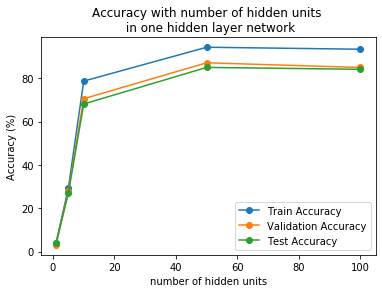

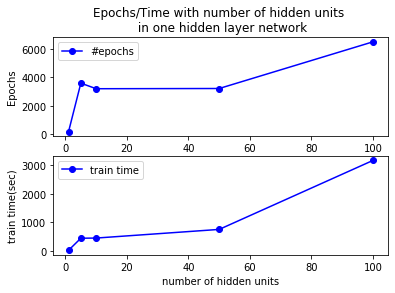

In [128]:
print("------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------")
plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part C - Adaptive Learning rate

In [148]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr0=1.5

for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr0, 'sigmoid', 'adaptive')
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2479418258665325
learning rate for this epoch =  1.5
Error on this batch = 3.247809451893464
Error on this batch = 0.5349662963075191
Cost on val dataset after 2 epochs is = 0.5008921483347141
Initial Cost on Val dataset for this epoch 2 = 0.5008921483347141
learning rate for this epoch =  1.0606601717798212
Error on this batch = 0.5007605921772357
Error on this batch = 0.49207584269681676
Cost on val dataset after 3 epochs is = 0.48839728267851146
Initial Cost on Val dataset for this epoch 3 = 0.48839728267851146
learning rate for this epoch =  0.8660254037844387
Error on this batch = 0.4882605163906773
Error on this batch = 0.4862027556292402
Cost on val dataset after 4 epochs is = 0.4849998814431299
Initial Cost on Val dataset for this epoch 4 = 

Cost on val dataset after 33 epochs is = 0.4808911222416556
Initial Cost on Val dataset for this epoch 33 = 0.4808911222416556
learning rate for this epoch =  0.26111648393354675
Error on this batch = 0.48067363830194126
Error on this batch = 0.4808560822285384
Cost on val dataset after 34 epochs is = 0.48088825288876785
Initial Cost on Val dataset for this epoch 34 = 0.48088825288876785
learning rate for this epoch =  0.25724787771376323
Error on this batch = 0.48066967581222997
Error on this batch = 0.4808532426199993
Cost on val dataset after 35 epochs is = 0.4808856913943333
Initial Cost on Val dataset for this epoch 35 = 0.4808856913943333
learning rate for this epoch =  0.253546276418555
Error on this batch = 0.4806660588978219
Error on this batch = 0.48085069469736014
Cost on val dataset after 36 epochs is = 0.48088340113555084
Initial Cost on Val dataset for this epoch 36 = 0.48088340113555084
learning rate for this epoch =  0.25
Error on this batch = 0.48066274904068623
Error 

Error on this batch = 0.4808444406244492
Cost on val dataset after 12 epochs is = 0.48089193467056435
Initial Cost on Val dataset for this epoch 12 = 0.48089193467056435
learning rate for this epoch =  0.43301270189221935
Error on this batch = 0.4806661186829975
Error on this batch = 0.4808440609236804
Cost on val dataset after 13 epochs is = 0.48089165954161617
Initial Cost on Val dataset for this epoch 13 = 0.48089165954161617
learning rate for this epoch =  0.41602514716892186
Error on this batch = 0.480664578367723
Error on this batch = 0.4808436963911685
Cost on val dataset after 14 epochs is = 0.4808913771369984
Initial Cost on Val dataset for this epoch 14 = 0.4808913771369984
learning rate for this epoch =  0.4008918628686366
Error on this batch = 0.48066324674506955
Error on this batch = 0.4808433473022315
Cost on val dataset after 15 epochs is = 0.48089109339300445
Initial Cost on Val dataset for this epoch 15 = 0.48089109339300445
learning rate for this epoch =  0.3872983346

Cost on val dataset after 28 epochs is = 0.48094933763420433
Initial Cost on Val dataset for this epoch 28 = 0.48094933763420433
learning rate for this epoch =  0.2834733547569204
Error on this batch = 0.48074211149745766
Error on this batch = 0.48089619650961385
Cost on val dataset after 29 epochs is = 0.48094837090629566
Initial Cost on Val dataset for this epoch 29 = 0.48094837090629566
learning rate for this epoch =  0.2785430072655778
Error on this batch = 0.480740702139411
Error on this batch = 0.48089531650995626
Cost on val dataset after 30 epochs is = 0.48094744147565305
Initial Cost on Val dataset for this epoch 30 = 0.48094744147565305
learning rate for this epoch =  0.27386127875258304
Error on this batch = 0.4807393490539319
Error on this batch = 0.48089447134315466
Cost on val dataset after 31 epochs is = 0.4809465467976805
Initial Cost on Val dataset for this epoch 31 = 0.4809465467976805
learning rate for this epoch =  0.26940795304016235
Error on this batch = 0.4807380

Cost on val dataset after 21 epochs is = 0.4482078887646771
Initial Cost on Val dataset for this epoch 21 = 0.4482078887646771
learning rate for this epoch =  0.3273268353539886
Error on this batch = 0.44402277370722315
Error on this batch = 0.4438021453653539
Cost on val dataset after 22 epochs is = 0.4430169597976988
Initial Cost on Val dataset for this epoch 22 = 0.4430169597976988
learning rate for this epoch =  0.31980107453341566
Error on this batch = 0.43928612236102027
Error on this batch = 0.4370062403504224
Cost on val dataset after 23 epochs is = 0.43705994486168503
Initial Cost on Val dataset for this epoch 23 = 0.43705994486168503
learning rate for this epoch =  0.3127716210856122
Error on this batch = 0.4340003204283488
Error on this batch = 0.42910473445750413
Cost on val dataset after 24 epochs is = 0.43032681047920074
Initial Cost on Val dataset for this epoch 24 = 0.43032681047920074
learning rate for this epoch =  0.3061862178478973
Error on this batch = 0.4277982657

Cost on val dataset after 53 epochs is = 0.2703008802690402
Initial Cost on Val dataset for this epoch 53 = 0.2703008802690402
learning rate for this epoch =  0.20604084592303354
Error on this batch = 0.2641651644722687
Error on this batch = 0.25179366481707227
Cost on val dataset after 54 epochs is = 0.2664291058948692
Initial Cost on Val dataset for this epoch 54 = 0.2664291058948692
learning rate for this epoch =  0.2041241452319315
Error on this batch = 0.2603035044796948
Error on this batch = 0.24766598732892245
Cost on val dataset after 55 epochs is = 0.2626530461889949
Initial Cost on Val dataset for this epoch 55 = 0.2626530461889949
learning rate for this epoch =  0.20225995873897262
Error on this batch = 0.25652422295041505
Error on this batch = 0.24364247996040508
Cost on val dataset after 56 epochs is = 0.2589718908855484
Initial Cost on Val dataset for this epoch 56 = 0.2589718908855484
learning rate for this epoch =  0.2004459314343183
Error on this batch = 0.252827864121

Cost on val dataset after 85 epochs is = 0.19075606823946034
Initial Cost on Val dataset for this epoch 85 = 0.19075606823946034
learning rate for this epoch =  0.16269784336399212
Error on this batch = 0.17987250457148732
Error on this batch = 0.168395116544756
Cost on val dataset after 86 epochs is = 0.18943403150836616
Initial Cost on Val dataset for this epoch 86 = 0.18943403150836616
learning rate for this epoch =  0.1617491598051576
Error on this batch = 0.17831848195317584
Error on this batch = 0.1669440447375343
Cost on val dataset after 87 epochs is = 0.1881548489861258
Initial Cost on Val dataset for this epoch 87 = 0.1881548489861258
learning rate for this epoch =  0.1608168802256692
Error on this batch = 0.17680961205015092
Error on this batch = 0.16553317364116857
Cost on val dataset after 88 epochs is = 0.18691648584114226
Initial Cost on Val dataset for this epoch 88 = 0.18691648584114226
learning rate for this epoch =  0.15990053726670783
Error on this batch = 0.1753443

Cost on val dataset after 117 epochs is = 0.16260709451589275
Initial Cost on Val dataset for this epoch 117 = 0.16260709451589275
learning rate for this epoch =  0.13867504905630726
Error on this batch = 0.14629448679731272
Error on this batch = 0.13552408923597165
Cost on val dataset after 118 epochs is = 0.16203015036599724
Initial Cost on Val dataset for this epoch 118 = 0.16203015036599724
learning rate for this epoch =  0.1380861926847485
Error on this batch = 0.145611970368293
Error on this batch = 0.13479681434486135
Cost on val dataset after 119 epochs is = 0.16146465835518264
Initial Cost on Val dataset for this epoch 119 = 0.16146465835518264
learning rate for this epoch =  0.1375047745542317
Error on this batch = 0.14494378029562238
Error on this batch = 0.13408154462173627
Cost on val dataset after 120 epochs is = 0.16091024707598184
Initial Cost on Val dataset for this epoch 120 = 0.16091024707598184
learning rate for this epoch =  0.13693063937629152
Error on this batch 

Cost on val dataset after 149 epochs is = 0.14843346560667733
Initial Cost on Val dataset for this epoch 149 = 0.14843346560667733
learning rate for this epoch =  0.12288478807785608
Error on this batch = 0.1297445897464567
Error on this batch = 0.11696285577931931
Cost on val dataset after 150 epochs is = 0.14809659635324196
Initial Cost on Val dataset for this epoch 150 = 0.14809659635324196
learning rate for this epoch =  0.12247448713915891
Error on this batch = 0.12935475259390689
Error on this batch = 0.11650600787436094
Cost on val dataset after 151 epochs is = 0.14776443973157652
Initial Cost on Val dataset for this epoch 151 = 0.14776443973157652
learning rate for this epoch =  0.12206826881567391
Error on this batch = 0.12897033892844392
Error on this batch = 0.1160549738244812
Cost on val dataset after 152 epochs is = 0.14743688767056395
Initial Cost on Val dataset for this epoch 152 = 0.14743688767056395
learning rate for this epoch =  0.12166606584807191
Error on this batc

Cost on val dataset after 181 epochs is = 0.1395570316018587
Initial Cost on Val dataset for this epoch 181 = 0.1395570316018587
learning rate for this epoch =  0.11149412193707495
Error on this batch = 0.11939687457200827
Error on this batch = 0.10475184566309931
Cost on val dataset after 182 epochs is = 0.13933065168203007
Initial Cost on Val dataset for this epoch 182 = 0.13933065168203007
learning rate for this epoch =  0.11118739749916517
Error on this batch = 0.11912873915306234
Error on this batch = 0.10443616146287905
Cost on val dataset after 183 epochs is = 0.13910673747283384
Initial Cost on Val dataset for this epoch 183 = 0.13910673747283384
learning rate for this epoch =  0.11088319064318593
Error on this batch = 0.1188631901601816
Error on this batch = 0.10412371326638666
Cost on val dataset after 184 epochs is = 0.13888524586703596
Initial Cost on Val dataset for this epoch 184 = 0.13888524586703596
learning rate for this epoch =  0.11058146711617285
Error on this batch

Cost on val dataset after 213 epochs is = 0.1333541367322799
Initial Cost on Val dataset for this epoch 213 = 0.1333541367322799
learning rate for this epoch =  0.10277830647412975
Error on this batch = 0.11189545918479801
Error on this batch = 0.09602149699714499
Cost on val dataset after 214 epochs is = 0.13318950469617202
Initial Cost on Val dataset for this epoch 214 = 0.13318950469617202
learning rate for this epoch =  0.10253788905369948
Error on this batch = 0.11169105763792377
Error on this batch = 0.09578724601704351
Cost on val dataset after 215 epochs is = 0.13302635101406088
Initial Cost on Val dataset for this epoch 215 = 0.13302635101406088
learning rate for this epoch =  0.10229915092057103
Error on this batch = 0.11148817226101113
Error on this batch = 0.09555495097670381
Cost on val dataset after 216 epochs is = 0.13286465437909387
Initial Cost on Val dataset for this epoch 216 = 0.13286465437909387
learning rate for this epoch =  0.10206207261596575
Error on this batc

Cost on val dataset after 245 epochs is = 0.12872656129258805
Initial Cost on Val dataset for this epoch 245 = 0.12872656129258805
learning rate for this epoch =  0.09583148474999098
Error on this batch = 0.10601653037897478
Error on this batch = 0.08937405011751529
Cost on val dataset after 246 epochs is = 0.12860040679882517
Initial Cost on Val dataset for this epoch 246 = 0.12860040679882517
learning rate for this epoch =  0.09563650695950074
Error on this batch = 0.10585211223196173
Error on this batch = 0.08919079867278118
Cost on val dataset after 247 epochs is = 0.12847521265974254
Initial Cost on Val dataset for this epoch 247 = 0.12847521265974254
learning rate for this epoch =  0.09544271444636666
Error on this batch = 0.10568871541795492
Error on this batch = 0.08900882297911686
Cost on val dataset after 248 epochs is = 0.12835096696099113
Initial Cost on Val dataset for this epoch 248 = 0.12835096696099113
learning rate for this epoch =  0.09525009525014287
Error on this ba

Cost on val dataset after 277 epochs is = 0.12511327935209876
Initial Cost on Val dataset for this epoch 277 = 0.12511327935209876
learning rate for this epoch =  0.09012626521891645
Error on this batch = 0.1012130278027642
Error on this batch = 0.08407325040983031
Cost on val dataset after 278 epochs is = 0.12501280533517312
Initial Cost on Val dataset for this epoch 278 = 0.12501280533517312
learning rate for this epoch =  0.08996402158561008
Error on this batch = 0.10107661792069003
Error on this batch = 0.08392414947061803
Cost on val dataset after 279 epochs is = 0.1249129919965163
Initial Cost on Val dataset for this epoch 279 = 0.1249129919965163
learning rate for this epoch =  0.08980265101338744
Error on this batch = 0.10094095119440927
Error on this batch = 0.08377592750837697
Cost on val dataset after 280 epochs is = 0.12481383217299397
Initial Cost on Val dataset for this epoch 280 = 0.12481383217299397
learning rate for this epoch =  0.08964214570007951
Error on this batch

Cost on val dataset after 309 epochs is = 0.12219373698863945
Initial Cost on Val dataset for this epoch 309 = 0.12219373698863945
learning rate for this epoch =  0.08533201859828614
Error on this batch = 0.09718588063311198
Error on this batch = 0.07969515737481421
Cost on val dataset after 310 epochs is = 0.12211131562302446
Initial Cost on Val dataset for this epoch 310 = 0.12211131562302446
learning rate for this epoch =  0.08519427513705972
Error on this batch = 0.09707028707883827
Error on this batch = 0.0795700563612573
Cost on val dataset after 311 epochs is = 0.12202936999495462
Initial Cost on Val dataset for this epoch 311 = 0.12202936999495462
learning rate for this epoch =  0.08505719656856141
Error on this batch = 0.09695525745201806
Error on this batch = 0.07944558714037943
Cost on val dataset after 312 epochs is = 0.12194789554419941
Initial Cost on Val dataset for this epoch 312 = 0.12194789554419941
learning rate for this epoch =  0.08492077756084468
Error on this bat

Error on this batch = 0.07608582654513653
Cost on val dataset after 341 epochs is = 0.11977157703049049
Initial Cost on Val dataset for this epoch 341 = 0.11977157703049049
learning rate for this epoch =  0.08122955416108235
Error on this batch = 0.09374558598078668
Error on this batch = 0.07597781301586111
Cost on val dataset after 342 epochs is = 0.11970238315091489
Initial Cost on Val dataset for this epoch 342 = 0.11970238315091489
learning rate for this epoch =  0.08111071056538127
Error on this batch = 0.09364599606715977
Error on this batch = 0.0758702757157674
Cost on val dataset after 343 epochs is = 0.1196335445578167
Initial Cost on Val dataset for this epoch 343 = 0.1196335445578167
learning rate for this epoch =  0.08099238707340582
Error on this batch = 0.09354684558371909
Error on this batch = 0.07576321060672264
Cost on val dataset after 344 epochs is = 0.11956505820148774
Initial Cost on Val dataset for this epoch 344 = 0.11956505820148774
learning rate for this epoch 

Error on this batch = 0.07284729843637666
Cost on val dataset after 373 epochs is = 0.11771966223248867
Initial Cost on Val dataset for this epoch 373 = 0.11771966223248867
learning rate for this epoch =  0.07766705596177466
Error on this batch = 0.09076158042997816
Error on this batch = 0.07275275389543646
Cost on val dataset after 374 epochs is = 0.11766048577554049
Initial Cost on Val dataset for this epoch 374 = 0.11766048577554049
learning rate for this epoch =  0.07756315349925287
Error on this batch = 0.09067458225050891
Error on this batch = 0.07265857877156866
Cost on val dataset after 375 epochs is = 0.11760158250421851
Initial Cost on Val dataset for this epoch 375 = 0.11760158250421851
learning rate for this epoch =  0.07745966692414834
Error on this batch = 0.09058793343631746
Error on this batch = 0.0725647703681374
Cost on val dataset after 376 epochs is = 0.11754295029502741
Initial Cost on Val dataset for this epoch 376 = 0.11754295029502741
learning rate for this epoc

Error on this batch = 0.0699928257954061
Cost on val dataset after 405 epochs is = 0.11595174352703103
Initial Cost on Val dataset for this epoch 405 = 0.11595174352703103
learning rate for this epoch =  0.07453559924999299
Error on this batch = 0.08813978742616314
Error on this batch = 0.06990891307526359
Cost on val dataset after 406 epochs is = 0.11590035848756279
Initial Cost on Val dataset for this epoch 406 = 0.11590035848756279
learning rate for this epoch =  0.07444375004781977
Error on this batch = 0.08806288182305505
Error on this batch = 0.06982529774310749
Cost on val dataset after 407 epochs is = 0.11584918860939206
Initial Cost on Val dataset for this epoch 407 = 0.11584918860939206
learning rate for this epoch =  0.07435223956449145
Error on this batch = 0.08798625874846057
Error on this batch = 0.06974197795617083
Cost on val dataset after 408 epochs is = 0.11579823236724482
Initial Cost on Val dataset for this epoch 408 = 0.11579823236724482
learning rate for this epoc

Error on this batch = 0.06744667774351945
Cost on val dataset after 437 epochs is = 0.11440708448198954
Initial Cost on Val dataset for this epoch 437 = 0.11440708448198954
learning rate for this epoch =  0.07175473098524097
Error on this batch = 0.08581055275670117
Error on this batch = 0.0673714610620601
Cost on val dataset after 438 epochs is = 0.11436189677324034
Initial Cost on Val dataset for this epoch 438 = 0.11436189677324034
learning rate for this epoch =  0.07167277238512448
Error on this batch = 0.08574186793267634
Error on this batch = 0.06729649181043984
Cost on val dataset after 439 epochs is = 0.11431688207678668
Initial Cost on Val dataset for this epoch 439 = 0.11431688207678668
learning rate for this epoch =  0.07159109398550215
Error on this batch = 0.08567341507168091
Error on this batch = 0.06722176868361548
Cost on val dataset after 440 epochs is = 0.1142720392710736
Initial Cost on Val dataset for this epoch 440 = 0.1142720392710736
learning rate for this epoch 

Error on this batch = 0.06515642728994013
Cost on val dataset after 469 epochs is = 0.11304167967364874
Initial Cost on Val dataset for this epoch 469 = 0.11304167967364874
learning rate for this epoch =  0.06926356448094152
Error on this batch = 0.08372126658888021
Error on this batch = 0.0650885391375562
Cost on val dataset after 470 epochs is = 0.11300151959116525
Initial Cost on Val dataset for this epoch 470 = 0.11300151959116525
learning rate for this epoch =  0.06918984060216637
Error on this batch = 0.08365937571407077
Error on this batch = 0.06502086223628298
Cost on val dataset after 471 epochs is = 0.11296150124637988
Initial Cost on Val dataset for this epoch 471 = 0.11296150124637988
learning rate for this epoch =  0.0691163516376137
Error on this batch = 0.08359767793975395
Error on this batch = 0.0649533956136819
Cost on val dataset after 472 epochs is = 0.11292162379849077
Initial Cost on Val dataset for this epoch 472 = 0.11292162379849077
learning rate for this epoch 

Error on this batch = 0.06308423030307914
Cost on val dataset after 501 epochs is = 0.1118229354994522
Initial Cost on Val dataset for this epoch 501 = 0.1118229354994522
learning rate for this epoch =  0.06701505774131554
Error on this batch = 0.08183154900456835
Error on this batch = 0.06302265580805445
Cost on val dataset after 502 epochs is = 0.11178692746874905
Initial Cost on Val dataset for this epoch 502 = 0.11178692746874905
learning rate for this epoch =  0.06694827640161777
Error on this batch = 0.0817753487577128
Error on this batch = 0.06296126490889367
Cost on val dataset after 503 epochs is = 0.1117510375244474
Initial Cost on Val dataset for this epoch 503 = 0.1117510375244474
learning rate for this epoch =  0.06688169431015648
Error on this batch = 0.08171931136105476
Error on this batch = 0.0629000568404716
Cost on val dataset after 504 epochs is = 0.11171526502403141
Initial Cost on Val dataset for this epoch 504 = 0.11171526502403141
learning rate for this epoch =  

Error on this batch = 0.061201286663170505
Cost on val dataset after 533 epochs is = 0.11072623793094645
Initial Cost on Val dataset for this epoch 533 = 0.11072623793094645
learning rate for this epoch =  0.0649722122736315
Error on this batch = 0.08011000033306746
Error on this batch = 0.06114523095570566
Cost on val dataset after 534 epochs is = 0.11069371377274184
Initial Cost on Val dataset for this epoch 534 = 0.11069371377274184
learning rate for this epoch =  0.06491134836118731
Error on this batch = 0.08005862748389111
Error on this batch = 0.061089336609190144
Cost on val dataset after 535 epochs is = 0.11066128945451563
Initial Cost on Val dataset for this epoch 535 = 0.11066128945451563
learning rate for this epoch =  0.06485065517506754
Error on this batch = 0.08000739368003089
Error on this batch = 0.06103360299473382
Cost on val dataset after 536 epochs is = 0.11062896447491329
Initial Cost on Val dataset for this epoch 536 = 0.11062896447491329
learning rate for this ep

Cost on val dataset after 564 epochs is = 0.10976227118002789
Initial Cost on Val dataset for this epoch 564 = 0.10976227118002789
learning rate for this epoch =  0.06316139407998893
Error on this batch = 0.07857927831098319
Error on this batch = 0.05948453911654955
Cost on val dataset after 565 epochs is = 0.10973262442104081
Initial Cost on Val dataset for this epoch 565 = 0.10973262442104081
learning rate for this epoch =  0.06310547428675069
Error on this batch = 0.07853192942176734
Error on this batch = 0.059433351237659436
Cost on val dataset after 566 epochs is = 0.10970306352102625
Initial Cost on Val dataset for this epoch 566 = 0.10970306352102625
learning rate for this epoch =  0.06304970275637979
Error on this batch = 0.07848470116237749
Error on this batch = 0.059382306174955074
Cost on val dataset after 567 epochs is = 0.1096735880773812
Initial Cost on Val dataset for this epoch 567 = 0.1096735880773812
learning rate for this epoch =  0.06299407883487121
Error on this ba

Error on this batch = 0.05796181115260442
Cost on val dataset after 596 epochs is = 0.10885425622266322
Initial Cost on Val dataset for this epoch 596 = 0.10885425622266322
learning rate for this epoch =  0.06144239403892804
Error on this batch = 0.07712143262850372
Error on this batch = 0.05791481420740524
Cost on val dataset after 597 epochs is = 0.10882716978308192
Initial Cost on Val dataset for this epoch 597 = 0.10882716978308192
learning rate for this epoch =  0.06139091318025436
Error on this batch = 0.07707769690288316
Error on this batch = 0.05786794470119234
Cost on val dataset after 598 epochs is = 0.10880015754028248
Initial Cost on Val dataset for this epoch 598 = 0.10880015754028248
learning rate for this epoch =  0.061339561508214804
Error on this batch = 0.07703406641957354
Error on this batch = 0.05782120217313744
Cost on val dataset after 599 epochs is = 0.10877321916657641
Initial Cost on Val dataset for this epoch 599 = 0.10877321916657641
learning rate for this ep

Error on this batch = 0.05651890179394564
Cost on val dataset after 628 epochs is = 0.10802273509933338
Initial Cost on Val dataset for this epoch 628 = 0.10802273509933338
learning rate for this epoch =  0.05985651633507166
Error on this batch = 0.07577203781434229
Error on this batch = 0.056475763694233336
Cost on val dataset after 629 epochs is = 0.10799786976727407
Initial Cost on Val dataset for this epoch 629 = 0.10799786976727407
learning rate for this epoch =  0.059808916712167495
Error on this batch = 0.07573146794906875
Error on this batch = 0.05643273920263665
Cost on val dataset after 630 epochs is = 0.10797306905958318
Initial Cost on Val dataset for this epoch 630 = 0.10797306905958318
learning rate for this epoch =  0.05976143046671969
Error on this batch = 0.07569099071217605
Error on this batch = 0.056389827914709145
Cost on val dataset after 631 epochs is = 0.10794833270494822
Initial Cost on Val dataset for this epoch 631 = 0.10794833270494822
learning rate for this 

Error on this batch = 0.05519287802131279
Cost on val dataset after 660 epochs is = 0.10725780555938451
Initial Cost on Val dataset for this epoch 660 = 0.10725780555938451
learning rate for this epoch =  0.05838742081211422
Error on this batch = 0.07451804178806307
Error on this batch = 0.05515318182096763
Cost on val dataset after 661 epochs is = 0.10723488087727348
Initial Cost on Val dataset for this epoch 661 = 0.10723488087727348
learning rate for this epoch =  0.05834323811883105
Error on this batch = 0.07448026812184792
Error on this batch = 0.05511358697360051
Cost on val dataset after 662 epochs is = 0.10721201284799958
Initial Cost on Val dataset for this epoch 662 = 0.10721201284799958
learning rate for this epoch =  0.05829915557523538
Error on this batch = 0.0744425765640329
Error on this batch = 0.05507409311692661
Cost on val dataset after 663 epochs is = 0.10718920124439935
Initial Cost on Val dataset for this epoch 663 = 0.10718920124439935
learning rate for this epoc

Error on this batch = 0.053971112353741975
Cost on val dataset after 692 epochs is = 0.10655123163303167
Initial Cost on Val dataset for this epoch 692 = 0.10655123163303167
learning rate for this epoch =  0.05702144409522791
Error on this batch = 0.07334857210885418
Error on this batch = 0.05393448500969281
Cost on val dataset after 693 epochs is = 0.10653001301805318
Initial Cost on Val dataset for this epoch 693 = 0.10653001301805318
learning rate for this epoch =  0.05698028822981897
Error on this batch = 0.07331328404146933
Error on this batch = 0.05389794793985678
Cost on val dataset after 694 epochs is = 0.1065088443622577
Initial Cost on Val dataset for this epoch 694 = 0.1065088443622577
learning rate for this epoch =  0.05693922135008425
Error on this batch = 0.07327806917438955
Error on this batch = 0.0538615008138107
Cost on val dataset after 695 epochs is = 0.10648772547444517
Initial Cost on Val dataset for this epoch 695 = 0.10648772547444517
learning rate for this epoch

Cost on val dataset after 724 epochs is = 0.10589610289183597
Initial Cost on Val dataset for this epoch 724 = 0.10589610289183597
learning rate for this epoch =  0.055747060968537474
Error on this batch = 0.07225443310367043
Error on this batch = 0.05280830751856185
Cost on val dataset after 725 epochs is = 0.10587639299235392
Initial Cost on Val dataset for this epoch 725 = 0.10587639299235392
learning rate for this epoch =  0.05570860145311556
Error on this batch = 0.07222136620292062
Error on this batch = 0.05277448947153413
Cost on val dataset after 726 epochs is = 0.10585672741199044
Initial Cost on Val dataset for this epoch 726 = 0.10585672741199044
learning rate for this epoch =  0.05567022142689041
Error on this batch = 0.07218836487992578
Error on this batch = 0.05274075124725091
Cost on val dataset after 727 epochs is = 0.1058371059894727
Initial Cost on Val dataset for this epoch 727 = 0.1058371059894727
learning rate for this epoch =  0.055631920616421304
Error on this ba

Cost on val dataset after 756 epochs is = 0.10528659805354952
Initial Cost on Val dataset for this epoch 756 = 0.10528659805354952
learning rate for this epoch =  0.05455447255899809
Error on this batch = 0.07122776338374001
Error on this batch = 0.05176425200148004
Cost on val dataset after 757 epochs is = 0.10526823041449293
Initial Cost on Val dataset for this epoch 757 = 0.10526823041449293
learning rate for this epoch =  0.05451842731386105
Error on this batch = 0.07119669075505615
Error on this batch = 0.0517328424291023
Cost on val dataset after 758 epochs is = 0.10524990233128978
Initial Cost on Val dataset for this epoch 758 = 0.10524990233128978
learning rate for this epoch =  0.054482453421911096
Error on this batch = 0.07116567714937501
Error on this batch = 0.051701503419878544
Cost on val dataset after 759 epochs is = 0.10523161366747585
Initial Cost on Val dataset for this epoch 759 = 0.10523161366747585
learning rate for this epoch =  0.054446550648047085
Error on this 

Cost on val dataset after 788 epochs is = 0.10471780066675844
Initial Cost on Val dataset for this epoch 788 = 0.10471780066675844
learning rate for this epoch =  0.05343528749093224
Error on this batch = 0.07026180615285148
Error on this batch = 0.050792813095400596
Cost on val dataset after 789 epochs is = 0.10470063443426528
Initial Cost on Val dataset for this epoch 789 = 0.10470063443426528
learning rate for this epoch =  0.05340141408816783
Error on this batch = 0.07023253255299766
Error on this batch = 0.050763529603608186
Cost on val dataset after 790 epochs is = 0.104683503715463
Initial Cost on Val dataset for this epoch 790 = 0.104683503715463
learning rate for this epoch =  0.0533676050223615
Error on this batch = 0.07020331233404135
Error on this batch = 0.050734308325370694
Cost on val dataset after 791 epochs is = 0.10466640839409076
Initial Cost on Val dataset for this epoch 791 = 0.10466640839409076
learning rate for this epoch =  0.05333386009010835
Error on this batc

Cost on val dataset after 819 epochs is = 0.10420165582122824
Initial Cost on Val dataset for this epoch 819 = 0.10420165582122824
learning rate for this epoch =  0.052414241836095915
Error on this batch = 0.06937843726158581
Error on this batch = 0.049912880868431646
Cost on val dataset after 820 epochs is = 0.1041855388666648
Initial Cost on Val dataset for this epoch 820 = 0.1041855388666648
learning rate for this epoch =  0.05238227218271836
Error on this batch = 0.06935074597910555
Error on this batch = 0.04988541616220418
Cost on val dataset after 821 epochs is = 0.1041694540670412
Initial Cost on Val dataset for this epoch 821 = 0.1041694540670412
learning rate for this epoch =  0.052350360956983207
Error on this batch = 0.06932310336253245
Error on this batch = 0.04985800650669313
Cost on val dataset after 822 epochs is = 0.10415340132186968
Initial Cost on Val dataset for this epoch 822 = 0.10415340132186968
learning rate for this epoch =  0.052318507981136686
Error on this ba

Cost on val dataset after 851 epochs is = 0.1037013794534213
Initial Cost on Val dataset for this epoch 851 = 0.1037013794534213
learning rate for this epoch =  0.05141933776432957
Error on this batch = 0.06851577797119328
Error on this batch = 0.04906028031034941
Cost on val dataset after 852 epochs is = 0.1036862437635821
Initial Cost on Val dataset for this epoch 852 = 0.1036862437635821
learning rate for this epoch =  0.051389153237064875
Error on this batch = 0.0684895771841719
Error on this batch = 0.04903447500745542
Cost on val dataset after 853 epochs is = 0.10367113722409763
Initial Cost on Val dataset for this epoch 853 = 0.10367113722409763
learning rate for this epoch =  0.05135902180484255
Error on this batch = 0.06846342085899537
Error on this batch = 0.04900871832612973
Cost on val dataset after 854 epochs is = 0.10365605974761447
Initial Cost on Val dataset for this epoch 854 = 0.10365605974761447
learning rate for this epoch =  0.05132894331218662
Error on this batch 

Cost on val dataset after 883 epochs is = 0.10323107545673584
Initial Cost on Val dataset for this epoch 883 = 0.10323107545673584
learning rate for this epoch =  0.05047901911020484
Error on this batch = 0.06769882140142444
Error on this batch = 0.0482577385880803
Cost on val dataset after 884 epochs is = 0.10321683099567203
Initial Cost on Val dataset for this epoch 884 = 0.10321683099567203
learning rate for this epoch =  0.050450459549723436
Error on this batch = 0.06767398564926869
Error on this batch = 0.04823340153415922
Cost on val dataset after 885 epochs is = 0.10320261306129287
Initial Cost on Val dataset for this epoch 885 = 0.10320261306129287
learning rate for this epoch =  0.050421948408961074
Error on this batch = 0.06764919072229367
Error on this batch = 0.048209107599467844
Cost on val dataset after 886 epochs is = 0.10318842157696483
Initial Cost on Val dataset for this epoch 886 = 0.10318842157696483
learning rate for this epoch =  0.05039348555125469
Error on this 

Cost on val dataset after 915 epochs is = 0.10278804042852904
Initial Cost on Val dataset for this epoch 915 = 0.10278804042852904
learning rate for this epoch =  0.04958847036804647
Error on this batch = 0.06692381863423892
Error on this batch = 0.04749958473159838
Cost on val dataset after 916 epochs is = 0.10277460825951353
Initial Cost on Val dataset for this epoch 916 = 0.10277460825951353
learning rate for this epoch =  0.04956139503413173
Error on this batch = 0.06690023906597674
Error on this batch = 0.04747655301445136
Cost on val dataset after 917 epochs is = 0.10276120030767959
Initial Cost on Val dataset for this epoch 917 = 0.10276120030767959
learning rate for this epoch =  0.04953436400128698
Error on this batch = 0.0668766971556294
Error on this batch = 0.047453559744621024
Cost on val dataset after 918 epochs is = 0.1027478165053464
Initial Cost on Val dataset for this epoch 918 = 0.1027478165053464
learning rate for this epoch =  0.04950737714883372
Error on this batc

Error on this batch = 0.046802899179211564
Cost on val dataset after 947 epochs is = 0.10236989603797572
Initial Cost on Val dataset for this epoch 947 = 0.10236989603797572
learning rate for this epoch =  0.048743450538846204
Error on this batch = 0.06618750536161368
Error on this batch = 0.04678100011007519
Cost on val dataset after 948 epochs is = 0.1023572064800435
Initial Cost on Val dataset for this epoch 948 = 0.1023572064800435
learning rate for this epoch =  0.048717735184622316
Error on this batch = 0.0661650867732938
Error on this batch = 0.04675913564706092
Cost on val dataset after 949 epochs is = 0.10234453909506132
Initial Cost on Val dataset for this epoch 949 = 0.10234453909506132
learning rate for this epoch =  0.04869206048708966
Error on this batch = 0.06614270305849132
Error on this batch = 0.04673730567628527
Cost on val dataset after 950 epochs is = 0.10233189382299714
Initial Cost on Val dataset for this epoch 950 = 0.10233189382299714
learning rate for this epo

Error on this batch = 0.04611874927984786
Cost on val dataset after 979 epochs is = 0.10197453799431318
Initial Cost on Val dataset for this epoch 979 = 0.10197453799431318
learning rate for this epoch =  0.04794020790754448
Error on this batch = 0.06548701297596762
Error on this batch = 0.046097903927199334
Cost on val dataset after 980 epochs is = 0.1019625292614668
Initial Cost on Val dataset for this epoch 980 = 0.1019625292614668
learning rate for this epoch =  0.04791574237499549
Error on this batch = 0.06546567123377446
Error on this batch = 0.04607708981276796
Cost on val dataset after 981 epochs is = 0.10195054088599892
Initial Cost on Val dataset for this epoch 981 = 0.10195054088599892
learning rate for this epoch =  0.04789131426105757
Error on this batch = 0.06544436188948953
Error on this batch = 0.046056306839951676
Cost on val dataset after 982 epochs is = 0.10193857281452909
Initial Cost on Val dataset for this epoch 982 = 0.10193857281452909
learning rate for this epo

Cost on val dataset after 1010 epochs is = 0.10161149949267778
Initial Cost on Val dataset for this epoch 1010 = 0.10161149949267778
learning rate for this epoch =  0.047198758164566444
Error on this batch = 0.06484016267268713
Error on this batch = 0.04546673004991723
Cost on val dataset after 1011 epochs is = 0.10160009786574896
Initial Cost on Val dataset for this epoch 1011 = 0.10160009786574896
learning rate for this epoch =  0.04717540977918292
Error on this batch = 0.06481979229881926
Error on this batch = 0.045446838734086566
Cost on val dataset after 1012 epochs is = 0.10158871502833969
Initial Cost on Val dataset for this epoch 1012 = 0.10158871502833969
learning rate for this epoch =  0.04715209600964486
Error on this batch = 0.06479945216069112
Error on this batch = 0.04542697579433422
Cost on val dataset after 1013 epochs is = 0.10157735093274695
Initial Cost on Val dataset for this epoch 1013 = 0.10157735093274695
learning rate for this epoch =  0.04712881677050212
Error 

Error on this batch = 0.04486293654752154
Cost on val dataset after 1042 epochs is = 0.10125573648094893
Initial Cost on Val dataset for this epoch 1042 = 0.10125573648094893
learning rate for this epoch =  0.04646836581065923
Error on this batch = 0.06420298474133687
Error on this batch = 0.04484388836671529
Cost on val dataset after 1043 epochs is = 0.10124491328797111
Initial Cost on Val dataset for this epoch 1043 = 0.10124491328797111
learning rate for this epoch =  0.04644608416669743
Error on this batch = 0.06418354986198359
Error on this batch = 0.04482486618831831
Cost on val dataset after 1044 epochs is = 0.10123410744016162
Initial Cost on Val dataset for this epoch 1044 = 0.10123410744016162
learning rate for this epoch =  0.04642383454426297
Error on this batch = 0.06416414318095223
Error on this batch = 0.04480586994148984
Cost on val dataset after 1045 epochs is = 0.101223318895008
Initial Cost on Val dataset for this epoch 1045 = 0.101223318895008
learning rate for this

Error on this batch = 0.04426595220245412
Cost on val dataset after 1074 epochs is = 0.10091779200475864
Initial Cost on Val dataset for this epoch 1074 = 0.10091779200475864
learning rate for this epoch =  0.0457708648273015
Error on this batch = 0.06359475795210477
Error on this batch = 0.04424770254794181
Cost on val dataset after 1075 epochs is = 0.10090750350531316
Initial Cost on Val dataset for this epoch 1075 = 0.10090750350531316
learning rate for this epoch =  0.0457495710997814
Error on this batch = 0.06357619590870728
Error on this batch = 0.04422947678492542
Cost on val dataset after 1076 epochs is = 0.10089723106330437
Initial Cost on Val dataset for this epoch 1076 = 0.10089723106330437
learning rate for this epoch =  0.04572830706372692
Error on this batch = 0.06355766018386284
Error on this batch = 0.044211274852295104
Cost on val dataset after 1077 epochs is = 0.1008869746408102
Initial Cost on Val dataset for this epoch 1077 = 0.1008869746408102
learning rate for thi

Error on this batch = 0.04369351984581361
Cost on val dataset after 1106 epochs is = 0.10059634114741947
Initial Cost on Val dataset for this epoch 1106 = 0.10059634114741947
learning rate for this epoch =  0.04510385844931978
Error on this batch = 0.06301355020053231
Error on this batch = 0.043676005707175725
Cost on val dataset after 1107 epochs is = 0.10058654832475589
Initial Cost on Val dataset for this epoch 1107 = 0.10058654832475589
learning rate for this epoch =  0.045083481733371615
Error on this batch = 0.06299580286788531
Error on this batch = 0.04365851363217553
Cost on val dataset after 1108 epochs is = 0.10057677041013827
Initial Cost on Val dataset for this epoch 1108 = 0.10057677041013827
learning rate for this epoch =  0.045063132609458226
Error on this batch = 0.06297808010007545
Error on this batch = 0.043641043567661686
Cost on val dataset after 1109 epochs is = 0.10056700736969149
Initial Cost on Val dataset for this epoch 1109 = 0.10056700736969149
learning rate 

Error on this batch = 0.043143755099972834
Cost on val dataset after 1138 epochs is = 0.10029020134660661
Initial Cost on Val dataset for this epoch 1138 = 0.10029020134660661
learning rate for this epoch =  0.04446518750465642
Error on this batch = 0.06245755999019249
Error on this batch = 0.04312692169351941
Cost on val dataset after 1139 epochs is = 0.10028086934844599
Initial Cost on Val dataset for this epoch 1139 = 0.10028086934844599
learning rate for this epoch =  0.04444566382094698
Error on this batch = 0.06244057288492041
Error on this batch = 0.04311010875392226
Cost on val dataset after 1140 epochs is = 0.10027155123059048
Initial Cost on Val dataset for this epoch 1140 = 0.10027155123059048
learning rate for this epoch =  0.04442616583193192
Error on this batch = 0.06242360869272774
Error on this batch = 0.04309331623451298
Cost on val dataset after 1141 epochs is = 0.10026224696271226
Initial Cost on Val dataset for this epoch 1141 = 0.10026224696271226
learning rate for

Error on this batch = 0.04261501247987295
Cost on val dataset after 1170 epochs is = 0.09999831523304738
Initial Cost on Val dataset for this epoch 1170 = 0.09999831523304738
learning rate for this epoch =  0.04385290096535146
Error on this batch = 0.06192509144685586
Error on this batch = 0.04259881172522473
Cost on val dataset after 1171 epochs is = 0.09998941285808384
Initial Cost on Val dataset for this epoch 1171 = 0.09998941285808384
learning rate for this epoch =  0.04383417241401027
Error on this batch = 0.06190881305865821
Error on this batch = 0.04258263002853083
Cost on val dataset after 1172 epochs is = 0.09998052344194397
Initial Cost on Val dataset for this epoch 1172 = 0.09998052344194397
learning rate for this epoch =  0.04381546783777395
Error on this batch = 0.06189255601609913
Error on this batch = 0.042566467348383465
Cost on val dataset after 1173 epochs is = 0.0999716469573857
Initial Cost on Val dataset for this epoch 1173 = 0.0999716469573857
learning rate for t

Error on this batch = 0.04210584079718517
Cost on val dataset after 1202 epochs is = 0.0997197348234691
Initial Cost on Val dataset for this epoch 1202 = 0.0997197348234691
learning rate for this epoch =  0.043265230840332077
Error on this batch = 0.06141453600488883
Error on this batch = 0.0420902300553003
Cost on val dataset after 1203 epochs is = 0.09971123404769326
Initial Cost on Val dataset for this epoch 1203 = 0.09971123404769326
learning rate for this epoch =  0.0432472448778669
Error on this batch = 0.06139891732343898
Error on this batch = 0.04207463711475078
Cost on val dataset after 1204 epochs is = 0.09970274540133997
Initial Cost on Val dataset for this epoch 1204 = 0.09970274540133997
learning rate for this epoch =  0.04322928132781762
Error on this batch = 0.06138331849268876
Error on this batch = 0.042059061938390124
Cost on val dataset after 1205 epochs is = 0.09969426885982964
Initial Cost on Val dataset for this epoch 1205 = 0.09969426885982964
learning rate for th

Error on this batch = 0.041614946414173605
Cost on val dataset after 1234 epochs is = 0.09945360696551993
Initial Cost on Val dataset for this epoch 1234 = 0.09945360696551993
learning rate for this epoch =  0.0427005706732179
Error on this batch = 0.06092436010485022
Error on this batch = 0.04159988745576861
Cost on val dataset after 1235 epochs is = 0.09944548250760146
Initial Cost on Val dataset for this epoch 1235 = 0.09944548250760146
learning rate for this epoch =  0.04268327949183541
Error on this batch = 0.06090935432818545
Error on this batch = 0.041584845165595845
Cost on val dataset after 1236 epochs is = 0.0994373694288516
Initial Cost on Val dataset for this epoch 1236 = 0.0994373694288516
learning rate for this epoch =  0.04266600929914307
Error on this batch = 0.06089436697351498
Error on this batch = 0.04156981950997493
Cost on val dataset after 1237 epochs is = 0.09942926770697007
Initial Cost on Val dataset for this epoch 1237 = 0.09942926770697007
learning rate for t

Error on this batch = 0.04115572101338259
Cost on val dataset after 1265 epochs is = 0.09920694185000452
Initial Cost on Val dataset for this epoch 1265 = 0.09920694185000452
learning rate for this epoch =  0.042174116783665
Error on this batch = 0.060467553264983404
Error on this batch = 0.0411411635299363
Cost on val dataset after 1266 epochs is = 0.09919916006101795
Initial Cost on Val dataset for this epoch 1266 = 0.09919916006101795
learning rate for this epoch =  0.0421574570489507
Error on this batch = 0.060453098581952906
Error on this batch = 0.04112662171354212
Cost on val dataset after 1267 epochs is = 0.09919138898891547
Initial Cost on Val dataset for this epoch 1267 = 0.09919138898891547
learning rate for this epoch =  0.042140817041573055
Error on this batch = 0.06043866099907434
Error on this batch = 0.04111209553329606
Cost on val dataset after 1268 epochs is = 0.09918362861328045
Initial Cost on Val dataset for this epoch 1268 = 0.09918362861328045
learning rate for t

Error on this batch = 0.04069750197735453
Cost on val dataset after 1297 epochs is = 0.0989631408652801
Initial Cost on Val dataset for this epoch 1297 = 0.0989631408652801
learning rate for this epoch =  0.04165060086052993
Error on this batch = 0.06001328123306822
Error on this batch = 0.04068343090254615
Cost on val dataset after 1298 epochs is = 0.09895569215732077
Initial Cost on Val dataset for this epoch 1298 = 0.09895569215732077
learning rate for this epoch =  0.04163455362400267
Error on this batch = 0.05999935346449656
Error on this batch = 0.04066937454448329
Cost on val dataset after 1299 epochs is = 0.09894825353928241
Initial Cost on Val dataset for this epoch 1299 = 0.09894825353928241
learning rate for this epoch =  0.041618524921339724
Error on this batch = 0.059985441499358604
Error on this batch = 0.04065533287468972
Cost on val dataset after 1300 epochs is = 0.09894082499240289
Initial Cost on Val dataset for this epoch 1300 = 0.09894082499240289
learning rate for 

Error on this batch = 0.040254388318294476
Cost on val dataset after 1329 epochs is = 0.0987296954099806
Initial Cost on Val dataset for this epoch 1329 = 0.0987296954099806
learning rate for this epoch =  0.04114610865363021
Error on this batch = 0.05957523870684786
Error on this batch = 0.040240774393811095
Cost on val dataset after 1330 epochs is = 0.09872256050040557
Initial Cost on Val dataset for this epoch 1330 = 0.09872256050040557
learning rate for this epoch =  0.04113063728303113
Error on this batch = 0.05956179750967561
Error on this batch = 0.04022717430835153
Cost on val dataset after 1331 epochs is = 0.09871543510274906
Initial Cost on Val dataset for this epoch 1331 = 0.09871543510274906
learning rate for this epoch =  0.04111518335151322
Error on this batch = 0.05954837089490129
Error on this batch = 0.04021358803555875
Cost on val dataset after 1332 epochs is = 0.09870831919965443
Initial Cost on Val dataset for this epoch 1332 = 0.09870831919965443
learning rate for 

Cost on val dataset after 1360 epochs is = 0.098512859474792
Initial Cost on Val dataset for this epoch 1360 = 0.098512859474792
learning rate for this epoch =  0.04067446084099803
Error on this batch = 0.059165179401469994
Error on this batch = 0.039825478368298216
Cost on val dataset after 1361 epochs is = 0.09850601153932591
Initial Cost on Val dataset for this epoch 1361 = 0.09850601153932591
learning rate for this epoch =  0.040659515236656986
Error on this batch = 0.05915217350090706
Error on this batch = 0.03981229452267535
Cost on val dataset after 1362 epochs is = 0.09849917259564729
Initial Cost on Val dataset for this epoch 1362 = 0.09849917259564729
learning rate for this epoch =  0.04064458609525536
Error on this batch = 0.05913918107970462
Error on this batch = 0.03979912370273637
Cost on val dataset after 1363 epochs is = 0.09849234262756469
Initial Cost on Val dataset for this epoch 1363 = 0.09849234262756469
learning rate for this epoch =  0.040629673386591486
Error on

Error on this batch = 0.03942272799434934
Cost on val dataset after 1392 epochs is = 0.09829810637637097
Initial Cost on Val dataset for this epoch 1392 = 0.09829810637637097
learning rate for this epoch =  0.0402042200564173
Error on this batch = 0.058755509973173886
Error on this batch = 0.03940993683105594
Cost on val dataset after 1393 epochs is = 0.09829153831410876
Initial Cost on Val dataset for this epoch 1393 = 0.09829153831410876
learning rate for this epoch =  0.04018978666156824
Error on this batch = 0.058742918898572416
Error on this batch = 0.039397157961677705
Cost on val dataset after 1394 epochs is = 0.09828497874199983
Initial Cost on Val dataset for this epoch 1394 = 0.09828497874199983
learning rate for this epoch =  0.04017536880041851
Error on this batch = 0.058730340253981925
Error on this batch = 0.039384391363485
Cost on val dataset after 1395 epochs is = 0.09827842764489096
Initial Cost on Val dataset for this epoch 1395 = 0.09827842764489096
learning rate for

Error on this batch = 0.03901939771464805
Cost on val dataset after 1424 epochs is = 0.09809206539780427
Initial Cost on Val dataset for this epoch 1424 = 0.09809206539780427
learning rate for this epoch =  0.039749920500238504
Error on this batch = 0.05835860908520869
Error on this batch = 0.039006988944359035
Cost on val dataset after 1425 epochs is = 0.0980857616493468
Initial Cost on Val dataset for this epoch 1425 = 0.0980857616493468
learning rate for this epoch =  0.03973597071195132
Error on this batch = 0.058346400719632534
Error on this batch = 0.03899459176666127
Cost on val dataset after 1426 epochs is = 0.098079465920465
Initial Cost on Val dataset for this epoch 1426 = 0.098079465920465
learning rate for this epoch =  0.03972203559992821
Error on this batch = 0.058334203829443994
Error on this batch = 0.038982206160486615
Cost on val dataset after 1427 epochs is = 0.09807317819690918
Initial Cost on Val dataset for this epoch 1427 = 0.09807317819690918
learning rate for t

Error on this batch = 0.03862796428274506
Cost on val dataset after 1456 epochs is = 0.09789425340622428
Initial Cost on Val dataset for this epoch 1456 = 0.09789425340622428
learning rate for this epoch =  0.039310681377071936
Error on this batch = 0.05797349618404368
Error on this batch = 0.038615916271730055
Cost on val dataset after 1457 epochs is = 0.09788819934354308
Initial Cost on Val dataset for this epoch 1457 = 0.09788819934354308
learning rate for this epoch =  0.03929718877966846
Error on this batch = 0.05796164145715743
Error on this batch = 0.038603879203615625
Cost on val dataset after 1458 epochs is = 0.09788215285703675
Initial Cost on Val dataset for this epoch 1458 = 0.09788215285703675
learning rate for this epoch =  0.039283710065919304
Error on this batch = 0.057949797346108785
Error on this batch = 0.03859185305889751
Cost on val dataset after 1459 epochs is = 0.09787611393325135
Initial Cost on Val dataset for this epoch 1459 = 0.09787611393325135
learning rate

Error on this batch = 0.03825947819452563
Cost on val dataset after 1487 epochs is = 0.09771004063127166
Initial Cost on Val dataset for this epoch 1487 = 0.09771004063127166
learning rate for this epoch =  0.03889876156958744
Error on this batch = 0.05761082485435187
Error on this batch = 0.03824776055420558
Cost on val dataset after 1488 epochs is = 0.0977042152765676
Initial Cost on Val dataset for this epoch 1488 = 0.0977042152765676
learning rate for this epoch =  0.03888568855239095
Error on this batch = 0.05759928782861163
Error on this batch = 0.038236053273799475
Cost on val dataset after 1489 epochs is = 0.09769839709149102
Initial Cost on Val dataset for this epoch 1489 = 0.09769839709149102
learning rate for this epoch =  0.03887262870700081
Error on this batch = 0.057587760673911664
Error on this batch = 0.03822435633523222
Cost on val dataset after 1490 epochs is = 0.09769258606327762
Initial Cost on Val dataset for this epoch 1490 = 0.09769258606327762
learning rate for 

Error on this batch = 0.03788956416482253
Cost on val dataset after 1519 epochs is = 0.09752712285285979
Initial Cost on Val dataset for this epoch 1519 = 0.09752712285285979
learning rate for this epoch =  0.038486850434308904
Error on this batch = 0.057246426831332686
Error on this batch = 0.03787816929599953
Cost on val dataset after 1520 epochs is = 0.09752152069783455
Initial Cost on Val dataset for this epoch 1520 = 0.09752152069783455
learning rate for this epoch =  0.03847418820319328
Error on this batch = 0.05723519486889905
Error on this batch = 0.0378667842305394
Cost on val dataset after 1521 epochs is = 0.09751592531417426
Initial Cost on Val dataset for this epoch 1521 = 0.09751592531417426
learning rate for this epoch =  0.038461538461538464
Error on this batch = 0.057223972094639156
Error on this batch = 0.037855408951764515
Cost on val dataset after 1522 epochs is = 0.0975103366897631
Initial Cost on Val dataset for this epoch 1522 = 0.0975103366897631
learning rate fo

Error on this batch = 0.037529709628915386
Cost on val dataset after 1551 epochs is = 0.09735115308706538
Initial Cost on Val dataset for this epoch 1551 = 0.09735115308706538
learning rate for this epoch =  0.03808775370892692
Error on this batch = 0.05689146505516538
Error on this batch = 0.03751862040472899
Cost on val dataset after 1552 epochs is = 0.09734576170149342
Initial Cost on Val dataset for this epoch 1552 = 0.09734576170149342
learning rate for this epoch =  0.03807548119251072
Error on this batch = 0.05688051758961289
Error on this batch = 0.03750754047106047
Cost on val dataset after 1553 epochs is = 0.09734037670905667
Initial Cost on Val dataset for this epoch 1553 = 0.09734037670905667
learning rate for this epoch =  0.038063220531689694
Error on this batch = 0.05686957871140244
Error on this batch = 0.03749646981256761
Cost on val dataset after 1554 epochs is = 0.09733499809824524
Initial Cost on Val dataset for this epoch 1554 = 0.09733499809824524
learning rate fo

Error on this batch = 0.03717938791739644
Cost on val dataset after 1583 epochs is = 0.09718174331726276
Initial Cost on Val dataset for this epoch 1583 = 0.09718174331726276
learning rate for this epoch =  0.03770082046256051
Error on this batch = 0.056545321319050414
Error on this batch = 0.03716858858152013
Cost on val dataset after 1584 epochs is = 0.09717655089438922
Initial Cost on Val dataset for this epoch 1584 = 0.09717655089438922
learning rate for this epoch =  0.037688918072220454
Error on this batch = 0.056534640333133795
Error on this batch = 0.0371577980653064
Cost on val dataset after 1585 epochs is = 0.09717136450544808
Initial Cost on Val dataset for this epoch 1585 = 0.09717136450544808
learning rate for this epoch =  0.037677026947749624
Error on this batch = 0.05652396741100967
Error on this batch = 0.037147016354702876
Cost on val dataset after 1586 epochs is = 0.09716618413951614
Initial Cost on Val dataset for this epoch 1586 = 0.09716618413951614
learning rate 

Error on this batch = 0.03683811544174105
Cost on val dataset after 1615 epochs is = 0.09701852509516856
Initial Cost on Val dataset for this epoch 1615 = 0.09701852509516856
learning rate for this epoch =  0.03732544513450796
Error on this batch = 0.05620745676169268
Error on this batch = 0.036827591560575426
Cost on val dataset after 1616 epochs is = 0.09701352043113878
Initial Cost on Val dataset for this epoch 1616 = 0.09701352043113878
learning rate for this epoch =  0.03731389463287459
Error on this batch = 0.056197026647900515
Error on this batch = 0.036817076068891674
Cost on val dataset after 1617 epochs is = 0.09700852146060698
Initial Cost on Val dataset for this epoch 1617 = 0.09700852146060698
learning rate for this epoch =  0.03730235484764954
Error on this batch = 0.05618660414764595
Error on this batch = 0.03680656895388802
Cost on val dataset after 1618 epochs is = 0.09700352817323994
Initial Cost on Val dataset for this epoch 1618 = 0.09700352817323994
learning rate f

Error on this batch = 0.036505450299304
Cost on val dataset after 1647 epochs is = 0.09686114924629663
Initial Cost on Val dataset for this epoch 1647 = 0.09686114924629663
learning rate for this epoch =  0.03696106354772864
Error on this batch = 0.05587740770939011
Error on this batch = 0.03649518872017989
Cost on val dataset after 1648 epochs is = 0.0968563217426209
Initial Cost on Val dataset for this epoch 1648 = 0.0968563217426209
learning rate for this epoch =  0.036949847931160996
Error on this batch = 0.05586721514649837
Error on this batch = 0.03648493513962819
Cost on val dataset after 1649 epochs is = 0.09685149961118425
Initial Cost on Val dataset for this epoch 1649 = 0.09685149961118425
learning rate for this epoch =  0.03693864251833891
Error on this batch = 0.05585702981629684
Error on this batch = 0.03647468954604535
Cost on val dataset after 1650 epochs is = 0.09684668284226475
Initial Cost on Val dataset for this epoch 1650 = 0.09684668284226475
learning rate for thi

Error on this batch = 0.0361809907920763
Cost on val dataset after 1679 epochs is = 0.09670928624814801
Initial Cost on Val dataset for this epoch 1679 = 0.09670928624814801
learning rate for this epoch =  0.0366071493422535
Error on this batch = 0.055554781614008314
Error on this batch = 0.036170979588566105
Cost on val dataset after 1680 epochs is = 0.09670462593215412
Initial Cost on Val dataset for this epoch 1680 = 0.09670462593215412
learning rate for this epoch =  0.036596252735569997
Error on this batch = 0.05554481543044647
Error on this batch = 0.03616097602984554
Cost on val dataset after 1681 epochs is = 0.09669997068714606
Initial Cost on Val dataset for this epoch 1681 = 0.09669997068714606
learning rate for this epoch =  0.036585365853658534
Error on this batch = 0.05553485616326959
Error on this batch = 0.03615098010542386
Cost on val dataset after 1682 epochs is = 0.09669532050404211
Initial Cost on Val dataset for this epoch 1682 = 0.09669532050404211
learning rate fo

Error on this batch = 0.03586437321847286
Cost on val dataset after 1711 epochs is = 0.0965626270395006
Initial Cost on Val dataset for this epoch 1711 = 0.0965626270395006
learning rate for this epoch =  0.03626321077722928
Error on this batch = 0.055239252039381743
Error on this batch = 0.03585460160329584
Cost on val dataset after 1712 epochs is = 0.09655812459267646
Initial Cost on Val dataset for this epoch 1712 = 0.09655812459267646
learning rate for this epoch =  0.03625261833921238
Error on this batch = 0.05522950303024253
Error on this batch = 0.03584483731285872
Cost on val dataset after 1713 epochs is = 0.09655362693646297
Initial Cost on Val dataset for this epoch 1713 = 0.09655362693646297
learning rate for this epoch =  0.03624203517788945
Error on this batch = 0.055219760678992334
Error on this batch = 0.035835080337655055
Cost on val dataset after 1714 epochs is = 0.09654913406244182
Initial Cost on Val dataset for this epoch 1714 = 0.09654913406244182
learning rate for

Error on this batch = 0.03555526843304336
Cost on val dataset after 1743 epochs is = 0.0964208838828967
Initial Cost on Val dataset for this epoch 1743 = 0.0964208838828967
learning rate for this epoch =  0.03592878785739777
Error on this batch = 0.05493055181236012
Error on this batch = 0.03554572662828738
Cost on val dataset after 1744 epochs is = 0.0964165306640762
Initial Cost on Val dataset for this epoch 1744 = 0.0964165306640762
learning rate for this epoch =  0.03591848569579317
Error on this batch = 0.054921012491004395
Error on this batch = 0.03553619185722345
Cost on val dataset after 1745 epochs is = 0.09641218197687054
Initial Cost on Val dataset for this epoch 1745 = 0.09641218197687054
learning rate for this epoch =  0.03590819239118411
Error on this batch = 0.054911479618024214
Error on this batch = 0.0355266641111632
Cost on val dataset after 1746 epochs is = 0.09640783781353063
Initial Cost on Val dataset for this epoch 1746 = 0.09640783781353063
learning rate for thi

Error on this batch = 0.035253377074819514
Cost on val dataset after 1775 epochs is = 0.09628379086863577
Initial Cost on Val dataset for this epoch 1775 = 0.09628379086863577
learning rate for this epoch =  0.0356034497458156
Error on this batch = 0.054628464093230876
Error on this batch = 0.03524405614445844
Cost on val dataset after 1776 epochs is = 0.09627957892012641
Initial Cost on Val dataset for this epoch 1776 = 0.09627957892012641
learning rate for this epoch =  0.035593424840718715
Error on this batch = 0.05461912838264411
Error on this batch = 0.03523474198008126
Cost on val dataset after 1777 epochs is = 0.09627537126544007
Initial Cost on Val dataset for this epoch 1777 = 0.09627537126544007
learning rate for this epoch =  0.03558340839902869
Error on this batch = 0.0546097989495401
Error on this batch = 0.035225434573633585
Cost on val dataset after 1778 epochs is = 0.09627116789747903
Initial Cost on Val dataset for this epoch 1778 = 0.09627116789747903
learning rate fo

Error on this batch = 0.0349584238528212
Cost on val dataset after 1807 epochs is = 0.09615110375031223
Initial Cost on Val dataset for this epoch 1807 = 0.09615110375031223
learning rate for this epoch =  0.035286792429716024
Error on this batch = 0.05433281189360787
Error on this batch = 0.034949315516416245
Cost on val dataset after 1808 epochs is = 0.09614702578017695
Initial Cost on Val dataset for this epoch 1808 = 0.09614702578017695
learning rate for this epoch =  0.0352770325643849
Error on this batch = 0.05432367478472054
Error on this batch = 0.0349402136957759
Cost on val dataset after 1809 epochs is = 0.09614295188632231
Initial Cost on Val dataset for this epoch 1809 = 0.09614295188632231
learning rate for this epoch =  0.035267280792929914
Error on this batch = 0.054314543810240964
Error on this batch = 0.034931118383302664
Cost on val dataset after 1810 epochs is = 0.09613888206226008
Initial Cost on Val dataset for this epoch 1810 = 0.09613888206226008
learning rate fo

Error on this batch = 0.03467015161640244
Cost on val dataset after 1839 epochs is = 0.09602259900052776
Initial Cost on Val dataset for this epoch 1839 = 0.09602259900052776
learning rate for this epoch =  0.034978436610752964
Error on this batch = 0.05404344711293888
Error on this batch = 0.03466124806922179
Cost on val dataset after 1840 epochs is = 0.09601864834111362
Initial Cost on Val dataset for this epoch 1840 = 0.09601864834111362
learning rate for this epoch =  0.03496893030901177
Error on this batch = 0.054034504327632356
Error on this batch = 0.034652350799821756
Cost on val dataset after 1841 epochs is = 0.09601470155906174
Initial Cost on Val dataset for this epoch 1841 = 0.09601470155906174
learning rate for this epoch =  0.03495943175381576
Error on this batch = 0.05402556755142485
Error on this batch = 0.03464345980091439
Cost on val dataset after 1842 epochs is = 0.0960107586484343
Initial Cost on Val dataset for this epoch 1842 = 0.0960107586484343
learning rate for

Error on this batch = 0.034388315996424904
Cost on val dataset after 1871 epochs is = 0.09589807218610888
Initial Cost on Val dataset for this epoch 1871 = 0.09589807218610888
learning rate for this epoch =  0.03467802579457323
Error on this batch = 0.05376024028466514
Error on this batch = 0.0343796097583957
Cost on val dataset after 1872 epochs is = 0.0958942427347453
Initial Cost on Val dataset for this epoch 1872 = 0.0958942427347453
learning rate for this epoch =  0.034668762264076815
Error on this batch = 0.05375148797802784
Error on this batch = 0.03437090956831752
Cost on val dataset after 1873 epochs is = 0.09589041697840331
Initial Cost on Val dataset for this epoch 1873 = 0.09589041697840331
learning rate for this epoch =  0.034659506153308706
Error on this batch = 0.053742741564556676
Error on this batch = 0.034362215419106716
Cost on val dataset after 1874 epochs is = 0.09588659491162804
Initial Cost on Val dataset for this epoch 1874 = 0.09588659491162804
learning rate fo

Cost on val dataset after 1902 epochs is = 0.0957810532882325
Initial Cost on Val dataset for this epoch 1902 = 0.0957810532882325
learning rate for this epoch =  0.034394262598354146
Error on this batch = 0.05349164322114344
Error on this batch = 0.03411268120457591
Cost on val dataset after 1903 epochs is = 0.09577733590684374
Initial Cost on Val dataset for this epoch 1903 = 0.09577733590684374
learning rate for this epoch =  0.034385224557835894
Error on this batch = 0.05348307196126996
Error on this batch = 0.03410416501143066
Cost on val dataset after 1904 epochs is = 0.09577362205758776
Initial Cost on Val dataset for this epoch 1904 = 0.09577362205758776
learning rate for this epoch =  0.03437619363855793
Error on this batch = 0.05347450648525088
Error on this batch = 0.03409565464189546
Cost on val dataset after 1905 epochs is = 0.09576991173541333
Initial Cost on Val dataset for this epoch 1905 = 0.09576991173541333
learning rate for this epoch =  0.034367169831173536
Error o

Cost on val dataset after 1934 epochs is = 0.09566382438837377
Initial Cost on Val dataset for this epoch 1934 = 0.09566382438837377
learning rate for this epoch =  0.03410853168660189
Error on this batch = 0.05322021414883294
Error on this batch = 0.03384301725293123
Cost on val dataset after 1935 epochs is = 0.09566021758740306
Initial Cost on Val dataset for this epoch 1935 = 0.09566021758740306
learning rate for this epoch =  0.034099716973523674
Error on this batch = 0.05321182621454385
Error on this batch = 0.03383468399236249
Cost on val dataset after 1936 epochs is = 0.09565661416260722
Initial Cost on Val dataset for this epoch 1936 = 0.09565661416260722
learning rate for this epoch =  0.03409090909090909
Error on this batch = 0.05320344395028328
Error on this batch = 0.033826356335237784
Cost on val dataset after 1937 epochs is = 0.09565301410929185
Initial Cost on Val dataset for this epoch 1937 = 0.09565301410929185
learning rate for this epoch =  0.03408210802994123
Error 

Error on this batch = 0.033587261252776716
Cost on val dataset after 1966 epochs is = 0.09555005841608478
Initial Cost on Val dataset for this epoch 1966 = 0.09555005841608478
learning rate for this epoch =  0.03382980561148835
Error on this batch = 0.05295459458459947
Error on this batch = 0.03357909854620838
Cost on val dataset after 1967 epochs is = 0.09554655737359348
Initial Cost on Val dataset for this epoch 1967 = 0.09554655737359348
learning rate for this epoch =  0.0338212051777377
Error on this batch = 0.0529463862858561
Error on this batch = 0.03357094123356099
Cost on val dataset after 1968 epochs is = 0.09554305956192437
Initial Cost on Val dataset for this epoch 1968 = 0.09554305956192437
learning rate for this epoch =  0.03381261130002871
Error on this batch = 0.052938183539971526
Error on this batch = 0.033562789308141376
Cost on val dataset after 1969 epochs is = 0.09553956497668938
Initial Cost on Val dataset for this epoch 1969 = 0.09553956497668938
learning rate for

Error on this batch = 0.03332869699025802
Cost on val dataset after 1998 epochs is = 0.09543960609102893
Initial Cost on Val dataset for this epoch 1998 = 0.09543960609102893
learning rate for this epoch =  0.033557802760701215
Error on this batch = 0.052694664592362106
Error on this batch = 0.03332070359178552
Cost on val dataset after 1999 epochs is = 0.09543620630107869
Initial Cost on Val dataset for this epoch 1999 = 0.09543620630107869
learning rate for this epoch =  0.033549408063193835
Error on this batch = 0.052686632114162676
Error on this batch = 0.033312715375335374
Cost on val dataset after 2000 epochs is = 0.09543280960575798
Initial Cost on Val dataset for this epoch 2000 = 0.09543280960575798
learning rate for this epoch =  0.03354101966249684
Error on this batch = 0.0526786050673572
Error on this batch = 0.03330473233436689
Cost on val dataset after 2001 epochs is = 0.09542941600094561
Initial Cost on Val dataset for this epoch 2001 = 0.09542941600094561
learning rate 

Error on this batch = 0.03307544627645043
Cost on val dataset after 2030 epochs is = 0.09533232758384429
Initial Cost on Val dataset for this epoch 2030 = 0.09533232758384429
learning rate for this epoch =  0.03329225712138564
Error on this batch = 0.05244029993664176
Error on this batch = 0.033067615485830044
Cost on val dataset after 2031 epochs is = 0.09532902481580811
Initial Cost on Val dataset for this epoch 2031 = 0.09532902481580811
learning rate for this epoch =  0.03328406008639217
Error on this batch = 0.0524324393251558
Error on this batch = 0.03305978967070809
Cost on val dataset after 2032 epochs is = 0.09532572501427859
Initial Cost on Val dataset for this epoch 2032 = 0.09532572501427859
learning rate for this epoch =  0.03327586910310427
Error on this batch = 0.05242458401935213
Error on this batch = 0.03305196882472904
Cost on val dataset after 2033 epochs is = 0.0953224281753727
Initial Cost on Val dataset for this epoch 2033 = 0.0953224281753727
learning rate for th

Error on this batch = 0.032827297535477966
Cost on val dataset after 2062 epochs is = 0.09522809138548279
Initial Cost on Val dataset for this epoch 2062 = 0.09522809138548279
learning rate for this epoch =  0.03303291718644829
Error on this batch = 0.05219137207462146
Error on this batch = 0.03281962284115448
Cost on val dataset after 2063 epochs is = 0.09522488165420002
Initial Cost on Val dataset for this epoch 2063 = 0.09522488165420002
learning rate for this epoch =  0.03302491017695326
Error on this batch = 0.05218367924941127
Error on this batch = 0.03281195292226558
Cost on val dataset after 2064 epochs is = 0.09522167476859664
Initial Cost on Val dataset for this epoch 2064 = 0.09522167476859664
learning rate for this epoch =  0.033016908987210894
Error on this batch = 0.052175991600606146
Error on this batch = 0.0328042877726751
Cost on val dataset after 2065 epochs is = 0.09521847072500811
Initial Cost on Val dataset for this epoch 2065 = 0.09521847072500811
learning rate fo

Error on this batch = 0.03258404576876499
Cost on val dataset after 2094 epochs is = 0.0951267735000352
Initial Cost on Val dataset for this epoch 2094 = 0.0951267735000352
learning rate for this epoch =  0.03277954495314484
Error on this batch = 0.05194774881400531
Error on this batch = 0.03257652088247859
Cost on val dataset after 2095 epochs is = 0.09512365304516923
Initial Cost on Val dataset for this epoch 2095 = 0.09512365304516923
learning rate for this epoch =  0.03277172073893787
Error on this batch = 0.05194021959590359
Error on this batch = 0.03256900057907382
Cost on val dataset after 2096 epochs is = 0.09512053532193183
Initial Cost on Val dataset for this epoch 2096 = 0.09512053532193183
learning rate for this epoch =  0.03276390212478892
Error on this batch = 0.051932695422396535
Error on this batch = 0.03256148485266478
Cost on val dataset after 2097 epochs is = 0.09511742032686407
Initial Cost on Val dataset for this epoch 2097 = 0.09511742032686407
learning rate for t

Error on this batch = 0.03234549362401013
Cost on val dataset after 2126 epochs is = 0.09502825690011293
Initial Cost on Val dataset for this epoch 2126 = 0.09502825690011293
learning rate for this epoch =  0.03253191500488759
Error on this batch = 0.05170929534525233
Error on this batch = 0.032338112512259085
Cost on val dataset after 2127 epochs is = 0.09502522217261312
Initial Cost on Val dataset for this epoch 2127 = 0.09502522217261312
learning rate for this epoch =  0.03252426673512047
Error on this batch = 0.051701925492171646
Error on this batch = 0.03233073579924378
Cost on val dataset after 2128 epochs is = 0.09502219006913502
Initial Cost on Val dataset for this epoch 2128 = 0.09502219006913502
learning rate for this epoch =  0.032516623857154495
Error on this batch = 0.05169456055052478
Error on this batch = 0.03232336347935312
Cost on val dataset after 2129 epochs is = 0.09501916058641724
Initial Cost on Val dataset for this epoch 2129 = 0.09501916058641724
learning rate f

Error on this batch = 0.03211145231353406
Cost on val dataset after 2158 epochs is = 0.0949324311758425
Initial Cost on Val dataset for this epoch 2158 = 0.0949324311758425
learning rate for this epoch =  0.03228981366822132
Error on this batch = 0.05147587543851447
Error on this batch = 0.03210420922298107
Cost on val dataset after 2159 epochs is = 0.09492947882934684
Initial Cost on Val dataset for this epoch 2159 = 0.09492947882934684
learning rate for this epoch =  0.032282334846194374
Error on this batch = 0.05146866068378921
Error on this batch = 0.032096970356103253
Cost on val dataset after 2160 epochs is = 0.09492652900549844
Initial Cost on Val dataset for this epoch 2160 = 0.09492652900549844
learning rate for this epoch =  0.032274861218395144
Error on this batch = 0.0514614507071818
Error on this batch = 0.032089735707581724
Cost on val dataset after 2161 epochs is = 0.0949235817012281
Initial Cost on Val dataset for this epoch 2161 = 0.0949235817012281
learning rate for t

Cost on val dataset after 2189 epochs is = 0.09484206785532683
Initial Cost on Val dataset for this epoch 2189 = 0.09484206785532683
learning rate for this epoch =  0.0320603587901953
Error on this batch = 0.05125442122128261
Error on this batch = 0.031881742314459914
Cost on val dataset after 2190 epochs is = 0.09483919231025623
Initial Cost on Val dataset for this epoch 2190 = 0.09483919231025623
learning rate for this epoch =  0.03205303823780162
Error on this batch = 0.05124735266100932
Error on this batch = 0.031874631789934334
Cost on val dataset after 2191 epochs is = 0.0948363191954286
Initial Cost on Val dataset for this epoch 2191 = 0.0948363191954286
learning rate for this epoch =  0.03204572269776847
Error on this batch = 0.051240288750609944
Error on this batch = 0.03186752532354676
Cost on val dataset after 2192 epochs is = 0.09483344850795683
Initial Cost on Val dataset for this epoch 2192 = 0.09483344850795683
learning rate for this epoch =  0.032038412164378534
Error o

Error on this batch = 0.03166318083767738
Cost on val dataset after 2221 epochs is = 0.09475124170158288
Initial Cost on Val dataset for this epoch 2221 = 0.09475124170158288
learning rate for this epoch =  0.03182855921102615
Error on this batch = 0.051030513310987805
Error on this batch = 0.031656193825453253
Cost on val dataset after 2222 epochs is = 0.09474844252094074
Initial Cost on Val dataset for this epoch 2222 = 0.09474844252094074
learning rate for this epoch =  0.03182139626298652
Error on this batch = 0.05102359151778622
Error on this batch = 0.03164921072027729
Cost on val dataset after 2223 epochs is = 0.0947456456810136
Initial Cost on Val dataset for this epoch 2223 = 0.0947456456810136
learning rate for this epoch =  0.031814238148788886
Error on this batch = 0.05101667424396494
Error on this batch = 0.031642231517428045
Cost on val dataset after 2224 epochs is = 0.09474285117909788
Initial Cost on Val dataset for this epoch 2224 = 0.09474285117909788
learning rate fo

Error on this batch = 0.031441511264472005
Cost on val dataset after 2253 epochs is = 0.0946628157086315
Initial Cost on Val dataset for this epoch 2253 = 0.0946628157086315
learning rate for this epoch =  0.03160171580907009
Error on this batch = 0.05081123761365694
Error on this batch = 0.03143464698288013
Cost on val dataset after 2254 epochs is = 0.09466009011778719
Initial Cost on Val dataset for this epoch 2254 = 0.09466009011778719
learning rate for this epoch =  0.0315947048903351
Error on this batch = 0.050804458451848944
Error on this batch = 0.03142778646193656
Cost on val dataset after 2255 epochs is = 0.09465736678392256
Initial Cost on Val dataset for this epoch 2255 = 0.09465736678392256
learning rate for this epoch =  0.031587698635699595
Error on this batch = 0.05079768368163711
Error on this batch = 0.031420929697221225
Cost on val dataset after 2256 epochs is = 0.09465464570451217
Initial Cost on Val dataset for this epoch 2256 = 0.09465464570451217
learning rate for

Error on this batch = 0.031230447659463638
Cost on val dataset after 2284 epochs is = 0.09457936070622526
Initial Cost on Val dataset for this epoch 2284 = 0.09457936070622526
learning rate for this epoch =  0.03138652314890154
Error on this batch = 0.05060310807363754
Error on this batch = 0.03122369794415457
Cost on val dataset after 2285 epochs is = 0.0945767039316684
Initial Cost on Val dataset for this epoch 2285 = 0.0945767039316684
learning rate for this epoch =  0.0313796544491478
Error on this batch = 0.050596463233189753
Error on this batch = 0.0312169518567544
Cost on val dataset after 2286 epochs is = 0.09457404933830175
Initial Cost on Val dataset for this epoch 2286 = 0.09457404933830175
learning rate for this epoch =  0.03137279025690793
Error on this batch = 0.05058982266370252
Error on this batch = 0.031210209393126884
Cost on val dataset after 2287 epochs is = 0.09457139692376519
Initial Cost on Val dataset for this epoch 2287 = 0.09457139692376519
learning rate for t

Error on this batch = 0.031016236016637225
Cost on val dataset after 2316 epochs is = 0.09449541426948868
Initial Cost on Val dataset for this epoch 2316 = 0.09449541426948868
learning rate for this epoch =  0.03116893630962685
Error on this batch = 0.050392572686721246
Error on this batch = 0.03100960038687144
Cost on val dataset after 2317 epochs is = 0.09449282614782849
Initial Cost on Val dataset for this epoch 2317 = 0.09449282614782849
learning rate for this epoch =  0.031162209442966098
Error on this batch = 0.05038606263320543
Error on this batch = 0.031002968257040135
Cost on val dataset after 2318 epochs is = 0.09449024013436415
Initial Cost on Val dataset for this epoch 2318 = 0.09449024013436415
learning rate for this epoch =  0.031155486929794796
Error on this batch = 0.05037955672977592
Error on this batch = 0.030996339623287572
Cost on val dataset after 2319 epochs is = 0.09448765622689706
Initial Cost on Val dataset for this epoch 2319 = 0.09448765622689706
learning rat

Cost on val dataset after 2347 epochs is = 0.09441615307732958
Initial Cost on Val dataset for this epoch 2347 = 0.09441615307732958
learning rate for this epoch =  0.03096240693768042
Error on this batch = 0.050192674241791836
Error on this batch = 0.030805613010644457
Cost on val dataset after 2348 epochs is = 0.09441362930888698
Initial Cost on Val dataset for this epoch 2348 = 0.09441362930888698
learning rate for this epoch =  0.030955812877987352
Error on this batch = 0.05018629113099678
Error on this batch = 0.030799087508064434
Cost on val dataset after 2349 epochs is = 0.0944111075826943
Initial Cost on Val dataset for this epoch 2349 = 0.0944111075826943
learning rate for this epoch =  0.030949223029508643
Error on this batch = 0.05017991205693337
Error on this batch = 0.03079256538618628
Cost on val dataset after 2350 epochs is = 0.09440858789669847
Initial Cost on Val dataset for this epoch 2350 = 0.09440858789669847
learning rate for this epoch =  0.030942637387763802
Erro

Error on this batch = 0.030604878565356496
Cost on val dataset after 2379 epochs is = 0.09433639541915413
Initial Cost on Val dataset for this epoch 2379 = 0.09433639541915413
learning rate for this epoch =  0.03075346380392736
Error on this batch = 0.04999039922690336
Error on this batch = 0.030598456230254048
Cost on val dataset after 2380 epochs is = 0.09433393600624909
Initial Cost on Val dataset for this epoch 2380 = 0.09433393600624909
learning rate for this epoch =  0.03074700231340454
Error on this batch = 0.04998414352796876
Error on this batch = 0.030592037168183355
Cost on val dataset after 2381 epochs is = 0.0943314785720644
Initial Cost on Val dataset for this epoch 2381 = 0.0943314785720644
learning rate for this epoch =  0.030740544893966867
Error on this batch = 0.04997789175266814
Error on this batch = 0.03058562137579366
Cost on val dataset after 2382 epochs is = 0.09432902311468468
Initial Cost on Val dataset for this epoch 2382 = 0.09432902311468468
learning rate fo

Error on this batch = 0.030407293307109676
Cost on val dataset after 2410 epochs is = 0.09426106524010947
Initial Cost on Val dataset for this epoch 2410 = 0.09426106524010947
learning rate for this epoch =  0.030555031639751644
Error on this batch = 0.049798281567073346
Error on this batch = 0.03040097091087362
Cost on val dataset after 2411 epochs is = 0.09425866629475074
Initial Cost on Val dataset for this epoch 2411 = 0.09425866629475074
learning rate for this epoch =  0.03054869439367296
Error on this batch = 0.04979214590378101
Error on this batch = 0.030394651687185335
Cost on val dataset after 2412 epochs is = 0.09425626927056789
Initial Cost on Val dataset for this epoch 2412 = 0.09425626927056789
learning rate for this epoch =  0.030542361089076306
Error on this batch = 0.04978601405827112
Error on this batch = 0.03038833563291708
Cost on val dataset after 2413 epochs is = 0.09425387416576543
Initial Cost on Val dataset for this epoch 2413 = 0.09425387416576543
learning rate

Error on this batch = 0.030206534942251402
Cost on val dataset after 2442 epochs is = 0.09418524311459338
Initial Cost on Val dataset for this epoch 2442 = 0.09418524311459338
learning rate for this epoch =  0.030354174694363235
Error on this batch = 0.0496038174471586
Error on this batch = 0.030200312549783163
Cost on val dataset after 2443 epochs is = 0.0941829047738825
Initial Cost on Val dataset for this epoch 2443 = 0.0941829047738825
learning rate for this epoch =  0.03034796157901939
Error on this batch = 0.04959780230625469
Error on this batch = 0.030194093233111428
Cost on val dataset after 2444 epochs is = 0.09418056829863015
Initial Cost on Val dataset for this epoch 2444 = 0.09418056829863015
learning rate for this epoch =  0.03034175227735256
Error on this batch = 0.049591790877514356
Error on this batch = 0.030187876989320662
Cost on val dataset after 2445 epochs is = 0.09417823368715046
Initial Cost on Val dataset for this epoch 2445 = 0.09417823368715046
learning rate f

Error on this batch = 0.03000892974211812
Cost on val dataset after 2474 epochs is = 0.09411133322916182
Initial Cost on Val dataset for this epoch 2474 = 0.09411133322916182
learning rate for this epoch =  0.030157227442471842
Error on this batch = 0.04941315820234075
Error on this batch = 0.030002804359907636
Cost on val dataset after 2475 epochs is = 0.09410905376223948
Initial Cost on Val dataset for this epoch 2475 = 0.09410905376223948
learning rate for this epoch =  0.03015113445777636
Error on this batch = 0.0494072602582094
Error on this batch = 0.02999668196326134
Cost on val dataset after 2476 epochs is = 0.09410677610833953
Initial Cost on Val dataset for this epoch 2476 = 0.09410677610833953
learning rate for this epoch =  0.03014504516468028
Error on this batch = 0.04940136592406958
Error on this batch = 0.029990562549458557
Cost on val dataset after 2477 epochs is = 0.09410450026587118
Initial Cost on Val dataset for this epoch 2477 = 0.09410450026587118
learning rate fo

Error on this batch = 0.02981438506271751
Cost on val dataset after 2506 epochs is = 0.09403928175231692
Initial Cost on Val dataset for this epoch 2506 = 0.09403928175231692
learning rate for this epoch =  0.029964064670671572
Error on this batch = 0.04922619907690004
Error on this batch = 0.029808353897407134
Cost on val dataset after 2507 epochs is = 0.0940370595261949
Initial Cost on Val dataset for this epoch 2507 = 0.0940370595261949
learning rate for this epoch =  0.029958087994702943
Error on this batch = 0.04922041510961834
Error on this batch = 0.029802325633409312
Cost on val dataset after 2508 epochs is = 0.09403483906348341
Initial Cost on Val dataset for this epoch 2508 = 0.09403483906348341
learning rate for this epoch =  0.029952114893657688
Error on this batch = 0.049214634653300914
Error on this batch = 0.029796300268182047
Cost on val dataset after 2509 epochs is = 0.09403262036267272
Initial Cost on Val dataset for this epoch 2509 = 0.09403262036267272
learning rate

Error on this batch = 0.029622814404906803
Cost on val dataset after 2538 epochs is = 0.09396903776089216
Initial Cost on Val dataset for this epoch 2538 = 0.09396903776089216
learning rate for this epoch =  0.029774566708770683
Error on this batch = 0.04904283854408833
Error on this batch = 0.02961687484677901
Cost on val dataset after 2539 epochs is = 0.09396687122615908
Initial Cost on Val dataset for this epoch 2539 = 0.09396687122615908
learning rate for this epoch =  0.02976870268769781
Error on this batch = 0.04903716542945299
Error on this batch = 0.029610938111202537
Cost on val dataset after 2540 epochs is = 0.09396470640761528
Initial Cost on Val dataset for this epoch 2540 = 0.09396470640761528
learning rate for this epoch =  0.029762842129970442
Error on this batch = 0.04903149572958161
Error on this batch = 0.029605004195799672
Cost on val dataset after 2541 epochs is = 0.09396254330381922
Initial Cost on Val dataset for this epoch 2541 = 0.09396254330381922
learning rate

Error on this batch = 0.029434136911367953
Cost on val dataset after 2570 epochs is = 0.09390055279611406
Initial Cost on Val dataset for this epoch 2570 = 0.09390055279611406
learning rate for this epoch =  0.029588619118217686
Error on this batch = 0.048862977982343916
Error on this batch = 0.029428286519516535
Cost on val dataset after 2571 epochs is = 0.09389844047357222
Initial Cost on Val dataset for this epoch 2571 = 0.09389844047357222
learning rate for this epoch =  0.029582864256912998
Error on this batch = 0.04885741268170674
Error on this batch = 0.029422438876511726
Cost on val dataset after 2572 epochs is = 0.09389632982199013
Initial Cost on Val dataset for this epoch 2572 = 0.09389632982199013
learning rate for this epoch =  0.02957711275219121
Error on this batch = 0.0488518507021456
Error on this batch = 0.029416593980127498
Cost on val dataset after 2573 epochs is = 0.09389422083998246
Initial Cost on Val dataset for this epoch 2573 = 0.09389422083998246
learning rat

Error on this batch = 0.029248276920722932
Cost on val dataset after 2602 epochs is = 0.0938337804543799
Initial Cost on Val dataset for this epoch 2602 = 0.0938337804543799
learning rate for this epoch =  0.029406112401668367
Error on this batch = 0.048686521354129056
Error on this batch = 0.029242513410087368
Cost on val dataset after 2603 epochs is = 0.09383172092290888
Initial Cost on Val dataset for this epoch 2603 = 0.09383172092290888
learning rate for this epoch =  0.029400463354953738
Error on this batch = 0.04868106090457184
Error on this batch = 0.029236752579275698
Cost on val dataset after 2604 epochs is = 0.09382966301880241
Initial Cost on Val dataset for this epoch 2604 = 0.09382966301880241
learning rate for this epoch =  0.02939481756261077
Error on this batch = 0.048675603684617874
Error on this batch = 0.029230994426202736
Cost on val dataset after 2605 epochs is = 0.09382760674072096
Initial Cost on Val dataset for this epoch 2605 = 0.09382760674072096
learning rat

Error on this batch = 0.029065163581862535
Cost on val dataset after 2634 epochs is = 0.0937686760202471
Initial Cost on Val dataset for this epoch 2634 = 0.0937686760202471
learning rate for this epoch =  0.029226941732019
Error on this batch = 0.048513374901458226
Error on this batch = 0.02905948481213703
Cost on val dataset after 2635 epochs is = 0.09376666790606408
Initial Cost on Val dataset for this epoch 2635 = 0.09376666790606408
learning rate for this epoch =  0.02922139529649472
Error on this batch = 0.04850801640665357
Error on this batch = 0.029053808657577083
Cost on val dataset after 2636 epochs is = 0.09376466137697255
Initial Cost on Val dataset for this epoch 2636 = 0.09376466137697255
learning rate for this epoch =  0.02921585201743574
Error on this batch = 0.04850266105192225
Error on this batch = 0.029048135116229393
Cost on val dataset after 2637 epochs is = 0.09376265643166976
Initial Cost on Val dataset for this epoch 2637 = 0.09376265643166976
learning rate for 

Error on this batch = 0.028884730526597752
Cost on val dataset after 2666 epochs is = 0.09370519614527575
Initial Cost on Val dataset for this epoch 2666 = 0.09370519614527575
learning rate for this epoch =  0.029051006699382414
Error on this batch = 0.048343446866705476
Error on this batch = 0.02887913449288627
Cost on val dataset after 2667 epochs is = 0.0937032381126492
Initial Cost on Val dataset for this epoch 2667 = 0.0937032381126492
learning rate for this epoch =  0.029045559805793826
Error on this batch = 0.04833818748865452
Error on this batch = 0.02887354101378018
Cost on val dataset after 2668 epochs is = 0.09370128162389617
Initial Cost on Val dataset for this epoch 2668 = 0.09370128162389617
learning rate for this epoch =  0.02904011597483874
Error on this batch = 0.048332931162847065
Error on this batch = 0.028867950087450526
Cost on val dataset after 2669 epochs is = 0.09369932667774301
Initial Cost on Val dataset for this epoch 2669 = 0.09369932667774301
learning rate 

Cost on val dataset after 2697 epochs is = 0.09364520933437225
Initial Cost on Val dataset for this epoch 2697 = 0.09364520933437225
learning rate for this epoch =  0.028883564343935006
Error on this batch = 0.04818181325971369
Error on this batch = 0.02870691559479524
Cost on val dataset after 2698 epochs is = 0.0936432985730131
Initial Cost on Val dataset for this epoch 2698 = 0.0936432985730131
learning rate for this epoch =  0.028878211074619464
Error on this batch = 0.04817664724285463
Error on this batch = 0.028701400419778648
Cost on val dataset after 2699 epochs is = 0.09364138931639196
Initial Cost on Val dataset for this epoch 2699 = 0.09364138931639196
learning rate for this epoch =  0.028872860780719982
Error on this batch = 0.04817148419457345
Error on this batch = 0.028695887742682006
Cost on val dataset after 2700 epochs is = 0.09363948156325734
Initial Cost on Val dataset for this epoch 2700 = 0.09363948156325734
learning rate for this epoch =  0.028867513459481287
Erro

Cost on val dataset after 2729 epochs is = 0.09358480513529543
Initial Cost on Val dataset for this epoch 2729 = 0.09358480513529543
learning rate for this epoch =  0.028713721993277336
Error on this batch = 0.04801795989842945
Error on this batch = 0.028531660603319093
Cost on val dataset after 2730 epochs is = 0.09358294190776814
Initial Cost on Val dataset for this epoch 2730 = 0.09358294190776814
learning rate for this epoch =  0.02870846258816073
Error on this batch = 0.04801288755407166
Error on this batch = 0.028526224530629644
Cost on val dataset after 2731 epochs is = 0.09358108014521956
Initial Cost on Val dataset for this epoch 2731 = 0.09358108014521956
learning rate for this epoch =  0.02870320607203351
Error on this batch = 0.04800781809321216
Error on this batch = 0.028520790902858008
Cost on val dataset after 2732 epochs is = 0.09357921984641586
Initial Cost on Val dataset for this epoch 2732 = 0.09357921984641586
learning rate for this epoch =  0.028697952442251786
Err

Error on this batch = 0.028364272156785088
Cost on val dataset after 2761 epochs is = 0.09352590238090373
Initial Cost on Val dataset for this epoch 2761 = 0.09352590238090373
learning rate for this epoch =  0.028546840975196632
Error on this batch = 0.047857062041471964
Error on this batch = 0.028358911148318962
Cost on val dataset after 2762 epochs is = 0.09352408542299079
Initial Cost on Val dataset for this epoch 2762 = 0.09352408542299079
learning rate for this epoch =  0.028541672722963606
Error on this batch = 0.04785208066524388
Error on this batch = 0.028353552536776627
Cost on val dataset after 2763 epochs is = 0.09352226989079485
Initial Cost on Val dataset for this epoch 2763 = 0.09352226989079485
learning rate for this epoch =  0.028536507276767476
Error on this batch = 0.04784710208858158
Error on this batch = 0.028348196320663124
Cost on val dataset after 2764 epochs is = 0.09352045578309547
Initial Cost on Val dataset for this epoch 2764 = 0.09352045578309547
learning r

Error on this batch = 0.02819390146188977
Cost on val dataset after 2793 epochs is = 0.09346846084265943
Initial Cost on Val dataset for this epoch 2793 = 0.09346846084265943
learning rate for this epoch =  0.02838283622282237
Error on this batch = 0.0476990336957292
Error on this batch = 0.028188616429556897
Cost on val dataset after 2794 epochs is = 0.09346668890406304
Initial Cost on Val dataset for this epoch 2794 = 0.09346668890406304
learning rate for this epoch =  0.028377756520549417
Error on this batch = 0.04769414061777635
Error on this batch = 0.028183333747909493
Cost on val dataset after 2795 epochs is = 0.09346491835229463
Initial Cost on Val dataset for this epoch 2795 = 0.09346491835229463
learning rate for this epoch =  0.02837267954465754
Error on this batch = 0.047689250256466184
Error on this batch = 0.028178053415555033
Cost on val dataset after 2796 epochs is = 0.09346314918614382
Initial Cost on Val dataset for this epoch 2796 = 0.09346314918614382
learning rate 

Error on this batch = 0.028025939571207276
Cost on val dataset after 2825 epochs is = 0.0934124406793503
Initial Cost on Val dataset for this epoch 2825 = 0.0934124406793503
learning rate for this epoch =  0.02822162605150792
Error on this batch = 0.04754378990739897
Error on this batch = 0.028020729085379465
Cost on val dataset after 2826 epochs is = 0.09341071252007235
Initial Cost on Val dataset for this epoch 2826 = 0.09341071252007235
learning rate for this epoch =  0.028216632399155017
Error on this batch = 0.047538982488279535
Error on this batch = 0.02801552090719632
Cost on val dataset after 2827 epochs is = 0.09340898570900483
Initial Cost on Val dataset for this epoch 2827 = 0.09340898570900483
learning rate for this epoch =  0.02821164139665747
Error on this batch = 0.04753417770377026
Error on this batch = 0.028010315035362523
Cost on val dataset after 2828 epochs is = 0.09340726024494427
Initial Cost on Val dataset for this epoch 2828 = 0.09340726024494427
learning rate f

Error on this batch = 0.027860342296689315
Cost on val dataset after 2857 epochs is = 0.0933578023321787
Initial Cost on Val dataset for this epoch 2857 = 0.0933578023321787
learning rate for this epoch =  0.028063131987874208
Error on this batch = 0.0473912466395286
Error on this batch = 0.02785520502745063
Cost on val dataset after 2858 epochs is = 0.09335611671958423
Initial Cost on Val dataset for this epoch 2858 = 0.09335611671958423
learning rate for this epoch =  0.02805822198311475
Error on this batch = 0.04738652226666467
Error on this batch = 0.027850070025842596
Cost on val dataset after 2859 epochs is = 0.09335443241677178
Initial Cost on Val dataset for this epoch 2859 = 0.09335443241677178
learning rate for this epoch =  0.02805331455465866
Error on this batch = 0.04738180044716593
Error on this batch = 0.027844937290661568
Cost on val dataset after 2860 epochs is = 0.09335274942254282
Initial Cost on Val dataset for this epoch 2860 = 0.09335274942254282
learning rate for

Cost on val dataset after 2888 epochs is = 0.09330615200618311
Initial Cost on Val dataset for this epoch 2888 = 0.09330615200618311
learning rate for this epoch =  0.027912109783679508
Error on this batch = 0.04724596705660804
Error on this batch = 0.027697068553905652
Cost on val dataset after 2889 epochs is = 0.09330450643996804
Initial Cost on Val dataset for this epoch 2889 = 0.09330450643996804
learning rate for this epoch =  0.027907278609297377
Error on this batch = 0.047241320665876343
Error on this batch = 0.027692003265327534
Cost on val dataset after 2890 epochs is = 0.09330286214642648
Initial Cost on Val dataset for this epoch 2890 = 0.09330286214642648
learning rate for this epoch =  0.02790244994266217
Error on this batch = 0.04723667675047013
Error on this batch = 0.02768694020720385
Cost on val dataset after 2891 epochs is = 0.09330121912436275
Initial Cost on Val dataset for this epoch 2891 = 0.09330121912436275
learning rate for this epoch =  0.027897623781605114
Er

Cost on val dataset after 2920 epochs is = 0.09325411920523478
Initial Cost on Val dataset for this epoch 2920 = 0.09325411920523478
learning rate for this epoch =  0.0277587453824102
Error on this batch = 0.047098497899584625
Error on this batch = 0.02753608016860217
Cost on val dataset after 2921 epochs is = 0.09325251377183942
Initial Cost on Val dataset for this epoch 2921 = 0.09325251377183942
learning rate for this epoch =  0.027753993393094815
Error on this batch = 0.04709392947855396
Error on this batch = 0.02753108571232042
Cost on val dataset after 2922 epochs is = 0.09325090957288645
Initial Cost on Val dataset for this epoch 2922 = 0.09325090957288645
learning rate for this epoch =  0.02774924384340776
Error on this batch = 0.04708936345290357
Error on this batch = 0.027526093451940518
Cost on val dataset after 2923 epochs is = 0.09324930660718198
Initial Cost on Val dataset for this epoch 2923 = 0.09324930660718198
learning rate for this epoch =  0.02774449673126227
Error 

Cost on val dataset after 2952 epochs is = 0.09320335169954254
Initial Cost on Val dataset for this epoch 2952 = 0.09320335169954254
learning rate for this epoch =  0.027607881518711637
Error on this batch = 0.04695348420866598
Error on this batch = 0.027377341657897465
Cost on val dataset after 2953 epochs is = 0.09320178517630136
Initial Cost on Val dataset for this epoch 2953 = 0.09320178517630136
learning rate for this epoch =  0.027603206574724395
Error on this batch = 0.046948991207858025
Error on this batch = 0.027372416965807653
Cost on val dataset after 2954 epochs is = 0.09320021984931431
Initial Cost on Val dataset for this epoch 2954 = 0.09320021984931431
learning rate for this epoch =  0.027598534004809463
Error on this batch = 0.04694450052304039
Error on this batch = 0.027367494437446873
Cost on val dataset after 2955 epochs is = 0.09319865571738849
Initial Cost on Val dataset for this epoch 2955 = 0.09319865571738849
learning rate for this epoch =  0.02759386380695814
E

Cost on val dataset after 2984 epochs is = 0.09315381038195249
Initial Cost on Val dataset for this epoch 2984 = 0.09315381038195249
learning rate for this epoch =  0.02745945097268297
Error on this batch = 0.046810844667061535
Error on this batch = 0.027220819981358328
Cost on val dataset after 2985 epochs is = 0.09315228154728601
Initial Cost on Val dataset for this epoch 2985 = 0.09315228154728601
learning rate for this epoch =  0.02745485101436731
Error on this batch = 0.04680642455389141
Error on this batch = 0.02721596405732038
Cost on val dataset after 2986 epochs is = 0.0931507538707133
Initial Cost on Val dataset for this epoch 2986 = 0.0931507538707133
learning rate for this epoch =  0.027450253367007873
Error on this batch = 0.04680200667782262
Error on this batch = 0.027211110266942697
Cost on val dataset after 2987 epochs is = 0.09314922735104221
Initial Cost on Val dataset for this epoch 2987 = 0.09314922735104221
learning rate for this epoch =  0.027445658028670324
Error

Cost on val dataset after 3016 epochs is = 0.09310545617578073
Initial Cost on Val dataset for this epoch 3016 = 0.09310545617578073
learning rate for this epoch =  0.027313389027346115
Error on this batch = 0.046670498473694436
Error on this batch = 0.02706648425978876
Cost on val dataset after 3017 epochs is = 0.09310396380903521
Initial Cost on Val dataset for this epoch 3017 = 0.09310396380903521
learning rate for this epoch =  0.0273088620713148
Error on this batch = 0.04666614873094613
Error on this batch = 0.02706169617031983
Cost on val dataset after 3018 epochs is = 0.093102472562257
Initial Cost on Val dataset for this epoch 3018 = 0.093102472562257
learning rate for this epoch =  0.02730433736544805
Error on this batch = 0.046661801146871296
Error on this batch = 0.02705691018624001
Cost on val dataset after 3019 epochs is = 0.09310098243425542
Initial Cost on Val dataset for this epoch 3019 = 0.09310098243425542
learning rate for this epoch =  0.027299814907882382
Error on 

Cost on val dataset after 3048 epochs is = 0.09305825004065021
Initial Cost on Val dataset for this epoch 3048 = 0.09305825004065021
learning rate for this epoch =  0.027169633350083194
Error on this batch = 0.04653236530221507
Error on this batch = 0.026914305462642035
Cost on val dataset after 3049 epochs is = 0.09305679292266199
Initial Cost on Val dataset for this epoch 3049 = 0.09305679292266199
learning rate for this epoch =  0.02716517748562517
Error on this batch = 0.046528083427040116
Error on this batch = 0.02690958432668102
Cost on val dataset after 3050 epochs is = 0.093055336886579
Initial Cost on Val dataset for this epoch 3050 = 0.093055336886579
learning rate for this epoch =  0.02716072381275556
Error on this batch = 0.04652380363255041
Error on this batch = 0.026904865269302424
Cost on val dataset after 3051 epochs is = 0.09305388193121339
Initial Cost on Val dataset for this epoch 3051 = 0.09305388193121339
learning rate for this epoch =  0.027156272329678422
Error o

Cost on val dataset after 3080 epochs is = 0.0930121530030205
Initial Cost on Val dataset for this epoch 3080 = 0.0930121530030205
learning rate for this epoch =  0.02702812388086677
Error on this batch = 0.04639636527874199
Error on this batch = 0.026764256068461802
Cost on val dataset after 3081 epochs is = 0.09301072991749941
Initial Cost on Val dataset for this epoch 3081 = 0.09301072991749941
learning rate for this epoch =  0.02702373726655875
Error on this batch = 0.046392148782314784
Error on this batch = 0.026759601046402074
Cost on val dataset after 3082 epochs is = 0.09300930787594314
Initial Cost on Val dataset for this epoch 3082 = 0.09300930787594314
learning rate for this epoch =  0.02701935278737575
Error on this batch = 0.046387934289025705
Error on this batch = 0.02675494807723135
Cost on val dataset after 3083 epochs is = 0.09300788687716889
Initial Cost on Val dataset for this epoch 3083 = 0.09300788687716889
learning rate for this epoch =  0.027014970441586263
Error

Error on this batch = 0.026620901452893177
Cost on val dataset after 3112 epochs is = 0.09296712621406132
Initial Cost on Val dataset for this epoch 3112 = 0.09296712621406132
learning rate for this epoch =  0.026888802726827803
Error on this batch = 0.04626241898300263
Error on this batch = 0.0266163097064761
Cost on val dataset after 3113 epochs is = 0.09296573594985957
Initial Cost on Val dataset for this epoch 3113 = 0.09296573594985957
learning rate for this epoch =  0.02688448358733695
Error on this batch = 0.04625826539098896
Error on this batch = 0.026611719988780966
Cost on val dataset after 3114 epochs is = 0.09296434669188937
Initial Cost on Val dataset for this epoch 3114 = 0.09296434669188937
learning rate for this epoch =  0.026880166528523517
Error on this batch = 0.04625411372503684
Error on this batch = 0.02660713229903637
Cost on val dataset after 3115 epochs is = 0.09296295843897606
Initial Cost on Val dataset for this epoch 3115 = 0.09296295843897606
learning rate f

Error on this batch = 0.026479497212733724
Cost on val dataset after 3143 epochs is = 0.092924490651955
Initial Cost on Val dataset for this epoch 3143 = 0.092924490651955
learning rate for this epoch =  0.02675586946944279
Error on this batch = 0.046134542475901555
Error on this batch = 0.0264749679994278
Cost on val dataset after 3144 epochs is = 0.09292313103625446
Initial Cost on Val dataset for this epoch 3144 = 0.09292313103625446
learning rate for this epoch =  0.026751614062740812
Error on this batch = 0.04613044747799894
Error on this batch = 0.026470440791066387
Cost on val dataset after 3145 epochs is = 0.09292177239053546
Initial Cost on Val dataset for this epoch 3145 = 0.09292177239053546
learning rate for this epoch =  0.026747360685805948
Error on this batch = 0.04612635433199726
Error on this batch = 0.026465915586885515
Cost on val dataset after 3146 epochs is = 0.09292041471363506
Initial Cost on Val dataset for this epoch 3146 = 0.09292041471363506
learning rate for

Error on this batch = 0.026335553051210853
Cost on val dataset after 3175 epochs is = 0.09288145830889157
Initial Cost on Val dataset for this epoch 3175 = 0.09288145830889157
learning rate for this epoch =  0.02662069528248341
Error on this batch = 0.04600440928888015
Error on this batch = 0.026331087617275744
Cost on val dataset after 3176 epochs is = 0.09288012915813279
Initial Cost on Val dataset for this epoch 3176 = 0.09288012915813279
learning rate for this epoch =  0.026616504037037855
Error on this batch = 0.04600037237300393
Error on this batch = 0.026326624163833485
Cost on val dataset after 3177 epochs is = 0.09287880094038402
Initial Cost on Val dataset for this epoch 3177 = 0.09287880094038402
learning rate for this epoch =  0.02661231477061747
Error on this batch = 0.04599633723309508
Error on this batch = 0.02632216269011822
Cost on val dataset after 3178 epochs is = 0.09287747365449874
Initial Cost on Val dataset for this epoch 3178 = 0.09287747365449874
learning rate 

Error on this batch = 0.026193637682548947
Cost on val dataset after 3207 epochs is = 0.0928393825940147
Initial Cost on Val dataset for this epoch 3207 = 0.0928393825940147
learning rate for this epoch =  0.026487549363457003
Error on this batch = 0.04587609717577606
Error on this batch = 0.026189235243274208
Cost on val dataset after 3208 epochs is = 0.09283808273411932
Initial Cost on Val dataset for this epoch 3208 = 0.09283808273411932
learning rate for this epoch =  0.026483420682991823
Error on this batch = 0.045872115923465615
Error on this batch = 0.026184834759849677
Cost on val dataset after 3209 epochs is = 0.09283678377087189
Initial Cost on Val dataset for this epoch 3209 = 0.09283678377087189
learning rate for this epoch =  0.026479293932568176
Error on this batch = 0.0458681363719518
Error on this batch = 0.026180436231499477
Cost on val dataset after 3210 epochs is = 0.0928354857031477
Initial Cost on Val dataset for this epoch 3210 = 0.0928354857031477
learning rate f

Error on this batch = 0.026053725862618206
Cost on val dataset after 3239 epochs is = 0.09279822626488828
Initial Cost on Val dataset for this epoch 3239 = 0.09279822626488828
learning rate for this epoch =  0.026356381491445872
Error on this batch = 0.04574952914946326
Error on this batch = 0.026049385623395014
Cost on val dataset after 3240 epochs is = 0.09279695454386676
Initial Cost on Val dataset for this epoch 3240 = 0.09279695454386676
learning rate for this epoch =  0.026352313834736494
Error on this batch = 0.04574560116923751
Error on this batch = 0.026045047314954654
Cost on val dataset after 3241 epochs is = 0.09279568368390854
Initial Cost on Val dataset for this epoch 3241 = 0.09279568368390854
learning rate for this epoch =  0.02634824806076572
Error on this batch = 0.04574167481557211
Error on this batch = 0.02604071093650489
Cost on val dataset after 3242 epochs is = 0.09279441368391601
Initial Cost on Val dataset for this epoch 3242 = 0.09279441368391601
learning rate

Error on this batch = 0.025915791924505813
Cost on val dataset after 3271 epochs is = 0.09275795286986398
Initial Cost on Val dataset for this epoch 3271 = 0.09275795286986398
learning rate for this epoch =  0.026227143169358858
Error on this batch = 0.045624629176291516
Error on this batch = 0.025911513074351557
Cost on val dataset after 3272 epochs is = 0.09275670816324456
Initial Cost on Val dataset for this epoch 3272 = 0.09275670816324456
learning rate for this epoch =  0.026223135047814962
Error on this batch = 0.04562075210963787
Error on this batch = 0.025907236129320728
Cost on val dataset after 3273 epochs is = 0.0927554642830512
Initial Cost on Val dataset for this epoch 3273 = 0.0927554642830512
learning rate for this epoch =  0.02621912876331403
Error on this batch = 0.045616876596445394
Error on this batch = 0.02590296108860072
Cost on val dataset after 3274 epochs is = 0.09275422122821854
Initial Cost on Val dataset for this epoch 3274 = 0.09275422122821854
learning rate

Error on this batch = 0.02577980960557115
Cost on val dataset after 3303 epochs is = 0.09271852692139598
Initial Cost on Val dataset for this epoch 3303 = 0.09271852692139598
learning rate for this epoch =  0.02609978754859403
Error on this batch = 0.04550132238223705
Error on this batch = 0.025775591312902652
Cost on val dataset after 3304 epochs is = 0.09271730813757323
Initial Cost on Val dataset for this epoch 3304 = 0.09271730813757323
learning rate for this epoch =  0.026095837523970787
Error on this batch = 0.04549749391049251
Error on this batch = 0.025771374899012232
Cost on val dataset after 3305 epochs is = 0.092716090146649
Initial Cost on Val dataset for this epoch 3305 = 0.092716090146649
learning rate for this epoch =  0.026091889292232637
Error on this batch = 0.0454936669204736
Error on this batch = 0.025767160363065093
Cost on val dataset after 3306 epochs is = 0.09271487294759516
Initial Cost on Val dataset for this epoch 3306 = 0.09271487294759516
learning rate for 

Cost on val dataset after 3334 epochs is = 0.09268110873838702
Initial Cost on Val dataset for this epoch 3334 = 0.09268110873838702
learning rate for this epoch =  0.0259781644269683
Error on this batch = 0.045383318845134815
Error on this batch = 0.025645751948935563
Cost on val dataset after 3335 epochs is = 0.09267991406196731
Initial Cost on Val dataset for this epoch 3335 = 0.09267991406196731
learning rate for this epoch =  0.025974269357686795
Error on this batch = 0.04537953528320229
Error on this batch = 0.025641593359718988
Cost on val dataset after 3336 epochs is = 0.09267872014716229
Initial Cost on Val dataset for this epoch 3336 = 0.09267872014716229
learning rate for this epoch =  0.02597037603991664
Error on this batch = 0.045375753135027584
Error on this batch = 0.025637436622229386
Cost on val dataset after 3337 epochs is = 0.09267752699298382
Initial Cost on Val dataset for this epoch 3337 = 0.09267752699298382
learning rate for this epoch =  0.025966484472345543
Er

Error on this batch = 0.02551769286725613
Cost on val dataset after 3366 epochs is = 0.09264325200134066
Initial Cost on Val dataset for this epoch 3366 = 0.09264325200134066
learning rate for this epoch =  0.025854384499750957
Error on this batch = 0.04526293541499756
Error on this batch = 0.025513591280577157
Cost on val dataset after 3367 epochs is = 0.09264208121322545
Initial Cost on Val dataset for this epoch 3367 = 0.09264208121322545
learning rate for this epoch =  0.02585054483469678
Error on this batch = 0.0452591960286658
Error on this batch = 0.025509491518792896
Cost on val dataset after 3368 epochs is = 0.09264091115578497
Initial Cost on Val dataset for this epoch 3368 = 0.09264091115578497
learning rate for this epoch =  0.02584670687983416
Error on this batch = 0.045255457987740305
Error on this batch = 0.025505393581028556
Cost on val dataset after 3369 epochs is = 0.0926397418280756
Initial Cost on Val dataset for this epoch 3369 = 0.0926397418280756
learning rate fo

Error on this batch = 0.025387342883702504
Cost on val dataset after 3398 epochs is = 0.0926061445678769
Initial Cost on Val dataset for this epoch 3398 = 0.0926061445678769
learning rate for this epoch =  0.025732357225055336
Error on this batch = 0.04514393201272316
Error on this batch = 0.025383299257230027
Cost on val dataset after 3399 epochs is = 0.09260499670050054
Initial Cost on Val dataset for this epoch 3399 = 0.09260499670050054
learning rate for this epoch =  0.025728571663103987
Error on this batch = 0.04514023464613653
Error on this batch = 0.025379257427413066
Cost on val dataset after 3400 epochs is = 0.09260384953432463
Initial Cost on Val dataset for this epoch 3400 = 0.09260384953432463
learning rate for this epoch =  0.025724787771376326
Error on this batch = 0.04513653855866744
Error on this batch = 0.025375217393361807
Cost on val dataset after 3401 epochs is = 0.09260270306845242
Initial Cost on Val dataset for this epoch 3401 = 0.09260270306845242
learning rate

Error on this batch = 0.025258833551591718
Cost on val dataset after 3430 epochs is = 0.0925697562135059
Initial Cost on Val dataset for this epoch 3430 = 0.0925697562135059
learning rate for this epoch =  0.02561204162859415
Error on this batch = 0.04502624070684787
Error on this batch = 0.02525484697504364
Cost on val dataset after 3431 epochs is = 0.09256863034722407
Initial Cost on Val dataset for this epoch 3431 = 0.09256863034722407
learning rate for this epoch =  0.025608308911001118
Error on this batch = 0.0450225832733991
Error on this batch = 0.02525086216651373
Cost on val dataset after 3432 epochs is = 0.0925675051541942
Initial Cost on Val dataset for this epoch 3432 = 0.0925675051541942
learning rate for this epoch =  0.02560457782495946
Error on this batch = 0.04501892705504591
Error on this batch = 0.025246879125102623
Cost on val dataset after 3433 epochs is = 0.09256638063356783
Initial Cost on Val dataset for this epoch 3433 = 0.09256638063356783
learning rate for th

Error on this batch = 0.0251321355719637
Cost on val dataset after 3462 epochs is = 0.09253405827199034
Initial Cost on Val dataset for this epoch 3462 = 0.09253405827199034
learning rate for this epoch =  0.02549339806474116
Error on this batch = 0.04490979587808257
Error on this batch = 0.02512820512510258
Cost on val dataset after 3463 epochs is = 0.09253295353650015
Initial Cost on Val dataset for this epoch 3463 = 0.09253295353650015
learning rate for this epoch =  0.025489716973383477
Error on this batch = 0.04490617636643549
Error on this batch = 0.02512427641740758
Cost on val dataset after 3464 epochs is = 0.09253184944786702
Initial Cost on Val dataset for this epoch 3464 = 0.09253184944786702
learning rate for this epoch =  0.02548603747614693
Error on this batch = 0.04490255800829873
Error on this batch = 0.025120349447975778
Cost on val dataset after 3465 epochs is = 0.09253074600529118
Initial Cost on Val dataset for this epoch 3465 = 0.09253074600529118
learning rate for

Error on this batch = 0.025007219421052395
Cost on val dataset after 3494 epochs is = 0.09249902366504023
Initial Cost on Val dataset for this epoch 3494 = 0.09249902366504023
learning rate for this epoch =  0.025376388161645648
Error on this batch = 0.04479453439406302
Error on this batch = 0.02500334417981379
Cost on val dataset after 3495 epochs is = 0.09249793923979681
Initial Cost on Val dataset for this epoch 3495 = 0.09249793923979681
learning rate for this epoch =  0.025372757517351848
Error on this batch = 0.04479095087297669
Error on this batch = 0.02499947064887206
Cost on val dataset after 3496 epochs is = 0.09249685543656708
Initial Cost on Val dataset for this epoch 3496 = 0.09249685543656708
learning rate for this epoch =  0.025369128430940188
Error on this batch = 0.04478736844638145
Error on this batch = 0.024995598827326916
Cost on val dataset after 3497 epochs is = 0.09249577225459943
Initial Cost on Val dataset for this epoch 3497 = 0.09249577225459943
learning rate

Error on this batch = 0.024884055551049472
Cost on val dataset after 3526 epochs is = 0.09246462690133701
Initial Cost on Val dataset for this epoch 3526 = 0.09246462690133701
learning rate for this epoch =  0.025260974769092778
Error on this batch = 0.04468039574277337
Error on this batch = 0.02488023459388953
Cost on val dataset after 3527 epochs is = 0.09246356201506914
Initial Cost on Val dataset for this epoch 3527 = 0.09246356201506914
learning rate for this epoch =  0.025257393430055983
Error on this batch = 0.0446768463645539
Error on this batch = 0.024876415318336852
Cost on val dataset after 3528 epochs is = 0.09246249772749489
Initial Cost on Val dataset for this epoch 3528 = 0.09246249772749489
learning rate for this epoch =  0.02525381361380527
Error on this batch = 0.04467329802445706
Error on this batch = 0.024872597723499926
Cost on val dataset after 3529 epochs is = 0.09246143403790957
Initial Cost on Val dataset for this epoch 3529 = 0.09246143403790957
learning rate 

Error on this batch = 0.024762614590923278
Cost on val dataset after 3558 epochs is = 0.09243084404889734
Initial Cost on Val dataset for this epoch 3558 = 0.09243084404889734
learning rate for this epoch =  0.025147121908948973
Error on this batch = 0.04456732212071026
Error on this batch = 0.02475884700494973
Cost on val dataset after 3559 epochs is = 0.09242979797836781
Initial Cost on Val dataset for this epoch 3559 = 0.09242979797836781
learning rate for this epoch =  0.025143588769218298
Error on this batch = 0.04456380512322118
Error on this batch = 0.024755081072257674
Cost on val dataset after 3560 epochs is = 0.09242875248468604
Initial Cost on Val dataset for this epoch 3560 = 0.09242875248468604
learning rate for this epoch =  0.025140057118274658
Error on this batch = 0.04456028911017664
Error on this batch = 0.02475131679196965
Cost on val dataset after 3561 epochs is = 0.09242770756719251
Initial Cost on Val dataset for this epoch 3561 = 0.09242770756719251
learning rate

Error on this batch = 0.02464286753466692
Cost on val dataset after 3590 epochs is = 0.0923976526858486
Initial Cost on Val dataset for this epoch 3590 = 0.0923976526858486
learning rate for this epoch =  0.025034794728042188
Error on this batch = 0.04445525847512533
Error on this batch = 0.024639152421206463
Cost on val dataset after 3591 epochs is = 0.0923966247540276
Initial Cost on Val dataset for this epoch 3591 = 0.0923966247540276
learning rate for this epoch =  0.025031308716087945
Error on this batch = 0.04445177218238527
Error on this batch = 0.024635438933227394
Cost on val dataset after 3592 epochs is = 0.09239559737861815
Initial Cost on Val dataset for this epoch 3592 = 0.09239559737861815
learning rate for this epoch =  0.025027824159974996
Error on this batch = 0.044448286823099085
Error on this batch = 0.024631727069870994
Cost on val dataset after 3593 epochs is = 0.09239457055900355
Initial Cost on Val dataset for this epoch 3593 = 0.09239457055900355
learning rate f

Error on this batch = 0.024524785907424428
Cost on val dataset after 3622 epochs is = 0.09236503183507477
Initial Cost on Val dataset for this epoch 3622 = 0.09236503183507477
learning rate for this epoch =  0.02492395945333696
Error on this batch = 0.044344152502571337
Error on this batch = 0.024521122386780503
Cost on val dataset after 3623 epochs is = 0.09236402140889663
Initial Cost on Val dataset for this epoch 3623 = 0.09236402140889663
learning rate for this epoch =  0.024920519530685376
Error on this batch = 0.044340695324048794
Error on this batch = 0.0245174604644774
Cost on val dataset after 3624 epochs is = 0.09236301152002828
Initial Cost on Val dataset for this epoch 3624 = 0.09236301152002828
learning rate for this epoch =  0.02491708103194108
Error on this batch = 0.04433723903063546
Error on this batch = 0.024513800139678806
Cost on val dataset after 3625 epochs is = 0.09236200216789339
Initial Cost on Val dataset for this epoch 3625 = 0.09236200216789339
learning rate


------------------------------------------------------------------------------
The stats for number of units in the hidden layer = 50 are as below:
------------------------------------------------------------------------------
The number of epochs = 3652
The training time = 467.938sec
The training accuracy is = 94.896%
The validation accuracy is = 89.641%
The test accuracy is = 87.554%
------------------------------------------------------------------------------

Training the network with 1 hidden layer with 100 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.257536586741091
learning rate for this epoch =  1.5
Error on this batch = 3.258834572633749
Error on this batch = 0.4819747072325197
Cost on val dataset after 2 epochs is = 0.48121731486693853
Initial Cost on Val dataset for this epoch 2 = 0.48121731486693853
learning rate for this 

Error on this batch = 0.31433543615614
Cost on val dataset after 31 epochs is = 0.32791851900991187
Initial Cost on Val dataset for this epoch 31 = 0.32791851900991187
learning rate for this epoch =  0.26940795304016235
Error on this batch = 0.31715518225420103
Error on this batch = 0.3070386576493321
Cost on val dataset after 32 epochs is = 0.32029734461049736
Initial Cost on Val dataset for this epoch 32 = 0.32029734461049736
learning rate for this epoch =  0.2651650429449553
Error on this batch = 0.3109636639183442
Error on this batch = 0.2998175532705766
Cost on val dataset after 33 epochs is = 0.31266686069096616
Initial Cost on Val dataset for this epoch 33 = 0.31266686069096616
learning rate for this epoch =  0.26111648393354675
Error on this batch = 0.3047135485341792
Error on this batch = 0.29276131448052467
Cost on val dataset after 34 epochs is = 0.3051579186842957
Initial Cost on Val dataset for this epoch 34 = 0.3051579186842957
learning rate for this epoch =  0.2572478777

Error on this batch = 0.1847651740253216
Cost on val dataset after 63 epochs is = 0.1941018155605925
Initial Cost on Val dataset for this epoch 63 = 0.1941018155605925
learning rate for this epoch =  0.1889822365046136
Error on this batch = 0.18307722825898062
Error on this batch = 0.18293434139864245
Cost on val dataset after 64 epochs is = 0.192456501830633
Initial Cost on Val dataset for this epoch 64 = 0.192456501830633
learning rate for this epoch =  0.1875
Error on this batch = 0.18109877578188965
Error on this batch = 0.18115978561256146
Cost on val dataset after 65 epochs is = 0.19087740683243182
Initial Cost on Val dataset for this epoch 65 = 0.19087740683243182
learning rate for this epoch =  0.1860521018838127
Error on this batch = 0.17919952427882446
Error on this batch = 0.17943786968936137
Cost on val dataset after 66 epochs is = 0.1893601864766075
Initial Cost on Val dataset for this epoch 66 = 0.1893601864766075
learning rate for this epoch =  0.1846372364689991
Error o

Error on this batch = 0.14383753021431542
Cost on val dataset after 95 epochs is = 0.16115783356252944
Initial Cost on Val dataset for this epoch 95 = 0.16115783356252944
learning rate for this epoch =  0.15389675281277312
Error on this batch = 0.14387685086033788
Error on this batch = 0.1429466035892727
Cost on val dataset after 96 epochs is = 0.160513239496982
Initial Cost on Val dataset for this epoch 96 = 0.160513239496982
learning rate for this epoch =  0.15309310892394865
Error on this batch = 0.1431322477187282
Error on this batch = 0.1420718941429056
Cost on val dataset after 97 epochs is = 0.15988223508107524
Initial Cost on Val dataset for this epoch 97 = 0.15988223508107524
learning rate for this epoch =  0.15230192477004287
Error on this batch = 0.1424049188657208
Error on this batch = 0.14121298973232757
Cost on val dataset after 98 epochs is = 0.15926434928636257
Initial Cost on Val dataset for this epoch 98 = 0.15926434928636257
learning rate for this epoch =  0.15152288

Error on this batch = 0.12222246811366268
Cost on val dataset after 126 epochs is = 0.14591052026923543
Initial Cost on Val dataset for this epoch 126 = 0.14591052026923543
learning rate for this epoch =  0.1336306209562122
Error on this batch = 0.12674027002984353
Error on this batch = 0.12168556483752443
Cost on val dataset after 127 epochs is = 0.14553871986791297
Initial Cost on Val dataset for this epoch 127 = 0.14553871986791297
learning rate for this epoch =  0.13310347641241707
Error on this batch = 0.1263343561045514
Error on this batch = 0.1211562254142041
Cost on val dataset after 128 epochs is = 0.14517235804781625
Initial Cost on Val dataset for this epoch 128 = 0.14517235804781625
learning rate for this epoch =  0.13258252147247765
Error on this batch = 0.12593480907893168
Error on this batch = 0.12063427643411569
Cost on val dataset after 129 epochs is = 0.14481130136529977
Initial Cost on Val dataset for this epoch 129 = 0.14481130136529977
learning rate for this epoch 

Error on this batch = 0.10844871611923157
Cost on val dataset after 157 epochs is = 0.13642846061821634
Initial Cost on Val dataset for this epoch 157 = 0.13642846061821634
learning rate for this epoch =  0.11971303267014333
Error on this batch = 0.11646654521047645
Error on this batch = 0.10808379734705664
Cost on val dataset after 158 epochs is = 0.1361786863279812
Initial Cost on Val dataset for this epoch 158 = 0.1361786863279812
learning rate for this epoch =  0.11933359262635951
Error on this batch = 0.11619589572585527
Error on this batch = 0.10772281345733499
Cost on val dataset after 159 epochs is = 0.135931674756464
Initial Cost on Val dataset for this epoch 159 = 0.135931674756464
learning rate for this epoch =  0.11895773785772162
Error on this batch = 0.11592809278739048
Error on this batch = 0.10736569152580351
Cost on val dataset after 160 epochs is = 0.13568737355434732
Initial Cost on Val dataset for this epoch 160 = 0.13568737355434732
learning rate for this epoch =  

Error on this batch = 0.09868951472650608
Cost on val dataset after 188 epochs is = 0.12977137728532387
Initial Cost on Val dataset for this epoch 188 = 0.12977137728532387
learning rate for this epoch =  0.10939874362342092
Error on this batch = 0.10916209133340406
Error on this batch = 0.09841968554498552
Cost on val dataset after 189 epochs is = 0.12958789283797956
Initial Cost on Val dataset for this epoch 189 = 0.12958789283797956
learning rate for this epoch =  0.10910894511799618
Error on this batch = 0.10895675588934386
Error on this batch = 0.09815220527754846
Cost on val dataset after 190 epochs is = 0.1294060266548119
Initial Cost on Val dataset for this epoch 190 = 0.1294060266548119
learning rate for this epoch =  0.10882143751650175
Error on this batch = 0.10875294110848716
Error on this batch = 0.09788703979666002
Cost on val dataset after 191 epochs is = 0.12922575380628026
Initial Cost on Val dataset for this epoch 191 = 0.12922575380628026
learning rate for this epoch

Error on this batch = 0.09128397200454642
Cost on val dataset after 219 epochs is = 0.12473827257523032
Initial Cost on Val dataset for this epoch 219 = 0.12473827257523032
learning rate for this epoch =  0.1013606067599229
Error on this batch = 0.1034039614423018
Error on this batch = 0.09107387391788745
Cost on val dataset after 220 epochs is = 0.12459535231467787
Initial Cost on Val dataset for this epoch 220 = 0.12459535231467787
learning rate for this epoch =  0.10112997936948631
Error on this batch = 0.10323605430054872
Error on this batch = 0.09086533557944185
Cost on val dataset after 221 epochs is = 0.12445347080256906
Initial Cost on Val dataset for this epoch 221 = 0.12445347080256906
learning rate for this epoch =  0.10090091909944687
Error on this batch = 0.10306909494665899
Error on this batch = 0.09065833845491998
Cost on val dataset after 222 epochs is = 0.12431261448037748
Initial Cost on Val dataset for this epoch 222 = 0.12431261448037748
learning rate for this epoch

Error on this batch = 0.08542152744312435
Cost on val dataset after 250 epochs is = 0.12073666420877621
Initial Cost on Val dataset for this epoch 250 = 0.12073666420877621
learning rate for this epoch =  0.09486832980505139
Error on this batch = 0.09859145574770395
Error on this batch = 0.08525235101255682
Cost on val dataset after 251 epochs is = 0.12062058828759617
Initial Cost on Val dataset for this epoch 251 = 0.12062058828759617
learning rate for this epoch =  0.09467916046467048
Error on this batch = 0.09844820346759675
Error on this batch = 0.08508427553274704
Cost on val dataset after 252 epochs is = 0.12050522389665898
Initial Cost on Val dataset for this epoch 252 = 0.12050522389665898
learning rate for this epoch =  0.0944911182523068
Error on this batch = 0.09830561454436751
Error on this batch = 0.08491728933029645
Cost on val dataset after 253 epochs is = 0.1203905630727666
Initial Cost on Val dataset for this epoch 253 = 0.1203905630727666
learning rate for this epoch 

Error on this batch = 0.0806408589485203
Cost on val dataset after 281 epochs is = 0.11743703458059168
Initial Cost on Val dataset for this epoch 281 = 0.11743703458059168
learning rate for this epoch =  0.08948249794078403
Error on this batch = 0.0944328091589718
Error on this batch = 0.08050098608074517
Cost on val dataset after 282 epochs is = 0.11733982069858992
Initial Cost on Val dataset for this epoch 282 = 0.11733982069858992
learning rate for this epoch =  0.08932370012631205
Error on this batch = 0.09430751683806822
Error on this batch = 0.08036191191454993
Cost on val dataset after 283 epochs is = 0.11724312152141107
Initial Cost on Val dataset for this epoch 283 = 0.11724312152141107
learning rate for this epoch =  0.0891657447416646
Error on this batch = 0.09418272852311965
Error on this batch = 0.08022362842533105
Cost on val dataset after 284 epochs is = 0.1171469321135249
Initial Cost on Val dataset for this epoch 284 = 0.1171469321135249
learning rate for this epoch = 

Error on this batch = 0.0766427757217721
Cost on val dataset after 312 epochs is = 0.11464258544968535
Initial Cost on Val dataset for this epoch 312 = 0.11464258544968535
learning rate for this epoch =  0.08492077756084468
Error on this batch = 0.09076708275656728
Error on this batch = 0.07652430223606882
Cost on val dataset after 313 epochs is = 0.11455931430664486
Initial Cost on Val dataset for this epoch 313 = 0.11455931430664486
learning rate for this epoch =  0.08478501284163323
Error on this batch = 0.09065581268260928
Error on this batch = 0.07640641583597323
Cost on val dataset after 314 epochs is = 0.11447643272663718
Initial Cost on Val dataset for this epoch 314 = 0.11447643272663718
learning rate for this epoch =  0.08464989719746506
Error on this batch = 0.0905449467808767
Error on this batch = 0.07628911081781896
Cost on val dataset after 315 epochs is = 0.11439393746879059
Initial Cost on Val dataset for this epoch 315 = 0.11439393746879059
learning rate for this epoch

Error on this batch = 0.07321926996265557
Cost on val dataset after 343 epochs is = 0.1122289293676853
Initial Cost on Val dataset for this epoch 343 = 0.1122289293676853
learning rate for this epoch =  0.08099238707340582
Error on this batch = 0.08749469310373796
Error on this batch = 0.07311659887741608
Cost on val dataset after 344 epochs is = 0.11215639071135615
Initial Cost on Val dataset for this epoch 344 = 0.11215639071135615
learning rate for this epoch =  0.0808745799025788
Error on this batch = 0.08739484825732913
Error on this batch = 0.07301436370460737
Cost on val dataset after 345 epochs is = 0.1120841573329129
Initial Cost on Val dataset for this epoch 345 = 0.1120841573329129
learning rate for this epoch =  0.08075728530872482
Error on this batch = 0.08729533768237133
Error on this batch = 0.07291256035703766
Cost on val dataset after 346 epochs is = 0.11201222698473151
Initial Cost on Val dataset for this epoch 346 = 0.11201222698473151
learning rate for this epoch = 

Error on this batch = 0.07022211303890845
Cost on val dataset after 374 epochs is = 0.11011279773787004
Initial Cost on Val dataset for this epoch 374 = 0.11011279773787004
learning rate for this epoch =  0.07756315349925287
Error on this batch = 0.08454677011664678
Error on this batch = 0.0701312408076442
Cost on val dataset after 375 epochs is = 0.1100487774787834
Initial Cost on Val dataset for this epoch 375 = 0.1100487774787834
learning rate for this epoch =  0.07745966692414834
Error on this batch = 0.08445646072329295
Error on this batch = 0.07004069665638167
Cost on val dataset after 376 epochs is = 0.10998500277627847
Initial Cost on Val dataset for this epoch 376 = 0.10998500277627847
learning rate for this epoch =  0.0773565934694095
Error on this batch = 0.08436643278298725
Error on this batch = 0.06995047771008486
Cost on val dataset after 377 epochs is = 0.10992147199797336
Initial Cost on Val dataset for this epoch 377 = 0.10992147199797336
learning rate for this epoch =

Error on this batch = 0.06754580755981339
Cost on val dataset after 405 epochs is = 0.10823546822808987
Initial Cost on Val dataset for this epoch 405 = 0.10823546822808987
learning rate for this epoch =  0.07453559924999299
Error on this batch = 0.08187166208261241
Error on this batch = 0.06746392553065611
Cost on val dataset after 406 epochs is = 0.10817836431713729
Initial Cost on Val dataset for this epoch 406 = 0.10817836431713729
learning rate for this epoch =  0.07444375004781977
Error on this batch = 0.08178942848329275
Error on this batch = 0.06738229858378142
Cost on val dataset after 407 epochs is = 0.1081214616476383
Initial Cost on Val dataset for this epoch 407 = 0.1081214616476383
learning rate for this epoch =  0.07435223956449145
Error on this batch = 0.08170743459015575
Error on this batch = 0.06730092491165793
Cost on val dataset after 408 epochs is = 0.10806475897531197
Initial Cost on Val dataset for this epoch 408 = 0.10806475897531197
learning rate for this epoch

Error on this batch = 0.06511900806093848
Cost on val dataset after 436 epochs is = 0.10655351487788176
Initial Cost on Val dataset for this epoch 436 = 0.10655351487788176
learning rate for this epoch =  0.07183697139158635
Error on this batch = 0.07942866294906038
Error on this batch = 0.06504434301399604
Cost on val dataset after 437 epochs is = 0.10650211053072668
Initial Cost on Val dataset for this epoch 437 = 0.10650211053072668
learning rate for this epoch =  0.07175473098524097
Error on this batch = 0.07935332783532877
Error on this batch = 0.0649698923604977
Cost on val dataset after 438 epochs is = 0.10645087281773923
Initial Cost on Val dataset for this epoch 438 = 0.10645087281773923
learning rate for this epoch =  0.07167277238512448
Error on this batch = 0.07927819791091423
Error on this batch = 0.06489565528688279
Cost on val dataset after 439 epochs is = 0.10639980074235256
Initial Cost on Val dataset for this epoch 439 = 0.10639980074235256
learning rate for this epoc

Error on this batch = 0.06290122316930467
Cost on val dataset after 467 epochs is = 0.10503319041078836
Initial Cost on Val dataset for this epoch 467 = 0.10503319041078836
learning rate for this epoch =  0.06941172200741212
Error on this batch = 0.0771842129897092
Error on this batch = 0.06283293551204516
Cost on val dataset after 468 epochs is = 0.10498651748379229
Initial Cost on Val dataset for this epoch 468 = 0.10498651748379229
learning rate for this epoch =  0.06933752452815363
Error on this batch = 0.07711478107453391
Error on this batch = 0.06276484760234417
Cost on val dataset after 469 epochs is = 0.10493998330105389
Initial Cost on Val dataset for this epoch 469 = 0.10493998330105389
learning rate for this epoch =  0.06926356448094152
Error on this batch = 0.07704552451925568
Error on this batch = 0.06269695922478691
Cost on val dataset after 470 epochs is = 0.10489358706569307
Initial Cost on Val dataset for this epoch 470 = 0.10489358706569307
learning rate for this epoc

Error on this batch = 0.06087635585518542
Cost on val dataset after 498 epochs is = 0.10364747224571962
Initial Cost on Val dataset for this epoch 498 = 0.10364747224571962
learning rate for this epoch =  0.06721660724223312
Error on this batch = 0.07510946141752255
Error on this batch = 0.060814174855742746
Cost on val dataset after 499 epochs is = 0.10360475968446782
Initial Cost on Val dataset for this epoch 499 = 0.10360475968446782
learning rate for this epoch =  0.06714922215537679
Error on this batch = 0.07504506702529777
Error on this batch = 0.06075218766467765
Cost on val dataset after 500 epochs is = 0.1035621642571779
Initial Cost on Val dataset for this epoch 500 = 0.1035621642571779
learning rate for this epoch =  0.06708203932499368
Error on this batch = 0.07498082213667233
Error on this batch = 0.060690394021128656
Cost on val dataset after 501 epochs is = 0.10351968537284557
Initial Cost on Val dataset for this epoch 501 = 0.10351968537284557
learning rate for this epo

Error on this batch = 0.059037381245772916
Cost on val dataset after 529 epochs is = 0.10237538661636399
Initial Cost on Val dataset for this epoch 529 = 0.10237538661636399
learning rate for this epoch =  0.06521739130434782
Error on this batch = 0.07317948194126528
Error on this batch = 0.05898104189513562
Cost on val dataset after 530 epochs is = 0.10233605753102103
Initial Cost on Val dataset for this epoch 530 = 0.10233605753102103
learning rate for this epoch =  0.0651558364144604
Error on this batch = 0.07311938972465531
Error on this batch = 0.05892488355121092
Cost on val dataset after 531 epochs is = 0.10229682998619695
Initial Cost on Val dataset for this epoch 531 = 0.10229682998619695
learning rate for this epoch =  0.06509445549041193
Error on this batch = 0.07305942566318473
Error on this batch = 0.05886890564078478
Cost on val dataset after 532 epochs is = 0.10225770356130258
Initial Cost on Val dataset for this epoch 532 = 0.10225770356130258
learning rate for this epo

Error on this batch = 0.05737221625663593
Cost on val dataset after 560 epochs is = 0.10120163236723807
Initial Cost on Val dataset for this epoch 560 = 0.10120163236723807
learning rate for this epoch =  0.06338656910463875
Error on this batch = 0.07137361898646943
Error on this batch = 0.05732118939677294
Cost on val dataset after 561 epochs is = 0.10116527228680927
Initial Cost on Val dataset for this epoch 561 = 0.10116527228680927
learning rate for this epoch =  0.06333004963811237
Error on this batch = 0.07131723654210552
Error on this batch = 0.05727032272856622
Cost on val dataset after 562 epochs is = 0.10112900235674585
Initial Cost on Val dataset for this epoch 562 = 0.10112900235674585
learning rate for this epoch =  0.06327368109143967
Error on this batch = 0.07126096543960996
Error on this batch = 0.05721961551328928
Cost on val dataset after 563 epochs is = 0.1010928222545944
Initial Cost on Val dataset for this epoch 563 = 0.1010928222545944
learning rate for this epoch

Error on this batch = 0.05586152459486742
Cost on val dataset after 591 epochs is = 0.10011499956088296
Initial Cost on Val dataset for this epoch 591 = 0.10011499956088296
learning rate for this epoch =  0.06170175523422953
Error on this batch = 0.06967551244244463
Error on this batch = 0.05581511735900968
Cost on val dataset after 592 epochs is = 0.10008129236982409
Initial Cost on Val dataset for this epoch 592 = 0.10008129236982409
learning rate for this epoch =  0.061649620239508984
Error on this batch = 0.06962237631358878
Error on this batch = 0.0557688473068775
Cost on val dataset after 593 epochs is = 0.10004766613171742
Initial Cost on Val dataset for this epoch 593 = 0.10004766613171742
learning rate for this epoch =  0.06159761717648864
Error on this batch = 0.06956933837828469
Error on this batch = 0.05572271371485711
Cost on val dataset after 594 epochs is = 0.10001412057177132
Initial Cost on Val dataset for this epoch 594 = 0.10001412057177132
learning rate for this epo

Error on this batch = 0.05448352111141462
Cost on val dataset after 622 epochs is = 0.09910651631646233
Initial Cost on Val dataset for this epoch 622 = 0.09910651631646233
learning rate for this epoch =  0.060144520482346905
Error on this batch = 0.06807234647143542
Error on this batch = 0.054441042310438004
Cost on val dataset after 623 epochs is = 0.09907519533640298
Initial Cost on Val dataset for this epoch 623 = 0.09907519533640298
learning rate for this epoch =  0.060096231016125295
Error on this batch = 0.06802209119025507
Error on this batch = 0.054398679580486865
Cost on val dataset after 624 epochs is = 0.09904394723719158
Initial Cost on Val dataset for this epoch 624 = 0.09904394723719158
learning rate for this epoch =  0.06004805767690767
Error on this batch = 0.0679719236105806
Error on this batch = 0.054356432292079065
Cost on val dataset after 625 epochs is = 0.09901277177223171
Initial Cost on Val dataset for this epoch 625 = 0.09901277177223171
learning rate for this

Error on this batch = 0.053217931267994414
Cost on val dataset after 653 epochs is = 0.09816837157895039
Initial Cost on Val dataset for this epoch 653 = 0.09816837157895039
learning rate for this epoch =  0.058699536014612426
Error on this batch = 0.06655391038276685
Error on this batch = 0.05317877359268385
Cost on val dataset after 654 epochs is = 0.09813919872270722
Initial Cost on Val dataset for this epoch 654 = 0.09813919872270722
learning rate for this epoch =  0.05865464152543313
Error on this batch = 0.06650624122195328
Error on this batch = 0.05313971408823159
Cost on val dataset after 655 epochs is = 0.0981100914610083
Initial Cost on Val dataset for this epoch 655 = 0.0981100914610083
learning rate for this epoch =  0.05860984988734227
Error on this batch = 0.06645865120989518
Error on this batch = 0.05310075223188604
Cost on val dataset after 656 epochs is = 0.09808104957088118
Initial Cost on Val dataset for this epoch 656 = 0.09808104957088118
learning rate for this epo

Error on this batch = 0.05204744440320581
Cost on val dataset after 684 epochs is = 0.09729353557092546
Initial Cost on Val dataset for this epoch 684 = 0.09729353557092546
learning rate for this epoch =  0.05735393346764044
Error on this batch = 0.06511189736381756
Error on this batch = 0.052011101312514504
Cost on val dataset after 685 epochs is = 0.09726629579303384
Initial Cost on Val dataset for this epoch 685 = 0.09726629579303384
learning rate for this epoch =  0.05731205399256526
Error on this batch = 0.06506657255944946
Error on this batch = 0.05197484165314007
Cost on val dataset after 686 epochs is = 0.09723911504132944
Initial Cost on Val dataset for this epoch 686 = 0.09723911504132944
learning rate for this epoch =  0.05727026612409094
Error on this batch = 0.06502131985072421
Error on this batch = 0.05193866499723984
Cost on val dataset after 687 epochs is = 0.09721199311566503
Initial Cost on Val dataset for this epoch 687 = 0.09721199311566503
learning rate for this ep

Error on this batch = 0.05095776546205197
Cost on val dataset after 715 epochs is = 0.09647567264590302
Initial Cost on Val dataset for this epoch 715 = 0.09647567264590302
learning rate for this epoch =  0.056096819400507425
Error on this batch = 0.06373946539016948
Error on this batch = 0.05092382173318446
Cost on val dataset after 716 epochs is = 0.09645017284274701
Initial Cost on Val dataset for this epoch 716 = 0.09645017284274701
learning rate for this epoch =  0.05605763195639519
Error on this batch = 0.06369628520103852
Error on this batch = 0.05088994938554277
Cost on val dataset after 717 epochs is = 0.09642472619408647
Initial Cost on Val dataset for this epoch 717 = 0.09642472619408647
learning rate for this epoch =  0.05601852652299533
Error on this batch = 0.06365317127560698
Error on this batch = 0.050856148069263994
Cost on val dataset after 718 epochs is = 0.09639933252176507
Initial Cost on Val dataset for this epoch 718 = 0.09639933252176507
learning rate for this e

Error on this batch = 0.049937197368923616
Cost on val dataset after 746 epochs is = 0.0957091161444375
Initial Cost on Val dataset for this epoch 746 = 0.0957091161444375
learning rate for this epoch =  0.05491890194536594
Error on this batch = 0.06243095951991053
Error on this batch = 0.049905313356797
Cost on val dataset after 747 epochs is = 0.09568518432831682
Initial Cost on Val dataset for this epoch 747 = 0.09568518432831682
learning rate for this epoch =  0.05488212999484517
Error on this batch = 0.062389758948605864
Error on this batch = 0.04987349085299703
Cost on val dataset after 748 epochs is = 0.09566130045620763
Initial Cost on Val dataset for this epoch 748 = 0.09566130045620763
learning rate for this epoch =  0.05484543180953479
Error on this batch = 0.06234861983192028
Error on this batch = 0.04984172957008049
Cost on val dataset after 749 epochs is = 0.09563746437048287
Initial Cost on Val dataset for this epoch 749 = 0.09563746437048287
learning rate for this epoch

Error on this batch = 0.04897615639308356
Cost on val dataset after 777 epochs is = 0.09498883484722385
Initial Cost on Val dataset for this epoch 777 = 0.09498883484722385
learning rate for this epoch =  0.05381220025006314
Error on this batch = 0.06118171616664409
Error on this batch = 0.04894605311737412
Cost on val dataset after 778 epochs is = 0.09496631878030189
Initial Cost on Val dataset for this epoch 778 = 0.09496631878030189
learning rate for this epoch =  0.053777605453655605
Error on this batch = 0.06114235944327577
Error on this batch = 0.04891600321478453
Cost on val dataset after 779 epochs is = 0.09494384605619224
Initial Cost on Val dataset for this epoch 779 = 0.09494384605619224
learning rate for this epoch =  0.05374307729250139
Error on this batch = 0.06110306022680387
Error on this batch = 0.048886006447660536
Cost on val dataset after 780 epochs is = 0.09492141653594947
Initial Cost on Val dataset for this epoch 780 = 0.09492141653594947
learning rate for this e

Error on this batch = 0.04806674842665167
Cost on val dataset after 808 epochs is = 0.09431038420947012
Initial Cost on Val dataset for this epoch 808 = 0.09431038420947012
learning rate for this epoch =  0.05276981585477189
Error on this batch = 0.05998790533897875
Error on this batch = 0.04803819533261603
Cost on val dataset after 809 epochs is = 0.09428914965806916
Initial Cost on Val dataset for this epoch 809 = 0.09428914965806916
learning rate for this epoch =  0.05273719154509725
Error on this batch = 0.059950281165741526
Error on this batch = 0.04800968886668682
Cost on val dataset after 810 epochs is = 0.09426795439804797
Initial Cost on Val dataset for this epoch 810 = 0.09426795439804797
learning rate for this epoch =  0.05270462766947299
Error on this batch = 0.05991271126555369
Error on this batch = 0.04798122883123497
Cost on val dataset after 811 epochs is = 0.0942467983071826
Initial Cost on Val dataset for this epoch 811 = 0.0942467983071826
learning rate for this epoc

Error on this batch = 0.04720243138798139
Cost on val dataset after 839 epochs is = 0.09366984982361441
Initial Cost on Val dataset for this epoch 839 = 0.09366984982361441
learning rate for this epoch =  0.051785750981979406
Error on this batch = 0.05884638783431007
Error on this batch = 0.047175236838569015
Cost on val dataset after 840 epochs is = 0.09364977868702251
Initial Cost on Val dataset for this epoch 840 = 0.09364977868702251
learning rate for this epoch =  0.05175491695067657
Error on this batch = 0.05881040488124942
Error on this batch = 0.047148083296438194
Cost on val dataset after 841 epochs is = 0.09362974327968589
Initial Cost on Val dataset for this epoch 841 = 0.09362974327968589
learning rate for this epoch =  0.05172413793103448
Error on this batch = 0.05877447353738485
Error on this batch = 0.04712097059656374
Cost on val dataset after 842 epochs is = 0.09360974349417792
Initial Cost on Val dataset for this epoch 842 = 0.09360974349417792
learning rate for this 

Error on this batch = 0.046377755879272974
Cost on val dataset after 870 epochs is = 0.09306378953135225
Initial Cost on Val dataset for this epoch 870 = 0.09306378953135225
learning rate for this epoch =  0.05085476277156078
Error on this batch = 0.05775457682172126
Error on this batch = 0.04635175991231765
Cost on val dataset after 871 epochs is = 0.09304477799498007
Initial Cost on Val dataset for this epoch 871 = 0.09304477799498007
learning rate for this epoch =  0.050825561067877285
Error on this batch = 0.057720159297479416
Error on this batch = 0.04632580025375749
Cost on val dataset after 872 epochs is = 0.09302579905670766
Initial Cost on Val dataset for this epoch 872 = 0.09302579905670766
learning rate for this epoch =  0.050796409610894724
Error on this batch = 0.05768579114726136
Error on this batch = 0.04629987676550755
Cost on val dataset after 873 epochs is = 0.09300685262207349
Initial Cost on Val dataset for this epoch 873 = 0.09300685262207349
learning rate for this

Error on this batch = 0.04558816772933568
Cost on val dataset after 901 epochs is = 0.09248917735257288
Initial Cost on Val dataset for this epoch 901 = 0.09248917735257288
learning rate for this epoch =  0.049972245348957715
Error on this batch = 0.0567103023505399
Error on this batch = 0.045563236527440355
Cost on val dataset after 902 epochs is = 0.09247113412535012
Initial Cost on Val dataset for this epoch 902 = 0.09247113412535012
learning rate for this epoch =  0.049944536865902014
Error on this batch = 0.056677385723709006
Error on this batch = 0.045538337701331096
Cost on val dataset after 903 epochs is = 0.09245312074086148
Initial Cost on Val dataset for this epoch 903 = 0.09245312074086148
learning rate for this epoch =  0.04991687442297913
Error on this batch = 0.05664451653122493
Error on this batch = 0.0455134711354494
Cost on val dataset after 904 epochs is = 0.09243513711588909
Initial Cost on Val dataset for this epoch 904 = 0.09243513711588909
learning rate for this 

Error on this batch = 0.04480587764021665
Cost on val dataset after 933 epochs is = 0.09192619505037478
Initial Cost on Val dataset for this epoch 933 = 0.09192619505037478
learning rate for this epoch =  0.04910779533537384
Error on this batch = 0.055680210761108705
Error on this batch = 0.04478192831153719
Cost on val dataset after 934 epochs is = 0.09190906711983883
Initial Cost on Val dataset for this epoch 934 = 0.09190906711983883
learning rate for this epoch =  0.04908149932527663
Error on this batch = 0.05564878352992521
Error on this batch = 0.044758007972628244
Cost on val dataset after 935 epochs is = 0.09189196652741578
Initial Cost on Val dataset for this epoch 935 = 0.09189196652741578
learning rate for this epoch =  0.04905524551257964
Error on this batch = 0.05561740191722258
Error on this batch = 0.044734116527462384
Cost on val dataset after 936 epochs is = 0.09187489319982649
Initial Cost on Val dataset for this epoch 936 = 0.09187489319982649
learning rate for this 

Error on this batch = 0.05475701699386839
Error on this batch = 0.044076514065836216
Cost on val dataset after 964 epochs is = 0.09140762075887714
Initial Cost on Val dataset for this epoch 964 = 0.09140762075887714
learning rate for this epoch =  0.04831174698006231
Error on this batch = 0.0547269347149215
Error on this batch = 0.044053421176980606
Cost on val dataset after 965 epochs is = 0.09139130747083847
Initial Cost on Val dataset for this epoch 965 = 0.09139130747083847
learning rate for this epoch =  0.04828670849847379
Error on this batch = 0.0546968964342648
Error on this batch = 0.044030354546743554
Cost on val dataset after 966 epochs is = 0.09137501937534924
Initial Cost on Val dataset for this epoch 966 = 0.09137501937534924
learning rate for this epoch =  0.04826170890658402
Error on this batch = 0.05466690209847469
Error on this batch = 0.044007314095007306
Cost on val dataset after 967 epochs is = 0.09135875640730613
Initial Cost on Val dataset for this epoch 967 = 0.

Error on this batch = 0.04337249895048655
Cost on val dataset after 995 epochs is = 0.09091333812844082
Initial Cost on Val dataset for this epoch 995 = 0.09091333812844082
learning rate for this epoch =  0.0475531968711181
Error on this batch = 0.05381594254000751
Error on this batch = 0.04335018485014383
Cost on val dataset after 996 epochs is = 0.09089777658511025
Initial Cost on Val dataset for this epoch 996 = 0.09089777658511025
learning rate for this epoch =  0.04752931878933585
Error on this batch = 0.05378724173830877
Error on this batch = 0.04332789473123537
Cost on val dataset after 997 epochs is = 0.09088223832311527
Initial Cost on Val dataset for this epoch 997 = 0.09088223832311527
learning rate for this epoch =  0.047505476641465226
Error on this batch = 0.05375858322651825
Error on this batch = 0.043305628526995966
Cost on val dataset after 998 epochs is = 0.09086672328428917
Initial Cost on Val dataset for this epoch 998 = 0.09086672328428917
learning rate for this ep

Cost on val dataset after 1026 epochs is = 0.09044150093263179
Initial Cost on Val dataset for this epoch 1026 = 0.09044150093263179
learning rate for this epoch =  0.046829290579084706
Error on this batch = 0.05294564087868014
Error on this batch = 0.042670025000228796
Cost on val dataset after 1027 epochs is = 0.09042663495388936
Initial Cost on Val dataset for this epoch 1027 = 0.09042663495388936
learning rate for this epoch =  0.04680648595607224
Error on this batch = 0.05291822603250838
Error on this batch = 0.042648447051090645
Cost on val dataset after 1028 epochs is = 0.09041179054422269
Initial Cost on Val dataset for this epoch 1028 = 0.09041179054422269
learning rate for this epoch =  0.0467837146163854
Error on this batch = 0.0528908518022938
Error on this batch = 0.042626891129941474
Cost on val dataset after 1029 epochs is = 0.09039696765136464
Initial Cost on Val dataset for this epoch 1029 = 0.09039696765136464
learning rate for this epoch =  0.04676097647914122
Error 

Error on this batch = 0.052114420763196244
Error on this batch = 0.04201111259109136
Cost on val dataset after 1058 epochs is = 0.08997623476510726
Initial Cost on Val dataset for this epoch 1058 = 0.08997623476510726
learning rate for this epoch =  0.04611565964260093
Error on this batch = 0.05208823948591471
Error on this batch = 0.04199019315613376
Cost on val dataset after 1059 epochs is = 0.08996203391194697
Initial Cost on Val dataset for this epoch 1059 = 0.08996203391194697
learning rate for this epoch =  0.04609388128972516
Error on this batch = 0.05206209711677982
Error on this batch = 0.04196929417397309
Cost on val dataset after 1060 epochs is = 0.0899478530381918
Initial Cost on Val dataset for this epoch 1060 = 0.0899478530381918
learning rate for this epoch =  0.04607213376254634
Error on this batch = 0.052035993600122905
Error on this batch = 0.04194841559830973
Cost on val dataset after 1061 epochs is = 0.08993369209678463
Initial Cost on Val dataset for this epoch 106

Error on this batch = 0.05132064221491414
Error on this batch = 0.0413719204715955
Cost on val dataset after 1089 epochs is = 0.0895450918411346
Initial Cost on Val dataset for this epoch 1089 = 0.0895450918411346
learning rate for this epoch =  0.045454545454545456
Error on this batch = 0.05129564106269398
Error on this batch = 0.04135161466456518
Cost on val dataset after 1090 epochs is = 0.0895314891236812
Initial Cost on Val dataset for this epoch 1090 = 0.0895314891236812
learning rate for this epoch =  0.045433689961153705
Error on this batch = 0.05127067707874319
Error on this batch = 0.04133132798885388
Cost on val dataset after 1091 epochs is = 0.0895179049939079
Initial Cost on Val dataset for this epoch 1091 = 0.0895179049939079
learning rate for this epoch =  0.045412863148250444
Error on this batch = 0.05124575020652007
Error on this batch = 0.04131106040547316
Cost on val dataset after 1092 epochs is = 0.08950433940912476
Initial Cost on Val dataset for this epoch 1092 = 

Error on this batch = 0.05056263502396627
Error on this batch = 0.04075116761433344
Cost on val dataset after 1120 epochs is = 0.08913186302050159
Initial Cost on Val dataset for this epoch 1120 = 0.08913186302050159
learning rate for this epoch =  0.04482107285003976
Error on this batch = 0.05053875971987021
Error on this batch = 0.040731437645365576
Cost on val dataset after 1121 epochs is = 0.08911881724373552
Initial Cost on Val dataset for this epoch 1121 = 0.08911881724373552
learning rate for this epoch =  0.044801076831712416
Error on this batch = 0.05051491982405131
Error on this batch = 0.04071172569007718
Cost on val dataset after 1122 epochs is = 0.08910578878993797
Initial Cost on Val dataset for this epoch 1122 = 0.08910578878993797
learning rate for this epoch =  0.04478110755198991
Error on this batch = 0.05049111527958189
Error on this batch = 0.0406920317153152
Cost on val dataset after 1123 epochs is = 0.0890927776202466
Initial Cost on Val dataset for this epoch 112

Error on this batch = 0.04983870955441526
Error on this batch = 0.040147770949668066
Cost on val dataset after 1151 epochs is = 0.0887353279939993
Initial Cost on Val dataset for this epoch 1151 = 0.0887353279939993
learning rate for this epoch =  0.04421336782021036
Error on this batch = 0.04981590543950848
Error on this batch = 0.04012858469943107
Cost on val dataset after 1152 epochs is = 0.08872280166350091
Initial Cost on Val dataset for this epoch 1152 = 0.08872280166350091
learning rate for this epoch =  0.04419417382415922
Error on this batch = 0.04979313496925039
Error on this batch = 0.040109415507221614
Cost on val dataset after 1153 epochs is = 0.08871029150295554
Initial Cost on Val dataset for this epoch 1153 = 0.08871029150295554
learning rate for this epoch =  0.04417500480403203
Error on this batch = 0.049770398086883806
Error on this batch = 0.04009026334450512
Cost on val dataset after 1154 epochs is = 0.08869779747687652
Initial Cost on Val dataset for this epoch 11

Cost on val dataset after 1182 epochs is = 0.08835437440797766
Initial Cost on Val dataset for this epoch 1182 = 0.08835437440797766
learning rate for this epoch =  0.04362972953723626
Error on this batch = 0.049125384739294516
Error on this batch = 0.03954213472782119
Cost on val dataset after 1183 epochs is = 0.08834233329099324
Initial Cost on Val dataset for this epoch 1183 = 0.08834233329099324
learning rate for this epoch =  0.043611285347218524
Error on this batch = 0.04910362919299292
Error on this batch = 0.03952348079929804
Cost on val dataset after 1184 epochs is = 0.08833030728955406
Initial Cost on Val dataset for this epoch 1184 = 0.08833030728955406
learning rate for this epoch =  0.04359286452893223
Error on this batch = 0.04908190548495368
Error on this batch = 0.03950484307624795
Cost on val dataset after 1185 epochs is = 0.0883182963711545
Initial Cost on Val dataset for this epoch 1185 = 0.0883182963711545
learning rate for this epoch =  0.043574467033059505
Error o

Error on this batch = 0.038989468349825196
Cost on val dataset after 1213 epochs is = 0.0879879851701662
Initial Cost on Val dataset for this epoch 1213 = 0.0879879851701662
learning rate for this epoch =  0.04306861030651608
Error on this batch = 0.04846551676610601
Error on this batch = 0.03897129020298377
Cost on val dataset after 1214 epochs is = 0.08797639791353569
Initial Cost on Val dataset for this epoch 1214 = 0.08797639791353569
learning rate for this epoch =  0.04305086834477186
Error on this batch = 0.048444722302032873
Error on this batch = 0.03895312756001282
Cost on val dataset after 1215 epochs is = 0.08796482480505098
Initial Cost on Val dataset for this epoch 1215 = 0.08796482480505098
learning rate for this epoch =  0.04303314829119353
Error on this batch = 0.04842395795538482
Error on this batch = 0.03893498039891366
Cost on val dataset after 1216 epochs is = 0.08795326581483363
Initial Cost on Val dataset for this epoch 1216 = 0.08795326581483363
learning rate for 

Error on this batch = 0.03841535131712593
Cost on val dataset after 1245 epochs is = 0.08762406502698922
Initial Cost on Val dataset for this epoch 1245 = 0.08762406502698922
learning rate for this epoch =  0.042511515094885176
Error on this batch = 0.04781476154099569
Error on this batch = 0.038397658772777996
Cost on val dataset after 1246 epochs is = 0.08761291607297035
Initial Cost on Val dataset for this epoch 1246 = 0.08761291607297035
learning rate for this epoch =  0.04249445247525551
Error on this batch = 0.04779490383688879
Error on this batch = 0.03837998106660728
Cost on val dataset after 1247 epochs is = 0.08760178034872575
Initial Cost on Val dataset for this epoch 1247 = 0.08760178034872575
learning rate for this epoch =  0.042477410384144924
Error on this batch = 0.047775074516882815
Error on this batch = 0.038362318178991835
Cost on val dataset after 1248 epochs is = 0.08759065782675744
Initial Cost on Val dataset for this epoch 1248 = 0.08759065782675744
learning rate

Error on this batch = 0.047231162406659435
Error on this batch = 0.03787369599847348
Cost on val dataset after 1276 epochs is = 0.08728447783296307
Initial Cost on Val dataset for this epoch 1276 = 0.08728447783296307
learning rate for this epoch =  0.04199193832168908
Error on this batch = 0.0472121332421848
Error on this batch = 0.03785645459675096
Cost on val dataset after 1277 epochs is = 0.08727372651900828
Initial Cost on Val dataset for this epoch 1277 = 0.08727372651900828
learning rate for this epoch =  0.041975493465635796
Error on this batch = 0.04719313088548337
Error on this batch = 0.037839227453727024
Cost on val dataset after 1278 epochs is = 0.08726298761347066
Initial Cost on Val dataset for this epoch 1278 = 0.08726298761347066
learning rate for this epoch =  0.041959067914834454
Error on this batch = 0.047174155284902514
Error on this batch = 0.03782201455163367
Cost on val dataset after 1279 epochs is = 0.08725226109088151
Initial Cost on Val dataset for this epoch

Error on this batch = 0.046653493655841684
Error on this batch = 0.03734576460470618
Cost on val dataset after 1307 epochs is = 0.08695684442891351
Initial Cost on Val dataset for this epoch 1307 = 0.08695684442891351
learning rate for this epoch =  0.04149095826134327
Error on this batch = 0.04663527178825312
Error on this batch = 0.03732895719130441
Cost on val dataset after 1308 epochs is = 0.08694646620233608
Initial Cost on Val dataset for this epoch 1308 = 0.08694646620233608
learning rate for this epoch =  0.04147509477069983
Error on this batch = 0.04661707515580341
Error on this batch = 0.0373121635092694
Cost on val dataset after 1309 epochs is = 0.08693609962225639
Initial Cost on Val dataset for this epoch 1309 = 0.08693609962225639
learning rate for this epoch =  0.04145924946170866
Error on this batch = 0.0465989037087737
Error on this batch = 0.037295383542346495
Cost on val dataset after 1310 epochs is = 0.08692574466501306
Initial Cost on Val dataset for this epoch 131

Error on this batch = 0.046100128677379414
Error on this batch = 0.036831048149981886
Cost on val dataset after 1338 epochs is = 0.08664043037827854
Initial Cost on Val dataset for this epoch 1338 = 0.08664043037827854
learning rate for this epoch =  0.041007491386035606
Error on this batch = 0.046082666275493456
Error on this batch = 0.03681465904009061
Cost on val dataset after 1339 epochs is = 0.08663040243373024
Initial Cost on Val dataset for this epoch 1339 = 0.08663040243373024
learning rate for this epoch =  0.04099217579581476
Error on this batch = 0.04606522759819663
Error on this batch = 0.03679828317696662
Cost on val dataset after 1340 epochs is = 0.08662038542714347
Initial Cost on Val dataset for this epoch 1340 = 0.08662038542714347
learning rate for this epoch =  0.04097687735311148
Error on this batch = 0.046047812597838134
Error on this batch = 0.03678192054560072
Cost on val dataset after 1341 epochs is = 0.0866103793364974
Initial Cost on Val dataset for this epoch

Initial Cost on Val dataset for this epoch 1368 = 0.08634426202669052
learning rate for this epoch =  0.040555355282690636
Error on this batch = 0.04556961413018369
Error on this batch = 0.03632907913229182
Cost on val dataset after 1369 epochs is = 0.08633455284516692
Initial Cost on Val dataset for this epoch 1369 = 0.08633455284516692
learning rate for this epoch =  0.04054054054054054
Error on this batch = 0.045552865343185756
Error on this batch = 0.036313093849803864
Cost on val dataset after 1370 epochs is = 0.08632485396264623
Initial Cost on Val dataset for this epoch 1370 = 0.08632485396264623
learning rate for this epoch =  0.04052574202187244
Error on this batch = 0.04553613883579281
Error on this batch = 0.03629712136478021
Cost on val dataset after 1371 epochs is = 0.08631516535858762
Initial Cost on Val dataset for this epoch 1371 = 0.08631516535858762
learning rate for this epoch =  0.040510959697097636
Error on this batch = 0.04551943456251221
Error on this batch = 0.0

Error on this batch = 0.04507665939183533
Error on this batch = 0.03585503161946307
Cost on val dataset after 1399 epochs is = 0.08604797560551514
Initial Cost on Val dataset for this epoch 1399 = 0.08604797560551514
learning rate for this epoch =  0.04010351152808802
Error on this batch = 0.045060559491886164
Error on this batch = 0.03583942429996033
Cost on val dataset after 1400 epochs is = 0.08603857635559038
Initial Cost on Val dataset for this epoch 1400 = 0.08603857635559038
learning rate for this epoch =  0.04008918628686366
Error on this batch = 0.045044480537685685
Error on this batch = 0.03582382937117523
Cost on val dataset after 1401 epochs is = 0.08602918678997458
Initial Cost on Val dataset for this epoch 1401 = 0.08602918678997458
learning rate for this epoch =  0.04007487638589486
Error on this batch = 0.045028422485879335
Error on this batch = 0.03580824681997251
Cost on val dataset after 1402 epochs is = 0.08601980688959025
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.035376908145029334
Cost on val dataset after 1430 epochs is = 0.08576101776642431
Initial Cost on Val dataset for this epoch 1430 = 0.08576101776642431
learning rate for this epoch =  0.03966644140109588
Error on this batch = 0.044571639228594195
Error on this batch = 0.0353616789417801
Cost on val dataset after 1431 epochs is = 0.0857519100671866
Initial Cost on Val dataset for this epoch 1431 = 0.0857519100671866
learning rate for this epoch =  0.0396525792859072
Error on this batch = 0.044556188444981014
Error on this batch = 0.035346461733484186
Cost on val dataset after 1432 epochs is = 0.08574281148235854
Initial Cost on Val dataset for this epoch 1432 = 0.08574281148235854
learning rate for this epoch =  0.03963873169362674
Error on this batch = 0.044540757255400173
Error on this batch = 0.03533125650774927
Cost on val dataset after 1433 epochs is = 0.0857337219942925
Initial Cost on Val dataset for this epoch 1433 = 0.0857337219942925
learning rate for t

Error on this batch = 0.044116474402431154
Error on this batch = 0.0349103254777738
Cost on val dataset after 1461 epochs is = 0.08548283940444563
Initial Cost on Val dataset for this epoch 1461 = 0.08548283940444563
learning rate for this epoch =  0.03924335698894536
Error on this batch = 0.04410159387142083
Error on this batch = 0.034895462452687376
Cost on val dataset after 1462 epochs is = 0.0854740062513772
Initial Cost on Val dataset for this epoch 1462 = 0.0854740062513772
learning rate for this epoch =  0.03922993357244561
Error on this batch = 0.044086731733907855
Error on this batch = 0.03488061104832517
Cost on val dataset after 1463 epochs is = 0.0854651816868973
Initial Cost on Val dataset for this epoch 1463 = 0.0854651816868973
learning rate for this epoch =  0.039216523921200154
Error on this batch = 0.044071887950979605
Error on this batch = 0.034865771252943406
Cost on val dataset after 1464 epochs is = 0.0854563656947734
Initial Cost on Val dataset for this epoch 146

Error on this batch = 0.034454923156803166
Cost on val dataset after 1492 epochs is = 0.08521293381639157
Initial Cost on Val dataset for this epoch 1492 = 0.08521293381639157
learning rate for this epoch =  0.03883352798088733
Error on this batch = 0.043649230121379806
Error on this batch = 0.0344404149997475
Cost on val dataset after 1493 epochs is = 0.08520435956543519
Initial Cost on Val dataset for this epoch 1493 = 0.08520435956543519
learning rate for this epoch =  0.03882052060220025
Error on this batch = 0.04363491923204103
Error on this batch = 0.03442591810822447
Cost on val dataset after 1494 epochs is = 0.08519579342094456
Initial Cost on Val dataset for this epoch 1494 = 0.08519579342094456
learning rate for this epoch =  0.03880752628531664
Error on this batch = 0.04362062552597454
Error on this batch = 0.034411432471071535
Cost on val dataset after 1495 epochs is = 0.08518723536809045
Initial Cost on Val dataset for this epoch 1495 = 0.08518723536809045
learning rate fo

Cost on val dataset after 1523 epochs is = 0.08495083629783176
Initial Cost on Val dataset for this epoch 1523 = 0.08495083629783176
learning rate for this epoch =  0.03843627636458541
Error on this batch = 0.0432134201425376
Error on this batch = 0.03399619510056458
Cost on val dataset after 1524 epochs is = 0.08494250665325027
Initial Cost on Val dataset for this epoch 1524 = 0.08494250665325027
learning rate for this epoch =  0.038423663968391995
Error on this batch = 0.043199625196056475
Error on this batch = 0.03398204199064609
Cost on val dataset after 1525 epochs is = 0.08493418467624485
Initial Cost on Val dataset for this epoch 1525 = 0.08493418467624485
learning rate for this epoch =  0.03841106397986879
Error on this batch = 0.043185846328284844
Error on this batch = 0.03396789979766409
Cost on val dataset after 1526 epochs is = 0.08492587035336945
Initial Cost on Val dataset for this epoch 1526 = 0.08492587035336945
learning rate for this epoch =  0.03839847637868534
Error 

Error on this batch = 0.033562477854344956
Cost on val dataset after 1555 epochs is = 0.08468802567660266
Initial Cost on Val dataset for this epoch 1555 = 0.08468802567660266
learning rate for this epoch =  0.038038734700573035
Error on this batch = 0.042779788003995387
Error on this batch = 0.03354865830473202
Cost on val dataset after 1556 epochs is = 0.08467993494280868
Initial Cost on Val dataset for this epoch 1556 = 0.08467993494280868
learning rate for this epoch =  0.038026509492254536
Error on this batch = 0.0427664907784247
Error on this batch = 0.03353484935031223
Cost on val dataset after 1557 epochs is = 0.08467185146801853
Initial Cost on Val dataset for this epoch 1557 = 0.08467185146801853
learning rate for this epoch =  0.038014296063485276
Error on this batch = 0.04275320855958206
Error on this batch = 0.03352105098095098
Cost on val dataset after 1558 epochs is = 0.08466377524017861
Initial Cost on Val dataset for this epoch 1558 = 0.08466377524017861
learning rate 

Error on this batch = 0.03313895347551929
Cost on val dataset after 1586 epochs is = 0.08444053552061895
Initial Cost on Val dataset for this epoch 1586 = 0.08444053552061895
learning rate for this epoch =  0.037665147071386906
Error on this batch = 0.04237440854612313
Error on this batch = 0.03312545772803753
Cost on val dataset after 1587 epochs is = 0.08443266440145177
Initial Cost on Val dataset for this epoch 1587 = 0.08443266440145177
learning rate for this epoch =  0.03765327842541037
Error on this batch = 0.04236156175540857
Error on this batch = 0.033111972268085904
Cost on val dataset after 1588 epochs is = 0.08442480018725682
Initial Cost on Val dataset for this epoch 1588 = 0.08442480018725682
learning rate for this epoch =  0.037641420992137166
Error on this batch = 0.042348728997254365
Error on this batch = 0.03309849708595218
Cost on val dataset after 1589 epochs is = 0.08441694286727959
Initial Cost on Val dataset for this epoch 1589 = 0.08441694286727959
learning rate 

Cost on val dataset after 1617 epochs is = 0.0841996945726982
Initial Cost on Val dataset for this epoch 1617 = 0.0841996945726982
learning rate for this epoch =  0.03730235484764954
Error on this batch = 0.04198254858680902
Error on this batch = 0.03271214442725022
Cost on val dataset after 1618 epochs is = 0.08419203268855811
Initial Cost on Val dataset for this epoch 1618 = 0.08419203268855811
learning rate for this epoch =  0.03729082576227213
Error on this batch = 0.041970122961563945
Error on this batch = 0.03269897312187208
Cost on val dataset after 1619 epochs is = 0.08418437739471094
Initial Cost on Val dataset for this epoch 1619 = 0.08418437739471094
learning rate for this epoch =  0.03727930736021749
Error on this batch = 0.0419577104564581
Error on this batch = 0.03268581179894566
Cost on val dataset after 1620 epochs is = 0.08417672868163714
Initial Cost on Val dataset for this epoch 1620 = 0.08417672868163714
learning rate for this epoch =  0.037267799624996496
Error on 

Error on this batch = 0.03230843399852302
Cost on val dataset after 1649 epochs is = 0.08395773721822287
Initial Cost on Val dataset for this epoch 1649 = 0.08395773721822287
learning rate for this epoch =  0.03693864251833891
Error on this batch = 0.041591297457860284
Error on this batch = 0.03229556783476916
Cost on val dataset after 1650 epochs is = 0.08395028168990983
Initial Cost on Val dataset for this epoch 1650 = 0.08395028168990983
learning rate for this epoch =  0.03692744729379982
Error on this batch = 0.04157927789119022
Error on this batch = 0.03228271136710716
Cost on val dataset after 1651 epochs is = 0.08394283246594829
Initial Cost on Val dataset for this epoch 1651 = 0.08394283246594829
learning rate for this epoch =  0.03691626224211395
Error on this batch = 0.04156727056621019
Error on this batch = 0.032269864586411616
Cost on val dataset after 1652 epochs is = 0.08393538953800676
Initial Cost on Val dataset for this epoch 1652 = 0.08393538953800676
learning rate fo

Error on this batch = 0.04123592998095783
Error on this batch = 0.03191405074406587
Cost on val dataset after 1680 epochs is = 0.08372951100785164
Initial Cost on Val dataset for this epoch 1680 = 0.08372951100785164
learning rate for this epoch =  0.036596252735569997
Error on this batch = 0.04122426641818059
Error on this batch = 0.031901480937536995
Cost on val dataset after 1681 epochs is = 0.08372224719566772
Initial Cost on Val dataset for this epoch 1681 = 0.08372224719566772
learning rate for this epoch =  0.036585365853658534
Error on this batch = 0.04121261433091404
Error on this batch = 0.03188892054630792
Cost on val dataset after 1682 epochs is = 0.08371498944547393
Initial Cost on Val dataset for this epoch 1682 = 0.08371498944547393
learning rate for this epoch =  0.036574488682062804
Error on this batch = 0.04120097369456138
Error on this batch = 0.031876369561373324
Cost on val dataset after 1683 epochs is = 0.08370773774997801
Initial Cost on Val dataset for this epoc

Error on this batch = 0.04087958697377802
Error on this batch = 0.03152872442387851
Cost on val dataset after 1711 epochs is = 0.08350711983506778
Initial Cost on Val dataset for this epoch 1711 = 0.08350711983506778
learning rate for this epoch =  0.03626321077722928
Error on this batch = 0.0408682679837758
Error on this batch = 0.03151644231014118
Cost on val dataset after 1712 epochs is = 0.08350004068939461
Initial Cost on Val dataset for this epoch 1712 = 0.08350004068939461
learning rate for this epoch =  0.03625261833921238
Error on this batch = 0.04085695973458646
Error on this batch = 0.03150416933303995
Cost on val dataset after 1713 epochs is = 0.08349296739348587
Initial Cost on Val dataset for this epoch 1713 = 0.08349296739348587
learning rate for this epoch =  0.03624203517788945
Error on this batch = 0.040845662203456784
Error on this batch = 0.031491905483588295
Cost on val dataset after 1714 epochs is = 0.0834858999409435
Initial Cost on Val dataset for this epoch 171

Error on this batch = 0.031152187009629885
Cost on val dataset after 1742 epochs is = 0.08329035848669657
Initial Cost on Val dataset for this epoch 1742 = 0.08329035848669657
learning rate for this epoch =  0.03593909888870701
Error on this batch = 0.040522595968641516
Error on this batch = 0.031140183948341317
Cost on val dataset after 1743 epochs is = 0.0832834578195377
Initial Cost on Val dataset for this epoch 1743 = 0.0832834578195377
learning rate for this epoch =  0.03592878785739777
Error on this batch = 0.04051160968635953
Error on this batch = 0.0311281897445937
Cost on val dataset after 1744 epochs is = 0.08327656281503153
Initial Cost on Val dataset for this epoch 1744 = 0.08327656281503153
learning rate for this epoch =  0.03591848569579317
Error on this batch = 0.04050063344540724
Error on this batch = 0.031116204389361756
Cost on val dataset after 1745 epochs is = 0.08326967346749545
Initial Cost on Val dataset for this epoch 1745 = 0.08326967346749545
learning rate for

Cost on val dataset after 1773 epochs is = 0.08307904598319402
Initial Cost on Val dataset for this epoch 1773 = 0.08307904598319402
learning rate for this epoch =  0.035623524993954825
Error on this batch = 0.04018659813327492
Error on this batch = 0.03077243757409096
Cost on val dataset after 1774 epochs is = 0.0830723182983984
Initial Cost on Val dataset for this epoch 1774 = 0.0830723182983984
learning rate for this epoch =  0.035613483126244676
Error on this batch = 0.04017591365142637
Error on this batch = 0.03076071347106624
Cost on val dataset after 1775 epochs is = 0.08306559610837642
Initial Cost on Val dataset for this epoch 1775 = 0.08306559610837642
learning rate for this epoch =  0.0356034497458156
Error on this batch = 0.04016523858783625
Error on this batch = 0.03074899793617683
Cost on val dataset after 1776 epochs is = 0.08305887940796348
Initial Cost on Val dataset for this epoch 1776 = 0.08305887940796348
learning rate for this epoch =  0.035593424840718715
Error on

Error on this batch = 0.03041293387653976
Cost on val dataset after 1805 epochs is = 0.0828664603051975
Initial Cost on Val dataset for this epoch 1805 = 0.0828664603051975
learning rate for this epoch =  0.035306336486838785
Error on this batch = 0.03984927260699739
Error on this batch = 0.030401471178151833
Cost on val dataset after 1806 epochs is = 0.08285990595124526
Initial Cost on Val dataset for this epoch 1806 = 0.08285990595124526
learning rate for this epoch =  0.035296560400125875
Error on this batch = 0.039838880222822906
Error on this batch = 0.030390016767642893
Cost on val dataset after 1807 epochs is = 0.08285335693252018
Initial Cost on Val dataset for this epoch 1807 = 0.08285335693252018
learning rate for this epoch =  0.035286792429716024
Error on this batch = 0.039828496666696786
Error on this batch = 0.030378570636006366
Cost on val dataset after 1808 epochs is = 0.08284681324419488
Initial Cost on Val dataset for this epoch 1808 = 0.08284681324419488
learning rat

Error on this batch = 0.03954127106465046
Error on this batch = 0.030061403736279288
Cost on val dataset after 1836 epochs is = 0.08266573473151478
Initial Cost on Val dataset for this epoch 1836 = 0.08266573473151478
learning rate for this epoch =  0.03500700210070025
Error on this batch = 0.03953113605164727
Error on this batch = 0.030050193793703075
Cost on val dataset after 1837 epochs is = 0.08265934355490183
Initial Cost on Val dataset for this epoch 1837 = 0.08265934355490183
learning rate for this epoch =  0.034997472496031856
Error on this batch = 0.039521009358761516
Error on this batch = 0.030038991861998664
Cost on val dataset after 1838 epochs is = 0.08265295756680552
Initial Cost on Val dataset for this epoch 1838 = 0.08265295756680552
learning rate for this epoch =  0.034987950669574566
Error on this batch = 0.039510890969777834
Error on this batch = 0.030027797932328255
Cost on val dataset after 1839 epochs is = 0.082646576762573
Initial Cost on Val dataset for this epo

Error on this batch = 0.02971758110752985
Cost on val dataset after 1867 epochs is = 0.08247000010553318
Initial Cost on Val dataset for this epoch 1867 = 0.08247000010553318
learning rate for this epoch =  0.03471515431248254
Error on this batch = 0.03922099858601176
Error on this batch = 0.02970661543069146
Cost on val dataset after 1868 epochs is = 0.08246376762355115
Initial Cost on Val dataset for this epoch 1868 = 0.08246376762355115
learning rate for this epoch =  0.03470586100370606
Error on this batch = 0.039211121991901195
Error on this batch = 0.029695657494869035
Cost on val dataset after 1869 epochs is = 0.08245754018722257
Initial Cost on Val dataset for this epoch 1869 = 0.08245754018722257
learning rate for this epoch =  0.034696575154441876
Error on this batch = 0.03920125322064626
Error on this batch = 0.02968470729151936
Cost on val dataset after 1870 epochs is = 0.08245131779197493
Initial Cost on Val dataset for this epoch 1870 = 0.08245131779197493
learning rate f

Error on this batch = 0.029381206670370426
Cost on val dataset after 1898 epochs is = 0.08227911888697148
Initial Cost on Val dataset for this epoch 1898 = 0.08227911888697148
learning rate for this epoch =  0.03443048616036665
Error on this batch = 0.03891839635618594
Error on this batch = 0.02937047704654299
Cost on val dataset after 1899 epochs is = 0.08227304070062565
Initial Cost on Val dataset for this epoch 1899 = 0.08227304070062565
learning rate for this epoch =  0.034421419541075714
Error on this batch = 0.03890875555018315
Error on this batch = 0.029359754904599297
Cost on val dataset after 1900 epochs is = 0.08226696741884079
Initial Cost on Val dataset for this epoch 1900 = 0.08226696741884079
learning rate for this epoch =  0.034412360080584264
Error on this batch = 0.03889912212551731
Error on this batch = 0.029349040236390355
Cost on val dataset after 1901 epochs is = 0.08226089903708528
Initial Cost on Val dataset for this epoch 1901 = 0.08226089903708528
learning rate

Error on this batch = 0.038622903626525366
Error on this batch = 0.029041529815279778
Cost on val dataset after 1930 epochs is = 0.08208702715288842
Initial Cost on Val dataset for this epoch 1930 = 0.08208702715288842
learning rate for this epoch =  0.034143859020448905
Error on this batch = 0.03861348547356914
Error on this batch = 0.029031035640824144
Cost on val dataset after 1931 epochs is = 0.0820811036709163
Initial Cost on Val dataset for this epoch 1931 = 0.0820811036709163
learning rate for this epoch =  0.034135016897027186
Error on this batch = 0.03860407429670336
Error on this batch = 0.029020548694641435
Cost on val dataset after 1932 epochs is = 0.08207518494912225
Initial Cost on Val dataset for this epoch 1932 = 0.08207518494912225
learning rate for this epoch =  0.03412618163949675
Error on this batch = 0.038594670083425923
Error on this batch = 0.029010068969051214
Cost on val dataset after 1933 epochs is = 0.08206927098301793
Initial Cost on Val dataset for this epo

Error on this batch = 0.028719537509923787
Cost on val dataset after 1961 epochs is = 0.0819055925768557
Initial Cost on Val dataset for this epoch 1961 = 0.0819055925768557
learning rate for this epoch =  0.033872906413285865
Error on this batch = 0.03832492208866177
Error on this batch = 0.028709263909092328
Cost on val dataset after 1962 epochs is = 0.08189981458170888
Initial Cost on Val dataset for this epoch 1962 = 0.08189981458170888
learning rate for this epoch =  0.033864273073929814
Error on this batch = 0.03831572113799735
Error on this batch = 0.028698997305544004
Cost on val dataset after 1963 epochs is = 0.08189404120850191
Initial Cost on Val dataset for this epoch 1963 = 0.08189404120850191
learning rate for this epoch =  0.03385564633246417
Error on this batch = 0.038306526780082784
Error on this batch = 0.02868873769207287
Cost on val dataset after 1964 epochs is = 0.08188827245281109
Initial Cost on Val dataset for this epoch 1964 = 0.08188827245281109
learning rate 

Error on this batch = 0.02840427771116353
Cost on val dataset after 1992 epochs is = 0.08172860412912192
Initial Cost on Val dataset for this epoch 1992 = 0.08172860412912192
learning rate for this epoch =  0.03360830362111656
Error on this batch = 0.03804270782233543
Error on this batch = 0.028394217743996465
Cost on val dataset after 1993 epochs is = 0.08172296736934227
Initial Cost on Val dataset for this epoch 1993 = 0.08172296736934227
learning rate for this epoch =  0.033599870976743176
Error on this batch = 0.03803370606902222
Error on this batch = 0.028384164557816727
Cost on val dataset after 1994 epochs is = 0.08171733509566977
Initial Cost on Val dataset for this epoch 1994 = 0.08171733509566977
learning rate for this epoch =  0.0335914446766792
Error on this batch = 0.038024710568347206
Error on this batch = 0.02837411814588899
Cost on val dataset after 1995 epochs is = 0.08171170730377188
Initial Cost on Val dataset for this epoch 1995 = 0.08171170730377188
learning rate f

Cost on val dataset after 2022 epochs is = 0.08156143529736193
Initial Cost on Val dataset for this epoch 2022 = 0.08156143529736193
learning rate for this epoch =  0.033358052160114414
Error on this batch = 0.03777533334429111
Error on this batch = 0.02809554208145025
Cost on val dataset after 2023 epochs is = 0.08155593125035368
Initial Cost on Val dataset for this epoch 2023 = 0.08155593125035368
learning rate for this epoch =  0.03334980644199064
Error on this batch = 0.03776651472637389
Error on this batch = 0.0280856892598001
Cost on val dataset after 2024 epochs is = 0.08155043156102025
Initial Cost on Val dataset for this epoch 2024 = 0.08155043156102025
learning rate for this epoch =  0.033341566835579026
Error on this batch = 0.037757702059046966
Error on this batch = 0.028075843017236885
Cost on val dataset after 2025 epochs is = 0.08154493622513846
Initial Cost on Val dataset for this epoch 2025 = 0.08154493622513846
learning rate for this epoch =  0.03333333333333333
Error

Cost on val dataset after 2053 epochs is = 0.0813928173009032
Initial Cost on Val dataset for this epoch 2053 = 0.0813928173009032
learning rate for this epoch =  0.033105243329398515
Error on this batch = 0.03750468076787926
Error on this batch = 0.027793136119039153
Cost on val dataset after 2054 epochs is = 0.08138744639601181
Initial Cost on Val dataset for this epoch 2054 = 0.08138744639601181
learning rate for this epoch =  0.033097183623051585
Error on this batch = 0.03749604226043456
Error on this batch = 0.027783484394461846
Cost on val dataset after 2055 epochs is = 0.08138207971975082
Initial Cost on Val dataset for this epoch 2055 = 0.08138207971975082
learning rate for this epoch =  0.03308912980041792
Error on this batch = 0.037487409417434905
Error on this batch = 0.02777383906102874
Cost on val dataset after 2056 epochs is = 0.0813767172680238
Initial Cost on Val dataset for this epoch 2056 = 0.0813767172680238
learning rate for this epoch =  0.03308108185434232
Error o

Error on this batch = 0.03723948218243009
Error on this batch = 0.027496878753637093
Cost on val dataset after 2085 epochs is = 0.08122302558009344
Initial Cost on Val dataset for this epoch 2085 = 0.08122302558009344
learning rate for this epoch =  0.03285021599088021
Error on this batch = 0.0372310152874856
Error on this batch = 0.027487422504406275
Cost on val dataset after 2086 epochs is = 0.08121778798073881
Initial Cost on Val dataset for this epoch 2086 = 0.08121778798073881
learning rate for this epoch =  0.032842341073832895
Error on this batch = 0.03722255379536593
Error on this batch = 0.027477972471952352
Cost on val dataset after 2087 epochs is = 0.08121255448105454
Initial Cost on Val dataset for this epoch 2087 = 0.08121255448105454
learning rate for this epoch =  0.03283447181744251
Error on this batch = 0.0372140976980202
Error on this batch = 0.027468528650873014
Cost on val dataset after 2088 epochs is = 0.08120732507708214
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.03697948529937062
Error on this batch = 0.02720660197781827
Cost on val dataset after 2116 epochs is = 0.08106254869003972
Initial Cost on Val dataset for this epoch 2116 = 0.08106254869003972
learning rate for this epoch =  0.03260869565217391
Error on this batch = 0.036971182253009854
Error on this batch = 0.027197335998305153
Cost on val dataset after 2117 epochs is = 0.08105743635930303
Initial Cost on Val dataset for this epoch 2117 = 0.08105743635930303
learning rate for this epoch =  0.032600993113823355
Error on this batch = 0.03696288437065957
Error on this batch = 0.027188076074468305
Cost on val dataset after 2118 epochs is = 0.08105232800754547
Initial Cost on Val dataset for this epoch 2118 = 0.08105232800754547
learning rate for this epoch =  0.03259329603117238
Error on this batch = 0.0369545916449778
Error on this batch = 0.027178822201328445
Cost on val dataset after 2119 epochs is = 0.0810472236309433
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.03672445981033428
Error on this batch = 0.026922150542326193
Cost on val dataset after 2147 epochs is = 0.08090589961063005
Initial Cost on Val dataset for this epoch 2147 = 0.08090589961063005
learning rate for this epoch =  0.032372425258136266
Error on this batch = 0.036716313531853687
Error on this batch = 0.026913070033577704
Cost on val dataset after 2148 epochs is = 0.080900908869587
Initial Cost on Val dataset for this epoch 2148 = 0.080900908869587
learning rate for this epoch =  0.032364888900157734
Error on this batch = 0.03670817219981669
Error on this batch = 0.026903995432355263
Cost on val dataset after 2149 epochs is = 0.08089592199098747
Initial Cost on Val dataset for this epoch 2149 = 0.08089592199098747
learning rate for this epoch =  0.03235735780316219
Error on this batch = 0.03670003580754241
Error on this batch = 0.02689492673409106
Cost on val dataset after 2150 epochs is = 0.08089093897114044
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.026634482204487855
Cost on val dataset after 2179 epochs is = 0.08074809351275251
Initial Cost on Val dataset for this epoch 2179 = 0.08074809351275251
learning rate for this epoch =  0.03213384125833081
Error on this batch = 0.03645820872330984
Error on this batch = 0.02662558853498909
Cost on val dataset after 2180 epochs is = 0.08074322455993392
Initial Cost on Val dataset for this epoch 2180 = 0.08074322455993392
learning rate for this epoch =  0.03212647026585895
Error on this batch = 0.036450222260417234
Error on this batch = 0.026616700633224657
Cost on val dataset after 2181 epochs is = 0.08073835935351659
Initial Cost on Val dataset for this epoch 2181 = 0.08073835935351659
learning rate for this epoch =  0.032119104343426734
Error on this batch = 0.03644224053412228
Error on this batch = 0.026607818495034758
Cost on val dataset after 2182 epochs is = 0.08073349788994218
Initial Cost on Val dataset for this epoch 2182 = 0.08073349788994218
learning rate

Cost on val dataset after 2210 epochs is = 0.08059888218373369
Initial Cost on Val dataset for this epoch 2210 = 0.08059888218373369
learning rate for this epoch =  0.03190767223586378
Error on this batch = 0.03621280440367443
Error on this batch = 0.026352725385467166
Cost on val dataset after 2211 epochs is = 0.08059412773276278
Initial Cost on Val dataset for this epoch 2211 = 0.08059412773276278
learning rate for this epoch =  0.03190045575443351
Error on this batch = 0.036204962058336426
Error on this batch = 0.026344014280881952
Cost on val dataset after 2212 epochs is = 0.0805893769197438
Initial Cost on Val dataset for this epoch 2212 = 0.0805893769197438
learning rate for this epoch =  0.03189324416719217
Error on this batch = 0.03619712427152892
Error on this batch = 0.026335308816951605
Cost on val dataset after 2213 epochs is = 0.08058462974124138
Initial Cost on Val dataset for this epoch 2213 = 0.08058462974124138
learning rate for this epoch =  0.03188603746861023
Error 

Error on this batch = 0.026093830920324246
Cost on val dataset after 2241 epochs is = 0.08045317053028343
Initial Cost on Val dataset for this epoch 2241 = 0.08045317053028343
learning rate for this epoch =  0.031686212526223896
Error on this batch = 0.03597178746694436
Error on this batch = 0.026085287439590793
Cost on val dataset after 2242 epochs is = 0.08044852727560987
Initial Cost on Val dataset for this epoch 2242 = 0.08044852727560987
learning rate for this epoch =  0.03167914523216338
Error on this batch = 0.03596408398026318
Error on this batch = 0.026076749491192208
Cost on val dataset after 2243 epochs is = 0.08044388755416652
Initial Cost on Val dataset for this epoch 2243 = 0.08044388755416652
learning rate for this epoch =  0.031672082664862995
Error on this batch = 0.035956384891249166
Error on this batch = 0.026068217071688875
Cost on val dataset after 2244 epochs is = 0.08043925136263529
Initial Cost on Val dataset for this epoch 2244 = 0.08043925136263529
learning ra

Error on this batch = 0.02583154042372003
Cost on val dataset after 2272 epochs is = 0.08031085778752266
Initial Cost on Val dataset for this epoch 2272 = 0.08031085778752266
learning rate for this epoch =  0.03146930093612584
Error on this batch = 0.03573500271227502
Error on this batch = 0.025823166893079525
Cost on val dataset after 2273 epochs is = 0.08030632253644544
Initial Cost on Val dataset for this epoch 2273 = 0.08030632253644544
learning rate for this epoch =  0.031462377759067885
Error on this batch = 0.035727433340617044
Error on this batch = 0.025814798792982638
Cost on val dataset after 2274 epochs is = 0.08030179071742416
Initial Cost on Val dataset for this epoch 2274 = 0.08030179071742416
learning rate for this epoch =  0.03145545914925162
Error on this batch = 0.035719868221766225
Error on this batch = 0.025806436120306947
Cost on val dataset after 2275 epochs is = 0.08029726232725222
Initial Cost on Val dataset for this epoch 2275 = 0.08029726232725222
learning rat

learning rate for this epoch =  0.031263572204765826
Error on this batch = 0.03550975400422499
Error on this batch = 0.02557447244124857
Cost on val dataset after 2303 epochs is = 0.08017184660585162
Initial Cost on Val dataset for this epoch 2303 = 0.08017184660585162
learning rate for this epoch =  0.03125678389240598
Error on this batch = 0.03550231035541155
Error on this batch = 0.025566265848136326
Cost on val dataset after 2304 epochs is = 0.08016741627302693
Initial Cost on Val dataset for this epoch 2304 = 0.08016741627302693
learning rate for this epoch =  0.03125
Error on this batch = 0.035494870833329605
Error on this batch = 0.025558064593138276
Cost on val dataset after 2305 epochs is = 0.08016298927445954
Initial Cost on Val dataset for this epoch 2305 = 0.08016298927445954
learning rate for this epoch =  0.031243220522753502
Error on this batch = 0.03548743543400278
Error on this batch = 0.025549868673417447
Cost on val dataset after 2306 epochs is = 0.08015856560704915


Error on this batch = 0.02532253779255118
Cost on val dataset after 2334 epochs is = 0.08003604288617125
Initial Cost on Val dataset for this epoch 2334 = 0.08003604288617125
learning rate for this epoch =  0.031048514985041548
Error on this batch = 0.0352735848788788
Error on this batch = 0.02531449539965629
Cost on val dataset after 2335 epochs is = 0.08003171448853404
Initial Cost on Val dataset for this epoch 2335 = 0.08003171448853404
learning rate for this epoch =  0.031041865768778338
Error on this batch = 0.035266271381919734
Error on this batch = 0.025306458260803195
Cost on val dataset after 2336 epochs is = 0.08002738933057685
Initial Cost on Val dataset for this epoch 2336 = 0.08002738933057685
learning rate for this epoch =  0.031035220822588798
Error on this batch = 0.0352589618912655
Error on this batch = 0.025298426373407363
Cost on val dataset after 2337 epochs is = 0.08002306740930087
Initial Cost on Val dataset for this epoch 2337 = 0.08002306740930087
learning rate 

Cost on val dataset after 2364 epochs is = 0.07990758812991193
Initial Cost on Val dataset for this epoch 2364 = 0.07990758812991193
learning rate for this epoch =  0.030850877617114764
Error on this batch = 0.035055908671202125
Error on this batch = 0.025075655356923826
Cost on val dataset after 2365 epochs is = 0.07990335563109044
Initial Cost on Val dataset for this epoch 2365 = 0.07990335563109044
learning rate for this epoch =  0.030844354543224938
Error on this batch = 0.03504871387287099
Error on this batch = 0.025067774670423076
Cost on val dataset after 2366 epochs is = 0.07989912628336218
Initial Cost on Val dataset for this epoch 2366 = 0.07989912628336218
learning rate for this epoch =  0.030837835605279737
Error on this batch = 0.03504152297995133
Error on this batch = 0.025059899161202714
Cost on val dataset after 2367 epochs is = 0.07989490008382276
Initial Cost on Val dataset for this epoch 2367 = 0.07989490008382276
learning rate for this epoch =  0.030831320798910367


Error on this batch = 0.024841477441232773
Cost on val dataset after 2395 epochs is = 0.07977783296586416
Initial Cost on Val dataset for this epoch 2395 = 0.07977783296586416
learning rate for this epoch =  0.030650566104155712
Error on this batch = 0.0348346720192107
Error on this batch = 0.02483375106873586
Cost on val dataset after 2396 epochs is = 0.07977369681412573
Initial Cost on Val dataset for this epoch 2396 = 0.07977369681412573
learning rate for this epoch =  0.030644169241703885
Error on this batch = 0.03482759686244156
Error on this batch = 0.02482602980516403
Cost on val dataset after 2397 epochs is = 0.07976956372486095
Initial Cost on Val dataset for this epoch 2397 = 0.07976956372486095
learning rate for this epoch =  0.030637776382712506
Error on this batch = 0.034820525517823435
Error on this batch = 0.024818313648326953
Cost on val dataset after 2398 epochs is = 0.07976543369525928
Initial Cost on Val dataset for this epoch 2398 = 0.07976543369525928
learning rate

Error on this batch = 0.024604325857403055
Cost on val dataset after 2426 epochs is = 0.07965102377144938
Initial Cost on Val dataset for this epoch 2426 = 0.07965102377144938
learning rate for this epoch =  0.030454106404018345
Error on this batch = 0.03461710237970298
Error on this batch = 0.02459675686549047
Cost on val dataset after 2427 epochs is = 0.07964698126269744
Initial Cost on Val dataset for this epoch 2427 = 0.07964698126269744
learning rate for this epoch =  0.030447831734866752
Error on this batch = 0.03461014412599678
Error on this batch = 0.024589192916869892
Cost on val dataset after 2428 epochs is = 0.07964294173065382
Initial Cost on Val dataset for this epoch 2428 = 0.07964294173065382
learning rate for this epoch =  0.03044156094255746
Error on this batch = 0.03460318960114241
Error on this batch = 0.024581634009495295
Cost on val dataset after 2429 epochs is = 0.07963890517259814
Initial Cost on Val dataset for this epoch 2429 = 0.07963890517259814
learning rate

Error on this batch = 0.02437202316008082
Cost on val dataset after 2457 epochs is = 0.07952707803002015
Initial Cost on Val dataset for this epoch 2457 = 0.07952707803002015
learning rate for this epoch =  0.030261376633440123
Error on this batch = 0.03440311931452608
Error on this batch = 0.024364609575374122
Cost on val dataset after 2458 epochs is = 0.0795231265468847
Initial Cost on Val dataset for this epoch 2458 = 0.0795231265468847
learning rate for this epoch =  0.030255220316290986
Error on this batch = 0.03439627551593575
Error on this batch = 0.024357200972191313
Cost on val dataset after 2459 epochs is = 0.0795191779574281
Initial Cost on Val dataset for this epoch 2459 = 0.0795191779574281
learning rate for this epoch =  0.03024906775490225
Error on this batch = 0.03438943537164687
Error on this batch = 0.024349797348589768
Cost on val dataset after 2460 epochs is = 0.07951523225901619
Initial Cost on Val dataset for this epoch 2460 = 0.07951523225901619
learning rate for

Error on this batch = 0.034192650832728065
Error on this batch = 0.024137249734968273
Cost on val dataset after 2489 epochs is = 0.07940205286504867
Initial Cost on Val dataset for this epoch 2489 = 0.07940205286504867
learning rate for this epoch =  0.030066218601686834
Error on this batch = 0.03418591929469003
Error on this batch = 0.024129994606856088
Cost on val dataset after 2490 epochs is = 0.07939819268632076
Initial Cost on Val dataset for this epoch 2490 = 0.07939819268632076
learning rate for this epoch =  0.030060180602107585
Error on this batch = 0.0341791913439695
Error on this batch = 0.0241227443991798
Cost on val dataset after 2491 epochs is = 0.07939433531829605
Initial Cost on Val dataset for this epoch 2491 = 0.07939433531829605
learning rate for this epoch =  0.03005414623878229
Error on this batch = 0.03417246697851865
Error on this batch = 0.024115499110058166
Cost on val dataset after 2492 epochs is = 0.07939048075842457
Initial Cost on Val dataset for this epoch

Error on this batch = 0.0339856322541793
Error on this batch = 0.02391462033882492
Cost on val dataset after 2520 epochs is = 0.0792836829188102
Initial Cost on Val dataset for this epoch 2520 = 0.0792836829188102
learning rate for this epoch =  0.029880715233359844
Error on this batch = 0.0339790109994696
Error on this batch = 0.0239075168732235
Cost on val dataset after 2521 epochs is = 0.07927990869745248
Initial Cost on Val dataset for this epoch 2521 = 0.07927990869745248
learning rate for this epoch =  0.02987478828393461
Error on this batch = 0.03397239327152026
Error on this batch = 0.02390041827007147
Cost on val dataset after 2522 epochs is = 0.07927613720891132
Initial Cost on Val dataset for this epoch 2522 = 0.07927613720891132
learning rate for this epoch =  0.029868864860007262
Error on this batch = 0.03396577906847241
Error on this batch = 0.023893324527501897
Cost on val dataset after 2523 epochs is = 0.07927236845071327
Initial Cost on Val dataset for this epoch 2523 

Error on this batch = 0.02369666553546731
Cost on val dataset after 2551 epochs is = 0.07916794177208927
Initial Cost on Val dataset for this epoch 2551 = 0.07916794177208927
learning rate for this epoch =  0.029698603604487006
Error on this batch = 0.03377549234803442
Error on this batch = 0.023689711934927308
Cost on val dataset after 2552 epochs is = 0.07916425112838871
Initial Cost on Val dataset for this epoch 2552 = 0.07916425112838871
learning rate for this epoch =  0.029692784342433592
Error on this batch = 0.03376898305377424
Error on this batch = 0.023682763138619042
Cost on val dataset after 2553 epochs is = 0.07916056314190557
Initial Cost on Val dataset for this epoch 2553 = 0.07916056314190557
learning rate for this epoch =  0.029686968499787966
Error on this batch = 0.03376247722935516
Error on this batch = 0.02367581914464501
Cost on val dataset after 2554 epochs is = 0.07915687781023723
Initial Cost on Val dataset for this epoch 2554 = 0.07915687781023723
learning rate

Cost on val dataset after 2582 epochs is = 0.07905475669085303
Initial Cost on Val dataset for this epoch 2582 = 0.07905475669085303
learning rate for this epoch =  0.029519781601655692
Error on this batch = 0.033575310196814916
Error on this batch = 0.023476523733767997
Cost on val dataset after 2583 epochs is = 0.0790511473132254
Initial Cost on Val dataset for this epoch 2583 = 0.0790511473132254
learning rate for this epoch =  0.029514066805047763
Error on this batch = 0.03356890769626203
Error on this batch = 0.023469722917219108
Cost on val dataset after 2584 epochs is = 0.07904754051931401
Initial Cost on Val dataset for this epoch 2584 = 0.07904754051931401
learning rate for this epoch =  0.029508355326173765
Error on this batch = 0.03356250861478051
Error on this batch = 0.023462926843094097
Cost on val dataset after 2585 epochs is = 0.07904393630678049
Initial Cost on Val dataset for this epoch 2585 = 0.07904393630678049
learning rate for this epoch =  0.029502647161824748
Er

Error on this batch = 0.0333847161634843
Error on this batch = 0.023274554077270443
Cost on val dataset after 2613 epochs is = 0.07894405696150884
Initial Cost on Val dataset for this epoch 2613 = 0.07894405696150884
learning rate for this epoch =  0.029344151364252714
Error on this batch = 0.03337841556222183
Error on this batch = 0.023267894659932776
Cost on val dataset after 2614 epochs is = 0.07894052660027018
Initial Cost on Val dataset for this epoch 2614 = 0.07894052660027018
learning rate for this epoch =  0.029338537944523832
Error on this batch = 0.0333721183340986
Error on this batch = 0.0232612399241901
Cost on val dataset after 2615 epochs is = 0.07893699875113146
Initial Cost on Val dataset for this epoch 2615 = 0.07893699875113146
learning rate for this epoch =  0.029332927745037696
Error on this batch = 0.033365824477628245
Error on this batch = 0.02325458986795251
Cost on val dataset after 2616 epochs is = 0.07893347341181121
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.03318476271615193
Error on this batch = 0.023063764259297268
Cost on val dataset after 2645 epochs is = 0.07883232014734678
Initial Cost on Val dataset for this epoch 2645 = 0.07883232014734678
learning rate for this epoch =  0.029166104054345082
Error on this batch = 0.03317856933007237
Error on this batch = 0.02305725359285308
Cost on val dataset after 2646 epochs is = 0.07882886904989468
Initial Cost on Val dataset for this epoch 2646 = 0.07882886904989468
learning rate for this epoch =  0.029160592175990215
Error on this batch = 0.03317237927072859
Error on this batch = 0.0230507475387172
Cost on val dataset after 2647 epochs is = 0.07882542039234279
Initial Cost on Val dataset for this epoch 2647 = 0.07882542039234279
learning rate for this epoch =  0.029155083421397568
Error on this batch = 0.03316619253670458
Error on this batch = 0.023044246094637434
Cost on val dataset after 2648 epochs is = 0.07882197417246019
Initial Cost on Val dataset for this epoch

learning rate for this epoch =  0.02900209467136991
Error on this batch = 0.032994308367387565
Error on this batch = 0.02286406801377497
Cost on val dataset after 2676 epochs is = 0.07872646069546178
Initial Cost on Val dataset for this epoch 2676 = 0.07872646069546178
learning rate for this epoch =  0.028996675238514714
Error on this batch = 0.032988217459021446
Error on this batch = 0.022857699254879443
Cost on val dataset after 2677 epochs is = 0.07872308420369481
Initial Cost on Val dataset for this epoch 2677 = 0.07872308420369481
learning rate for this epoch =  0.028991258842607087
Error on this batch = 0.03298212983422845
Error on this batch = 0.02285133503566713
Cost on val dataset after 2678 epochs is = 0.07871971008329573
Initial Cost on Val dataset for this epoch 2678 = 0.07871971008329573
learning rate for this epoch =  0.02898584548081168
Error on this batch = 0.032976045491638024
Error on this batch = 0.022844975353693276
Cost on val dataset after 2679 epochs is = 0.07871

Error on this batch = 0.032807010941579735
Error on this batch = 0.02266873623551571
Cost on val dataset after 2707 epochs is = 0.07862288232483249
Initial Cost on Val dataset for this epoch 2707 = 0.07862288232483249
learning rate for this epoch =  0.028830165214618172
Error on this batch = 0.03280102119121897
Error on this batch = 0.02266250703893439
Cost on val dataset after 2708 epochs is = 0.07861957833175742
Initial Cost on Val dataset for this epoch 2708 = 0.07861957833175742
learning rate for this epoch =  0.028824841575903294
Error on this batch = 0.03279503468239348
Error on this batch = 0.022656282303003844
Cost on val dataset after 2709 epochs is = 0.07861627664263984
Initial Cost on Val dataset for this epoch 2709 = 0.07861627664263984
learning rate for this epoch =  0.028819520885211745
Error on this batch = 0.03278905141375996
Error on this batch = 0.02265006202505884
Cost on val dataset after 2710 epochs is = 0.07861297725532097
Initial Cost on Val dataset for this epoc

Error on this batch = 0.03262282997341996
Error on this batch = 0.02247769312525007
Cost on val dataset after 2738 epochs is = 0.07852152020263208
Initial Cost on Val dataset for this epoch 2738 = 0.07852152020263208
learning rate for this epoch =  0.028666491129184356
Error on this batch = 0.03261694008839681
Error on this batch = 0.022471600935302947
Cost on val dataset after 2739 epochs is = 0.07851828663215436
Initial Cost on Val dataset for this epoch 2739 = 0.07851828663215436
learning rate for this epoch =  0.02866125763007563
Error on this batch = 0.032611053403497924
Error on this batch = 0.02246551311982672
Cost on val dataset after 2740 epochs is = 0.07851505529909039
Initial Cost on Val dataset for this epoch 2740 = 0.07851505529909039
learning rate for this epoch =  0.02865602699628263
Error on this batch = 0.03260516991739347
Error on this batch = 0.022459429675916655
Cost on val dataset after 2741 epochs is = 0.07851182620130537
Initial Cost on Val dataset for this epoch

Error on this batch = 0.032441725624851446
Error on this batch = 0.022290856059136693
Cost on val dataset after 2769 epochs is = 0.07842231033913391
Initial Cost on Val dataset for this epoch 2769 = 0.07842231033913391
learning rate for this epoch =  0.028505573384448254
Error on this batch = 0.03243593432624423
Error on this batch = 0.022284898091360625
Cost on val dataset after 2770 epochs is = 0.0784191451385906
Initial Cost on Val dataset for this epoch 2770 = 0.0784191451385906
learning rate for this epoch =  0.02850042750961899
Error on this batch = 0.03243014618662388
Error on this batch = 0.022278944404310948
Cost on val dataset after 2771 epochs is = 0.07841598210956369
Initial Cost on Val dataset for this epoch 2771 = 0.07841598210956369
learning rate for this epoch =  0.0284952844206103
Error on this batch = 0.03242436120466532
Error on this batch = 0.022272994994836353
Cost on val dataset after 2772 epochs is = 0.07841282124993629
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.02210813518410888
Cost on val dataset after 2800 epochs is = 0.07832518937721945
Initial Cost on Val dataset for this epoch 2800 = 0.07832518937721945
learning rate for this epoch =  0.028347335475692043
Error on this batch = 0.03225796435584456
Error on this batch = 0.02210230841835413
Cost on val dataset after 2801 epochs is = 0.07832209051149247
Initial Cost on Val dataset for this epoch 2801 = 0.07832209051149247
learning rate for this epoch =  0.028342274806995874
Error on this batch = 0.032252273487751164
Error on this batch = 0.022096485832018287
Cost on val dataset after 2802 epochs is = 0.07831899375187984
Initial Cost on Val dataset for this epoch 2802 = 0.07831899375187984
learning rate for this epoch =  0.0283372168476789
Error on this batch = 0.03224658573625774
Error on this batch = 0.022090667421711733
Cost on val dataset after 2803 epochs is = 0.07831589909627915
Initial Cost on Val dataset for this epoch 2803 = 0.07831589909627915
learning rate 

Error on this batch = 0.03208858865848162
Error on this batch = 0.021929433412773782
Cost on val dataset after 2831 epochs is = 0.07823009444740715
Initial Cost on Val dataset for this epoch 2831 = 0.07823009444740715
learning rate for this epoch =  0.02819170383840981
Error on this batch = 0.03208299071249116
Error on this batch = 0.021923734600732225
Cost on val dataset after 2832 epochs is = 0.07822705989573818
Initial Cost on Val dataset for this epoch 2832 = 0.07822705989573818
learning rate for this epoch =  0.02818672605010608
Error on this batch = 0.03207739584339309
Error on this batch = 0.021918039859754074
Cost on val dataset after 2833 epochs is = 0.07822402738523197
Initial Cost on Val dataset for this epoch 2833 = 0.07822402738523197
learning rate for this epoch =  0.028181750897644752
Error on this batch = 0.03207180404986509
Error on this batch = 0.021912349186237377
Cost on val dataset after 2834 epochs is = 0.07822099691380145
Initial Cost on Val dataset for this epoc

Cost on val dataset after 2862 epochs is = 0.07813696312378031
Initial Cost on Val dataset for this epoch 2862 = 0.07813696312378031
learning rate for this epoch =  0.028038607704602213
Error on this batch = 0.03191097397276312
Error on this batch = 0.0217490725964457
Cost on val dataset after 2863 epochs is = 0.0781339908804094
Initial Cost on Val dataset for this epoch 2863 = 0.0781339908804094
learning rate for this epoch =  0.028033710558864996
Error on this batch = 0.031905473832351455
Error on this batch = 0.021743502242962988
Cost on val dataset after 2864 epochs is = 0.07813102061379534
Initial Cost on Val dataset for this epoch 2864 = 0.07813102061379534
learning rate for this epoch =  0.028028815978197594
Error on this batch = 0.03189997672661715
Error on this batch = 0.0217379358424669
Cost on val dataset after 2865 epochs is = 0.07812805232187202
Initial Cost on Val dataset for this epoch 2865 = 0.07812805232187202
learning rate for this epoch =  0.02802392396036154
Error o

Error on this batch = 0.021583666112036166
Cost on val dataset after 2893 epochs is = 0.07804573351228287
Initial Cost on Val dataset for this epoch 2893 = 0.07804573351228287
learning rate for this epoch =  0.027887978967563506
Error on this batch = 0.03174187484950505
Error on this batch = 0.021578212691011404
Cost on val dataset after 2894 epochs is = 0.0780428215917581
Initial Cost on Val dataset for this epoch 2894 = 0.0780428215917581
learning rate for this epoch =  0.027883160310254524
Error on this batch = 0.03173646817482125
Error on this batch = 0.021572763108170145
Cost on val dataset after 2895 epochs is = 0.0780399115843839
Initial Cost on Val dataset for this epoch 2895 = 0.0780399115843839
learning rate for this epoch =  0.02787834414987483
Error on this batch = 0.03173106449428322
Error on this batch = 0.021567317359640185
Cost on val dataset after 2896 epochs is = 0.07803700348812603
Initial Cost on Val dataset for this epoch 2896 = 0.07803700348812603
learning rate fo

Cost on val dataset after 2923 epochs is = 0.07795919989484995
Initial Cost on Val dataset for this epoch 2923 = 0.07795919989484995
learning rate for this epoch =  0.02774449673126227
Error on this batch = 0.031580971812578684
Error on this batch = 0.021416377358508144
Cost on val dataset after 2924 epochs is = 0.07795634448951873
Initial Cost on Val dataset for this epoch 2924 = 0.07795634448951873
learning rate for this epoch =  0.02773975205457409
Error on this batch = 0.0315756544007106
Error on this batch = 0.02141104111384811
Cost on val dataset after 2925 epochs is = 0.07795349093692809
Initial Cost on Val dataset for this epoch 2925 = 0.07795349093692809
learning rate for this epoch =  0.027735009811261455
Error on this batch = 0.03157033994439323
Error on this batch = 0.021405708586741515
Cost on val dataset after 2926 epochs is = 0.07795063923508917
Initial Cost on Val dataset for this epoch 2926 = 0.07795063923508917
learning rate for this epoch =  0.027730269999245088
Erro

Error on this batch = 0.031422729985869896
Error on this batch = 0.02125789136036852
Cost on val dataset after 2954 epochs is = 0.07787153497391835
Initial Cost on Val dataset for this epoch 2954 = 0.07787153497391835
learning rate for this epoch =  0.027598534004809463
Error on this batch = 0.03141750069162503
Error on this batch = 0.021252664951847057
Cost on val dataset after 2955 epochs is = 0.07786873608742195
Initial Cost on Val dataset for this epoch 2955 = 0.07786873608742195
learning rate for this epoch =  0.02759386380695814
Error on this batch = 0.0314122743152612
Error on this batch = 0.02124744214458228
Cost on val dataset after 2956 epochs is = 0.07786593899293547
Initial Cost on Val dataset for this epoch 2956 = 0.07786593899293547
learning rate for this epoch =  0.027589195979164115
Error on this batch = 0.031407050855542185
Error on this batch = 0.021242222934733667
Cost on val dataset after 2957 epochs is = 0.07786314368853493
Initial Cost on Val dataset for this epoc

Error on this batch = 0.03126197316674221
Error on this batch = 0.021097530135148753
Cost on val dataset after 2985 epochs is = 0.07778559420779892
Initial Cost on Val dataset for this epoch 2985 = 0.07778559420779892
learning rate for this epoch =  0.02745485101436731
Error on this batch = 0.031256833758407696
Error on this batch = 0.0210924135971603
Cost on val dataset after 2986 epochs is = 0.07778284999037859
Initial Cost on Val dataset for this epoch 2986 = 0.07778284999037859
learning rate for this epoch =  0.027450253367007873
Error on this batch = 0.03125169723030946
Error on this batch = 0.02108730054327702
Cost on val dataset after 2987 epochs is = 0.07778010750652994
Initial Cost on Val dataset for this epoch 2987 = 0.07778010750652994
learning rate for this epoch =  0.027445658028670324
Error on this batch = 0.031246563581258064
Error on this batch = 0.02108219096979888
Cost on val dataset after 2988 epochs is = 0.07777736675441244
Initial Cost on Val dataset for this epoch

Error on this batch = 0.03110398552466583
Error on this batch = 0.020940521129523725
Cost on val dataset after 3016 epochs is = 0.07770132140204454
Initial Cost on Val dataset for this epoch 3016 = 0.07770132140204454
learning rate for this epoch =  0.027313389027346115
Error on this batch = 0.03109893485819229
Error on this batch = 0.020935510906593152
Cost on val dataset after 3017 epochs is = 0.077698630083415
Initial Cost on Val dataset for this epoch 3017 = 0.077698630083415
learning rate for this epoch =  0.0273088620713148
Error on this batch = 0.03109388703588101
Error on this batch = 0.020930504056078367
Cost on val dataset after 3018 epochs is = 0.07769594044275899
Initial Cost on Val dataset for this epoch 3018 = 0.07769594044275899
learning rate for this epoch =  0.02730433736544805
Error on this batch = 0.0310888420565969
Error on this batch = 0.020925500574490743
Cost on val dataset after 3019 epochs is = 0.0776932524783356
Initial Cost on Val dataset for this epoch 3019 

Error on this batch = 0.02078675696396232
Cost on val dataset after 3047 epochs is = 0.07761866306662907
Initial Cost on Val dataset for this epoch 3047 = 0.07761866306662907
learning rate for this epoch =  0.02717409140792763
Error on this batch = 0.030943769340460624
Error on this batch = 0.0207818497002157
Cost on val dataset after 3048 epochs is = 0.07761602297140746
Initial Cost on Val dataset for this epoch 3048 = 0.07761602297140746
learning rate for this epoch =  0.027169633350083194
Error on this batch = 0.030938809133653176
Error on this batch = 0.02077694570456642
Cost on val dataset after 3049 epochs is = 0.07761338450183156
Initial Cost on Val dataset for this epoch 3049 = 0.07761338450183156
learning rate for this epoch =  0.02716517748562517
Error on this batch = 0.030933851735638562
Error on this batch = 0.020772044973787623
Cost on val dataset after 3050 epochs is = 0.0776107476562711
Initial Cost on Val dataset for this epoch 3050 = 0.0776107476562711
learning rate fo

Error on this batch = 0.020636137235334404
Cost on val dataset after 3078 epochs is = 0.0775375688284751
Initial Cost on Val dataset for this epoch 3078 = 0.0775375688284751
learning rate for this epoch =  0.027036903521793755
Error on this batch = 0.030791304260268885
Error on this batch = 0.020631329823229586
Cost on val dataset after 3079 epochs is = 0.07753497838684566
Initial Cost on Val dataset for this epoch 3079 = 0.07753497838684566
learning rate for this epoch =  0.02703251263203329
Error on this batch = 0.030786430636415445
Error on this batch = 0.020626525583460616
Cost on val dataset after 3080 epochs is = 0.0775323895220467
Initial Cost on Val dataset for this epoch 3080 = 0.0775323895220467
learning rate for this epoch =  0.02702812388086677
Error on this batch = 0.03078155978905747
Error on this batch = 0.020621724513087282
Cost on val dataset after 3081 epochs is = 0.07752980223256291
Initial Cost on Val dataset for this epoch 3081 = 0.07752980223256291
learning rate f

Cost on val dataset after 3109 epochs is = 0.07745799166776621
Initial Cost on Val dataset for this epoch 3109 = 0.07745799166776621
learning rate for this epoch =  0.026901772646093246
Error on this batch = 0.030641508527539062
Error on this batch = 0.020483859278833623
Cost on val dataset after 3110 epochs is = 0.0774554494196517
Initial Cost on Val dataset for this epoch 3110 = 0.0774554494196517
learning rate for this epoch =  0.026897447254531224
Error on this batch = 0.030636720516001952
Error on this batch = 0.02047915196934978
Cost on val dataset after 3111 epochs is = 0.07745290870308154
Initial Cost on Val dataset for this epoch 3111 = 0.07745290870308154
learning rate for this epoch =  0.026893123948667965
Error on this batch = 0.030631935250721606
Error on this batch = 0.02047444774272047
Cost on val dataset after 3112 epochs is = 0.07745036951665184
Initial Cost on Val dataset for this epoch 3112 = 0.07745036951665184
learning rate for this epoch =  0.026888802726827803
Er

Cost on val dataset after 3140 epochs is = 0.07737988794078983
Initial Cost on Val dataset for this epoch 3140 = 0.07737988794078983
learning rate for this epoch =  0.02676864788430936
Error on this batch = 0.030494353026799332
Error on this batch = 0.020339354595604313
Cost on val dataset after 3141 epochs is = 0.07737739253292394
Initial Cost on Val dataset for this epoch 3141 = 0.07737739253292394
learning rate for this epoch =  0.02676438637860946
Error on this batch = 0.030489649722528975
Error on this batch = 0.02033474166352253
Cost on val dataset after 3142 epochs is = 0.07737489861463592
Initial Cost on Val dataset for this epoch 3142 = 0.07737489861463592
learning rate for this epoch =  0.02676012690752677
Error on this batch = 0.030484949136454907
Error on this batch = 0.020330131736287917
Cost on val dataset after 3143 epochs is = 0.07737240618462315
Initial Cost on Val dataset for this epoch 3143 = 0.07737240618462315
learning rate for this epoch =  0.02675586946944279
Err

Error on this batch = 0.020202264270790995
Cost on val dataset after 3171 epochs is = 0.07730321718813497
Initial Cost on Val dataset for this epoch 3171 = 0.07730321718813497
learning rate for this epoch =  0.026637480085716342
Error on this batch = 0.030349810733188314
Error on this batch = 0.020197740477670596
Cost on val dataset after 3172 epochs is = 0.07730076736458054
Initial Cost on Val dataset for this epoch 3172 = 0.07730076736458054
learning rate for this epoch =  0.02663328090856631
Error on this batch = 0.030345191300627496
Error on this batch = 0.020193219621106494
Cost on val dataset after 3173 epochs is = 0.07729831899155656
Initial Cost on Val dataset for this epoch 3173 = 0.07729831899155656
learning rate for this epoch =  0.026629083716686406
Error on this batch = 0.030340574560514772
Error on this batch = 0.020188701698930472
Cost on val dataset after 3174 epochs is = 0.07729587206784629
Initial Cost on Val dataset for this epoch 3174 = 0.07729587206784629
learning 

Cost on val dataset after 3201 epochs is = 0.0772303485869317
Initial Cost on Val dataset for this epoch 3201 = 0.0772303485869317
learning rate for this epoch =  0.026512362061510093
Error on this batch = 0.030212395832938697
Error on this batch = 0.020063382631433497
Cost on val dataset after 3202 epochs is = 0.07722794175946254
Initial Cost on Val dataset for this epoch 3202 = 0.07722794175946254
learning rate for this epoch =  0.02650822176913512
Error on this batch = 0.030207856840505462
Error on this batch = 0.020058948890816698
Cost on val dataset after 3203 epochs is = 0.077225536347012
Initial Cost on Val dataset for this epoch 3203 = 0.077225536347012
learning rate for this epoch =  0.026504083415855802
Error on this batch = 0.030203320517940235
Error on this batch = 0.020054518022322575
Cost on val dataset after 3204 epochs is = 0.0772231323484285
Initial Cost on Val dataset for this epoch 3204 = 0.0772231323484285
learning rate for this epoch =  0.026499947000159
Error on t

Error on this batch = 0.030077384637754993
Error on this batch = 0.019931611830094988
Cost on val dataset after 3232 epochs is = 0.07715638979734761
Initial Cost on Val dataset for this epoch 3232 = 0.07715638979734761
learning rate for this epoch =  0.026384907927385945
Error on this batch = 0.030072925442843488
Error on this batch = 0.01992726340563103
Cost on val dataset after 3233 epochs is = 0.07715402630763009
Initial Cost on Val dataset for this epoch 3233 = 0.07715402630763009
learning rate for this epoch =  0.026380827050719764
Error on this batch = 0.030068468897636397
Error on this batch = 0.019922917795494616
Cost on val dataset after 3234 epochs is = 0.07715166419799879
Initial Cost on Val dataset for this epoch 3234 = 0.07715166419799879
learning rate for this epoch =  0.02637674806699987
Error on this batch = 0.030064015001504133
Error on this batch = 0.019918574997820793
Cost on val dataset after 3235 epochs is = 0.07714930346734983
Initial Cost on Val dataset for this 

Cost on val dataset after 3263 epochs is = 0.0770837584287737
Initial Cost on Val dataset for this epoch 3263 = 0.0770837584287737
learning rate for this epoch =  0.026259274444096335
Error on this batch = 0.02993600163080366
Error on this batch = 0.019793849019486602
Cost on val dataset after 3264 epochs is = 0.07708143721321586
Initial Cost on Val dataset for this epoch 3264 = 0.07708143721321586
learning rate for this epoch =  0.026255251575525183
Error on this batch = 0.02993162692788238
Error on this batch = 0.01978958974412623
Cost on val dataset after 3265 epochs is = 0.07707911734399547
Initial Cost on Val dataset for this epoch 3265 = 0.07707911734399547
learning rate for this epoch =  0.02625123055527409
Error on this batch = 0.02992725485588931
Error on this batch = 0.01978533322492072
Cost on val dataset after 3266 epochs is = 0.07707679882003692
Initial Cost on Val dataset for this epoch 3266 = 0.07707679882003692
learning rate for this epoch =  0.026247211381928134
Error 

Error on this batch = 0.029805902872321405
Error on this batch = 0.01966726253266174
Cost on val dataset after 3294 epochs is = 0.07701242197446255
Initial Cost on Val dataset for this epoch 3294 = 0.07701242197446255
learning rate for this epoch =  0.026135418674465834
Error on this batch = 0.029801606872593256
Error on this batch = 0.019663085177497954
Cost on val dataset after 3295 epochs is = 0.07701014199736328
Initial Cost on Val dataset for this epoch 3295 = 0.07701014199736328
learning rate for this epoch =  0.026131452452624274
Error on this batch = 0.029797313488708205
Error on this batch = 0.019658910526025707
Cost on val dataset after 3296 epochs is = 0.07700786333345978
Initial Cost on Val dataset for this epoch 3296 = 0.07700786333345978
learning rate for this epoch =  0.02612748803593566
Error on this batch = 0.029793022720203625
Error on this batch = 0.01965473857651932
Cost on val dataset after 3297 epochs is = 0.07700558598168719
Initial Cost on Val dataset for this e

Error on this batch = 0.01953901401428759
Cost on val dataset after 3325 epochs is = 0.07694234853401538
Initial Cost on Val dataset for this epoch 3325 = 0.07694234853401538
learning rate for this epoch =  0.0260132990857236
Error on this batch = 0.02966972613222883
Error on this batch = 0.019534919675521165
Cost on val dataset after 3326 epochs is = 0.076940108770747
Initial Cost on Val dataset for this epoch 3326 = 0.076940108770747
learning rate for this epoch =  0.026009388193559017
Error on this batch = 0.029665513622008734
Error on this batch = 0.019530827987375047
Cost on val dataset after 3327 epochs is = 0.0769378702876388
Initial Cost on Val dataset for this epoch 3327 = 0.0769378702876388
learning rate for this epoch =  0.026005479064778608
Error on this batch = 0.029661303714009445
Error on this batch = 0.01952673894814799
Cost on val dataset after 3328 epochs is = 0.07693563308362202
Initial Cost on Val dataset for this epoch 3328 = 0.07693563308362202
learning rate for t

Error on this batch = 0.01941331441448685
Cost on val dataset after 3356 epochs is = 0.07687350633105897
Initial Cost on Val dataset for this epoch 3356 = 0.07687350633105897
learning rate for this epoch =  0.025892875490989703
Error on this batch = 0.02954034666225084
Error on this batch = 0.01940930145527058
Cost on val dataset after 3357 epochs is = 0.07687130575398245
Initial Cost on Val dataset for this epoch 3357 = 0.07687130575398245
learning rate for this epoch =  0.025889018653924886
Error on this batch = 0.029536214648769807
Error on this batch = 0.019405291094061253
Cost on val dataset after 3358 epochs is = 0.07686910642373537
Initial Cost on Val dataset for this epoch 3358 = 0.07686910642373537
learning rate for this epoch =  0.025885163539816118
Error on this batch = 0.029532085226329895
Error on this batch = 0.01940128332916355
Cost on val dataset after 3359 epochs is = 0.07686690833923404
Initial Cost on Val dataset for this epoch 3359 = 0.07686690833923404
learning rat

Cost on val dataset after 3387 epochs is = 0.07680586332557338
Initial Cost on Val dataset for this epoch 3387 = 0.07680586332557338
learning rate for this epoch =  0.025774108993713837
Error on this batch = 0.02941345761686101
Error on this batch = 0.019286179918869332
Cost on val dataset after 3388 epochs is = 0.07680370089329888
Initial Cost on Val dataset for this epoch 3388 = 0.07680370089329888
learning rate for this epoch =  0.025770304977901858
Error on this batch = 0.029409405775843257
Error on this batch = 0.019282249254469634
Cost on val dataset after 3389 epochs is = 0.07680153967394188
Initial Cost on Val dataset for this epoch 3389 = 0.07680153967394188
learning rate for this epoch =  0.025766502645903605
Error on this batch = 0.029405356516049343
Error on this batch = 0.019278321133763168
Cost on val dataset after 3390 epochs is = 0.07679937966639652
Initial Cost on Val dataset for this epoch 3390 = 0.07679937966639652
learning rate for this epoch =  0.025762701996477233

Cost on val dataset after 3418 epochs is = 0.07673938693593192
Initial Cost on Val dataset for this epoch 3418 = 0.07673938693593192
learning rate for this epoch =  0.025656961934891986
Error on this batch = 0.02928904946597324
Error on this batch = 0.01916550448553456
Cost on val dataset after 3419 epochs is = 0.07673726158628885
Initial Cost on Val dataset for this epoch 3419 = 0.07673726158628885
learning rate for this epoch =  0.025653209545557856
Error on this batch = 0.02928507750365142
Error on this batch = 0.01916165188340452
Cost on val dataset after 3420 epochs is = 0.07673513741490759
Initial Cost on Val dataset for this epoch 3420 = 0.07673513741490759
learning rate for this epoch =  0.025649458802128853
Error on this batch = 0.029281108113285947
Error on this batch = 0.0191578017720988
Cost on val dataset after 3421 epochs is = 0.07673301442065701
Initial Cost on Val dataset for this epoch 3421 = 0.07673301442065701
learning rate for this epoch =  0.025645709703402093
Erro

Error on this batch = 0.02917100816011615
Error on this batch = 0.01905100297440046
Cost on val dataset after 3449 epochs is = 0.07667404387907059
Initial Cost on Val dataset for this epoch 3449 = 0.07667404387907059
learning rate for this epoch =  0.02554139784289827
Error on this batch = 0.029167113222979265
Error on this batch = 0.01904722435134312
Cost on val dataset after 3450 epochs is = 0.07667195452596842
Initial Cost on Val dataset for this epoch 3450 = 0.07667195452596842
learning rate for this epoch =  0.02553769592276246
Error on this batch = 0.02916322084844306
Error on this batch = 0.019043448167632072
Cost on val dataset after 3451 epochs is = 0.07666986631569277
Initial Cost on Val dataset for this epoch 3451 = 0.07666986631569277
learning rate for this epoch =  0.02553399561180733
Error on this batch = 0.029159331036177863
Error on this batch = 0.01903967442154613
Cost on val dataset after 3452 epochs is = 0.0766677792470883
Initial Cost on Val dataset for this epoch 3

Cost on val dataset after 3480 epochs is = 0.07660980013204494
Initial Cost on Val dataset for this epoch 3480 = 0.07660980013204494
learning rate for this epoch =  0.02542738138578039
Error on this batch = 0.029047639523883062
Error on this batch = 0.01893128840454847
Cost on val dataset after 3481 epochs is = 0.07660774566624957
Initial Cost on Val dataset for this epoch 3481 = 0.07660774566624957
learning rate for this epoch =  0.025423728813559324
Error on this batch = 0.029043826417515888
Error on this batch = 0.018927586985409903
Cost on val dataset after 3482 epochs is = 0.07660569230715515
Initial Cost on Val dataset for this epoch 3482 = 0.07660569230715515
learning rate for this epoch =  0.025420077814931528
Error on this batch = 0.029040015862256807
Error on this batch = 0.018923887950398233
Cost on val dataset after 3483 epochs is = 0.0766036400535869
Initial Cost on Val dataset for this epoch 3483 = 0.0766036400535869
learning rate for this epoch =  0.025416428388767447
Er

Error on this batch = 0.018821275897803146
Cost on val dataset after 3511 epochs is = 0.07654662101332847
Initial Cost on Val dataset for this epoch 3511 = 0.07654662101332847
learning rate for this epoch =  0.025314878325876755
Error on this batch = 0.02893061761680557
Error on this batch = 0.018817645249314504
Cost on val dataset after 3512 epochs is = 0.07654460030701404
Initial Cost on Val dataset for this epoch 3512 = 0.07654460030701404
learning rate for this epoch =  0.025311274014856014
Error on this batch = 0.028926883397000305
Error on this batch = 0.01881401693298834
Cost on val dataset after 3513 epochs is = 0.07654258067079106
Initial Cost on Val dataset for this epoch 3513 = 0.07654258067079106
learning rate for this epoch =  0.025307671242933295
Error on this batch = 0.028923151714588192
Error on this batch = 0.01881039094709064
Cost on val dataset after 3514 epochs is = 0.07654056210347378
Initial Cost on Val dataset for this epoch 3514 = 0.07654056210347378
learning ra

Error on this batch = 0.02881969266551641
Error on this batch = 0.018709802454338037
Cost on val dataset after 3542 epochs is = 0.0764844713766412
Initial Cost on Val dataset for this epoch 3542 = 0.0764844713766412
learning rate for this epoch =  0.02520385547662311
Error on this batch = 0.028816034335443864
Error on this batch = 0.018706243296394334
Cost on val dataset after 3543 epochs is = 0.07648248329138028
Initial Cost on Val dataset for this epoch 3543 = 0.07648248329138028
learning rate for this epoch =  0.02520029837329912
Error on this batch = 0.02881237852611383
Error on this batch = 0.018702686416846574
Cost on val dataset after 3544 epochs is = 0.0764804962394268
Initial Cost on Val dataset for this epoch 3544 = 0.0764804962394268
learning rate for this epoch =  0.025196742775627345
Error on this batch = 0.028808725236904344
Error on this batch = 0.018699131813960733
Cost on val dataset after 3545 epochs is = 0.07647851021959547
Initial Cost on Val dataset for this epoch 

Cost on val dataset after 3572 epochs is = 0.07642527350385676
Initial Cost on Val dataset for this epoch 3572 = 0.07642527350385676
learning rate for this epoch =  0.02509779305288455
Error on this batch = 0.028707453633186834
Error on this batch = 0.01860052022091871
Cost on val dataset after 3573 epochs is = 0.07642331590357908
Initial Cost on Val dataset for this epoch 3573 = 0.07642331590357908
learning rate for this epoch =  0.02509428066142478
Error on this batch = 0.02870387313538278
Error on this batch = 0.018597030887412172
Cost on val dataset after 3574 epochs is = 0.07642135930121227
Initial Cost on Val dataset for this epoch 3574 = 0.07642135930121227
learning rate for this epoch =  0.025090769744211174
Error on this batch = 0.02870029513678475
Error on this batch = 0.0185935437786025
Cost on val dataset after 3575 epochs is = 0.07641940369558457
Initial Cost on Val dataset for this epoch 3575 = 0.07641940369558457
learning rate for this epoch =  0.025087260300212723
Error

Error on this batch = 0.028597616674568976
Error on this batch = 0.01849337759920136
Cost on val dataset after 3604 epochs is = 0.07636311947427911
Initial Cost on Val dataset for this epoch 3604 = 0.07636311947427911
learning rate for this epoch =  0.024986122674478858
Error on this batch = 0.028594113266997914
Error on this batch = 0.018489956428128562
Cost on val dataset after 3605 epochs is = 0.07636119322987882
Initial Cost on Val dataset for this epoch 3605 = 0.07636119322987882
learning rate for this epoch =  0.02498265695247391
Error on this batch = 0.028590612332042593
Error on this batch = 0.01848653742825274
Cost on val dataset after 3606 epochs is = 0.07635926794630746
Initial Cost on Val dataset for this epoch 3606 = 0.07635926794630746
learning rate for this epoch =  0.02497919267221702
Error on this batch = 0.02858711386875575
Error on this batch = 0.01848312059785268
Cost on val dataset after 3607 epochs is = 0.07635734362242286
Initial Cost on Val dataset for this epoc

Error on this batch = 0.028490156366590812
Error on this batch = 0.018388323176954182
Cost on val dataset after 3635 epochs is = 0.07630384758881983
Initial Cost on Val dataset for this epoch 3635 = 0.07630384758881983
learning rate for this epoch =  0.024879351243438007
Error on this batch = 0.028486729143636844
Error on this batch = 0.018384968514245096
Cost on val dataset after 3636 epochs is = 0.07630195060477561
Initial Cost on Val dataset for this epoch 3636 = 0.07630195060477561
learning rate for this epoch =  0.02487592975524973
Error on this batch = 0.028483304361237298
Error on this batch = 0.018381615969545892
Cost on val dataset after 3637 epochs is = 0.07630005454676939
Initial Cost on Val dataset for this epoch 3637 = 0.07630005454676939
learning rate for this epoch =  0.024872509678275395
Error on this batch = 0.02847988201826431
Error on this batch = 0.01837826554114723
Cost on val dataset after 3638 epochs is = 0.07629815941370262
Initial Cost on Val dataset for this e

Error on this batch = 0.02838504205800013
Error on this batch = 0.018285305837640743
Cost on val dataset after 3666 epochs is = 0.07624546680729918
Initial Cost on Val dataset for this epoch 3666 = 0.07624546680729918
learning rate for this epoch =  0.02477393699381441
Error on this batch = 0.02838168994134535
Error on this batch = 0.018282016040359724
Cost on val dataset after 3667 epochs is = 0.07624359802744174
Initial Cost on Val dataset for this epoch 3667 = 0.07624359802744174
learning rate for this epoch =  0.02477055880644017
Error on this batch = 0.028378340227549207
Error on this batch = 0.018278728308306343
Cost on val dataset after 3668 epochs is = 0.07624173014039438
Initial Cost on Val dataset for this epoch 3668 = 0.07624173014039438
learning rate for this epoch =  0.02476718200064349
Error on this batch = 0.028374992915302127
Error on this batch = 0.018275442639785536
Cost on val dataset after 3669 epochs is = 0.07623986314511584
Initial Cost on Val dataset for this epo

Error on this batch = 0.01818427484949787
Cost on val dataset after 3697 epochs is = 0.0761879451746886
Initial Cost on Val dataset for this epoch 3697 = 0.0761879451746886
learning rate for this epoch =  0.024669851415028823
Error on this batch = 0.02827895944068643
Error on this batch = 0.01818104828837153
Cost on val dataset after 3698 epochs is = 0.07618610359736755
Initial Cost on Val dataset for this epoch 3698 = 0.07618610359736755
learning rate for this epoch =  0.02466651562278654
Error on this batch = 0.028275683537507642
Error on this batch = 0.01817782374016626
Cost on val dataset after 3699 epochs is = 0.07618426288158457
Initial Cost on Val dataset for this epoch 3699 = 0.07618426288158457
learning rate for this epoch =  0.024663181183349505
Error on this batch = 0.028272409992447987
Error on this batch = 0.018174601203203293
Cost on val dataset after 3700 epochs is = 0.0761824230263673
Initial Cost on Val dataset for this epoch 3700 = 0.0761824230263673
learning rate for

Cost on val dataset after 3728 epochs is = 0.07613125259826065
Initial Cost on Val dataset for this epoch 3728 = 0.07613125259826065
learning rate for this epoch =  0.02456706682801569
Error on this batch = 0.028178496096862383
Error on this batch = 0.018082014995932785
Cost on val dataset after 3729 epochs is = 0.07612943728740558
Initial Cost on Val dataset for this epoch 3729 = 0.07612943728740558
learning rate for this epoch =  0.024563772551523772
Error on this batch = 0.028175292578015085
Error on this batch = 0.018078852018421483
Cost on val dataset after 3730 epochs is = 0.07612762280908669
Initial Cost on Val dataset for this epoch 3730 = 0.07612762280908669
learning rate for this epoch =  0.024560479599896736
Error on this batch = 0.028172091368590793
Error on this batch = 0.018075691000393183
Cost on val dataset after 3731 epochs is = 0.07612580916240891
Initial Cost on Val dataset for this epoch 3731 = 0.07612580916240891
learning rate for this epoch =  0.024557187972246774

Error on this batch = 0.028080253305488804
Error on this batch = 0.017984866408561926
Cost on val dataset after 3760 epochs is = 0.07607357124395281
Initial Cost on Val dataset for this epoch 3760 = 0.07607357124395281
learning rate for this epoch =  0.02446230273950408
Error on this batch = 0.028077120587742314
Error on this batch = 0.017981763405701727
Cost on val dataset after 3761 epochs is = 0.0760717821433844
Initial Cost on Val dataset for this epoch 3761 = 0.0760717821433844
learning rate for this epoch =  0.024459050422433338
Error on this batch = 0.02807399012589969
Error on this batch = 0.017978662311138295
Cost on val dataset after 3762 epochs is = 0.07606999384802299
Initial Cost on Val dataset for this epoch 3762 = 0.07606999384802299
learning rate for this epoch =  0.024455799402225926
Error on this batch = 0.028070861918160234
Error on this batch = 0.01797556312323039
Cost on val dataset after 3763 epochs is = 0.07606820635705872
Initial Cost on Val dataset for this epo

Cost on val dataset after 3790 epochs is = 0.07602024527856714
Initial Cost on Val dataset for this epoch 3790 = 0.07602024527856714
learning rate for this epoch =  0.02436529388647185
Error on this batch = 0.02798417982044849
Error on this batch = 0.017889553320940058
Cost on val dataset after 3791 epochs is = 0.07601847999297133
Initial Cost on Val dataset for this epoch 3791 = 0.07601847999297133
learning rate for this epoch =  0.02436208010371218
Error on this batch = 0.027981116179111965
Error on this batch = 0.01788650871502344
Cost on val dataset after 3792 epochs is = 0.07601671548946988
Initial Cost on Val dataset for this epoch 3792 = 0.07601671548946988
learning rate for this epoch =  0.024358867592311158
Error on this batch = 0.02797805473588866
Error on this batch = 0.01788346596682825
Cost on val dataset after 3793 epochs is = 0.07601495176733446
Initial Cost on Val dataset for this epoch 3793 = 0.07601495176733446
learning rate for this epoch =  0.024355656351430777
Erro

Error on this batch = 0.027893218829215388
Error on this batch = 0.01779901669042888
Cost on val dataset after 3821 epochs is = 0.07596588190950959
Initial Cost on Val dataset for this epoch 3821 = 0.07596588190950959
learning rate for this epoch =  0.02426625405997214
Error on this batch = 0.02789022027759976
Error on this batch = 0.01779602711388269
Cost on val dataset after 3822 epochs is = 0.07596414054220463
Initial Cost on Val dataset for this epoch 3822 = 0.07596414054220463
learning rate for this epoch =  0.02426307930309848
Error on this batch = 0.027887223864683407
Error on this batch = 0.01779303934673394
Cost on val dataset after 3823 epochs is = 0.07596239993565786
Initial Cost on Val dataset for this epoch 3823 = 0.07596239993565786
learning rate for this epoch =  0.02425990579196031
Error on this batch = 0.027884229588433635
Error on this batch = 0.01779005338738282
Cost on val dataset after 3824 epochs is = 0.07596066008922323
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.02780124899266129
Error on this batch = 0.01770717401944221
Cost on val dataset after 3852 epochs is = 0.07591225045202626
Initial Cost on Val dataset for this epoch 3852 = 0.07591225045202626
learning rate for this epoch =  0.024168412226141592
Error on this batch = 0.027798315782144416
Error on this batch = 0.017704239793644282
Cost on val dataset after 3853 epochs is = 0.07591053237925904
Initial Cost on Val dataset for this epoch 3853 = 0.07591053237925904
learning rate for this epoch =  0.024165275711661296
Error on this batch = 0.027795384645955795
Error on this batch = 0.017701307327997542
Cost on val dataset after 3854 epochs is = 0.07590881504839932
Initial Cost on Val dataset for this epoch 3854 = 0.07590881504839932
learning rate for this epoch =  0.024162140418010517
Error on this batch = 0.027792455581975805
Error on this batch = 0.017698376620925747
Cost on val dataset after 3855 epochs is = 0.07590709845887848
Initial Cost on Val dataset for this 

Error on this batch = 0.017617024430063105
Cost on val dataset after 3883 epochs is = 0.07585933270096906
Initial Cost on Val dataset for this epoch 3883 = 0.07585933270096906
learning rate for this epoch =  0.024071744426446662
Error on this batch = 0.02770840452544874
Error on this batch = 0.01761414403963286
Cost on val dataset after 3884 epochs is = 0.075857637373395
Initial Cost on Val dataset for this epoch 3884 = 0.075857637373395
learning rate for this epoch =  0.024068645392713
Error on this batch = 0.027705536630673544
Error on this batch = 0.017611265360870022
Cost on val dataset after 3885 epochs is = 0.07585594277117395
Initial Cost on Val dataset for this epoch 3885 = 0.07585594277117395
learning rate for this epoch =  0.024065547555594473
Error on this batch = 0.027702670741285188
Error on this batch = 0.017608388392224134
Cost on val dataset after 3886 epochs is = 0.07585424889380735
Initial Cost on Val dataset for this epoch 3886 = 0.07585424889380735
learning rate for

Error on this batch = 0.02762323109766851
Error on this batch = 0.017528521310969575
Cost on val dataset after 3914 epochs is = 0.07580711265939709
Initial Cost on Val dataset for this epoch 3914 = 0.07580711265939709
learning rate for this epoch =  0.02397622736783401
Error on this batch = 0.02762042240620218
Error on this batch = 0.01752569326531667
Cost on val dataset after 3915 epochs is = 0.07580543959515874
Initial Cost on Val dataset for this epoch 3915 = 0.07580543959515874
learning rate for this epoch =  0.023973165074269207
Error on this batch = 0.02761761565380254
Error on this batch = 0.017522866883689828
Cost on val dataset after 3916 epochs is = 0.07580376724175909
Initial Cost on Val dataset for this epoch 3916 = 0.07580376724175909
learning rate for this epoch =  0.02397010395377224
Error on this batch = 0.027614810838237504
Error on this batch = 0.01752004216456729
Cost on val dataset after 3917 epochs is = 0.07580209559876058
Initial Cost on Val dataset for this epoch

Cost on val dataset after 3944 epochs is = 0.07575722821843664
Initial Cost on Val dataset for this epoch 3944 = 0.07575722821843664
learning rate for this epoch =  0.023884865823693074
Error on this batch = 0.02753705326177693
Error on this batch = 0.017441618859079546
Cost on val dataset after 3945 epochs is = 0.0757555762960392
Initial Cost on Val dataset for this epoch 3945 = 0.0757555762960392
learning rate for this epoch =  0.023881838399151645
Error on this batch = 0.027534303638849577
Error on this batch = 0.017438841695145788
Cost on val dataset after 3946 epochs is = 0.07575392507209319
Initial Cost on Val dataset for this epoch 3946 = 0.07575392507209319
learning rate for this epoch =  0.02387881212550341
Error on this batch = 0.027531555885341334
Error on this batch = 0.01743606614853645
Cost on val dataset after 3947 epochs is = 0.07575227454621031
Initial Cost on Val dataset for this epoch 3947 = 0.07575227454621031
learning rate for this epoch =  0.023875787002019363
Err

Error on this batch = 0.01735627217232404
Cost on val dataset after 3976 epochs is = 0.07570471125841505
Initial Cost on Val dataset for this epoch 3976 = 0.07570471125841505
learning rate for this epoch =  0.02378855548858317
Error on this batch = 0.027449981338201725
Error on this batch = 0.017353544457830536
Cost on val dataset after 3977 epochs is = 0.07570308150077236
Initial Cost on Val dataset for this epoch 3977 = 0.07570308150077236
learning rate for this epoch =  0.023785564534213065
Error on this batch = 0.027447290414027152
Error on this batch = 0.017350818315011573
Cost on val dataset after 3978 epochs is = 0.07570145242983053
Initial Cost on Val dataset for this epoch 3978 = 0.07570145242983053
learning rate for this epoch =  0.023782574707724706
Error on this batch = 0.027444601286790875
Error on this batch = 0.01734809374241341
Cost on val dataset after 3979 epochs is = 0.07569982404524282
Initial Cost on Val dataset for this epoch 3979 = 0.07569982404524282
learning ra

Error on this batch = 0.02737002607516965
Error on this batch = 0.017272437356514826
Cost on val dataset after 4007 epochs is = 0.07565450656208937
Initial Cost on Val dataset for this epoch 4007 = 0.07565450656208937
learning rate for this epoch =  0.023696357202044115
Error on this batch = 0.027367388073011204
Error on this batch = 0.017269757693595143
Cost on val dataset after 4008 epochs is = 0.07565289793561703
Initial Cost on Val dataset for this epoch 4008 = 0.07565289793561703
learning rate for this epoch =  0.02369340088524613
Error on this batch = 0.02736475179982044
Error on this batch = 0.017267079557873436
Cost on val dataset after 4009 epochs is = 0.07565128998556707
Initial Cost on Val dataset for this epoch 4009 = 0.07565128998556707
learning rate for this epoch =  0.02369044567464714
Error on this batch = 0.027362117253336874
Error on this batch = 0.01726440294793596
Cost on val dataset after 4010 epochs is = 0.07564968271162241
Initial Cost on Val dataset for this epo

Error on this batch = 0.01719007164140653
Cost on val dataset after 4038 epochs is = 0.07560495227538279
Initial Cost on Val dataset for this epoch 4038 = 0.07560495227538279
learning rate for this epoch =  0.023605222682492207
Error on this batch = 0.02728645638372234
Error on this batch = 0.017187438670429378
Cost on val dataset after 4039 epochs is = 0.07560336447375801
Initial Cost on Val dataset for this epoch 4039 = 0.07560336447375801
learning rate for this epoch =  0.02360230033984003
Error on this batch = 0.027283872590439694
Error on this batch = 0.017184807183470797
Cost on val dataset after 4040 epochs is = 0.07560177733904555
Initial Cost on Val dataset for this epoch 4040 = 0.07560177733904555
learning rate for this epoch =  0.023599379082283222
Error on this batch = 0.027281290454120928
Error on this batch = 0.017182177179160818
Cost on val dataset after 4041 epochs is = 0.07560019087094812
Initial Cost on Val dataset for this epoch 4041 = 0.07560019087094812
learning ra

Cost on val dataset after 4069 epochs is = 0.07555603921667499
Initial Cost on Val dataset for this epoch 4069 = 0.07555603921667499
learning rate for this epoch =  0.02351513163010626
Error on this batch = 0.027207119261336742
Error on this batch = 0.017106545902307615
Cost on val dataset after 4070 epochs is = 0.07555447195299997
Initial Cost on Val dataset for this epoch 4070 = 0.07555447195299997
learning rate for this epoch =  0.02351224261582788
Error on this batch = 0.027204585798939557
Error on this batch = 0.017103959747892084
Cost on val dataset after 4071 epochs is = 0.0755529053472086
Initial Cost on Val dataset for this epoch 4071 = 0.0755529053472086
learning rate for this epoch =  0.02350935466610062
Error on this batch = 0.0272020539247056
Error on this batch = 0.01710137503440752
Cost on val dataset after 4072 epochs is = 0.07555133939901482
Initial Cost on Val dataset for this epoch 4072 = 0.07555133939901482
learning rate for this epoch =  0.02350646778027085
Error o

Cost on val dataset after 4100 epochs is = 0.07550775867854143
Initial Cost on Val dataset for this epoch 4100 = 0.07550775867854143
learning rate for this epoch =  0.02342606428329091
Error on this batch = 0.027129310585911396
Error on this batch = 0.017027039261169042
Cost on val dataset after 4101 epochs is = 0.07550621167702373
Initial Cost on Val dataset for this epoch 4101 = 0.07550621167702373
learning rate for this epoch =  0.02342320796866915
Error on this batch = 0.027126825340899986
Error on this batch = 0.01702449716860372
Cost on val dataset after 4102 epochs is = 0.07550466532459554
Initial Cost on Val dataset for this epoch 4102 = 0.07550466532459554
learning rate for this epoch =  0.02342035269859471
Error on this batch = 0.02712434161660668
Error on this batch = 0.01702195647677098
Cost on val dataset after 4103 epochs is = 0.07550311962097467
Initial Cost on Val dataset for this epoch 4103 = 0.07550311962097467
learning rate for this epoch =  0.023417498472431093
Erro

Error on this batch = 0.016948880074334146
Cost on val dataset after 4132 epochs is = 0.07545857517862661
Initial Cost on Val dataset for this epoch 4132 = 0.07545857517862661
learning rate for this epoch =  0.023335177173264568
Error on this batch = 0.027050526431380922
Error on this batch = 0.016946380821265733
Cost on val dataset after 4133 epochs is = 0.07545704880794957
Initial Cost on Val dataset for this epoch 4133 = 0.07545704880794957
learning rate for this epoch =  0.023332353971128136
Error on this batch = 0.027048088792969632
Error on this batch = 0.016943882930329068
Cost on val dataset after 4134 epochs is = 0.07545552307731894
Initial Cost on Val dataset for this epoch 4134 = 0.07545552307731894
learning rate for this epoch =  0.0233295317934376
Error on this batch = 0.027045652607472305
Error on this batch = 0.01694138640030615
Cost on val dataset after 4135 epochs is = 0.07545399798645078
Initial Cost on Val dataset for this epoch 4135 = 0.07545399798645078
learning ra

Error on this batch = 0.026978020892120518
Error on this batch = 0.01687203119995864
Cost on val dataset after 4163 epochs is = 0.07541155402826882
Initial Cost on Val dataset for this epoch 4163 = 0.07541155402826882
learning rate for this epoch =  0.023248131506517226
Error on this batch = 0.026975625943211356
Error on this batch = 0.016869573614372534
Cost on val dataset after 4164 epochs is = 0.0754100473663071
Initial Cost on Val dataset for this epoch 4164 = 0.0754100473663071
learning rate for this epoch =  0.023245339776515387
Error on this batch = 0.026973232385649634
Error on this batch = 0.01686711735396386
Cost on val dataset after 4165 epochs is = 0.07540854133551368
Initial Cost on Val dataset for this epoch 4165 = 0.07540854133551368
learning rate for this epoch =  0.023242549051998875
Error on this batch = 0.026970840217419818
Error on this batch = 0.01686466241756819
Cost on val dataset after 4166 epochs is = 0.07540703593559894
Initial Cost on Val dataset for this epo

Error on this batch = 0.026904415472069704
Error on this batch = 0.016796457074905912
Cost on val dataset after 4194 epochs is = 0.0753651396916828
Initial Cost on Val dataset for this epoch 4194 = 0.0753651396916828
learning rate for this epoch =  0.023162052730603972
Error on this batch = 0.02690206272911463
Error on this batch = 0.016794040036167145
Cost on val dataset after 4195 epochs is = 0.07536365246021383
Initial Cost on Val dataset for this epoch 4195 = 0.07536365246021383
learning rate for this epoch =  0.023159291892316487
Error on this batch = 0.026899711316216525
Error on this batch = 0.01679162428731469
Cost on val dataset after 4196 epochs is = 0.07536216585082299
Initial Cost on Val dataset for this epoch 4196 = 0.07536216585082299
learning rate for this epoch =  0.02315653204104144
Error on this batch = 0.026897361231440743
Error on this batch = 0.0167892098272378
Cost on val dataset after 4197 epochs is = 0.07536067986321292
Initial Cost on Val dataset for this epoch

Cost on val dataset after 4225 epochs is = 0.07531932343699692
Initial Cost on Val dataset for this epoch 4225 = 0.07531932343699692
learning rate for this epoch =  0.023076923076923078
Error on this batch = 0.026829777910364363
Error on this batch = 0.016719746170607726
Cost on val dataset after 4226 epochs is = 0.07531785535041907
Initial Cost on Val dataset for this epoch 4226 = 0.07531785535041907
learning rate for this epoch =  0.023074192564805977
Error on this batch = 0.02682746678357095
Error on this batch = 0.0167173698657211
Cost on val dataset after 4227 epochs is = 0.07531638787657151
Initial Cost on Val dataset for this epoch 4227 = 0.07531638787657151
learning rate for this epoch =  0.023071463021700097
Error on this batch = 0.026825156926329287
Error on this batch = 0.016714994816018215
Cost on val dataset after 4228 epochs is = 0.07531492101514821
Initial Cost on Val dataset for this epoch 4228 = 0.07531492101514821
learning rate for this epoch =  0.023068734447032436
E

Error on this batch = 0.01664899878402731
Cost on val dataset after 4256 epochs is = 0.07527409628889811
Initial Cost on Val dataset for this epoch 4256 = 0.07527409628889811
learning rate for this epoch =  0.02299272523068622
Error on this batch = 0.026758715134033384
Error on this batch = 0.0166466596816806
Cost on val dataset after 4257 epochs is = 0.07527264705348571
Initial Cost on Val dataset for this epoch 4257 = 0.07527264705348571
learning rate for this epoch =  0.022990024493585143
Error on this batch = 0.026756442520201006
Error on this batch = 0.01664432180353054
Cost on val dataset after 4258 epochs is = 0.07527119842119599
Initial Cost on Val dataset for this epoch 4258 = 0.07527119842119599
learning rate for this epoch =  0.022987324707950375
Error on this batch = 0.02675417112022373
Error on this batch = 0.016641985148569273
Cost on val dataset after 4259 epochs is = 0.07526975039171505
Initial Cost on Val dataset for this epoch 4259 = 0.07526975039171505
learning rate 

Error on this batch = 0.016574749767722344
Cost on val dataset after 4288 epochs is = 0.07522801833935228
Initial Cost on Val dataset for this epoch 4288 = 0.07522801833935228
learning rate for this epoch =  0.02290677081680723
Error on this batch = 0.026686585017777233
Error on this batch = 0.016572449347504535
Cost on val dataset after 4289 epochs is = 0.07522658824705644
Initial Cost on Val dataset for this epoch 4289 = 0.07522658824705644
learning rate for this epoch =  0.022904100251853028
Error on this batch = 0.02668435039720504
Error on this batch = 0.01657015012000129
Cost on val dataset after 4290 epochs is = 0.07522515874773053
Initial Cost on Val dataset for this epoch 4290 = 0.07522515874773053
learning rate for this epoch =  0.02290143062071722
Error on this batch = 0.026682116936222945
Error on this batch = 0.016567852084253827
Cost on val dataset after 4291 epochs is = 0.0752237298410541
Initial Cost on Val dataset for this epoch 4291 = 0.0752237298410541
learning rate 

Error on this batch = 0.026620044253872512
Error on this batch = 0.016503987089412652
Cost on val dataset after 4319 epochs is = 0.07518395976408868
Initial Cost on Val dataset for this epoch 4319 = 0.07518395976408868
learning rate for this epoch =  0.022824415096986926
Error on this batch = 0.026617843721104918
Error on this batch = 0.016501723204041325
Cost on val dataset after 4320 epochs is = 0.07518254790419966
Initial Cost on Val dataset for this epoch 4320 = 0.07518254790419966
learning rate for this epoch =  0.022821773229381923
Error on this batch = 0.026615644300193378
Error on this batch = 0.016499460482332896
Cost on val dataset after 4321 epochs is = 0.07518113662728247
Initial Cost on Val dataset for this epoch 4321 = 0.07518113662728247
learning rate for this epoch =  0.022819132278932834
Error on this batch = 0.02661344598960058
Error on this batch = 0.016497198923372675
Cost on val dataset after 4322 epochs is = 0.07517972593301285
Initial Cost on Val dataset for this

Error on this batch = 0.01643434367656343
Cost on val dataset after 4350 epochs is = 0.07514046172994902
Initial Cost on Val dataset for this epoch 4350 = 0.07514046172994902
learning rate for this epoch =  0.022742941307367103
Error on this batch = 0.026550171187841302
Error on this batch = 0.016432115445378006
Cost on val dataset after 4351 epochs is = 0.07513906779115419
Initial Cost on Val dataset for this epoch 4351 = 0.07513906779115419
learning rate for this epoch =  0.022740327626808294
Error on this batch = 0.026548005489502705
Error on this batch = 0.016429888350112637
Cost on val dataset after 4352 epochs is = 0.07513767442525718
Initial Cost on Val dataset for this epoch 4352 = 0.07513767442525718
learning rate for this epoch =  0.022737714847156216
Error on this batch = 0.026545840855584403
Error on this batch = 0.016427662389892843
Cost on val dataset after 4353 epochs is = 0.07513628163193281
Initial Cost on Val dataset for this epoch 4353 = 0.07513628163193281
learning 

Error on this batch = 0.02648352321023162
Error on this batch = 0.0163635994008097
Cost on val dataset after 4382 epochs is = 0.07509613823437704
Initial Cost on Val dataset for this epoch 4382 = 0.07509613823437704
learning rate for this epoch =  0.022659747827615744
Error on this batch = 0.026481389863282495
Error on this batch = 0.01636140709126003
Cost on val dataset after 4383 epochs is = 0.07509476246724871
Initial Cost on Val dataset for this epoch 4383 = 0.07509476246724871
learning rate for this epoch =  0.02265716272147219
Error on this batch = 0.026479257538309816
Error on this batch = 0.016359215890235354
Cost on val dataset after 4384 epochs is = 0.07509338726263955
Initial Cost on Val dataset for this epoch 4384 = 0.07509338726263955
learning rate for this epoch =  0.022654578499881638
Error on this batch = 0.026477126234002474
Error on this batch = 0.01635702579689846
Cost on val dataset after 4385 epochs is = 0.07509201262022666
Initial Cost on Val dataset for this epoc

Error on this batch = 0.016296149539263952
Cost on val dataset after 4413 epochs is = 0.07505374957813181
Initial Cost on Val dataset for this epoch 4413 = 0.07505374957813181
learning rate for this epoch =  0.022580018599921647
Error on this batch = 0.026415756635702465
Error on this batch = 0.016293991209465723
Cost on val dataset after 4414 epochs is = 0.0750523910996431
Initial Cost on Val dataset for this epoch 4414 = 0.0750523910996431
learning rate for this epoch =  0.022577460682201754
Error on this batch = 0.02641365535970711
Error on this batch = 0.016291833962728736
Cost on val dataset after 4415 epochs is = 0.07505103317373853
Initial Cost on Val dataset for this epoch 4415 = 0.07505103317373853
learning rate for this epoch =  0.022574903633585795
Error on this batch = 0.02641155506553416
Error on this batch = 0.01628967779824777
Cost on val dataset after 4416 epochs is = 0.0750496758001007
Initial Cost on Val dataset for this epoch 4416 = 0.0750496758001007
learning rate f

Cost on val dataset after 4444 epochs is = 0.07501189227726923
Initial Cost on Val dataset for this epoch 4444 = 0.07501189227726923
learning rate for this epoch =  0.022501125084382033
Error on this batch = 0.026351068369239422
Error on this batch = 0.016227616224284824
Cost on val dataset after 4445 epochs is = 0.07501055078237878
Initial Cost on Val dataset for this epoch 4445 = 0.07501055078237878
learning rate for this epoch =  0.022498593881822203
Error on this batch = 0.02634899699026022
Error on this batch = 0.01622549215772414
Cost on val dataset after 4446 epochs is = 0.07500920983034913
Initial Cost on Val dataset for this epoch 4446 = 0.07500920983034913
learning rate for this epoch =  0.02249606353329238
Error on this batch = 0.026346926557730948
Error on this batch = 0.01622336914891891
Cost on val dataset after 4447 epochs is = 0.07500786942087105
Initial Cost on Val dataset for this epoch 4447 = 0.07500786942087105
learning rate for this epoch =  0.022493534038312404
Er

Cost on val dataset after 4475 epochs is = 0.07497055698648772
Initial Cost on Val dataset for this epoch 4475 = 0.07497055698648772
learning rate for this epoch =  0.022423052782558076
Error on this batch = 0.026287290958760427
Error on this batch = 0.01616225855444999
Cost on val dataset after 4476 epochs is = 0.07496923217800174
Initial Cost on Val dataset for this epoch 4476 = 0.07496923217800174
learning rate for this epoch =  0.022420547833348167
Error on this batch = 0.026285248431517232
Error on this batch = 0.016160166921094808
Cost on val dataset after 4477 epochs is = 0.07496790790294859
Initial Cost on Val dataset for this epoch 4477 = 0.07496790790294859
learning rate for this epoch =  0.022418043723457813
Error on this batch = 0.0262832068187531
Error on this batch = 0.016158076321812452
Cost on val dataset after 4478 epochs is = 0.07496658416103001
Initial Cost on Val dataset for this epoch 4478 = 0.07496658416103001
learning rate for this epoch =  0.022415540452418413
E

Error on this batch = 0.02622640907069604
Error on this batch = 0.016099956344187594
Cost on val dataset after 4506 epochs is = 0.07492973464102766
Initial Cost on Val dataset for this epoch 4506 = 0.07492973464102766
learning rate for this epoch =  0.022345787545723583
Error on this batch = 0.026224393567048893
Error on this batch = 0.016097895409033138
Cost on val dataset after 4507 epochs is = 0.0749284262320161
Initial Cost on Val dataset for this epoch 4507 = 0.0749284262320161
learning rate for this epoch =  0.02234330839915294
Error on this batch = 0.026222378950069746
Error on this batch = 0.01609583548571617
Cost on val dataset after 4508 epochs is = 0.07492711834737613
Initial Cost on Val dataset for this epoch 4508 = 0.07492711834737613
learning rate for this epoch =  0.022340830077543724
Error on this batch = 0.026220365218882928
Error on this batch = 0.01609377657350613
Cost on val dataset after 4509 epochs is = 0.07492581098682226
Initial Cost on Val dataset for this epoc

Cost on val dataset after 4536 epochs is = 0.07489070932547995
Initial Cost on Val dataset for this epoch 4536 = 0.07489070932547995
learning rate for this epoch =  0.0222717701593687
Error on this batch = 0.026164336923401414
Error on this batch = 0.01603653459505503
Cost on val dataset after 4537 epochs is = 0.07488941652525553
Initial Cost on Val dataset for this epoch 4537 = 0.07488941652525553
learning rate for this epoch =  0.022269315564093776
Error on this batch = 0.02616234851369747
Error on this batch = 0.016034504690006716
Cost on val dataset after 4538 epochs is = 0.07488812424103583
Initial Cost on Val dataset for this epoch 4538 = 0.07488812424103583
learning rate for this epoch =  0.02226686178021061
Error on this batch = 0.026160360964999425
Error on this batch = 0.01603247577444102
Cost on val dataset after 4539 epochs is = 0.07488683247254925
Initial Cost on Val dataset for this epoch 4539 = 0.07488683247254925
learning rate for this epoch =  0.02226440880727227
Error

Error on this batch = 0.02610309318833074
Error on this batch = 0.015974064467963324
Cost on val dataset after 4568 epochs is = 0.07484959432706906
Initial Cost on Val dataset for this epoch 4568 = 0.07484959432706906
learning rate for this epoch =  0.02219362335645683
Error on this batch = 0.02610113112155037
Error on this batch = 0.01597206490860202
Cost on val dataset after 4569 epochs is = 0.0748483179067134
Initial Cost on Val dataset for this epoch 4569 = 0.0748483179067134
learning rate for this epoch =  0.022191194505740235
Error on this batch = 0.026099169893043842
Error on this batch = 0.01597006631692972
Cost on val dataset after 4570 epochs is = 0.07484704199391574
Initial Cost on Val dataset for this epoch 4570 = 0.07484704199391574
learning rate for this epoch =  0.022188766452283026
Error on this batch = 0.026097209502124203
Error on this batch = 0.015968068692252056
Cost on val dataset after 4571 epochs is = 0.07484576658842033
Initial Cost on Val dataset for this epoch

Cost on val dataset after 4598 epochs is = 0.07481152148013642
Initial Cost on Val dataset for this epoch 4598 = 0.07481152148013642
learning rate for this epoch =  0.022121102881467618
Error on this batch = 0.02604265591422225
Error on this batch = 0.015912524998287627
Cost on val dataset after 4599 epochs is = 0.07481026017738718
Initial Cost on Val dataset for this epoch 4599 = 0.07481026017738718
learning rate for this epoch =  0.022118697760190438
Error on this batch = 0.026040719526819488
Error on this batch = 0.01591055511672189
Cost on val dataset after 4600 epochs is = 0.07480899937474964
Initial Cost on Val dataset for this epoch 4600 = 0.07480899937474964
learning rate for this epoch =  0.02211629342323457
Error on this batch = 0.026038783957660322
Error on this batch = 0.015908586181557403
Cost on val dataset after 4601 epochs is = 0.07480773907198357
Initial Cost on Val dataset for this epoch 4601 = 0.07480773907198357
learning rate for this epoch =  0.022113889870173813
E

Error on this batch = 0.01585383749310333
Cost on val dataset after 4629 epochs is = 0.07477265258370262
Initial Cost on Val dataset for this epoch 4629 = 0.07477265258370262
learning rate for this epoch =  0.022046906925695463
Error on this batch = 0.025983005751913108
Error on this batch = 0.015851895710238734
Cost on val dataset after 4630 epochs is = 0.07477140667508317
Initial Cost on Val dataset for this epoch 4630 = 0.07477140667508317
learning rate for this epoch =  0.022044525921646654
Error on this batch = 0.02598109446039523
Error on this batch = 0.01584995485361795
Cost on val dataset after 4631 epochs is = 0.07477016125937289
Initial Cost on Val dataset for this epoch 4631 = 0.07477016125937289
learning rate for this epoch =  0.02204214568885651
Error on this batch = 0.025979183969542748
Error on this batch = 0.015848014922576308
Cost on val dataset after 4632 epochs is = 0.07476891633634779
Initial Cost on Val dataset for this epoch 4632 = 0.07476891633634779
learning rat

Error on this batch = 0.01579406995402436
Cost on val dataset after 4660 epochs is = 0.07473425762878097
Initial Cost on Val dataset for this epoch 4660 = 0.07473425762878097
learning rate for this epoch =  0.021973452574089287
Error on this batch = 0.02592412571563326
Error on this batch = 0.01579215657765599
Cost on val dataset after 4661 epochs is = 0.07473302689852315
Initial Cost on Val dataset for this epoch 4661 = 0.07473302689852315
learning rate for this epoch =  0.021971095286889016
Error on this batch = 0.025922239008608666
Error on this batch = 0.01579024410713461
Cost on val dataset after 4662 epochs is = 0.07473179665447167
Initial Cost on Val dataset for this epoch 4662 = 0.07473179665447167
learning rate for this epoch =  0.021968738758187337
Error on this batch = 0.025920353086860998
Error on this batch = 0.01578833254180941
Cost on val dataset after 4663 epochs is = 0.07473056689641848
Initial Cost on Val dataset for this epoch 4663 = 0.07473056689641848
learning rate

Error on this batch = 0.015735173593772248
Cost on val dataset after 4691 epochs is = 0.07469633015768468
Initial Cost on Val dataset for this epoch 4691 = 0.07469633015768468
learning rate for this epoch =  0.021900727554254228
Error on this batch = 0.025866000931810768
Error on this batch = 0.01573328799799456
Cost on val dataset after 4692 epochs is = 0.0746951144053727
Initial Cost on Val dataset for this epoch 4692 = 0.0746951144053727
learning rate for this epoch =  0.021898393592766893
Error on this batch = 0.025864138361768495
Error on this batch = 0.015731403288091694
Cost on val dataset after 4693 epochs is = 0.07469389913305315
Initial Cost on Val dataset for this epoch 4693 = 0.07469389913305315
learning rate for this epoch =  0.021896060377311673
Error on this batch = 0.025862276563537567
Error on this batch = 0.01572951946342643
Cost on val dataset after 4694 epochs is = 0.0746926843405335
Initial Cost on Val dataset for this epoch 4694 = 0.0746926843405335
learning rate 

Error on this batch = 0.01567712920558279
Cost on val dataset after 4722 epochs is = 0.0746588641824328
Initial Cost on Val dataset for this epoch 4722 = 0.0746588641824328
learning rate for this epoch =  0.021828719876250926
Error on this batch = 0.025808618383218143
Error on this batch = 0.01567527077754549
Cost on val dataset after 4723 epochs is = 0.0746576632225443
Initial Cost on Val dataset for this epoch 4723 = 0.0746576632225443
learning rate for this epoch =  0.0218264088583125
Error on this batch = 0.025806779558277815
Error on this batch = 0.015673413215829636
Cost on val dataset after 4724 epochs is = 0.07465646273690434
Initial Cost on Val dataset for this epoch 4724 = 0.07465646273690434
learning rate for this epoch =  0.021824098574224706
Error on this batch = 0.025804941493341865
Error on this batch = 0.015671556519811447
Cost on val dataset after 4725 epochs is = 0.07465526272533515
Initial Cost on Val dataset for this epoch 4725 = 0.07465526272533515
learning rate fo

Error on this batch = 0.015619917985722714
Cost on val dataset after 4753 epochs is = 0.07462185416691397
Initial Cost on Val dataset for this epoch 4753 = 0.07462185416691397
learning rate for this epoch =  0.021757417824291837
Error on this batch = 0.025751966655346133
Error on this batch = 0.015618086125554202
Cost on val dataset after 4754 epochs is = 0.07462066782812944
Initial Cost on Val dataset for this epoch 4754 = 0.07462066782812944
learning rate for this epoch =  0.021755129376447035
Error on this batch = 0.025750151231181028
Error on this batch = 0.015616255112573196
Cost on val dataset after 4755 epochs is = 0.07461948195829404
Initial Cost on Val dataset for this epoch 4755 = 0.07461948195829404
learning rate for this epoch =  0.021752841650548027
Error on this batch = 0.025748336556616278
Error on this batch = 0.015614424946169532
Cost on val dataset after 4756 epochs is = 0.07461829655724386
Initial Cost on Val dataset for this epoch 4756 = 0.07461829655724386
learning

Error on this batch = 0.015563521533799331
Cost on val dataset after 4784 epochs is = 0.0745852950026115
Initial Cost on Val dataset for this epoch 4784 = 0.0745852950026115
learning rate for this epoch =  0.02168680994873401
Error on this batch = 0.025696035690681032
Error on this batch = 0.01556171565469443
Cost on val dataset after 4785 epochs is = 0.07458412312693982
Initial Cost on Val dataset for this epoch 4785 = 0.07458412312693982
learning rate for this epoch =  0.021684543705982773
Error on this batch = 0.025694243362776037
Error on this batch = 0.015559910604067188
Cost on val dataset after 4786 epochs is = 0.0745829517153315
Initial Cost on Val dataset for this epoch 4786 = 0.0745829517153315
learning rate for this epoch =  0.021682278173541132
Error on this batch = 0.02569245177522759
Error on this batch = 0.015558106381321237
Cost on val dataset after 4787 epochs is = 0.07458178076763546
Initial Cost on Val dataset for this epoch 4787 = 0.07458178076763546
learning rate f

Error on this batch = 0.015507921856898524
Cost on val dataset after 4815 epochs is = 0.07454918197919462
Initial Cost on Val dataset for this epoch 4815 = 0.07454918197919462
learning rate for this epoch =  0.021616885058355843
Error on this batch = 0.02564081655526001
Error on this batch = 0.015506141385286503
Cost on val dataset after 4816 epochs is = 0.07454802442095035
Initial Cost on Val dataset for this epoch 4816 = 0.07454802442095035
learning rate for this epoch =  0.02161464066390881
Error on this batch = 0.025639047051624075
Error on this batch = 0.015504361723872274
Cost on val dataset after 4817 epochs is = 0.07454686732226216
Initial Cost on Val dataset for this epoch 4817 = 0.07454686732226216
learning rate for this epoch =  0.021612396968396053
Error on this batch = 0.025637278280034547
Error on this batch = 0.015502582872073333
Cost on val dataset after 4818 epochs is = 0.07454571068299055
Initial Cost on Val dataset for this epoch 4818 = 0.07454571068299055
learning r

Error on this batch = 0.015453101374994045
Cost on val dataset after 4846 epochs is = 0.0745135107508952
Initial Cost on Val dataset for this epoch 4846 = 0.0745135107508952
learning rate for this epoch =  0.02154763221290604
Error on this batch = 0.025586301220634447
Error on this batch = 0.015451345750706714
Cost on val dataset after 4847 epochs is = 0.07451236737555084
Initial Cost on Val dataset for this epoch 4847 = 0.07451236737555084
learning rate for this epoch =  0.02154540931794857
Error on this batch = 0.025584554295049262
Error on this batch = 0.015449590918771716
Cost on val dataset after 4848 epochs is = 0.07451122445559483
Initial Cost on Val dataset for this epoch 4848 = 0.07451122445559483
learning rate for this epoch =  0.021543187110803476
Error on this batch = 0.025582808093925904
Error on this batch = 0.015447836878620681
Cost on val dataset after 4849 epochs is = 0.07451008199089794
Initial Cost on Val dataset for this epoch 4849 = 0.07451008199089794
learning rat

Error on this batch = 0.015399042925234011
Cost on val dataset after 4877 epochs is = 0.07447827729921451
Initial Cost on Val dataset for this epoch 4877 = 0.07447827729921451
learning rate for this epoch =  0.021479040715913417
Error on this batch = 0.025532482363290827
Error on this batch = 0.01539731160160034
Cost on val dataset after 4878 epochs is = 0.07447714798213981
Initial Cost on Val dataset for this epoch 4878 = 0.07447714798213981
learning rate for this epoch =  0.021476838979377886
Error on this batch = 0.025530757789146763
Error on this batch = 0.015395581052909193
Cost on val dataset after 4879 epochs is = 0.07447601911658275
Initial Cost on Val dataset for this epoch 4879 = 0.07447601911658275
learning rate for this epoch =  0.02147463791977904
Error on this batch = 0.02552903393241671
Error on this batch = 0.015393851278606159
Cost on val dataset after 4880 epochs is = 0.07447489070242291
Initial Cost on Val dataset for this epoch 4880 = 0.07447489070242291
learning ra

Error on this batch = 0.015345729762979042
Cost on val dataset after 4908 epochs is = 0.07444347789219495
Initial Cost on Val dataset for this epoch 4908 = 0.07444347789219495
learning rate for this epoch =  0.02141110010774694
Error on this batch = 0.025479353182729626
Error on this batch = 0.015344022206783695
Cost on val dataset after 4909 epochs is = 0.07444236251728648
Initial Cost on Val dataset for this epoch 4909 = 0.07444236251728648
learning rate for this epoch =  0.02140891919609292
Error on this batch = 0.025477650747475863
Error on this batch = 0.015342315408552411
Cost on val dataset after 4910 epochs is = 0.07444124759027593
Initial Cost on Val dataset for this epoch 4910 = 0.07444124759027593
learning rate for this epoch =  0.021406738950739124
Error on this batch = 0.025475949022956478
Error on this batch = 0.015340609367744567
Cost on val dataset after 4911 epochs is = 0.07444013311105023
Initial Cost on Val dataset for this epoch 4911 = 0.07444013311105023
learning r

Error on this batch = 0.015293145557838688
Cost on val dataset after 4939 epochs is = 0.07440910904028689
Initial Cost on Val dataset for this epoch 4939 = 0.07440910904028689
learning rate for this epoch =  0.021343800158915693
Error on this batch = 0.02542690723879902
Error on this batch = 0.015291461249094971
Cost on val dataset after 4940 epochs is = 0.0744080074984873
Initial Cost on Val dataset for this epoch 4940 = 0.0744080074984873
learning rate for this epoch =  0.021341639745917705
Error on this batch = 0.025425226739020097
Error on this batch = 0.015289777681757375
Cost on val dataset after 4941 epochs is = 0.07440690640116737
Initial Cost on Val dataset for this epoch 4941 = 0.07440690640116737
learning rate for this epoch =  0.021339479988815996
Error on this batch = 0.02542354694351566
Error on this batch = 0.015288094855298638
Cost on val dataset after 4942 epochs is = 0.07440580574821953
Initial Cost on Val dataset for this epoch 4942 = 0.07440580574821953
learning rat

Error on this batch = 0.015241274383428618
Cost on val dataset after 4970 epochs is = 0.07437516744877723
Initial Cost on Val dataset for this epoch 4970 = 0.07437516744877723
learning rate for this epoch =  0.021277130863599072
Error on this batch = 0.025375138308507322
Error on this batch = 0.015239612814933818
Cost on val dataset after 4971 epochs is = 0.07437407963648358
Initial Cost on Val dataset for this epoch 4971 = 0.07437407963648358
learning rate for this epoch =  0.021274990630141606
Error on this batch = 0.025373479545629022
Error on this batch = 0.015237951971689662
Cost on val dataset after 4972 epochs is = 0.07437299226539948
Initial Cost on Val dataset for this epoch 4972 = 0.07437299226539948
learning rate for this epoch =  0.021272851042402487
Error on this batch = 0.025371821480657152
Error on this batch = 0.015236291853181433
Cost on val dataset after 4973 epochs is = 0.07437190533542123
Initial Cost on Val dataset for this epoch 4973 = 0.07437190533542123
learning

Error on this batch = 0.01519010070014598
Cost on val dataset after 5001 epochs is = 0.07434164996683258
Initial Cost on Val dataset for this epoch 5001 = 0.07434164996683258
learning rate for this epoch =  0.021211082433397897
Error on this batch = 0.025324040262349058
Error on this batch = 0.015188461376807185
Cost on val dataset after 5002 epochs is = 0.07434057578419857
Initial Cost on Val dataset for this epoch 5002 = 0.07434057578419857
learning rate for this epoch =  0.021208962067277397
Error on this batch = 0.025322403038973658
Error on this batch = 0.015186822762940394
Cost on val dataset after 5003 epochs is = 0.07433950203959584
Initial Cost on Val dataset for this epoch 5003 = 0.07433950203959584
learning rate for this epoch =  0.02120684233691707
Error on this batch = 0.02532076650712067
Error on this batch = 0.015185184858042567
Cost on val dataset after 5004 epochs is = 0.0743384287329227
Initial Cost on Val dataset for this epoch 5004 = 0.0743384287329227
learning rate

Error on this batch = 0.015139609330916981
Cost on val dataset after 5032 epochs is = 0.07430855353345082
Initial Cost on Val dataset for this epoch 5032 = 0.07430855353345082
learning rate for this epoch =  0.021145645291297536
Error on this batch = 0.02527360696011221
Error on this batch = 0.015137991768857183
Cost on val dataset after 5033 epochs is = 0.07430749288259812
Initial Cost on Val dataset for this epoch 5033 = 0.07430749288259812
learning rate for this epoch =  0.02114354448703113
Error on this batch = 0.02527199107698121
Error on this batch = 0.01513637490083542
Cost on val dataset after 5034 epochs is = 0.0743064326666313
Initial Cost on Val dataset for this epoch 5034 = 0.0743064326666313
learning rate for this epoch =  0.021141444308780403
Error on this batch = 0.02527037587888503
Error on this batch = 0.015134758726359101
Cost on val dataset after 5035 epochs is = 0.07430537288544876
Initial Cost on Val dataset for this epoch 5035 = 0.07430537288544876
learning rate f

Error on this batch = 0.015089785430570907
Cost on val dataset after 5063 epochs is = 0.07427587512098058
Initial Cost on Val dataset for this epoch 5063 = 0.07427587512098058
learning rate for this epoch =  0.021080810065834742
Error on this batch = 0.025223832166119182
Error on this batch = 0.015088189156048194
Cost on val dataset after 5064 epochs is = 0.07427482790414758
Initial Cost on Val dataset for this epoch 5064 = 0.07427482790414758
learning rate for this epoch =  0.02107872852447535
Error on this batch = 0.025222237419701986
Error on this batch = 0.015086593560436842
Cost on val dataset after 5065 epochs is = 0.07427378111902767
Initial Cost on Val dataset for this epoch 5065 = 0.07427378111902767
learning rate for this epoch =  0.02107664759959497
Error on this batch = 0.02522064335166112
Error on this batch = 0.01508499864325355
Cost on val dataset after 5066 epochs is = 0.0742727347655174
Initial Cost on Val dataset for this epoch 5066 = 0.0742727347655174
learning rate 

Error on this batch = 0.015040614450186878
Cost on val dataset after 5094 epochs is = 0.07424361167732196
Initial Cost on Val dataset for this epoch 5094 = 0.07424361167732196
learning rate for this epoch =  0.021016567585459927
Error on this batch = 0.025174709483824817
Error on this batch = 0.015039038998381452
Cost on val dataset after 5095 epochs is = 0.07424257779499409
Initial Cost on Val dataset for this epoch 5095 = 0.07424257779499409
learning rate for this epoch =  0.021014505014417578
Error on this batch = 0.025173135664529802
Error on this batch = 0.01503746421062738
Cost on val dataset after 5096 epochs is = 0.07424154434111914
Initial Cost on Val dataset for this epoch 5096 = 0.07424154434111914
learning rate for this epoch =  0.021012443050519716
Error on this batch = 0.02517156251673429
Error on this batch = 0.015035890086449332
Cost on val dataset after 5097 epochs is = 0.07424051131558983
Initial Cost on Val dataset for this epoch 5097 = 0.07424051131558983
learning r

Error on this batch = 0.014992082098371346
Cost on val dataset after 5125 epochs is = 0.07421176006840031
Initial Cost on Val dataset for this epoch 5125 = 0.07421176006840031
learning rate for this epoch =  0.020952908873087348
Error on this batch = 0.02512623230960123
Error on this batch = 0.0149905270121115
Cost on val dataset after 5126 epochs is = 0.07421073941748059
Initial Cost on Val dataset for this epoch 5126 = 0.07421073941748059
learning rate for this epoch =  0.020950864985956396
Error on this batch = 0.025124679200600925
Error on this batch = 0.01498897257526855
Cost on val dataset after 5127 epochs is = 0.07420971919160865
Initial Cost on Val dataset for this epoch 5127 = 0.07420971919160865
learning rate for this epoch =  0.020948821696832116
Error on this batch = 0.0251231267559771
Error on this batch = 0.014987418787373766
Cost on val dataset after 5128 epochs is = 0.07420869939067158
Initial Cost on Val dataset for this epoch 5128 = 0.07420869939067158
learning rate 

Error on this batch = 0.014944174301885193
Cost on val dataset after 5156 epochs is = 0.07418031702293117
Initial Cost on Val dataset for this epoch 5156 = 0.07418031702293117
learning rate for this epoch =  0.02088982514082573
Error on this batch = 0.02507839380533784
Error on this batch = 0.014942639130396253
Cost on val dataset after 5157 epochs is = 0.07417930949502231
Initial Cost on Val dataset for this epoch 5157 = 0.07417930949502231
learning rate for this epoch =  0.02088779965721784
Error on this batch = 0.025076861181991587
Error on this batch = 0.014941104593876311
Cost on val dataset after 5158 epochs is = 0.07417830238855842
Initial Cost on Val dataset for this epoch 5158 = 0.07417830238855842
learning rate for this epoch =  0.020885774762670194
Error on this batch = 0.025075329215643666
Error on this batch = 0.014939570691861971
Cost on val dataset after 5159 epochs is = 0.07417729570341938
Initial Cost on Val dataset for this epoch 5159 = 0.07417729570341938
learning ra

------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------


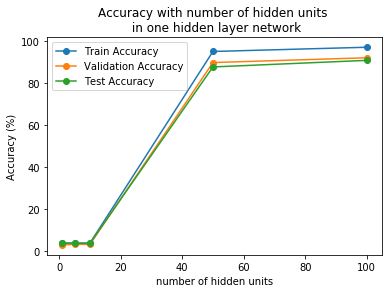

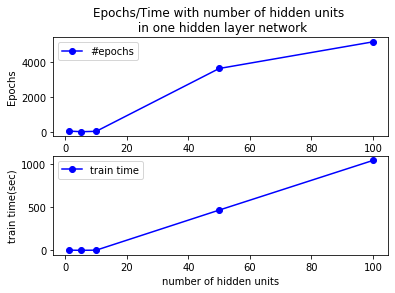

In [151]:
print("------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------")

plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part D - Implementation of ReLU activation for Hidden Layer

In [158]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Sigmoid activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Sigmoid activation------------------


In [159]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

In [222]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with Sigmoid are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with Sigmoid is = {}".format(epochs[-1]))
print("The training time with Sigmoid is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with Sigmoid is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with Sigmoid is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with Sigmoid is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 18.143590612964612
Error on this batch = 18.142845211034345
Error on this batch = 4.45807370316436
Cost on val dataset after 2 epochs is = 4.304085144448161
Initial Cost on Val dataset for this epoch 2 = 4.304085144448161
Error on this batch = 4.301769304315855
Error on this batch = 4.260692190411153
Cost on val dataset after 3 epochs is = 4.2493458133070865
Initial Cost on Val dataset for this epoch 3 = 4.2493458133070865
Error on this batch = 4.245658032776165
Error on this batch = 4.243816378940767
Cost on val dataset after 4 epochs is = 4.242388075338156
Initial Cost on Val dataset for this epoch 4 = 4.242388075338156
Error on this batch = 4.237773773916515
Error on this batch = 4.241154

KeyboardInterrupt: 

In [218]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation------------------


In [225]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2501604830078947
Error on this batch = 3.250180025271866
Error on this batch = 0.4922786403410315
Cost on val dataset after 2 epochs is = 0.4902541232351094
Initial Cost on Val dataset for this epoch 2 = 0.4902541232351094
Error on this batch = 0.49073173500171224
Error on this batch = 0.4915990361818867
Cost on val dataset after 3 epochs is = 0.4894834735718601
Initial Cost on Val dataset for this epoch 3 = 0.4894834735718601
Error on this batch = 0.49028990704542164
Error on this batch = 0.49140220731988254
Cost on val dataset after 4 epochs is = 0.4890727184769381
Initial Cost on Val dataset for this epoch 4 = 0.4890727184769381
Error on this batch = 0.4900737005320259
Error on this bat

KeyboardInterrupt: 

In [168]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with SoftPlus activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with SoftPlus activation------------------


In [173]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'constant')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 100 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 3.246877135953676
Error on this batch = 3.249931231279703
Error on this batch = 0.48140569006748535
Cost on val dataset after 2 epochs is = 0.4808958605143868
Initial Cost on Val dataset for this epoch 2 = 0.4808958605143868
Error on this batch = 0.4807688850741914
Error on this batch = 0.48087242030572824
Cost on val dataset after 3 epochs is = 0.4808834730528983
Initial Cost on Val dataset for this epoch 3 = 0.4808834730528983
Error on this batch = 0.4807006683536065
Error on this batch = 0.48087371210894747
Cost on val dataset after 4 epochs is = 0.4808891341501678
Initial Cost on Val dataset for this epoch 4 = 0.4808891341501678
Error on this batch = 0.4806904264920043
Error on this batch = 0.4

Error on this batch = 0.48065861508996555
Error on this batch = 0.4808624197598051
Cost on val dataset after 40 epochs is = 0.48087701347578476
Initial Cost on Val dataset for this epoch 40 = 0.48087701347578476
Error on this batch = 0.4806579028100669
Error on this batch = 0.48086199440255023
Cost on val dataset after 41 epochs is = 0.48087662291802313
Initial Cost on Val dataset for this epoch 41 = 0.48087662291802313
Error on this batch = 0.4806571929763011
Error on this batch = 0.48086156224454746
Cost on val dataset after 42 epochs is = 0.4808762300959616
Initial Cost on Val dataset for this epoch 42 = 0.4808762300959616
Error on this batch = 0.48065648529006944
Error on this batch = 0.4808611231035236
Cost on val dataset after 43 epochs is = 0.4808758348279888
Initial Cost on Val dataset for this epoch 43 = 0.4808758348279888
Error on this batch = 0.48065577945263616
Error on this batch = 0.4808606767936985
Cost on val dataset after 44 epochs is = 0.48087543693091733
Initial Cost

Error on this batch = 0.4808386763366262
Cost on val dataset after 79 epochs is = 0.48085817555481447
Initial Cost on Val dataset for this epoch 79 = 0.48085817555481447
Error on this batch = 0.4806288508496195
Error on this batch = 0.4808377942828807
Cost on val dataset after 80 epochs is = 0.48085752682263316
Initial Cost on Val dataset for this epoch 80 = 0.48085752682263316
Error on this batch = 0.48062797039212973
Error on this batch = 0.4808368927513637
Cost on val dataset after 81 epochs is = 0.4808568650511062
Initial Cost on Val dataset for this epoch 81 = 0.4808568650511062
Error on this batch = 0.48062707661887927
Error on this batch = 0.48083597113872556
Cost on val dataset after 82 epochs is = 0.4808561897584343
Initial Cost on Val dataset for this epoch 82 = 0.4808561897584343
Error on this batch = 0.4806261688868022
Error on this batch = 0.48083502881704465
Cost on val dataset after 83 epochs is = 0.48085550044382686
Initial Cost on Val dataset for this epoch 83 = 0.4808

Error on this batch = 0.480781211621876
Cost on val dataset after 118 epochs is = 0.48081634838203496
Initial Cost on Val dataset for this epoch 118 = 0.48081634838203496
Error on this batch = 0.48057558825733415
Error on this batch = 0.48077872299028057
Cost on val dataset after 119 epochs is = 0.480814516538101
Initial Cost on Val dataset for this epoch 119 = 0.480814516538101
Error on this batch = 0.48057329947230076
Error on this batch = 0.48077614992683176
Cost on val dataset after 120 epochs is = 0.48081261966965455
Initial Cost on Val dataset for this epoch 120 = 0.48081261966965455
Error on this batch = 0.48057092886097963
Error on this batch = 0.4807734883321748
Cost on val dataset after 121 epochs is = 0.4808106544543537
Initial Cost on Val dataset for this epoch 121 = 0.4808106544543537
Error on this batch = 0.4805684720271657
Error on this batch = 0.48077073384746416
Cost on val dataset after 122 epochs is = 0.4808086173549591
Initial Cost on Val dataset for this epoch 122 

Error on this batch = 0.48053925831269356
Cost on val dataset after 157 epochs is = 0.4806286275199082
Initial Cost on Val dataset for this epoch 157 = 0.4806286275199082
Error on this batch = 0.4803349684246061
Error on this batch = 0.4805238944867913
Cost on val dataset after 158 epochs is = 0.48061626344398367
Initial Cost on Val dataset for this epoch 158 = 0.48061626344398367
Error on this batch = 0.4803188148459036
Error on this batch = 0.48050744001144696
Cost on val dataset after 159 epochs is = 0.48060298295032455
Initial Cost on Val dataset for this epoch 159 = 0.48060298295032455
Error on this batch = 0.48030144083832454
Error on this batch = 0.4804897859764138
Cost on val dataset after 160 epochs is = 0.48058869223357875
Initial Cost on Val dataset for this epoch 160 = 0.48058869223357875
Error on this batch = 0.48028272088840496
Error on this batch = 0.48047080941570025
Cost on val dataset after 161 epochs is = 0.4805732851815176
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.46333967222019284
Cost on val dataset after 196 epochs is = 0.46540842525167564
Initial Cost on Val dataset for this epoch 196 = 0.46540842525167564
Error on this batch = 0.4622987528578695
Error on this batch = 0.4610449129111935
Cost on val dataset after 197 epochs is = 0.46364951461048015
Initial Cost on Val dataset for this epoch 197 = 0.46364951461048015
Error on this batch = 0.46086107551055167
Error on this batch = 0.4589601943576277
Cost on val dataset after 198 epochs is = 0.4620669376275716
Initial Cost on Val dataset for this epoch 198 = 0.4620669376275716
Error on this batch = 0.4596569735635465
Error on this batch = 0.4570206404864429
Cost on val dataset after 199 epochs is = 0.4604895639480442
Initial Cost on Val dataset for this epoch 199 = 0.4604895639480442
Error on this batch = 0.45842610936278066
Error on this batch = 0.4551215454620305
Cost on val dataset after 200 epochs is = 0.45866372178111137
Initial Cost on Val dataset for this epoch 200

Error on this batch = 0.3733468666863732
Cost on val dataset after 235 epochs is = 0.38230156584363556
Initial Cost on Val dataset for this epoch 235 = 0.38230156584363556
Error on this batch = 0.39558667361616273
Error on this batch = 0.3700778800249282
Cost on val dataset after 236 epochs is = 0.37821199171606135
Initial Cost on Val dataset for this epoch 236 = 0.37821199171606135
Error on this batch = 0.3912892669654838
Error on this batch = 0.3661667062913961
Cost on val dataset after 237 epochs is = 0.37360935681061436
Initial Cost on Val dataset for this epoch 237 = 0.37360935681061436
Error on this batch = 0.38637100997227136
Error on this batch = 0.3617864069251449
Cost on val dataset after 238 epochs is = 0.36890179892952335
Initial Cost on Val dataset for this epoch 238 = 0.36890179892952335
Error on this batch = 0.38105701972243344
Error on this batch = 0.35735254253834486
Cost on val dataset after 239 epochs is = 0.36441476756820584
Initial Cost on Val dataset for this epoc

Error on this batch = 0.21994868484091612
Cost on val dataset after 274 epochs is = 0.21636654196363767
Initial Cost on Val dataset for this epoch 274 = 0.21636654196363767
Error on this batch = 0.22351408029291414
Error on this batch = 0.2170909927322449
Cost on val dataset after 275 epochs is = 0.2127834133525289
Initial Cost on Val dataset for this epoch 275 = 0.2127834133525289
Error on this batch = 0.21933054413573508
Error on this batch = 0.21419647930950347
Cost on val dataset after 276 epochs is = 0.20914969737795114
Initial Cost on Val dataset for this epoch 276 = 0.20914969737795114
Error on this batch = 0.21499222048055708
Error on this batch = 0.2113081917351247
Cost on val dataset after 277 epochs is = 0.20556535175485485
Initial Cost on Val dataset for this epoch 277 = 0.20556535175485485
Error on this batch = 0.21059924675820366
Error on this batch = 0.20847392871038076
Cost on val dataset after 278 epochs is = 0.20213883719363193
Initial Cost on Val dataset for this epo

Error on this batch = 0.14754606501649056
Cost on val dataset after 313 epochs is = 0.1557596834463893
Initial Cost on Val dataset for this epoch 313 = 0.1557596834463893
Error on this batch = 0.1405412459381268
Error on this batch = 0.14654674124218497
Cost on val dataset after 314 epochs is = 0.15497913952043488
Initial Cost on Val dataset for this epoch 314 = 0.15497913952043488
Error on this batch = 0.13945586188667528
Error on this batch = 0.14556660080009312
Cost on val dataset after 315 epochs is = 0.15420570640455658
Initial Cost on Val dataset for this epoch 315 = 0.15420570640455658
Error on this batch = 0.13838880539592363
Error on this batch = 0.14460283726180598
Cost on val dataset after 316 epochs is = 0.15343929352681066
Initial Cost on Val dataset for this epoch 316 = 0.15343929352681066
Error on this batch = 0.13733958802074875
Error on this batch = 0.14365279694136707
Cost on val dataset after 317 epochs is = 0.15267984348375668
Initial Cost on Val dataset for this ep

Error on this batch = 0.11254043971675427
Cost on val dataset after 352 epochs is = 0.13122914977451353
Initial Cost on Val dataset for this epoch 352 = 0.13122914977451353
Error on this batch = 0.11113460274644599
Error on this batch = 0.1116956245639905
Cost on val dataset after 353 epochs is = 0.13077043396885188
Initial Cost on Val dataset for this epoch 353 = 0.13077043396885188
Error on this batch = 0.11062942617648969
Error on this batch = 0.11086089489313629
Cost on val dataset after 354 epochs is = 0.13031891973128748
Initial Cost on Val dataset for this epoch 354 = 0.13031891973128748
Error on this batch = 0.11012805917882286
Error on this batch = 0.1100367220887454
Cost on val dataset after 355 epochs is = 0.12987435575588593
Initial Cost on Val dataset for this epoch 355 = 0.12987435575588593
Error on this batch = 0.10963002240470994
Error on this batch = 0.10922344772581002
Cost on val dataset after 356 epochs is = 0.12943648734648486
Initial Cost on Val dataset for this e

Error on this batch = 0.08700703570657822
Cost on val dataset after 391 epochs is = 0.11736264270812719
Initial Cost on Val dataset for this epoch 391 = 0.11736264270812719
Error on this batch = 0.09390905444818876
Error on this batch = 0.08651459957856858
Cost on val dataset after 392 epochs is = 0.1170845107405001
Initial Cost on Val dataset for this epoch 392 = 0.1170845107405001
Error on this batch = 0.0935120720265864
Error on this batch = 0.08602487410546512
Cost on val dataset after 393 epochs is = 0.11680857776776592
Initial Cost on Val dataset for this epoch 393 = 0.11680857776776592
Error on this batch = 0.09311497586300452
Error on this batch = 0.0855372910255364
Cost on val dataset after 394 epochs is = 0.11653487654743007
Initial Cost on Val dataset for this epoch 394 = 0.11653487654743007
Error on this batch = 0.09271789690733488
Error on this batch = 0.08505135386563879
Cost on val dataset after 395 epochs is = 0.11626344701268079
Initial Cost on Val dataset for this epo

Error on this batch = 0.0675895140858616
Cost on val dataset after 430 epochs is = 0.10843517892989894
Initial Cost on Val dataset for this epoch 430 = 0.10843517892989894
Error on this batch = 0.07933322826543941
Error on this batch = 0.06708468317620986
Cost on val dataset after 431 epochs is = 0.10826372067263698
Initial Cost on Val dataset for this epoch 431 = 0.10826372067263698
Error on this batch = 0.07900886468563885
Error on this batch = 0.06658219119026218
Cost on val dataset after 432 epochs is = 0.10809521567191355
Initial Cost on Val dataset for this epoch 432 = 0.10809521567191355
Error on this batch = 0.07868797457565781
Error on this batch = 0.06608222605787221
Cost on val dataset after 433 epochs is = 0.10792964985827182
Initial Cost on Val dataset for this epoch 433 = 0.10792964985827182
Error on this batch = 0.07837055690544306
Error on this batch = 0.06558492529034492
Cost on val dataset after 434 epochs is = 0.10776700964136124
Initial Cost on Val dataset for this 

Cost on val dataset after 468 epochs is = 0.10374536436369663
Initial Cost on Val dataset for this epoch 468 = 0.10374536436369663
Error on this batch = 0.06901882092063216
Error on this batch = 0.0498480598520538
Cost on val dataset after 469 epochs is = 0.10365929053016046
Initial Cost on Val dataset for this epoch 469 = 0.10365929053016046
Error on this batch = 0.06878758736886181
Error on this batch = 0.049470825480924595
Cost on val dataset after 470 epochs is = 0.10357444861331484
Initial Cost on Val dataset for this epoch 470 = 0.10357444861331484
Error on this batch = 0.06855825473027807
Error on this batch = 0.04909781937076808
Cost on val dataset after 471 epochs is = 0.10349082517893816
Initial Cost on Val dataset for this epoch 471 = 0.10349082517893816
Error on this batch = 0.06833079191625854
Error on this batch = 0.048728791748867746
Cost on val dataset after 472 epochs is = 0.10340840743999034
Initial Cost on Val dataset for this epoch 472 = 0.10340840743999034
Error on

Error on this batch = 0.03648764264096482
Cost on val dataset after 507 epochs is = 0.10132039294419083
Initial Cost on Val dataset for this epoch 507 = 0.10132039294419083
Error on this batch = 0.06104035333710294
Error on this batch = 0.03614300142268728
Cost on val dataset after 508 epochs is = 0.10128336394442691
Initial Cost on Val dataset for this epoch 508 = 0.10128336394442691
Error on this batch = 0.060860963956701035
Error on this batch = 0.03580189659456511
Cost on val dataset after 509 epochs is = 0.10124720702313095
Initial Cost on Val dataset for this epoch 509 = 0.10124720702313095
Error on this batch = 0.06068221476119014
Error on this batch = 0.0354648580825823
Cost on val dataset after 510 epochs is = 0.10121190427289564
Initial Cost on Val dataset for this epoch 510 = 0.10121190427289564
Error on this batch = 0.06050391336788222
Error on this batch = 0.03513239322366221
Cost on val dataset after 511 epochs is = 0.1011774414028233
Initial Cost on Val dataset for this 

Cost on val dataset after 545 epochs is = 0.10037418479339143
Initial Cost on Val dataset for this epoch 545 = 0.10037418479339143
Error on this batch = 0.05330753009400323
Error on this batch = 0.027096397888372082
Cost on val dataset after 546 epochs is = 0.10036051306111422
Initial Cost on Val dataset for this epoch 546 = 0.10036051306111422
Error on this batch = 0.053060097435534755
Error on this batch = 0.026939114053631308
Cost on val dataset after 547 epochs is = 0.10034773628116815
Initial Cost on Val dataset for this epoch 547 = 0.10034773628116815
Error on this batch = 0.052810786714409697
Error on this batch = 0.026783860596553983
Cost on val dataset after 548 epochs is = 0.10033592885489889
Initial Cost on Val dataset for this epoch 548 = 0.10033592885489889
Error on this batch = 0.05255976734889082
Error on this batch = 0.026630485883218303
Cost on val dataset after 549 epochs is = 0.10032517728846418
Initial Cost on Val dataset for this epoch 549 = 0.10032517728846418
Err

Cost on val dataset after 583 epochs is = 0.10015606185597799
Initial Cost on Val dataset for this epoch 583 = 0.10015606185597799
Error on this batch = 0.04410040102399604
Error on this batch = 0.022727794360752514
Cost on val dataset after 584 epochs is = 0.10014608125208782
Initial Cost on Val dataset for this epoch 584 = 0.10014608125208782
Error on this batch = 0.043898147192886434
Error on this batch = 0.022643312363138896
Cost on val dataset after 585 epochs is = 0.10013637611692013
Initial Cost on Val dataset for this epoch 585 = 0.10013637611692013
Error on this batch = 0.043695173228961506
Error on this batch = 0.02255916592775435
Cost on val dataset after 586 epochs is = 0.10012703715061401
Initial Cost on Val dataset for this epoch 586 = 0.10012703715061401
Error on this batch = 0.043491667295319586
Error on this batch = 0.022475320648229085
Cost on val dataset after 587 epochs is = 0.10011817030103475
Initial Cost on Val dataset for this epoch 587 = 0.10011817030103475
Err

Cost on val dataset after 621 epochs is = 0.1000314325343619
Initial Cost on Val dataset for this epoch 621 = 0.1000314325343619
Error on this batch = 0.03780752441148556
Error on this batch = 0.020007870284434272
Cost on val dataset after 622 epochs is = 0.1000314155472782
Initial Cost on Val dataset for this epoch 622 = 0.1000314155472782
Error on this batch = 0.037692154500675146
Error on this batch = 0.019954575071211744
Cost on val dataset after 623 epochs is = 0.10003150717238564
Initial Cost on Val dataset for this epoch 623 = 0.10003150717238564
Error on this batch = 0.037579081366929855
Error on this batch = 0.019902298431209355
Cost on val dataset after 624 epochs is = 0.10003170375745245
Initial Cost on Val dataset for this epoch 624 = 0.10003170375745245
Error on this batch = 0.0374682819171386
Error on this batch = 0.019851001327315217
Cost on val dataset after 625 epochs is = 0.1000320021336424
Initial Cost on Val dataset for this epoch 625 = 0.1000320021336424
Error on t

------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------


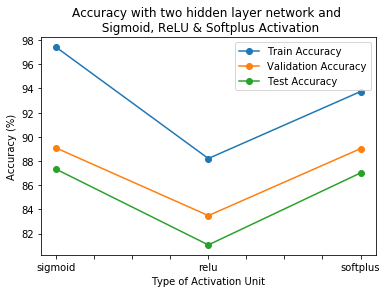

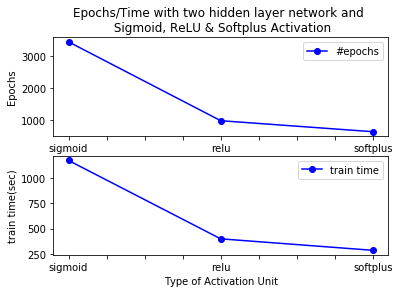

In [191]:
print("------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------")
x=[0,1,2]
plot_accuracy(x, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(x, epochs, train_time)

### Part F - Binary Cross Entropy With ReLU activation

In [ ]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------")

In [226]:
arch=[100, 100]
lr=0.01
theta = theta_init(arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'constant', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (100, 100)
theta between layer 2 and layer 3 is (100, 26)
Initial Cost on Val dataset for this epoch 1 = 18.021429951699993
Error on this batch = 18.0213742588705
Error on this batch = 4.64734158414468
Cost on val dataset after 2 epochs is = 4.558370877836687
Initial Cost on Val dataset for this epoch 2 = 4.558370877836687
Error on this batch = 4.559270353418977
Error on this batch = 4.520330233078562
Cost on val dataset after 3 epochs is = 4.451267077007044
Initial Cost on Val dataset for this epoch 3 = 4.451267077007044
Error on this batch = 4.451664764982239
Error on this batch = 4.398946849768293
Cost on val dataset after 4 epochs is = 4.350245653873463
Initial Cost on Val dataset for this epoch 4 = 4.350245653873463
Error on this batch = 4.347019009170452
Error on this batch = 4.3061317852

Cost on val dataset after 41 epochs is = 3.912379125938072
Initial Cost on Val dataset for this epoch 41 = 3.912379125938072
Error on this batch = 3.8467558284378165
Error on this batch = 3.84490756688332
Cost on val dataset after 42 epochs is = 3.871463732296595
Initial Cost on Val dataset for this epoch 42 = 3.871463732296595
Error on this batch = 3.7985341692220573
Error on this batch = 3.7963606324475494
Cost on val dataset after 43 epochs is = 3.828522244105894
Initial Cost on Val dataset for this epoch 43 = 3.828522244105894
Error on this batch = 3.748181700210445
Error on this batch = 3.746097847859802
Cost on val dataset after 44 epochs is = 3.784180018716535
Initial Cost on Val dataset for this epoch 44 = 3.784180018716535
Error on this batch = 3.696787833683649
Error on this batch = 3.6947490631641915
Cost on val dataset after 45 epochs is = 3.739252723324315
Initial Cost on Val dataset for this epoch 45 = 3.739252723324315
Error on this batch = 3.645329886376415
Error on thi

Cost on val dataset after 81 epochs is = 2.9061080666472456
Initial Cost on Val dataset for this epoch 81 = 2.9061080666472456
Error on this batch = 2.8247137733790675
Error on this batch = 2.7026009057808826
Cost on val dataset after 82 epochs is = 2.8931267836984826
Initial Cost on Val dataset for this epoch 82 = 2.8931267836984826
Error on this batch = 2.8118586492177924
Error on this batch = 2.6879028077334284
Cost on val dataset after 83 epochs is = 2.880368671108758
Initial Cost on Val dataset for this epoch 83 = 2.880368671108758
Error on this batch = 2.799103345488428
Error on this batch = 2.673455398842666
Cost on val dataset after 84 epochs is = 2.8677955641171184
Initial Cost on Val dataset for this epoch 84 = 2.8677955641171184
Error on this batch = 2.786342659094083
Error on this batch = 2.6592661285570593
Cost on val dataset after 85 epochs is = 2.8554608576839713
Initial Cost on Val dataset for this epoch 85 = 2.8554608576839713
Error on this batch = 2.7736724487333686
E

Error on this batch = 2.2762082643451014
Cost on val dataset after 121 epochs is = 2.4938250315894153
Initial Cost on Val dataset for this epoch 121 = 2.4938250315894153
Error on this batch = 2.3683089056060975
Error on this batch = 2.2668511222123118
Cost on val dataset after 122 epochs is = 2.4841934639124212
Initial Cost on Val dataset for this epoch 122 = 2.4841934639124212
Error on this batch = 2.357352768014095
Error on this batch = 2.2574833915716703
Cost on val dataset after 123 epochs is = 2.474572686691955
Initial Cost on Val dataset for this epoch 123 = 2.474572686691955
Error on this batch = 2.3465119557578884
Error on this batch = 2.2480303976229754
Cost on val dataset after 124 epochs is = 2.464935452123182
Initial Cost on Val dataset for this epoch 124 = 2.464935452123182
Error on this batch = 2.3356738519716838
Error on this batch = 2.238514897649524
Cost on val dataset after 125 epochs is = 2.4552477045681007
Initial Cost on Val dataset for this epoch 125 = 2.455247704

Error on this batch = 1.8828819298036934
Cost on val dataset after 161 epochs is = 2.0943206114563586
Initial Cost on Val dataset for this epoch 161 = 2.0943206114563586
Error on this batch = 1.9300296388909732
Error on this batch = 1.872677067163963
Cost on val dataset after 162 epochs is = 2.0845426516177965
Initial Cost on Val dataset for this epoch 162 = 2.0845426516177965
Error on this batch = 1.91959074623211
Error on this batch = 1.8626478551438397
Cost on val dataset after 163 epochs is = 2.0747883580321336
Initial Cost on Val dataset for this epoch 163 = 2.0747883580321336
Error on this batch = 1.909247943220965
Error on this batch = 1.8526093887679238
Cost on val dataset after 164 epochs is = 2.065075080104478
Initial Cost on Val dataset for this epoch 164 = 2.065075080104478
Error on this batch = 1.899089589509933
Error on this batch = 1.842696563506739
Cost on val dataset after 165 epochs is = 2.0553827057377747
Initial Cost on Val dataset for this epoch 165 = 2.05538270573

Error on this batch = 1.4963010404727974
Cost on val dataset after 201 epochs is = 1.7383593265796324
Initial Cost on Val dataset for this epoch 201 = 1.7383593265796324
Error on this batch = 1.565466231979836
Error on this batch = 1.4875181391961376
Cost on val dataset after 202 epochs is = 1.7306941110558725
Initial Cost on Val dataset for this epoch 202 = 1.7306941110558725
Error on this batch = 1.5578399501982472
Error on this batch = 1.4787901258913698
Cost on val dataset after 203 epochs is = 1.723139132545227
Initial Cost on Val dataset for this epoch 203 = 1.723139132545227
Error on this batch = 1.5503083070050576
Error on this batch = 1.470055498134344
Cost on val dataset after 204 epochs is = 1.7156659305551936
Initial Cost on Val dataset for this epoch 204 = 1.7156659305551936
Error on this batch = 1.5428177775143155
Error on this batch = 1.4614755729558155
Cost on val dataset after 205 epochs is = 1.7082902013505477
Initial Cost on Val dataset for this epoch 205 = 1.7082902

Error on this batch = 1.2213920923618147
Cost on val dataset after 240 epochs is = 1.5017624121072262
Initial Cost on Val dataset for this epoch 240 = 1.5017624121072262
Error on this batch = 1.3228916441177614
Error on this batch = 1.2161854213154024
Cost on val dataset after 241 epochs is = 1.4973305044968193
Initial Cost on Val dataset for this epoch 241 = 1.4973305044968193
Error on this batch = 1.3181057681222756
Error on this batch = 1.211118805705574
Cost on val dataset after 242 epochs is = 1.492971677693274
Initial Cost on Val dataset for this epoch 242 = 1.492971677693274
Error on this batch = 1.3133854891109276
Error on this batch = 1.2061421620954194
Cost on val dataset after 243 epochs is = 1.4886707291019539
Initial Cost on Val dataset for this epoch 243 = 1.4886707291019539
Error on this batch = 1.3088118102125452
Error on this batch = 1.2012383919112488
Cost on val dataset after 244 epochs is = 1.484447942078305
Initial Cost on Val dataset for this epoch 244 = 1.4844479

Error on this batch = 1.0697914774803057
Cost on val dataset after 280 epochs is = 1.367918553782051
Initial Cost on Val dataset for this epoch 280 = 1.367918553782051
Error on this batch = 1.1821731418703967
Error on this batch = 1.0671359901507529
Cost on val dataset after 281 epochs is = 1.3654739375698421
Initial Cost on Val dataset for this epoch 281 = 1.3654739375698421
Error on this batch = 1.1795307214402782
Error on this batch = 1.0645642412960103
Cost on val dataset after 282 epochs is = 1.363052665163802
Initial Cost on Val dataset for this epoch 282 = 1.363052665163802
Error on this batch = 1.1768759210770798
Error on this batch = 1.0620422710992243
Cost on val dataset after 283 epochs is = 1.3606287385587892
Initial Cost on Val dataset for this epoch 283 = 1.3606287385587892
Error on this batch = 1.174204049221902
Error on this batch = 1.0594727608067311
Cost on val dataset after 284 epochs is = 1.3582433932939644
Initial Cost on Val dataset for this epoch 284 = 1.35824339

Error on this batch = 0.9898939809078783
Cost on val dataset after 319 epochs is = 1.2938737405174652
Initial Cost on Val dataset for this epoch 319 = 1.2938737405174652
Error on this batch = 1.1010318683954419
Error on this batch = 0.9884863758585263
Cost on val dataset after 320 epochs is = 1.2925385584690436
Initial Cost on Val dataset for this epoch 320 = 1.2925385584690436
Error on this batch = 1.0995528991364327
Error on this batch = 0.9871119898191799
Cost on val dataset after 321 epochs is = 1.2912138396125488
Initial Cost on Val dataset for this epoch 321 = 1.2912138396125488
Error on this batch = 1.0981374617805404
Error on this batch = 0.9858298937619125
Cost on val dataset after 322 epochs is = 1.2899275537897197
Initial Cost on Val dataset for this epoch 322 = 1.2899275537897197
Error on this batch = 1.0966995228870595
Error on this batch = 0.9845670018889987
Cost on val dataset after 323 epochs is = 1.2886965696567423
Initial Cost on Val dataset for this epoch 323 = 1.288

Error on this batch = 0.9484996605843989
Cost on val dataset after 358 epochs is = 1.2542425057150883
Initial Cost on Val dataset for this epoch 358 = 1.2542425057150883
Error on this batch = 1.0517353804166327
Error on this batch = 0.9475536044915432
Cost on val dataset after 359 epochs is = 1.2535060045041084
Initial Cost on Val dataset for this epoch 359 = 1.2535060045041084
Error on this batch = 1.0508606847579598
Error on this batch = 0.9466637740784346
Cost on val dataset after 360 epochs is = 1.2527697262906428
Initial Cost on Val dataset for this epoch 360 = 1.2527697262906428
Error on this batch = 1.0500047170699016
Error on this batch = 0.9458795218560772
Cost on val dataset after 361 epochs is = 1.2520411907216344
Initial Cost on Val dataset for this epoch 361 = 1.2520411907216344
Error on this batch = 1.0492351131973943
Error on this batch = 0.9450235081497524
Cost on val dataset after 362 epochs is = 1.251336783115142
Initial Cost on Val dataset for this epoch 362 = 1.2513

Error on this batch = 0.927315216447291
Cost on val dataset after 397 epochs is = 1.2310545851845758
Initial Cost on Val dataset for this epoch 397 = 1.2310545851845758
Error on this batch = 1.0226948189989804
Error on this batch = 0.9271689401572231
Cost on val dataset after 398 epochs is = 1.230601145825495
Initial Cost on Val dataset for this epoch 398 = 1.230601145825495
Error on this batch = 1.0220056008852532
Error on this batch = 0.9272046726203647
Cost on val dataset after 399 epochs is = 1.230176495404806
Initial Cost on Val dataset for this epoch 399 = 1.230176495404806
Error on this batch = 1.021395443231008
Error on this batch = 0.9271509412853246
Cost on val dataset after 400 epochs is = 1.2297570074413227
Initial Cost on Val dataset for this epoch 400 = 1.2297570074413227
Error on this batch = 1.0208952129353674
Error on this batch = 0.9271465537192601
Cost on val dataset after 401 epochs is = 1.2293730150799846
Initial Cost on Val dataset for this epoch 401 = 1.229373015

Error on this batch = 0.9145079245000209
Cost on val dataset after 437 epochs is = 1.2179779993300184
Initial Cost on Val dataset for this epoch 437 = 1.2179779993300184
Error on this batch = 0.994155564382053
Error on this batch = 0.9140086716430542
Cost on val dataset after 438 epochs is = 1.2177164970466243
Initial Cost on Val dataset for this epoch 438 = 1.2177164970466243
Error on this batch = 0.9934126266051118
Error on this batch = 0.9134118871267128
Cost on val dataset after 439 epochs is = 1.217449024149363
Initial Cost on Val dataset for this epoch 439 = 1.217449024149363
Error on this batch = 0.9926576257211054
Error on this batch = 0.9128105920138938
Cost on val dataset after 440 epochs is = 1.2172023863149597
Initial Cost on Val dataset for this epoch 440 = 1.2172023863149597
Error on this batch = 0.9918848604124126
Error on this batch = 0.9123906583269124
Cost on val dataset after 441 epochs is = 1.2169463429054517
Initial Cost on Val dataset for this epoch 441 = 1.216946

Error on this batch = 0.8959794165495484
Cost on val dataset after 476 epochs is = 1.208999883776117
Initial Cost on Val dataset for this epoch 476 = 1.208999883776117
Error on this batch = 0.9684110541699429
Error on this batch = 0.8955499639984134
Cost on val dataset after 477 epochs is = 1.2087893425211842
Initial Cost on Val dataset for this epoch 477 = 1.2087893425211842
Error on this batch = 0.9678256444425583
Error on this batch = 0.8951468521216407
Cost on val dataset after 478 epochs is = 1.2086034813072974
Initial Cost on Val dataset for this epoch 478 = 1.2086034813072974
Error on this batch = 0.9672541697621008
Error on this batch = 0.8947007981701591
Cost on val dataset after 479 epochs is = 1.208397998858411
Initial Cost on Val dataset for this epoch 479 = 1.208397998858411
Error on this batch = 0.9667890455783419
Error on this batch = 0.8942721175541771
Cost on val dataset after 480 epochs is = 1.2081777602360544
Initial Cost on Val dataset for this epoch 480 = 1.2081777

Error on this batch = 0.9545225707447546
Error on this batch = 0.8806108433424403
Cost on val dataset after 515 epochs is = 1.2010052185387456
Initial Cost on Val dataset for this epoch 515 = 1.2010052185387456
Error on this batch = 0.9543543802383531
Error on this batch = 0.8802630755208043
Cost on val dataset after 516 epochs is = 1.2008908352376664
Initial Cost on Val dataset for this epoch 516 = 1.2008908352376664
Error on this batch = 0.9542556569020911
Error on this batch = 0.8798718206036077
Cost on val dataset after 517 epochs is = 1.200776723704856
Initial Cost on Val dataset for this epoch 517 = 1.200776723704856
Error on this batch = 0.9541482727494736
Error on this batch = 0.8794981085890606
Cost on val dataset after 518 epochs is = 1.2006247355228068
Initial Cost on Val dataset for this epoch 518 = 1.2006247355228068
Error on this batch = 0.9541201247709278
Error on this batch = 0.8791569431217439
Cost on val dataset after 519 epochs is = 1.2004980392621962
Initial Cost on

Error on this batch = 0.9555043255392007
Error on this batch = 0.862086479521038
Cost on val dataset after 555 epochs is = 1.1975044788340736
Initial Cost on Val dataset for this epoch 555 = 1.1975044788340736
Error on this batch = 0.9556749166495219
Error on this batch = 0.8615815136787945
Cost on val dataset after 556 epochs is = 1.1974253790472875
Initial Cost on Val dataset for this epoch 556 = 1.1974253790472875
Error on this batch = 0.9558859650660443
Error on this batch = 0.8608961423725543
Cost on val dataset after 557 epochs is = 1.1973852160452092
Initial Cost on Val dataset for this epoch 557 = 1.1973852160452092
Error on this batch = 0.9560998633672803
Error on this batch = 0.8603971319970581
Cost on val dataset after 558 epochs is = 1.197381633177382
Initial Cost on Val dataset for this epoch 558 = 1.197381633177382
Error on this batch = 0.9561959903871414
Error on this batch = 0.8598205856749749
Cost on val dataset after 559 epochs is = 1.1973423480716725
Initial Cost on 

Cost on val dataset after 594 epochs is = 1.1972234561174548
Initial Cost on Val dataset for this epoch 594 = 1.1972234561174548
Error on this batch = 0.9559398188349133
Error on this batch = 0.845206392716946
Cost on val dataset after 595 epochs is = 1.1971831200326262
Initial Cost on Val dataset for this epoch 595 = 1.1971831200326262
Error on this batch = 0.9558254887074428
Error on this batch = 0.845008644814628
Cost on val dataset after 596 epochs is = 1.1971593267092961
Initial Cost on Val dataset for this epoch 596 = 1.1971593267092961
Error on this batch = 0.9557336526765976
Error on this batch = 0.844656020277495
Cost on val dataset after 597 epochs is = 1.197169560314951
Initial Cost on Val dataset for this epoch 597 = 1.197169560314951
Error on this batch = 0.9555962418105723
Error on this batch = 0.844332138517521
Cost on val dataset after 598 epochs is = 1.197174416303347
Initial Cost on Val dataset for this epoch 598 = 1.197174416303347
Error on this batch = 0.95548004851

ValueError: shapes (13000,784) and (785,100) not aligned: 784 (dim 1) != 785 (dim 0)

## Part E - MLP Classifier using SKLEARN

In [ ]:
print("----------------------------Running Part E-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with MLP Classifier------------------")

In [194]:
from sklearn.neural_network import MLPClassifier as mlp_classifier
PATH = os.getcwd()
os.chdir('Alphabets/')
X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features
train_class_enc = pd.get_dummies(train_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

In [198]:
epochs = []
train_accuracy = []
test_accuracy = []
train_time = []
clf=[]

In [199]:
#Classifier - logistic with constant LR
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier - logistic with early_stopping =True
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=True, tol=1e-4, verbose=True))
#Classifier - logistic with invscaling with sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier - logistic with invscaling with pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-4, verbose=True))


#Classifier ReLU with constant LR (1e-4)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-4, verbose=True))
#Classifier ReLU with constant LR (1e-6)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with early stopping
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=True, tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with invscaling sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     tol=1e-6, verbose=True))
#Classifier ReLU with constant LR (1e-6) with invscaling pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.5, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-6, verbose=True))

In [200]:
for i in range(len(clf)):
    print("--------Training the classifier with following params--------------")
    print("-------------------------------------------------------------------")
    print(clf[i])
    print("-------------------------------------------------------------------")
    start =time.time()
    clf[i].fit(X_train, train_class_enc)
    end = time.time()
    epochs.append(clf[i].n_iter_)
    train_accuracy.append(clf[i].score(X_train, train_class_enc)*100)
    test_accuracy.append(clf[i].score(X_test, test_actual_class_enc)*100)
    train_time.append(end-start)
    print("The training Accuracy achieved is = {:2.3f}".format(train_accuracy[-1]))
    print("The test Accuracy achieved is = {:2.3f}".format(test_accuracy[-1]))    
    print("The number of epochs is = {}".format(epochs[-1]))    
    print("The training time achieved is = {:2.3f}".format(train_time[-1]))    

--------Training the classifier with following params--------------
-------------------------------------------------------------------
MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)
-------------------------------------------------------------------
Iteration 1, loss = 4.41626708
Iteration 2, loss = 3.75906753
Iteration 3, loss = 2.70636537
Iteration 4, loss = 1.98558900
Iteration 5, loss = 1.54365930
Iteration 6, loss = 1.26472933
Iteration 7, loss = 1.07475392
Iteration 8, loss = 0.94425315
Iteration 9, loss = 0.84534348
Iter

Iteration 42, loss = 0.08183688
Validation score: 0.873077
Iteration 43, loss = 0.07770823
Validation score: 0.876154
Iteration 44, loss = 0.07269077
Validation score: 0.872308
Iteration 45, loss = 0.06885908
Validation score: 0.880769
Iteration 46, loss = 0.06576158
Validation score: 0.870000
Iteration 47, loss = 0.06146358
Validation score: 0.874615
Iteration 48, loss = 0.05860248
Validation score: 0.876923
Iteration 49, loss = 0.05593526
Validation score: 0.875385
Iteration 50, loss = 0.05328317
Validation score: 0.877692
Iteration 51, loss = 0.05096292
Validation score: 0.880769
Iteration 52, loss = 0.04870029
Validation score: 0.885385
Iteration 53, loss = 0.04638677
Validation score: 0.879231
Iteration 54, loss = 0.04453626
Validation score: 0.883846
Iteration 55, loss = 0.04259724
Validation score: 0.880000
Iteration 56, loss = 0.04099026
Validation score: 0.883846
Iteration 57, loss = 0.03917957
Validation score: 0.885385
Iteration 58, loss = 0.03780551
Validation score: 0.8815

Iteration 4, loss = 0.59791682
Iteration 5, loss = 0.51325233
Iteration 6, loss = 0.45412123
Iteration 7, loss = 0.40938059
Iteration 8, loss = 0.38869193
Iteration 9, loss = 0.36917090
Iteration 10, loss = 0.35996178
Iteration 11, loss = 0.34182968
Iteration 12, loss = 0.32782765
Iteration 13, loss = 0.30954143
Iteration 14, loss = 0.25706778
Iteration 15, loss = 0.26412972
Iteration 16, loss = 0.27437602
Iteration 17, loss = 0.25190535
Iteration 18, loss = 0.25830648
Iteration 19, loss = 0.26555163
Iteration 20, loss = 0.25317055
Iteration 21, loss = 0.22557349
Iteration 22, loss = 0.22310867
Iteration 23, loss = 0.23789027
Iteration 24, loss = 0.23624983
Iteration 25, loss = 0.25647776
Iteration 26, loss = 0.26067992
Iteration 27, loss = 0.24814076
Iteration 28, loss = 0.18976482
Iteration 29, loss = 0.22460727
Iteration 30, loss = 0.21073660
Iteration 31, loss = 0.21969449
Iteration 32, loss = 0.24478115
Iteration 33, loss = 0.29395456
Iteration 34, loss = 0.32370226
Iteration 35, 

Iteration 88, loss = 721725537.01903903
Iteration 89, loss = 721724656.96578920
Iteration 90, loss = 721723781.90376055
Iteration 91, loss = 721722911.74900281
Iteration 92, loss = 721722046.41988552
Iteration 93, loss = 721721185.83701110
Iteration 94, loss = 721720329.92315578
Iteration 95, loss = 721719478.60314620
Iteration 96, loss = 721718631.80381668
Iteration 97, loss = 721717789.45391846
Iteration 98, loss = 721716951.48405766
Iteration 99, loss = 721716117.82662165
Iteration 100, loss = 721715288.41572666
Iteration 101, loss = 721714463.18714178
Iteration 102, loss = 721713642.07824659
Iteration 103, loss = 721712825.02796030
Iteration 104, loss = 721712011.97670460
Iteration 105, loss = 721711202.86633790
Iteration 106, loss = 721710397.64011884
Iteration 107, loss = 721709596.24264932
Iteration 108, loss = 721708798.61984837
Iteration 109, loss = 721708004.71887422
Iteration 110, loss = 721707214.48813045
Iteration 111, loss = 721706427.87718499
Iteration 112, loss = 721705

Iteration 289, loss = 721599730.79679167
Iteration 290, loss = 721599246.35095108
Iteration 291, loss = 721598762.74304938
Iteration 292, loss = 721598279.96875107
Iteration 293, loss = 721597798.02376664
Iteration 294, loss = 721597316.90383554
Iteration 295, loss = 721596836.60473788
Iteration 296, loss = 721596357.12228858
Iteration 297, loss = 721595878.45233381
Iteration 298, loss = 721595400.59076548
Iteration 299, loss = 721594923.53349805
Iteration 300, loss = 721594447.27648783
Iteration 301, loss = 721593971.81572020
Iteration 302, loss = 721593497.14722121
Iteration 303, loss = 721593023.26703858
Iteration 304, loss = 721592550.17126477
Iteration 305, loss = 721592077.85601580
Iteration 306, loss = 721591606.31744421
Iteration 307, loss = 721591135.55173087
Iteration 308, loss = 721590665.55509210
Iteration 309, loss = 721590196.32376790
Iteration 310, loss = 721589727.85403907
Iteration 311, loss = 721589260.14220691
Iteration 312, loss = 721588793.18460774
Iteration 313, l

Iteration 84, loss = 21.74238400
Iteration 85, loss = 21.74217611
Iteration 86, loss = 21.74193866
Iteration 87, loss = 21.74174632
Iteration 88, loss = 21.74148290
Iteration 89, loss = 21.74127909
Iteration 90, loss = 21.74107189
Iteration 91, loss = 21.74084725
Iteration 92, loss = 21.74063640
Iteration 93, loss = 21.74041303
Iteration 94, loss = 21.74019934
Iteration 95, loss = 21.73998341
Iteration 96, loss = 21.73979461
Iteration 97, loss = 21.73956165
Iteration 98, loss = 21.73935896
Iteration 99, loss = 21.73914743
Iteration 100, loss = 21.73894557
Iteration 101, loss = 21.73870069
Iteration 102, loss = 21.73850299
Iteration 103, loss = 21.73830402
Iteration 104, loss = 21.73810295
Iteration 105, loss = 21.73789966
Iteration 106, loss = 21.73768458
Iteration 107, loss = 21.73748514
Iteration 108, loss = 21.73727121
Iteration 109, loss = 21.73707106
Iteration 110, loss = 21.73686755
Iteration 111, loss = 21.73665618
Iteration 112, loss = 21.73647103
Iteration 113, loss = 21.73626

Iteration 326, loss = 21.70136895
Iteration 327, loss = 21.70121440
Iteration 328, loss = 21.70108077
Iteration 329, loss = 21.70094660
Iteration 330, loss = 21.70081659
Iteration 331, loss = 21.70065919
Iteration 332, loss = 21.70052520
Iteration 333, loss = 21.70037671
Iteration 334, loss = 21.70023780
Iteration 335, loss = 21.70010761
Iteration 336, loss = 21.69996366
Iteration 337, loss = 21.69982009
Iteration 338, loss = 21.69969216
Iteration 339, loss = 21.69954543
Iteration 340, loss = 21.69940628
Iteration 341, loss = 21.69927015
Iteration 342, loss = 21.69913834
Iteration 343, loss = 21.69899429
Iteration 344, loss = 21.69885645
Iteration 345, loss = 21.69871341
Iteration 346, loss = 21.69857400
Iteration 347, loss = 21.69844311
Iteration 348, loss = 21.69830293
Iteration 349, loss = 21.69817789
Iteration 350, loss = 21.69802848
Iteration 351, loss = 21.69788502
Iteration 352, loss = 21.69775747
Iteration 353, loss = 21.69760469
Iteration 354, loss = 21.69748872
Iteration 355,

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


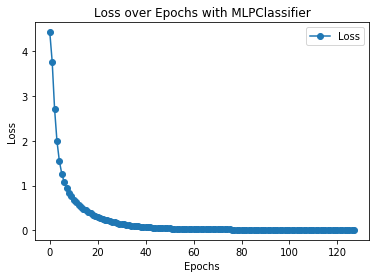

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


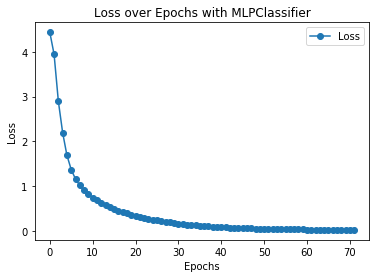

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


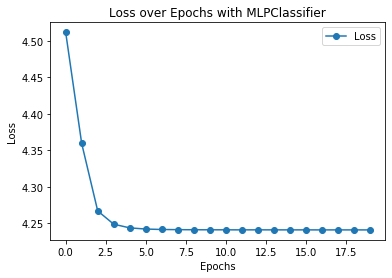

Plot for MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.3333333333333333, random_state=None, shuffle=True,
              solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False) 


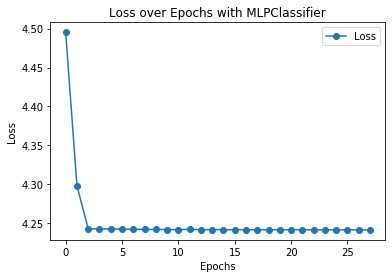

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False) 


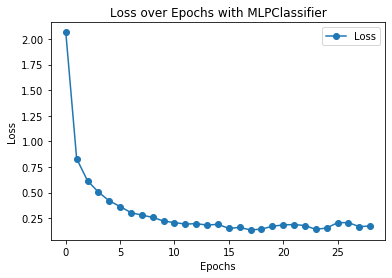

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


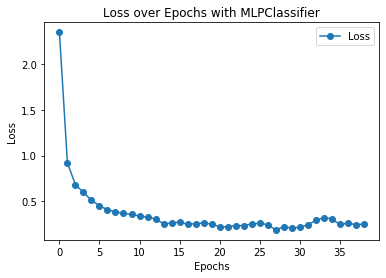

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


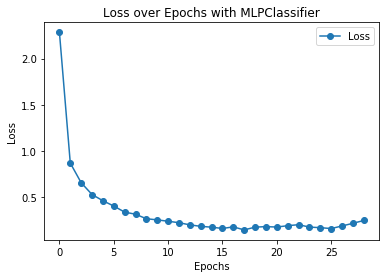

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False) 


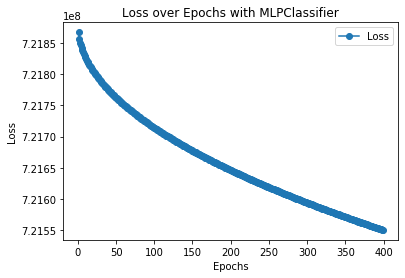

Plot for MLPClassifier(activation='relu', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='invscaling',
              learning_rate_init=0.5, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.3333333333333333, random_state=None, shuffle=True,
              solver='sgd', tol=1e-06, validation_fraction=0.1, verbose=True,
              warm_start=False) 


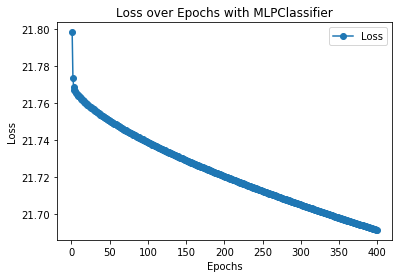

In [201]:
for i in range(len(clf)):
    print("Plot for {} ".format(clf[i]))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(clf[i].loss_curve_, marker='o', label='Loss')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss over Epochs with MLPClassifier")

    ax.legend()

    #plt.savefig("plots/parte/relu_e-8.png", dpi=1000, bbox_inches='tight')
    plt.show()

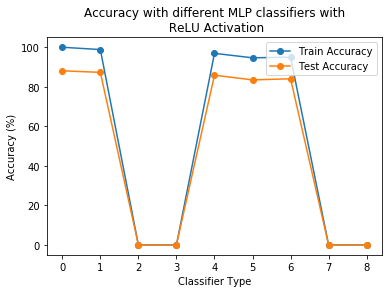

In [202]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with different MLP classifiers with\n ReLU Activation")
x=np.arange(len(clf))
ax.plot(x, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(x, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("Classifier Type")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("plots/parte/accuracy_mlp_relu.png", dpi=1000, bbox_inches='tight')
plt.show()

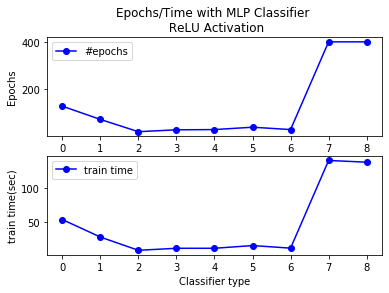

In [204]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with MLP Classifier \n ReLU Activation")
ax.plot(x, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("Classifier Type")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(x, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("Classifier type")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("plots/parte/epochs_time_relu.png", dpi=1000, bbox_inches='tight')
plt.show()